# HPLC Denoiser

Purpose: Generate an algorithm that I can run to take away noise from HPLC traces so I can find true areas of peaks 

Steps 1: Generate a method to generate synthetic data 

Steps 2: Generate a method to add different types of noise to that data. 

Steps 3: Error Tolerances. A). How much noise can I add and still get an accurate peak area? B). How close can two peaks be before I lose accuracy?

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
pd.options.mode.chained_assignment = None 
import seaborn as sns 
import math
import random
from scipy.integrate import simps
from sklearn.manifold import TSNE
from scipy.integrate import simps
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from statannot import add_stat_annotation
import scipy.signal
from scipy.stats import exponnorm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lmfit.models import GaussianModel
from lmfit.models import GaussianModel,ExponentialGaussianModel,SkewedGaussianModel,VoigtModel,LorentzianModel,LognormalModel
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import scipy
import pybaselines
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=1)
sns.set_style("white")

In [2]:
def model_n_expgaus(x,y,number_peaks,peak_locations,peak_heights,graph=False,peakz=None):
    """
    Inputs: x and y axises to be fitted, the number of peaks to create and the approximate peak locations 
    Outputs: Array of tuples (peak location, peak area)
    Prints: Summary graphs showing initial and final fit, and showing the locations of gaussian components 
    """
  
    #goes from max to min number of peaks, finds bic, removes smallest peak, repeat 
    model=''
    for n in range(0,number_peaks):
        gaus=ExponentialGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-0.5,max=peak_locations[n]+0.5)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=0.05, min=0.01,max=2)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n], min=0.01*peak_heights[n],max=peak_heights[n]*1.1)
            pars['p'+str(n)+'_gamma'].set(value=2,max=5,min=0.01)
        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-0.5,max=peak_locations[n]+0.5)
            pars['p'+str(n)+'_sigma'].set(value=0.05, min=0.01,max=2)
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n], min=0.01*peak_heights[n],max=peak_heights[n]*1.1)
            pars['p'+str(n)+'_gamma'].set(value=2,max=5,min=0.01)
    #Uses gradient descent to best fit model 
    try:
        result = model.fit(y, pars, x=x)
    #print(result.fit_report())
    except AttributeError:
        return None

    # plot results

    #intial fit 
    init = model.eval(pars, x=x)
    #to get best fit 
    out = model.fit(y, pars, x=x)


 







    comps=out.eval_components(x=x) 
    if graph:
        fig, axes = plt.subplots(3, 1, figsize=(10,15))
        plt.style.use("fast")

        #plots underlying data
        axes[0].plot(x, y)
        #plots initial fit in orange with dashed line 
        axes[0].plot(x, init, '--', label='initial fit')
        #plots best fit in green with solid line 
        axes[0].plot(x, out.best_fit, '-', label='best fit')
        axes[1].plot(x, out.best_fit, '-', label='best fit',color='k')
        axes[0].legend()

        #find the components of the best fit curve 
        #plots underlying data 
        plt.style.use("fast")
        axes[1].plot(x, y,color='blue')
        areas=[]
    #plots each peak 
    areas=[]
    colors=['#176E9D','#C2882B','#128B6A']
    for n in range(0,number_peaks):
        if graph:
            axes[1].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
            axes[1].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.5,color=colors[n]) 
            #adds peak location on the actual output graph 
            #axes[2].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
            axes[2].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.5,color=colors[n]) 
  
            if n==0:
                axes[2].plot(x,peakz[n],color='k')
            elif n==1:
                axes[2].plot(x,peakz[n],color='r')
            else:
                axes[2].plot(x,peakz[n],color='orange')
            #axes[1].text(out.params['p'+str(n)"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
        #calculates the area which is amplitude(SD)/(1/sqrt(2*pi))
        area=sum(comps['p'+str(n)+"_"])*0.01
        error=0
        for a,b in zip(peakz[n],comps['p'+str(n)+"_"]):
           error+=(a-b)*(a-b)
        rmse=np.sqrt(error/(len(y)))
        center=out.params['p'+str(n)+"_center"].value
        print(error)
        areas.append([center,area,rmse])
    
        #axes[1].legend()
    
   # plt.show()
    return(areas)

def find_locations_peaks(data,peak_prominence_cutoff,height_cutoff,graph=False,shoulder=False, shoulder_cutoffs=None):
    """
    Inputs: Data for the HPLC trace, prominence cut off for when peaks should be accepted 
    Outputs: Approximate Peak locations 
    """
    #Use peaks from the first derivative to find putative peak locations 
    #Can we improve on this? (Use 0th derivative to find real peaks and first derivative to find shoulders)
    
    #Finds time averaged derivative
    data.loc[:, 'Smoothed']=savgol_filter(data.loc[:,"Value"], window_length=31, polyorder=3, deriv=0)
    data.loc[:, 'Time Ave']=savgol_filter(data.loc[:,"Value"], window_length=31, polyorder=3, deriv=1)
    #data.loc[:, 'Time Ave']+=min(data.loc[:, 'Time Ave'])
    if graph:
        fig,ax=plt.subplots(2,1,figsize=(15,10))
        #plots derivative 
        sns.lineplot(x=data['Time'], y=data['Smoothed'], label='Smoothed',ax=ax[0])
    data["Inverse Smoothed"]=data.loc[:,'Smoothed']*-1+max(data.loc[:, 'Smoothed'])
    data["Inverse Time Ave"]=data.loc[:,'Time Ave']*-1+max(data.loc[:, 'Time Ave'])
    data["Moved Time Ave"]=data.loc[:,'Time Ave']+abs(min(data.loc[:, 'Time Ave']))
    
    if graph:
        sns.lineplot(x=data['Time'], y=data['Time Ave'], label='Time Averaged First Derivative',ax=ax[1])
        sns.lineplot(x=data['Time'], y=data['Inverse Time Ave'], label='Inverse Time Averaged First Derivative',ax=ax[1])
    #finds peaks from the time averaged derivative. These are really inflection points not actually peaks, but this
    #method will correctly identify shoulders
    #finds real peaks 
    peaks = find_peaks(data['Smoothed'],prominence=peak_prominence_cutoff,height=height_cutoff)[0]
    peaks2 = find_peaks(data['Moved Time Ave'],prominence=peak_prominence_cutoff/5,height=height_cutoff/5)[0]
    valleys = find_peaks(data['Inverse Smoothed'],prominence=peak_prominence_cutoff,height=height_cutoff)[0]
    valleys2 = find_peaks(data['Inverse Time Ave'],prominence=peak_prominence_cutoff/5,height=height_cutoff/5)[0]
    shoulder_times=[]
    for potential_shoulder in peaks2: 

        if data["Time Ave"].values[potential_shoulder]>=0:
            pass 
        else:
            shoulder_times.append(potential_shoulder)
    for potential_shoulder in valleys2: 

        if data["Time Ave"].values[potential_shoulder]<=0:
            pass 
        else:
            shoulder_times.append(potential_shoulder)
    #plots IDed peaks on the first derivative plot (or normal plot)
    if graph:
        sns.scatterplot(x=data["Time"].values[peaks], y=data["Smoothed"].values[peaks], s = 55,
                 label = 'Peak Centers',ax=ax[0])
        sns.scatterplot(x=data["Time"].values[valleys], y=data["Smoothed"].values[valleys], s = 55,
                 label = 'Valleys',ax=ax[0])
        """
        sns.scatterplot(x=data["Time"].values[shoulder_times], y=data["Smoothed"].values[shoulder_times], s = 55,
                 label = 'Peak Shoulders',ax=ax[0])
        
        sns.scatterplot(x=data["Time"].values[valleys2], y=data["Time Ave"].values[valleys2], s = 55,
                 label = 'Inverse Time Ave',ax=ax[1])
        sns.scatterplot(x=data["Time"].values[peaks2], y=data["Time Ave"].values[peaks2], s = 55,
                 label = 'Peak Shoulders',ax=ax[1])
        """
        plt.show()
    
    times=data["Time"].values[peaks]
    valley_times=[0]
    for a in valleys:
        valley_times.append(data["Time"].values[a])
    heights=data["Value"].values[peaks]
    if shoulder:

        times=np.append(times,data["Time"].values[shoulder_times],axis=0)
        heights=np.append(heights,data["Value"].values[shoulder_times],axis=0)
    valley_times.append(20)  
    #converts reference peaks into the time domain (rather than index )
    print(valley_times)
    return times,heights,valley_times
def find_peak_areas(single_rep,sample_name,start,end,canonical_peaks=None,graph=False,shoulder=False,comparisons=False,
                   peak1=None,peak2=None,peak3=None):
    #reduces the dataframe to a single replicate 
    #finds peaks 
    if canonical_peaks is None:
        reference_peak_list,heights,valleys=find_locations_peaks(single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<end)],0.1,1,graph=graph,shoulder=shoulder)
    else:
        reference_peak_list,heights,valleys=canonical_peaks[0],canonical_peaks[1],canonical_peaks[2]
    #x and y for gaussian modeling 
    x=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Time']
    y=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Value']
    areas=model_n_expgaus(x,y,len(reference_peak_list),reference_peak_list,heights,graph=graph,peakz=[peak1,peak2,peak3])
    return areas


In [3]:
#generate synthetic data
x =np.arange(0,107.5,0.01)
from scipy.stats import exponnorm

#randomly 
def _ngaussian_exp(x,amps,cens,sigmas,gammas,noise=None,noiseamp=0,graph=False):
    func=0
    fn=0
    area=[]
    for n in range(0,len(amps)):
        fn+=amps[n]*exponnorm.pdf(x, gammas[n],scale=sigmas[n],loc=cens[n])
        area.append(amps[n])
    if graph:
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.plot(x,fn)
    if noise=='Normal':
        fn+=np.random.normal(size=len(x), scale=noiseamp*min(amps))
    if noise=='Normal Slanted':
        fn+=np.random.normal(size=len(x), scale=noiseamp*min(amps))
        fn+=5*x
    if graph:
        fig,ax2=plt.subplots(1,1,figsize=(15,5))
        ax2.plot(x,fn)

    return area,fn
def low_pass_filter(data, band_limit, sampling_rate) -> np.ndarray:
    # translate bandlimit from Hz to dataindex according to sampling rate and data size
     cutoff_index = int(band_limit * data.size / sampling_rate)
     F = np.fft.rfft(data)
     F[cutoff_index + 1:] = 0
    
     return np.fft.irfft(F, n=data.size).real
def remove_noise(data, band_limit,lamba,smoothing, sampling_rate=500):
    """
    Inputs: 
    Data: numpy array with signal 
    Band-limit: Frequency cutoff for FFT
    Sampling-rate: Max Frequency that's measured (500/s for our machine)
    lamba: smoothing function for
    """
    k=pybaselines.whittaker.psalsa(data,lam=lamba)[0]
    data=data-k
    z=low_pass_filter(data,band_limit,sampling_rate)
    z=np.convolve(z, np.ones(smoothing)/smoothing, mode='same')
    return z

In [152]:
#generate one peak with increasing amounts of noise and compare error rates 
error_list=[]

for amp in [0,0.01,0.05,0.1,0.2,0.4,0.8]:
    print(amp)
    for i in range(0,100):
        amps=[]
        gammas=[]
        sigmas=[]
        center=[0]
        for y in range(0,1): 
            amps.append(random.uniform(1,5))
            gammas.append(random.uniform(2.9,3))
            sigmas.append(random.uniform(0.1,0.2))
            center.append(random.uniform(max(center)+0.5,max(center)+1.5))
        x =np.arange(0,20,0.01)
        areas,y=_ngaussian_exp(x,amps,center[1:],sigmas,gammas,noise='Normal',noiseamp=amp)
        #k=pybaselines.whittaker.psalsa(y,lam=1e10)[0]
        y=y
        z=low_pass_filter(y,2000,500)
        z=np.convolve(z, np.ones(20)/20, mode='same')
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        df["Time"]=x
        df["Value"]=z
        df2["Time"]=x
        df2["Value"]=y

        area=find_peak_areas(df,"sample",0,20,canonical_peaks=[center[1:],amps,0],graph=False,shoulder=False)
        print(area)
        if area!=None:
            
            algo=area[0][0][1]
            ground_truth=amps[0]
            integration=df2[(df2.Time>=0) & (df2.Time<=3.5)]['Value'].sum()*0.01
            error_list.append({"Noise":amp,"Error Percentage":abs(algo-ground_truth)/ground_truth*100, "Analysis Type": "Peak Climber"})
            error_list.append({"Noise":amp,"Error Percentage":abs(integration-ground_truth)/ground_truth*100, "Analysis Type": "Integration"})

     
error_df=pd.DataFrame(error_list)

    

0
([[0.9428252741020213, 3.301229722883353]], [])
([[0.9586502511563775, 2.0331509596468567]], [])
([[1.3380613019768643, 2.9888333859987557]], [])
([[0.6399309749001909, 2.2303514887557934]], [])
([[1.2066236658433662, 4.625789756161857]], [])
([[1.5039579332746684, 2.474141570331287]], [])
([[0.5262671771071653, 4.628684265468019]], [])
([[1.0431052835774364, 2.9639172602832726]], [])
([[0.549382453012557, 1.1902366802982218]], [])
([[1.0660746574940154, 2.0950489516506416]], [])
([[0.9661367719274084, 4.365950097759018]], [])
([[0.7032689161611764, 3.3028343920740806]], [])
([[0.8600086492785215, 2.282824144691728]], [])
([[0.7374794099191574, 4.001348688726039]], [])
([[0.9648414151045793, 2.050918805765134]], [])
([[1.0143662237412743, 2.029454262541374]], [])
([[1.3447228838193377, 2.2679483779385694]], [])
([[1.3083272747153742, 3.2231822753216854]], [])
([[1.01876765234482, 3.720963792643189]], [])
([[0.5128247432917489, 2.0413225800567023]], [])
([[1.5025264652196242, 4.148594

([[1.0857345715880085, 3.585676146668111]], [])
([[1.2649363148984978, 4.905329543067226]], [])
([[1.491098472668718, 4.476665415293666]], [])
([[0.9944377592946969, 2.3530292922067666]], [])
([[0.6763883645994079, 3.623354870172081]], [])
([[0.6549027251115755, 3.281965588424937]], [])
([[1.3490303908608192, 2.5816416551388532]], [])
([[0.6219589787575421, 4.654207281381377]], [])
([[1.115063508033041, 3.6967308043177276]], [])
([[0.9091405133343426, 2.6296897982821243]], [])
([[1.3099399122949271, 2.513649353012247]], [])
([[0.7371107670308582, 2.4492941817525806]], [])
([[1.4349755350043651, 3.338904337372824]], [])
([[0.801156615501304, 1.6836381244072944]], [])
([[0.6509869167743654, 1.3990608607404025]], [])
([[0.8389410625164853, 4.681746138871561]], [])
([[0.9450640947797341, 1.0744277019769992]], [])
([[1.20665060356778, 1.8034104279280947]], [])
([[0.60564064267094, 4.1865954876284945]], [])
0.05
([[0.6788029247878279, 2.550471312998684]], [])
([[1.0141644168175712, 3.2035087

([[0.7087029604789623, 3.7758151189322233]], [])
([[0.9330864990007165, 3.9395446975552324]], [])
([[1.4772997513153323, 2.697279595682889]], [])
([[1.0305313653410446, 1.6047183882141622]], [])
([[1.0778638877292093, 2.7678940457761856]], [])
([[0.7660847252217313, 1.9281759381562071]], [])
([[0.7023610129212132, 4.548291967037555]], [])
([[1.452586434895415, 1.6904432199929584]], [])
([[0.9519449511538768, 3.692972997013846]], [])
([[1.5005933000693175, 4.957277615489605]], [])
([[1.1831114682317525, 1.3856393697728604]], [])
([[0.5455365142687014, 1.1390407701423926]], [])
([[1.2819837422307354, 2.5979956230328454]], [])
([[1.3375111149114254, 1.4728108815294432]], [])
([[0.7338523968097618, 3.4098617493578836]], [])
([[1.0019087658519013, 3.8589022885146482]], [])
([[0.7573792454912671, 2.5064212661477994]], [])
([[1.2197711534980245, 2.5399245983027567]], [])
([[1.1661533151916164, 4.494842060393502]], [])
([[0.5131359708400264, 2.3060783915912304]], [])
([[1.4352794608168469, 4.4

([[1.033452990818251, 3.7609197443064097]], [])
([[0.8565936862945752, 2.1005850206675056]], [])
([[1.2355188469261216, 1.2584744661776577]], [])
([[1.4536498038832784, 4.316327206603041]], [])
([[1.1709888626975047, 2.456663085461158]], [])
([[0.6074490417040621, 3.0637812123583665]], [])
([[1.0174600079075042, 2.316828722617583]], [])
([[0.5464122622424773, 1.26893516842001]], [])
([[0.6174660919835296, 3.3446477152885628]], [])
([[1.0466729043286915, 4.8781647921140925]], [])
([[0.7037288819055152, 1.6328581472755637]], [])
([[0.8405548131627804, 2.840872616165612]], [])
([[0.7027441012999177, 4.0240698539672675]], [])
([[0.7326129401104724, 2.5962940211719308]], [])
([[1.245473952456388, 3.397620223206993]], [])
([[0.9626214374316866, 2.684010893392379]], [])
([[1.2286386131580616, 1.9937385116998736]], [])
([[0.9158721116894717, 2.830349892162492]], [])
([[0.8712927769602625, 4.920026992106451]], [])
([[1.4663572972604946, 4.57240163973879]], [])
([[1.0295426214166836, 4.542191993

In [148]:
error_df=pd.DataFrame(error_list)

(-0.5, 20.0)

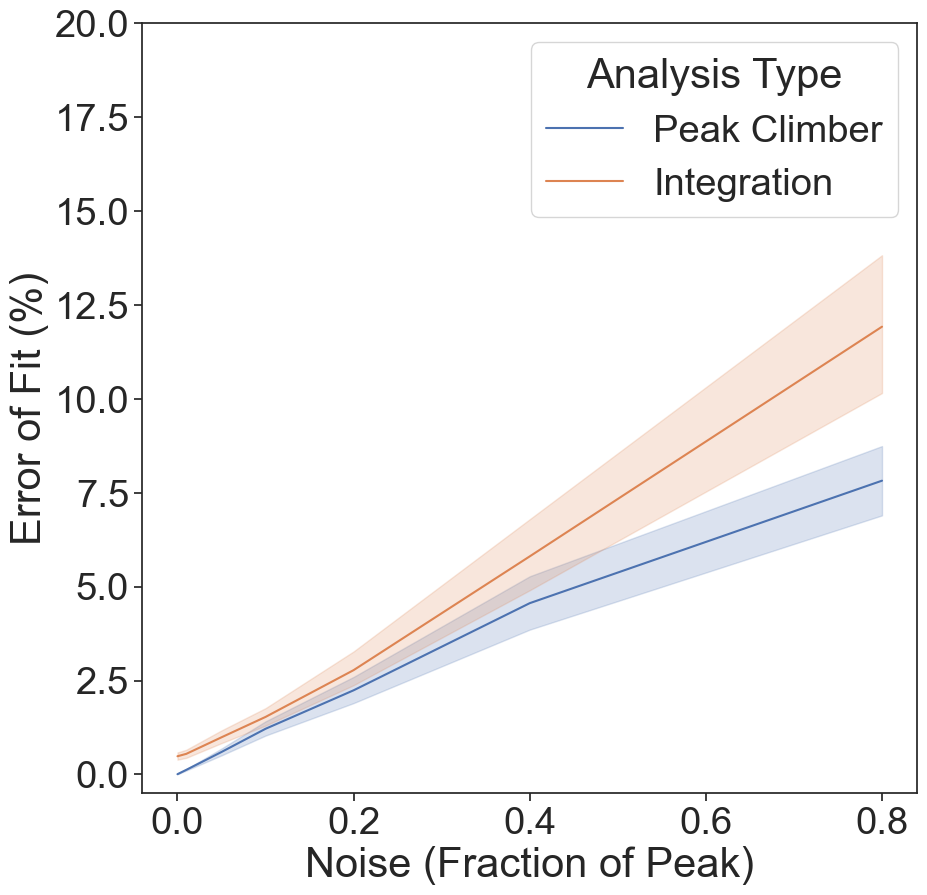

In [155]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
sns.lineplot(ax=ax,data=error_df,x="Noise",y="Error Percentage",hue="Analysis Type")
ax.set_ylabel("Error of Fit (%)")
ax.set_xlabel("Noise (Fraction of Peak)")
ax.set_ylim(-0.5,20)

[0, 0.77, 1.43, 4.09, 20]
[1.05 1.71 4.45] [0, 0.77, 1.43, 4.09, 20]


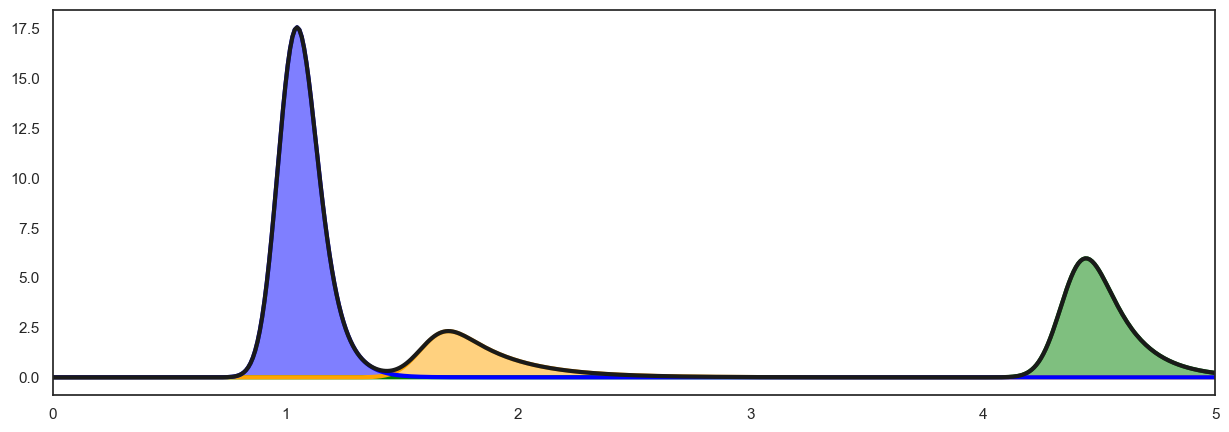

In [13]:
#figure 1 
error_list=[]
for n in range(0,1):
        amps=[]
        gammas=[]
        sigmas=[]
        center=[1]
        #Peak 1,2,3
        amps.append(4)
        amps.append(1)
        amps.append(2)
        gammas.append(random.uniform(1,3))
        gammas.append(random.uniform(1,3))
        gammas.append(random.uniform(1,3))
        sigmas.append(random.uniform(0.05,0.1))
        sigmas.append(random.uniform(0.05,0.1))
        sigmas.append(random.uniform(0.05,0.1))
        center.append(max(center)+random.uniform(0.5,0.6))
        center.append(max(center)+random.uniform(2.7,2.8))
        x =np.arange(0,40,0.01)
        areas,y=_ngaussian_exp(x,amps,center,sigmas,gammas,noise='None')
        #k=pybaselines.whittaker.psalsa(y,lam=1e11)[0]
        #y=y-k
        #z=low_pass_filter(y,2000,500)
        #z=np.convolve(z, np.ones(10)/10, mode='same')
        """
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.plot(x,z)
        ax.plot(x,y)
        """
        df = pd.DataFrame()
        df["Time"]=x
        df["Value"]=y
        if n<5:
            graph=True
        else:
            graph=False
        centers,heights,valleys=find_locations_peaks(df,0.01,1,graph=False,shoulder=False, shoulder_cutoffs=None)

        print(centers,valleys)
        if len(valleys)>4:
            valleys=valleys[1:]
        _,y1=_ngaussian_exp(x,[amps[0]],[center[0]],[sigmas[0]],[gammas[0]],noise='None')
        y_1=y[:int(valleys[1]*100)]
        z1=np.zeros(4000-int(valleys[1]*100))
        y_1=np.concatenate((y_1,z1))

        _,y2=_ngaussian_exp(x,[amps[1]],[center[1]],[sigmas[1]],[gammas[1]],noise='None')
        y_2=y[int(valleys[1]*100):int(valleys[2]*100)]
        z1=np.zeros(int(valleys[1]*100))
        z2=np.zeros(4000-int(valleys[2]*100))
        y_2=np.concatenate((z1,y_2,z2))
        
        _,y3=_ngaussian_exp(x,[amps[2]],[center[2]],[sigmas[2]],[gammas[2]],noise='None')
        y_3=y[int(valleys[2]*100):]
        z3=np.zeros(int(valleys[2]*100))
        y_3=np.concatenate((z3,y_3))
        y1_error=0
        for i in range(len(y)):
            y1_error+=(y_1[i]-y1[i])*(y_1[i]-y1[i])
        y1_error=math.sqrt(y1_error/(valleys[1]*100-valleys[0]*100))
        
        y2_error=0
        for i in range(len(y)):
            y2_error+=(y_2[i]-y2[i])*(y_2[i]-y2[i])
        y2_error=math.sqrt(y2_error/(len(y)))
        
        y3_error=0
        for i in range(len(y)):
            y3_error+=(y_3[i]-y3[i])*(y_3[i]-y3[i])
        y3_error=math.sqrt(y3_error/(len(y)))
        
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.fill_between(x,y_3,color="green",alpha=0.5)
        ax.fill_between(x,y_1,color='blue',alpha=0.5)
        ax.fill_between(x,y_2,color='orange',alpha=0.5)
        ax.plot(x,y3,color="green",linewidth=3)
        ax.plot(x,y2,color="orange",linewidth=3)
        ax.plot(x,y1,color="blue",linewidth=3)
        ax.plot(x,y,color="k",linewidth=3)
        
        #ax.plot(x,y_3,color='blue')
        ax.set(xlim=(0,5))
        error_list.append({"Peak Number":1,"RMSE":y1_error})
        error_list.append({"Peak Number":2,"RMSE":y2_error})
        error_list.append({"Peak Number":3,"RMSE":y3_error})


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.923e-04 U_stat=9.900e+01
1 v.s. 3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.653e-04 U_stat=1.000e+02


(<Axes: xlabel='Peak Number', ylabel='Fit Error(RMSE)'>,
  <statannot.StatResult.StatResult at 0x7fe0c20e13a0>])

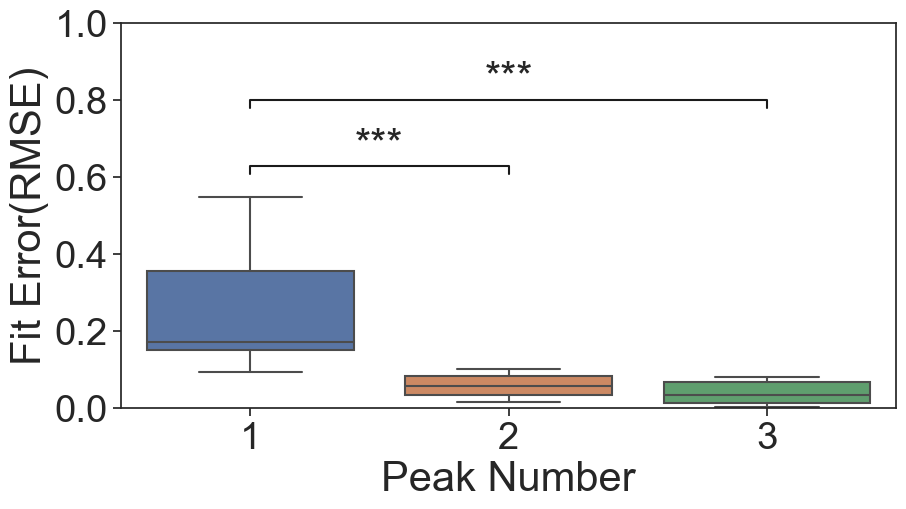

In [31]:
dataframe=pd.DataFrame(error_list)
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=2.5)
sns.set_style("ticks")

fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.boxplot(data=dataframe,x="Peak Number",y="RMSE",ax=ax)

ax.set_ylim(0,1)
ax.set_ylabel("Fit Error(RMSE)")

box_pairs=[
    ((1),(2)),
    ((1),(3)),
   


    
]
add_stat_annotation(ax=ax,data=dataframe, x="Peak Number", y='RMSE',
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,color='k')


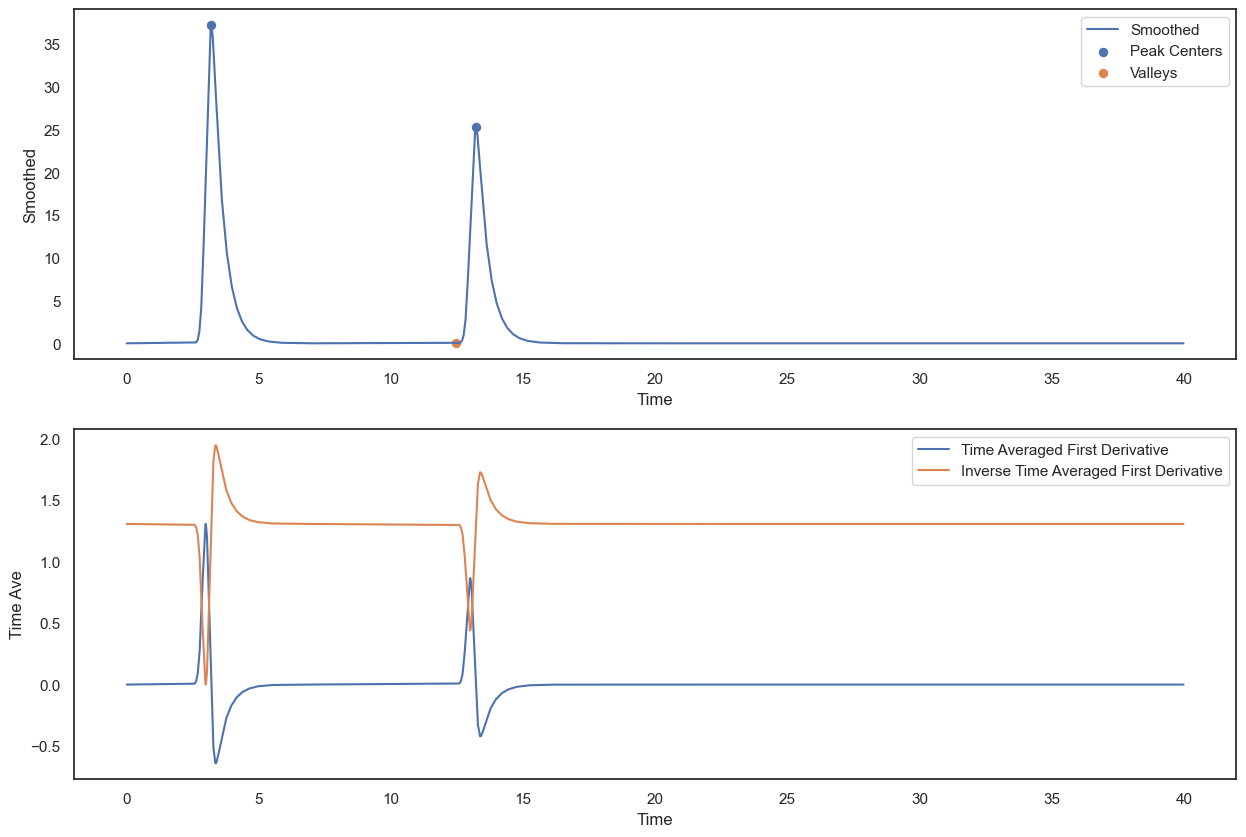

[0, 12.46, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
6.483278130179561 1.782164597378534 2.1658341969096224e-05
0.511922521076061
0.5119231915087439
1.3014720447713874e-10
[0, 12.57, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
6.499128228110744 1.7865215728838497 2.010101533345858e-05
130.08237130672381
130.08249973772575
3.325809265029878e-10
[0, 12.6, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
8.99161306133696 2.471671606391023 1.862080491120898e-05
3.791645104011972e-07
3.790218891308848e-07
8.466024505125912e-11
[0, 12.46, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
9.895326747516291 2.7200901542794003 2.1758740897793814e-05
998.8411693389478
998.7629803916494
1.4147425234175646e-12
[0, 2.59, 12.6, 20]
[0, 2.59, 12.6, 20]
[0, 2.59, 12.6, 20]
11.711629635510642 2.980143774226865 0.00012443416006107112
1.8732403341742658
1.8732403317993354
1.2030964099225517e-10


245.6580166790014
245.6570095899203
1.5613579944407882e-10
[0, 12.68, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
8.115593936985494 2.2308659154224584 2.983193556169317e-05
15.059408936809675
15.05941687109129
9.097417814953044e-12
[0, 12.57, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
10.402899867601258 2.859615071580414 1.71153544496355e-05
421.5063298059427
421.49386393594136
3.09909837319256e-11
[0, 12.6, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
10.116402546996769 2.78086087160752 2.6430643651585404e-06
1.2161343339980039e-09
1.2162028697063266e-09
2.553973459535143e-11
[0, 12.620000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
7.553328008329476 2.0763066921459354 5.4830043763188355e-06
1.9089435093893053e-05
1.908909904425612e-05
8.629542460169835e-11
[0, 12.59, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
10.9072673313505

3.328728991935098e-07
3.328200632555377e-07
5.46334199639565e-13
[0, 12.59, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
8.548490154298443 2.3498631722690724 1.3541015168118536e-05
2.9348156616709908e-08
2.934631575671551e-08
1.194960101358905e-09
[0, 12.450000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
8.002545151818383 2.1997903487236887 2.0398838438402985e-05
196.31794892995404
196.3179486568772
3.7744003403383364e-11
[0, 12.51, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
8.871906718353651 2.4387659679435147 1.4591869113677768e-05
243.03341587600494
243.03341592009548
7.316550471998102e-11
[0, 2.59, 12.5, 20]
[0, 2.59, 12.5, 20]
[0, 2.59, 12.5, 20]
11.248190834008255 2.8622170356547234 3.105323668674049e-05
282.35953635920674
282.3595360780638
9.500011773094079e-11
[0, 12.44, 20]
[0, 3.0225, 8.030000000000001, 20]
[0, 3.0225, 8.030000000000001, 20]
10.687073454699043 2.937730508862504

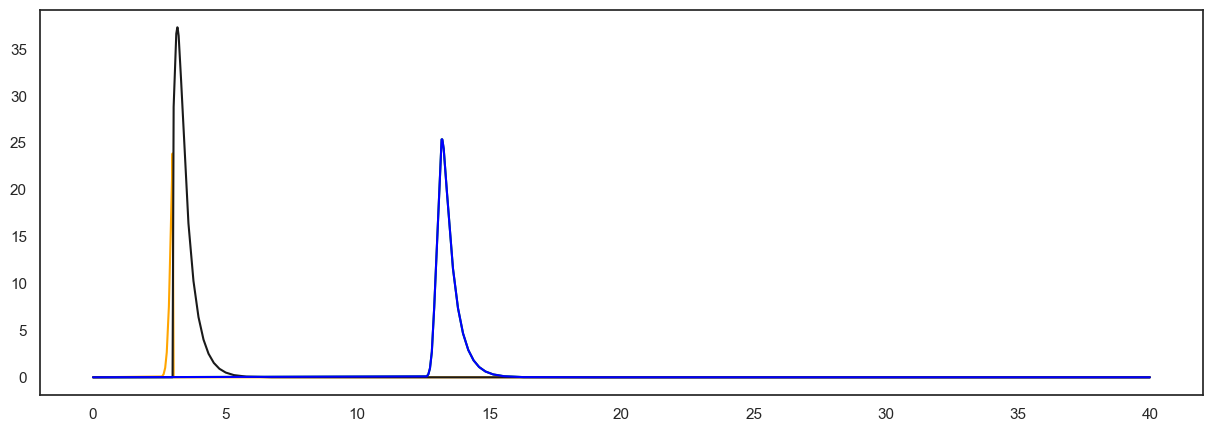

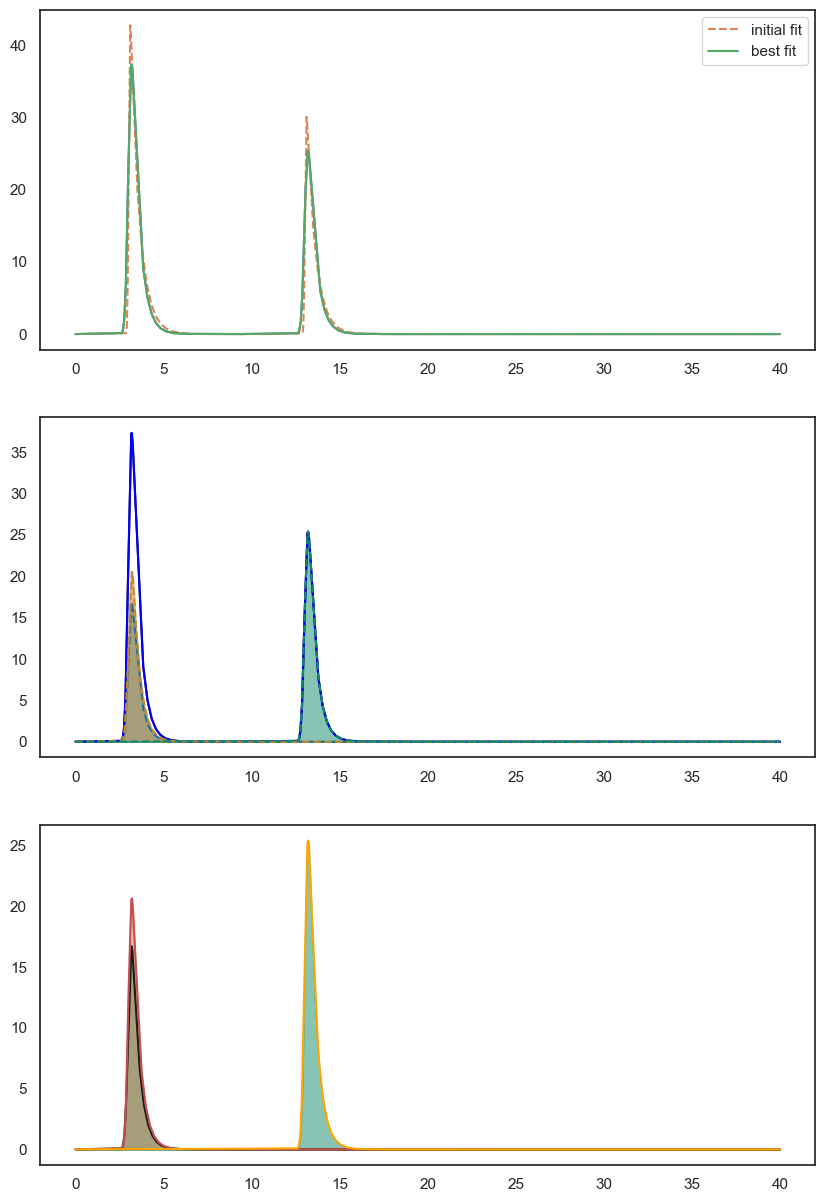

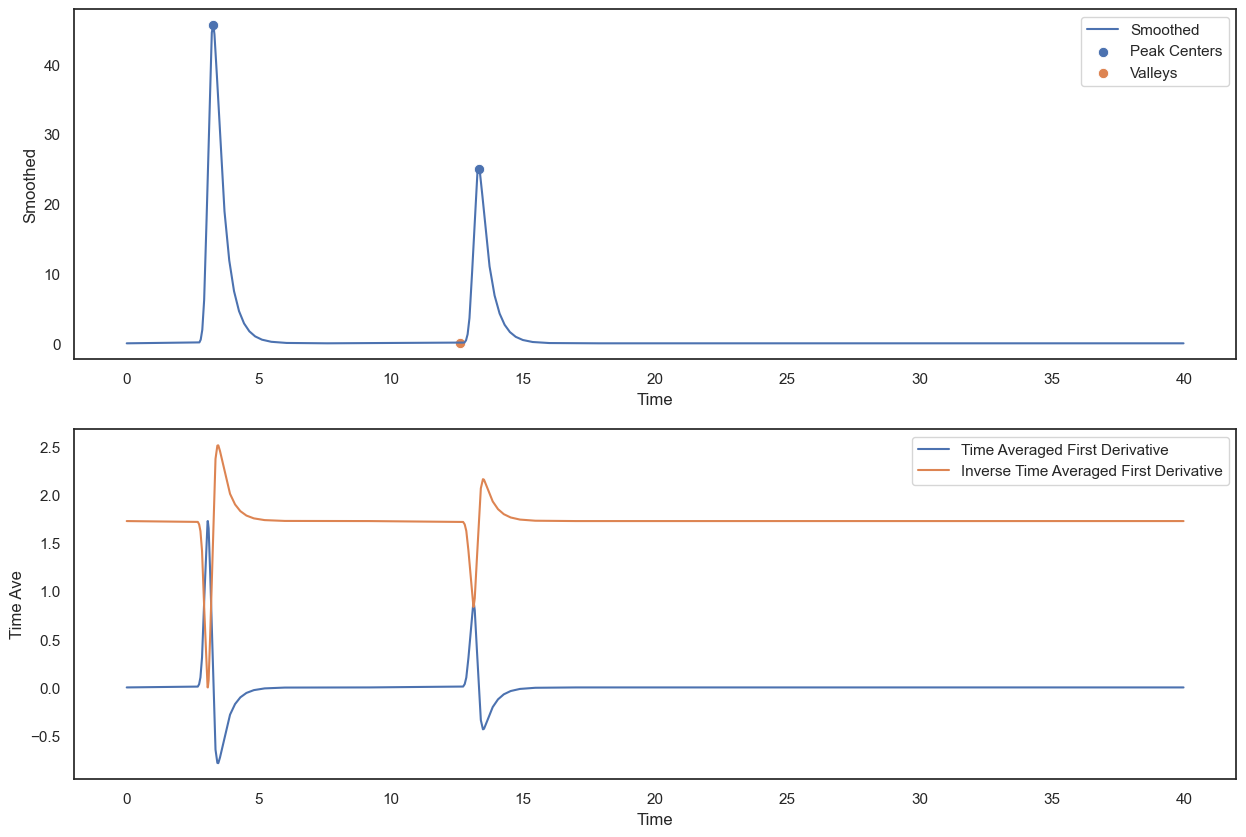

[0, 12.620000000000001, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
8.014300016299549 2.235580334678126 2.5130595797198342e-05
295.5754370848558
295.57569033906077
8.204554624685909e-12
[0, 12.790000000000001, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
6.311289920344057 1.7605275073949542 2.2088613214577362e-05
4.59611548603309e-05
4.59612688578364e-05
1.376589871042444e-10
[0, 2.69, 12.71, 20]
[0, 2.69, 12.71, 20]
[0, 2.69, 12.71, 20]
9.811082641951774 2.5442693045673668 6.187902155805324e-05
171.9555705302497
171.9555801031223
5.594701646407008e-11
[0, 2.7, 12.69, 20]
[0, 2.7, 12.69, 20]
[0, 2.7, 12.69, 20]
6.7957142407539965 1.7655783519863775 6.456649824640148e-05
66.02073721361717
66.02073771685279
1.9333004741348425e-10
[0, 2.72, 12.71, 20]
[0, 2.72, 12.71, 20]
[0, 2.72, 12.71, 20]
11.086921095485145 2.8911153078521 7.500548705619844e-05
2405.231288655826
2405.231288656001
5.769189940534258e-12
[0, 12.700000000000001, 20]
[

90.7443240601965
90.74434232512593
1.4103857727919873e-11
[0, 2.74, 12.63, 20]
[0, 2.74, 12.63, 20]
[0, 2.74, 12.63, 20]
8.802039109749034 2.303714096054492 2.8738194351999285e-05
1501.8745380399985
1501.8744789485256
5.832042667864583e-11
[0, 12.56, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
8.837294248147277 2.465153686730455 2.2850421687178174e-06
311.46644412738726
311.466402997588
2.428385181655092e-11
[0, 12.63, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
6.184371672428521 1.7251237992343282 6.2794679157594645e-06
216.75798945139638
216.75729072734654
1.9266769096315393e-11
[0, 12.71, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
9.44741969440788 2.6353475210634856 1.7436960945959658e-06
5.168462771157807e-06
5.1683719987067006e-06
1.3368644505903148e-10
[0, 12.57, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
7.686405300512861 2.1441144575532514 2.4225668516720882e-05
575

1.9903503646160223e-08
1.979787760824509e-08
4.2760960031293523e-11
[0, 12.81, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
6.512639860145648 1.8166938560160373 3.992835335041084e-05
94.42965357119779
94.42968114429664
4.805564651960232e-12
[0, 2.75, 12.700000000000001, 20]
[0, 2.75, 12.700000000000001, 20]
[0, 2.75, 12.700000000000001, 20]
10.06750525987441 2.6397221496543035 6.35657830009438e-05
2239.8115102266433
2239.811510226661
1.7137510027757738e-11
[0, 12.530000000000001, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
6.9448149851542995 1.9372486400924103 2.2184661899570728e-06
1.820500191033659e-05
1.820511196008806e-05
2.641375456779518e-11
[0, 12.72, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]
6.975534986045812 1.9458179511602445 5.79105404004781e-06
3.459632502449361e-05
3.45963266714478e-05
9.650253282000636e-11
[0, 12.71, 20]
[0, 3.1125000000000003, 8.15, 20]
[0, 3.1125000000000003, 8.15, 20]


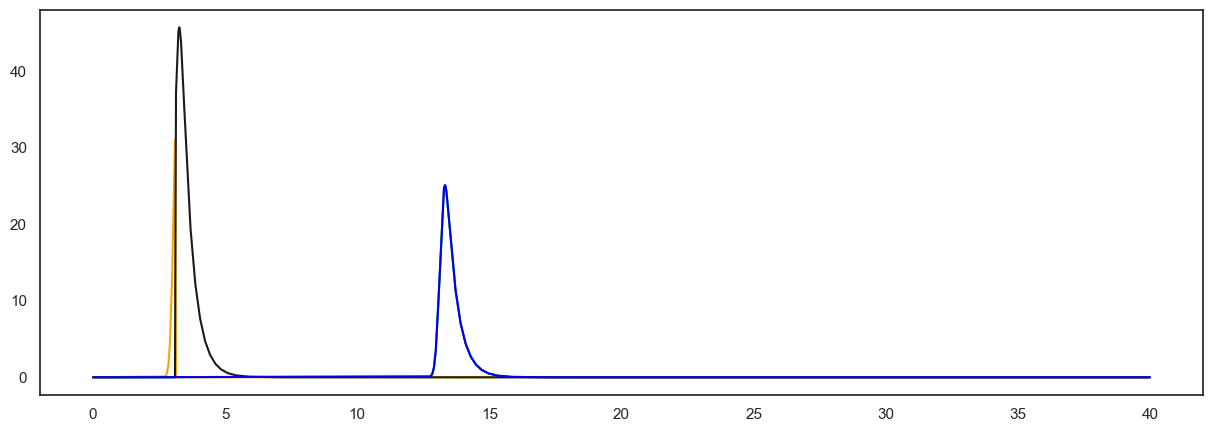

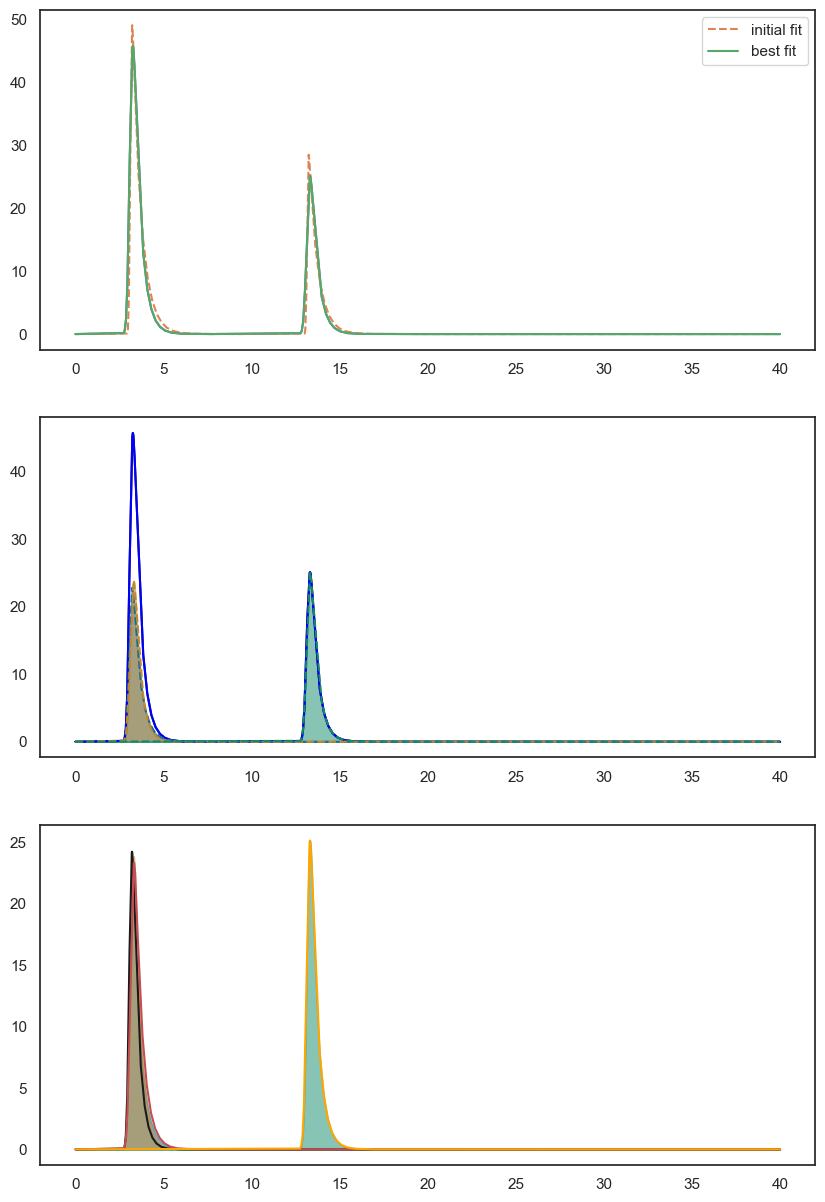

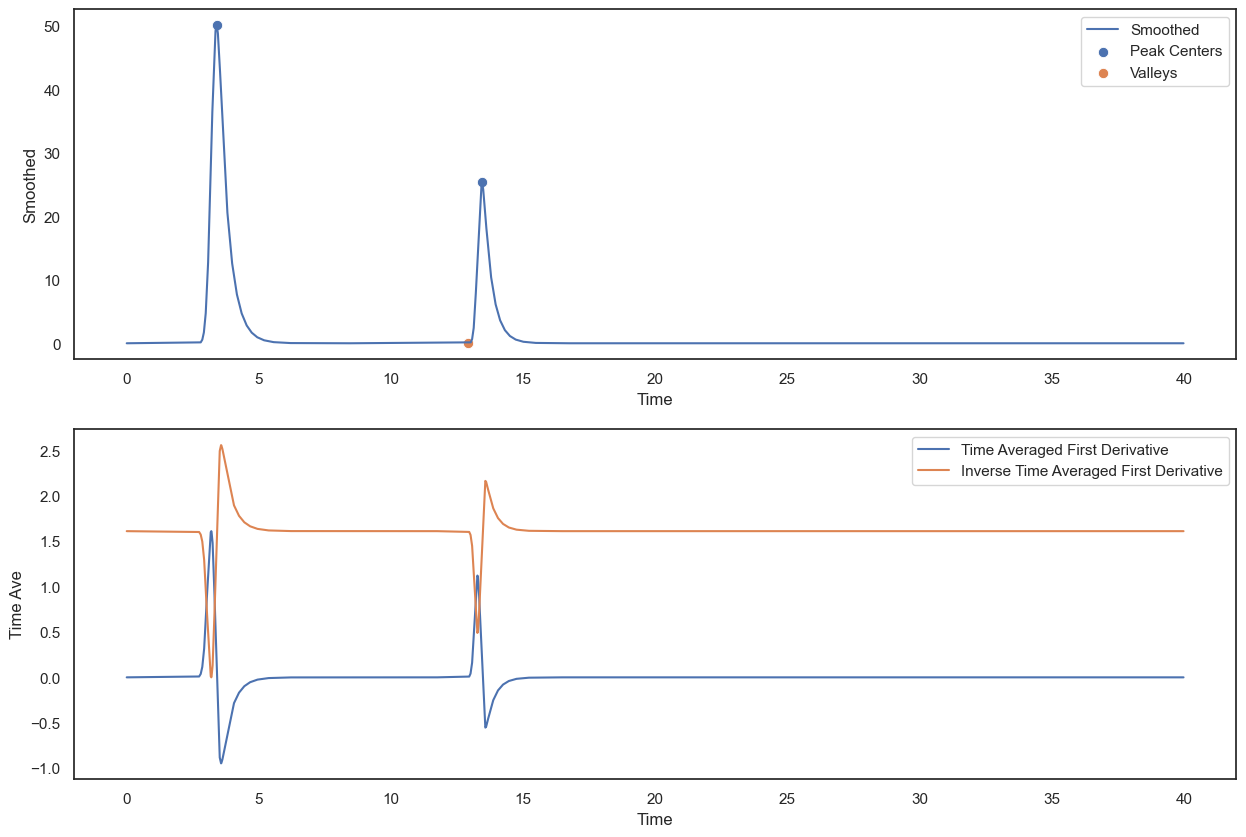

[0, 12.92, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
8.8045708881875 2.5000175548986032 8.269714293342803e-06
173.18743021550677
173.1873404201451
3.551594798099436e-10
[0, 12.94, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
6.240355972441908 1.7719204806321198 2.949664102059164e-06
83.31204673316313
83.31205470594497
4.332929448220606e-12
[0, 2.7800000000000002, 12.91, 20]
[0, 2.7800000000000002, 12.91, 20]
[0, 2.7800000000000002, 12.91, 20]
8.654785333591127 2.2816483112875576 0.00017043636192048405
3.9327234585038894e-08
3.9327891147380214e-08
9.643504017720495e-11
[0, 2.82, 12.93, 20]
[0, 2.82, 12.93, 20]
[0, 2.82, 12.93, 20]
10.52311337605653 2.794079827918636 0.00026162067036476116
248.55043930742903
248.55398338436962
9.491921868004097e-10
[0, 2.77, 12.71, 20]
[0, 2.77, 12.71, 20]
[0, 2.77, 12.71, 20]
10.594618509095412 2.7880156812638996 1.6114063307288897e-05
1.1911582645832673e-09
1.1902970618994417e-09
6.803050649782621e-1

2.0551650596233399e-10
2.1569511397398532e-10
2.3446736119047425e-10
[0, 12.93, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
6.19451842265207 1.758905118430312 5.197783417914782e-06
34.32072891459119
34.32072931596976
3.5690394759545596e-10
[0, 12.780000000000001, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
9.015147807828605 2.5598099062247903 7.76853991969026e-06
1.1855614360979737e-07
1.1855270706696482e-07
4.195814953590658e-11
[0, 12.84, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
6.780597091302574 1.925319470769468 2.9469478459416162e-05
7.292987735733208e-08
7.291499042357712e-08
1.1166924765898309e-11
[0, 12.74, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
8.525209145386293 2.4206940682295253 2.0144530518667437e-05
116.87060300095143
116.87059043497013
1.929975205730555e-11
[0, 12.88, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
7.666745617145381 2.17693

168.3360975026745
168.3388046554315
9.673083191119786e-11
[0, 12.94, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
4.8160035249600055 1.3674821305241835 1.1904289981768549e-05
4.1552596148654274e-08
4.153251954318827e-08
7.65618957389738e-11
[0, 12.73, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
5.05350424902845 1.4349193727927565 3.294986228831158e-05
3.181749909490437e-09
3.1921854114053012e-09
2.708218770958653e-10
[0, 2.75, 12.82, 20]
[0, 2.75, 12.82, 20]
[0, 2.75, 12.82, 20]
12.44643272949052 3.263482194212763 5.7224319628206714e-05
2.169732022911611e-09
2.1681344049733773e-09
1.1633677161313868e-10
[0, 12.69, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
5.338783720915546 1.5159231715061225 1.3592465510530488e-05
80.7812029734601
80.78149959453552
1.2613272512527443e-10
[0, 12.75, 20]
[0, 3.2249999999999996, 8.3, 20]
[0, 3.2249999999999996, 8.3, 20]
8.61918864408883 2.447379116200233 5.3357256045908004e-05


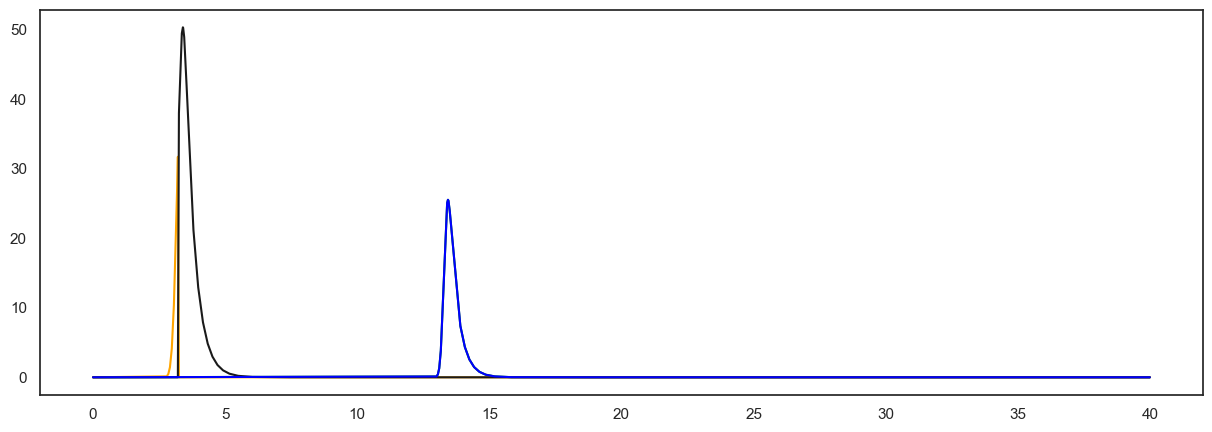

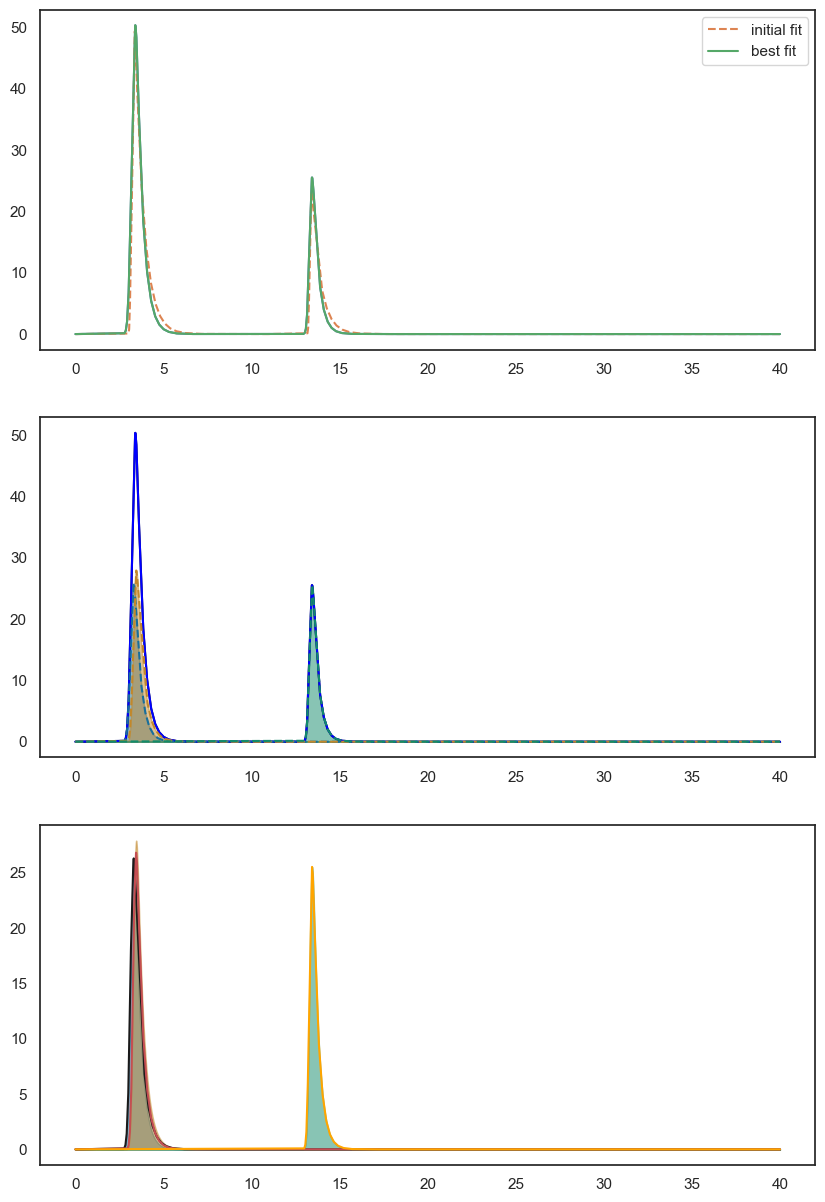

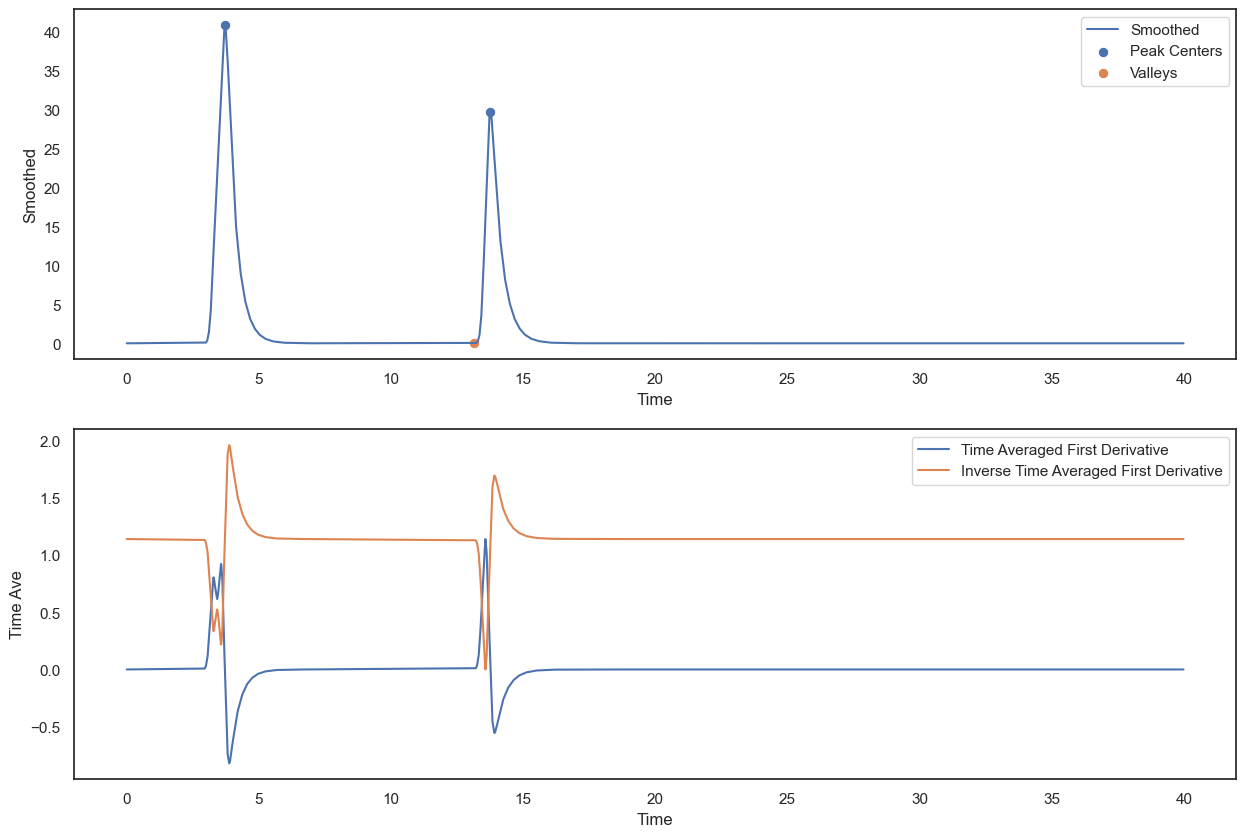

[0, 13.13, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
4.7910687661012314 1.4070578588788785 2.088950105655783e-06
1.2616241221083233e-09
1.267386184379375e-09
9.71396834026599e-12
[0, 13.09, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
6.401515639257996 1.8800195381138496 1.3710961855826138e-05
8.15467249055224e-11
8.32633507130402e-11
4.7207864307459876e-12
[0, 13.01, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
5.779748645460659 1.6974168293046394 1.2607799439361144e-06
8.560794563880554e-10
8.563161978707899e-10
4.226365960782373e-12
[0, 2.94, 13.25, 20]
[0, 2.94, 13.25, 20]
[0, 2.94, 13.25, 20]
10.826779677685956 2.9352356318709374 0.00029614521860374436
54.739108099223095
54.738809947818936
1.644779897451679e-10
[0, 13.26, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
6.135097534732513 1.8017769360356135 2.3291932294298783e-05
7.045732422759383e-10
7.046804737209732e-10
3.998529928

1.9794053794119465e-09
1.895659353721494e-09
1.0961877955895247e-10
[0, 13.26, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
6.566118842900689 1.928360783630803 4.26231499456544e-06
24.041825788951048
24.041817959301707
1.0603791711925566e-10
[0, 2.91, 13.120000000000001, 20]
[0, 2.91, 13.120000000000001, 20]
[0, 2.91, 13.120000000000001, 20]
11.840884736590484 3.193748051042319 5.631830917492298e-05
253.84427798653226
253.84612199065944
3.5235175213703276e-10
[0, 13.17, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
6.884329859982883 2.021814109860847 6.00559882531461e-06
18.725071783479848
18.725062724035432
3.486297632658628e-11
[0, 13.120000000000001, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
5.052352002808977 1.4837924351521432 8.612352605897505e-06
1.1320590464657216e-08
1.1312725676993687e-08
2.6087301166731313e-11
[0, 13.14, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
4.40654282

8.367116148612322e-08
8.39937605433629e-08
4.211343240614018e-10
[0, 13.24, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
7.415964337082499 2.1779463854864427 1.0002896249643335e-05
1.5522232643924563e-09
1.5516222913745808e-09
7.310470102216422e-13
[0, 13.24, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
6.120571113815544 1.7975107657492113 2.3585911537539412e-06
1.030494767028753e-10
1.3422779628241407e-10
6.919878485922438e-10
[0, 2.93, 13.0, 20]
[0, 2.93, 13.0, 20]
[0, 2.93, 13.0, 20]
11.903194843197465 3.221568403403656 1.6001298355265615e-05
3.58439864845501e-11
3.5633446687568e-11
3.519766815785918e-11
[0, 2.95, 13.030000000000001, 20]
[0, 2.95, 13.030000000000001, 20]
[0, 2.95, 13.030000000000001, 20]
9.795149148995133 2.660063877191076 2.170568322074296e-05
2.9474942955404034e-10
2.9482751540813784e-10
3.1823527397492984e-10
[0, 13.14, 20]
[0, 3.4499999999999997, 8.6, 20]
[0, 3.4499999999999997, 8.6, 20]
7.607485311809229 2.23419

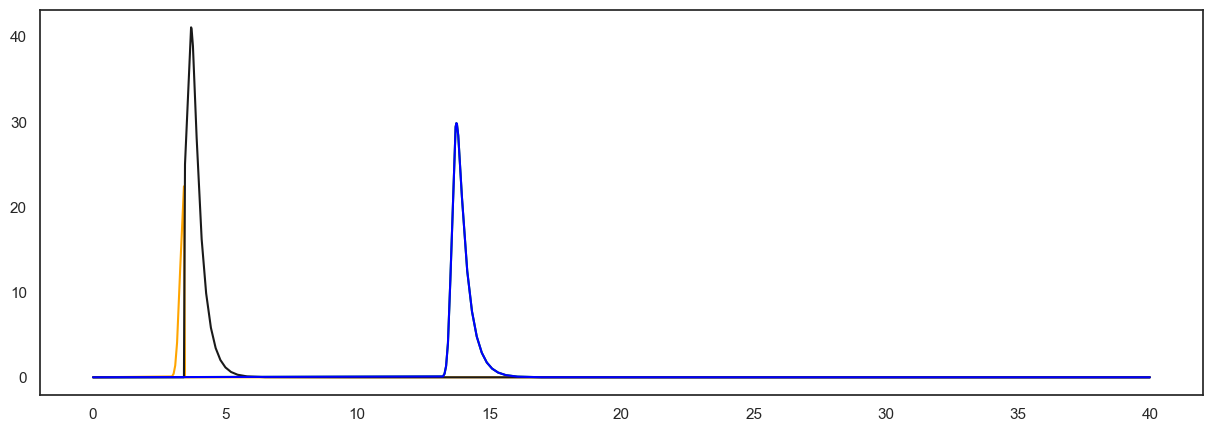

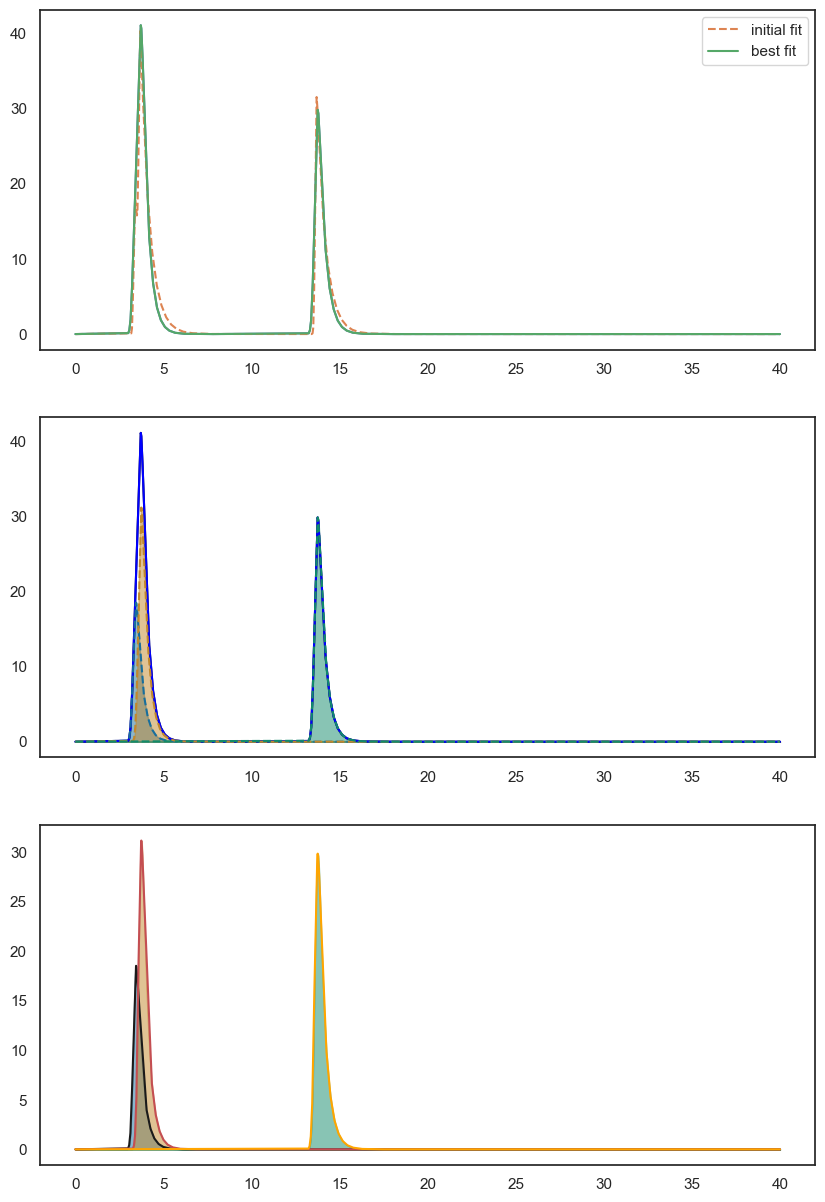

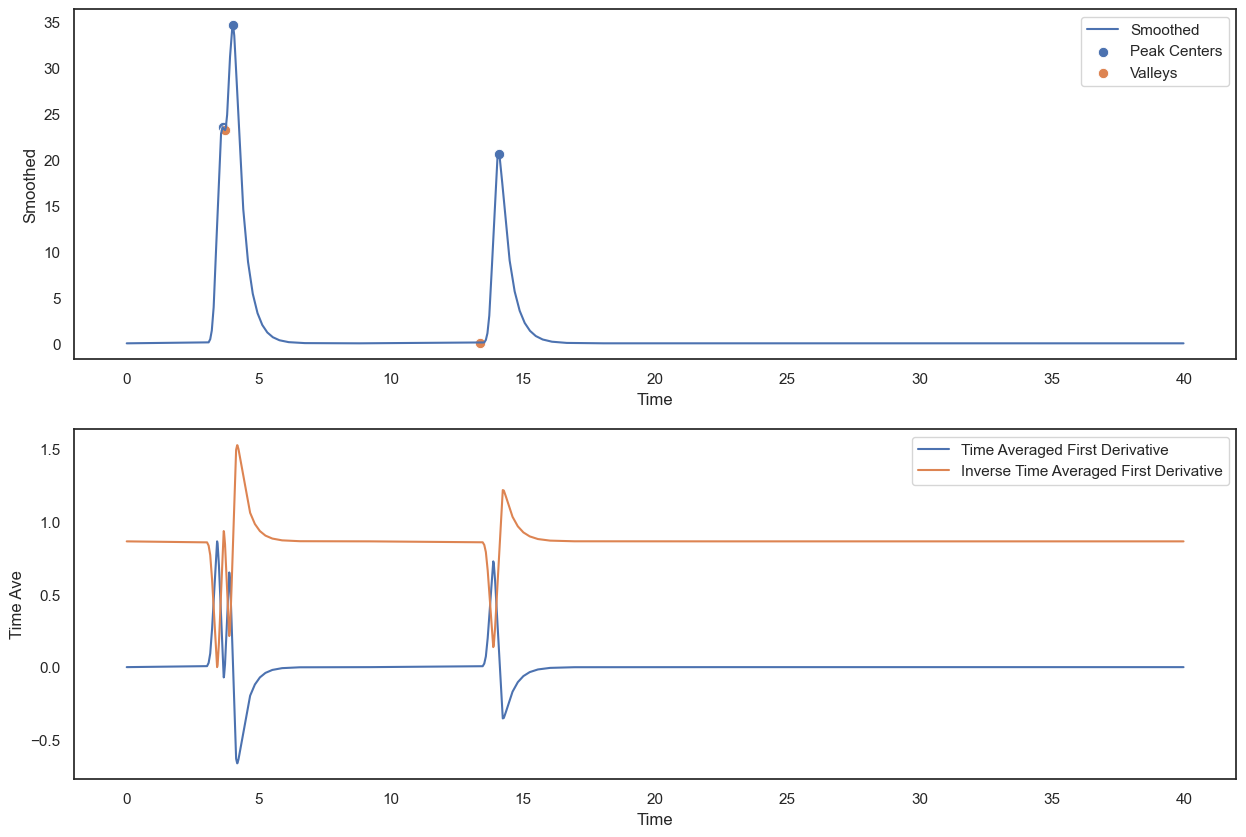

[0, 3.71, 13.36, 20]
[0, 3.71, 13.36, 20]
[0, 3.71, 13.36, 20]
5.0448860491661405 1.5364142279752526 2.394665793049302e-05
1.5988024170164918e-11
4.255248911252377e-12
3.482789626806421e-11
[0, 3.08, 3.77, 13.290000000000001, 20]
[3.08, 3.77, 13.290000000000001, 20]
[3.08, 3.77, 13.290000000000001, 20]
11.167313669715723 1.4667066618388247 8.366535576169887e-06
9.278259853007463e-10
9.235156177275234e-10
4.256068761971138e-11
[0, 3.73, 13.52, 20]
[0, 3.73, 13.52, 20]
[0, 3.73, 13.52, 20]
4.165658183077987 1.2720613411797996 0.00015988383832948457
1.317600493493299e-09
1.3118016675970285e-09
1.0296572205020434e-10
[0, 13.55, 20]
[0, 3.6750000000000003, 8.9, 20]
[0, 3.6750000000000003, 8.9, 20]
5.070377109708736 1.5368763842943332 1.1268042590728764e-05
3.913107747494584e-11
3.839163088476971e-11
1.3132992066983903e-10
[0, 3.08, 3.71, 13.46, 20]
[3.08, 3.71, 13.46, 20]
[3.08, 3.71, 13.46, 20]
8.68654631862157 1.0901529127443053 6.141949624581902e-05
1.3494942094719618e-10
1.4006647862800

1.132401214168555e-10
1.1606719580186765e-10
7.876459957212425e-11
[0, 3.09, 3.7600000000000002, 13.56, 20]
[3.09, 3.7600000000000002, 13.56, 20]
[3.09, 3.7600000000000002, 13.56, 20]
8.844576356021152 1.144680957387412 0.00031833540668426384
5.955946079928891e-12
1.161707471114037e-11
7.964870445024609e-10
[0, 13.48, 20]
[0, 3.6750000000000003, 8.9, 20]
[0, 3.6750000000000003, 8.9, 20]
5.150501617839861 1.561162835121013 1.0840429082260387e-05
5.480194124784301e-11
5.5758394842181546e-11
1.2940014443096522e-11
[0, 3.75, 13.33, 20]
[0, 3.75, 13.33, 20]
[0, 3.75, 13.33, 20]
5.569267172101837 1.7052328516546262 1.2292963133264479e-05
4.085325726630925e-10
4.244505545576814e-10
1.5463470481632226e-11
[0, 13.36, 20]
[0, 3.6750000000000003, 8.9, 20]
[0, 3.6750000000000003, 8.9, 20]
4.277518773481525 1.2965539732103073 2.6051128292338306e-05
7.017867293364535e-09
7.022391936912999e-09
3.669884271517202e-11
[0, 3.7800000000000002, 13.31, 20]
[0, 3.7800000000000002, 13.31, 20]
[0, 3.7800000000

5.22454274169144e-11
5.210256489884505e-11
1.8845036124521063e-12
[0, 13.52, 20]
[0, 3.6750000000000003, 8.9, 20]
[0, 3.6750000000000003, 8.9, 20]
6.486905813692594 1.9662388293386512 1.3691026360188717e-05
3.018339143290083e-09
3.0214134424611446e-09
8.016848734577052e-14
[0, 3.09, 3.7800000000000002, 13.280000000000001, 20]
[3.09, 3.7800000000000002, 13.280000000000001, 20]
[3.09, 3.7800000000000002, 13.280000000000001, 20]
8.421601476588727 1.1060868669614716 9.425498285670187e-06
1.0226043229472186e-10
1.03032256267614e-10
2.385364100274577e-10
[0, 13.39, 20]
[0, 3.6750000000000003, 8.9, 20]
[0, 3.6750000000000003, 8.9, 20]
5.375707408328364 1.6294247126189716 5.649121505775459e-06
3.929984217839848e-10
3.9390700338137306e-10
2.3848577373130476e-11
[0, 13.530000000000001, 20]
[0, 3.6750000000000003, 8.9, 20]
[0, 3.6750000000000003, 8.9, 20]
4.991777192476467 1.513052050546272 1.2467792536299072e-05
6.379228898071934e-10
6.403057621005884e-10
6.036378565319483e-11
[0, 3.1, 3.7600000

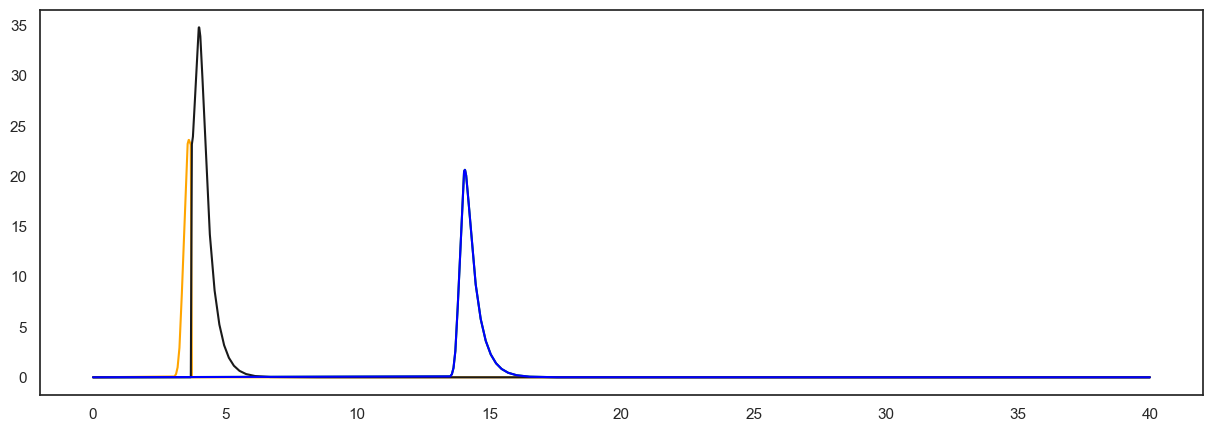

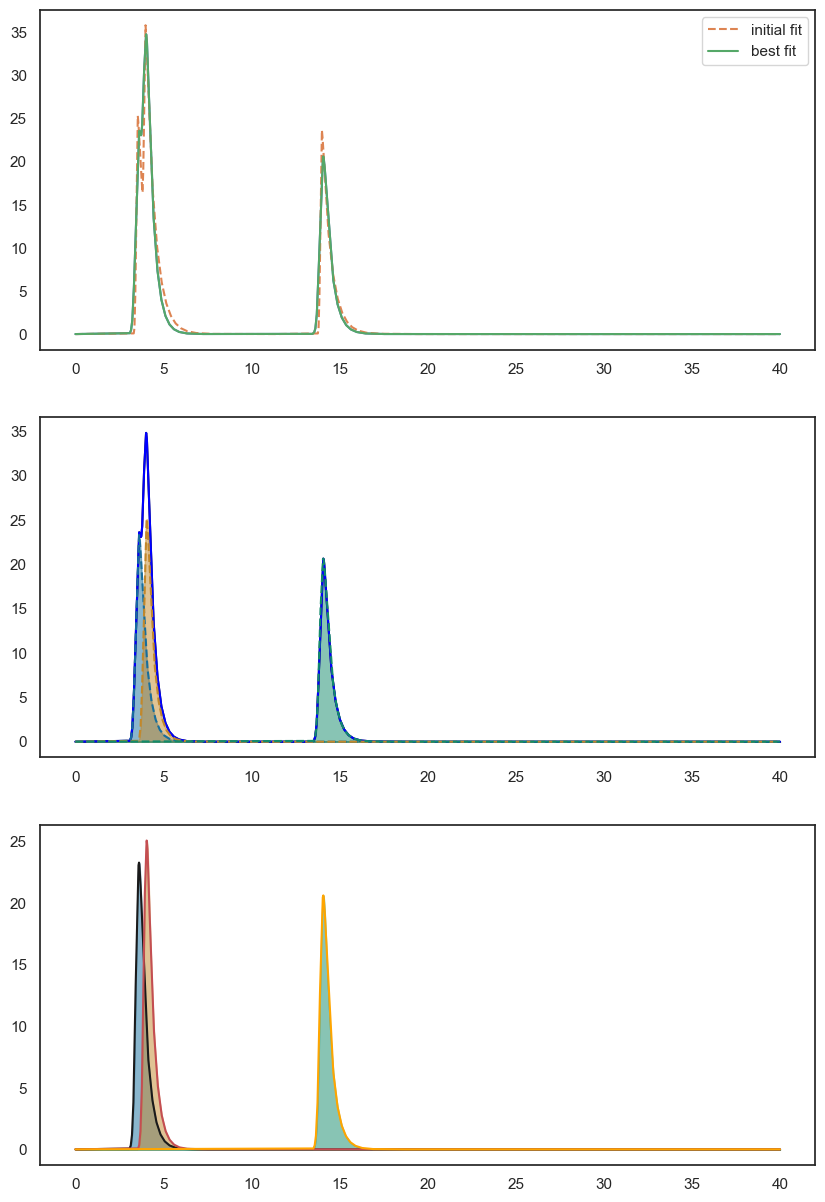

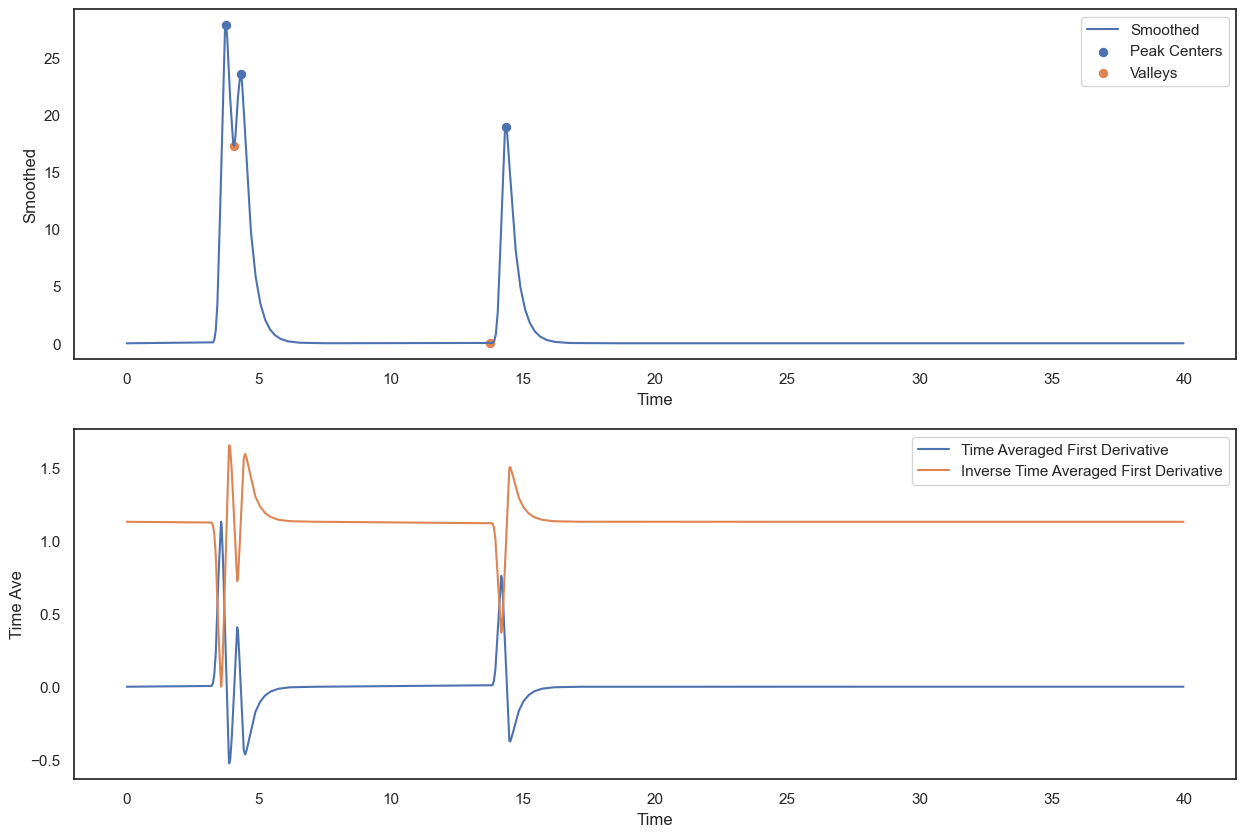

[0, 4.0600000000000005, 13.76, 20]
[0, 4.0600000000000005, 13.76, 20]
[0, 4.0600000000000005, 13.76, 20]
3.016778937989352 0.9611175541592969 6.405066873340166e-05
4.373875949996731e-11
4.2377669444563495e-11
5.428438362959979e-11
[0, 4.04, 13.69, 20]
[0, 4.04, 13.69, 20]
[0, 4.04, 13.69, 20]
3.3785354494647954 1.0737153634343426 3.953002500281733e-05
6.17194485404791e-12
5.316716073666877e-11
7.34574479487228e-11
[0, 4.04, 13.63, 20]
[0, 4.04, 13.63, 20]
[0, 4.04, 13.63, 20]
3.9538895284826157 1.2565657496590892 2.1642682817267972e-05
3.9502053522822554e-10
3.931609820125955e-10
2.76863051544092e-11
[0, 4.01, 13.64, 20]
[0, 4.01, 13.64, 20]
[0, 4.01, 13.64, 20]
1.995041432229041 0.6316756127783917 2.3850131538104292e-05
3.018029217216966e-10
3.3911469733683404e-10
1.617564964776881e-10
[0, 4.0200000000000005, 13.61, 20]
[0, 4.0200000000000005, 13.61, 20]
[0, 4.0200000000000005, 13.61, 20]
3.1838355886918084 1.009331120220613 1.1654843857061936e-05
3.8594780101954645e-10
3.811578639147

3.112524499303298e-10
3.3880666543072124e-10
2.786427251050056e-11
[0, 4.01, 13.81, 20]
[0, 4.01, 13.81, 20]
[0, 4.01, 13.81, 20]
2.9430892154294592 0.9318491744120319 0.0001652941972446558
2.6031064666298927e-10
2.654263732172916e-10
1.3466633690422188e-10
[0, 4.01, 13.61, 20]
[0, 4.01, 13.61, 20]
[0, 4.01, 13.61, 20]
3.6049804487568893 1.1414190180479136 1.2670480754585007e-05
1.2153486243454457e-10
1.4943248356895746e-10
3.0716872770927026e-12
[0, 3.23, 4.0200000000000005, 13.75, 20]
[3.23, 4.0200000000000005, 13.75, 20]
[3.23, 4.0200000000000005, 13.75, 20]
7.5668547776958475 1.0634056175196451 7.512823990171986e-05
2.3792132970889407e-10
2.0966166671140324e-10
9.413396589972615e-11
[0, 3.99, 13.6, 20]
[0, 3.99, 13.6, 20]
[0, 3.99, 13.6, 20]
2.300865771243784 0.7266875766577827 1.284349307134913e-05
1.1694263360808656e-09
1.1855619953633493e-09
3.5798946728118107e-12
[0, 4.04, 13.700000000000001, 20]
[0, 4.04, 13.700000000000001, 20]
[0, 4.04, 13.700000000000001, 20]
3.180600637092

[0, 3.25, 4.0, 13.74, 20]
[3.25, 4.0, 13.74, 20]
[3.25, 4.0, 13.74, 20]
4.925169217373007 0.6744065719379896 5.150414056335741e-05
1.8844121237293686e-12
3.726509912732004e-12
5.978650413741268e-11
[0, 4.0200000000000005, 13.75, 20]
[0, 4.0200000000000005, 13.75, 20]
[0, 4.0200000000000005, 13.75, 20]
3.459194362791001 1.0966246324790203 8.82239119107549e-05
4.2410585616332934e-11
3.7848637707377155e-11
1.4207965075270234e-11
[0, 3.97, 13.86, 20]
[0, 3.97, 13.86, 20]
[0, 3.97, 13.86, 20]
2.84136167035215 0.8951417195683041 0.00029333146406186877
6.882732017375525e-11
7.160408320106082e-11
1.6011108074660785e-10
[0, 4.03, 13.77, 20]
[0, 4.03, 13.77, 20]
[0, 4.03, 13.77, 20]
2.407147793735556 0.7640561660443624 6.637883554721881e-05
3.070066275520501e-11
3.1897143585404766e-11
5.169377999176179e-11
[0, 4.0, 13.71, 20]
[0, 4.0, 13.71, 20]
[0, 4.0, 13.71, 20]
2.510666085332131 0.7939423284780207 4.177803150456916e-05
3.472737741758732e-11
4.230290645120505e-11
4.3567958427304846e-11
[0, 4.

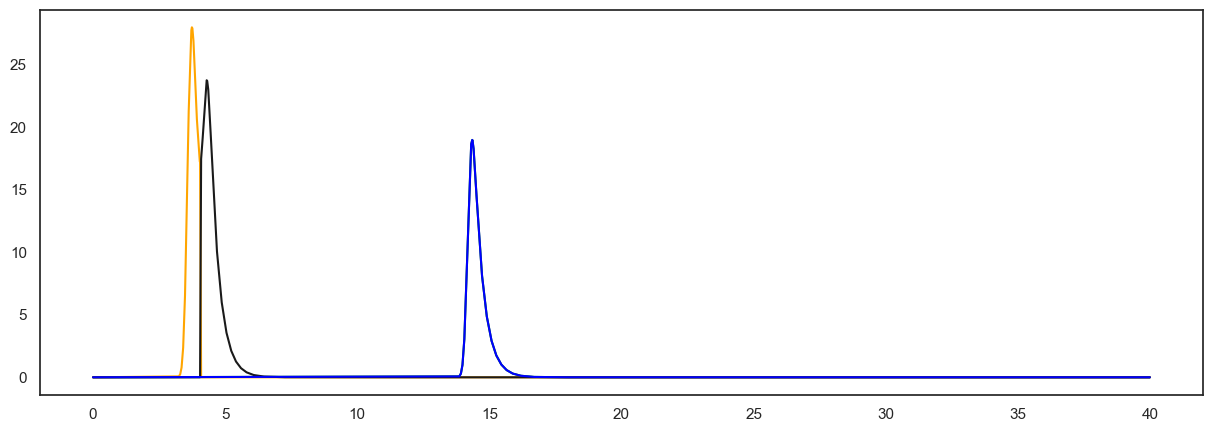

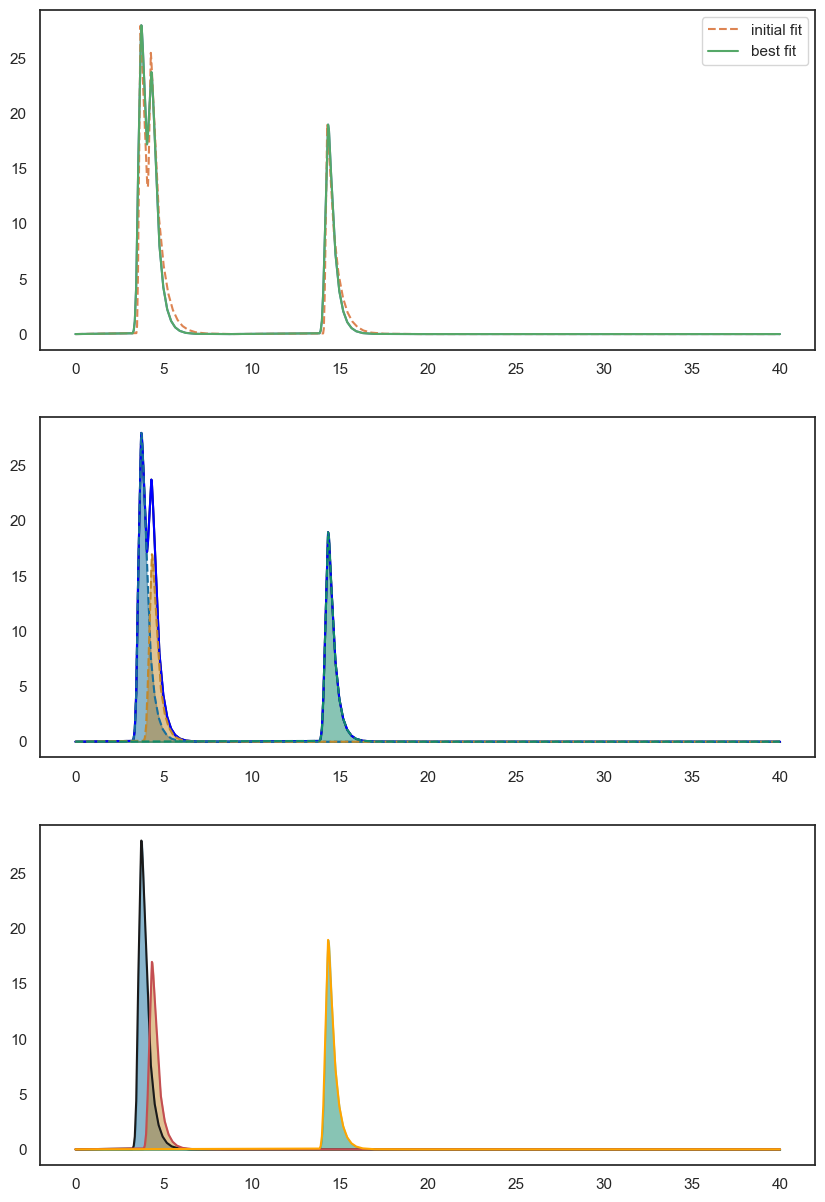

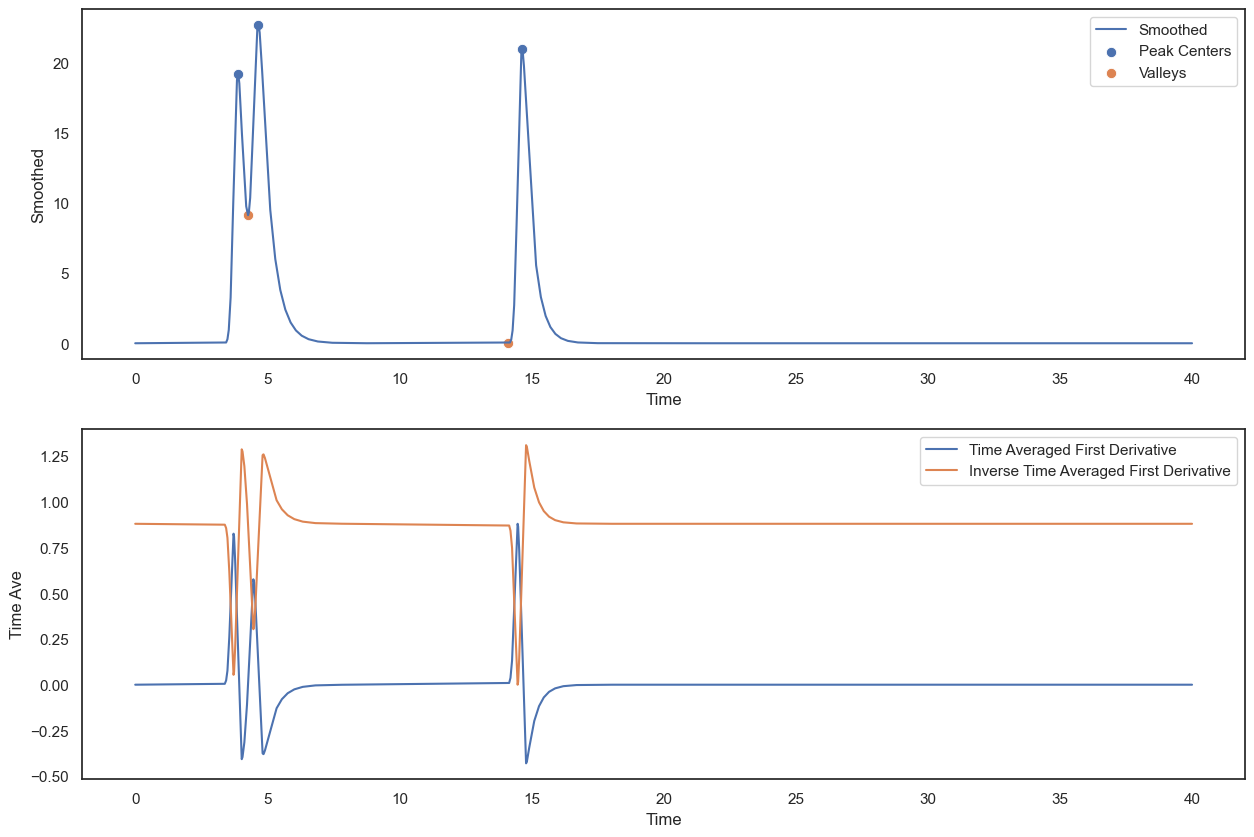

[0, 4.2700000000000005, 14.09, 20]
[0, 4.2700000000000005, 14.09, 20]
[0, 4.2700000000000005, 14.09, 20]
1.488982844024708 0.4864896941201641 9.805095946427065e-05
5.731050395589916e-11
5.883747757104072e-11
5.978341222064288e-12
[0, 4.28, 13.950000000000001, 20]
[0, 4.28, 13.950000000000001, 20]
[0, 4.28, 13.950000000000001, 20]
1.813533008612577 0.5932221435819421 2.2134192007316427e-05
2.178946752125055e-11
2.3784518375337673e-11
2.3406795117751997e-14
[0, 4.3, 14.0, 20]
[0, 4.3, 14.0, 20]
[0, 4.3, 14.0, 20]
2.4192854919784943 0.7932157955662391 4.4477935753403076e-05
9.919996714359264e-11
1.995141385732233e-10
1.241356507134693e-10
[0, 4.29, 14.08, 20]
[0, 4.29, 14.08, 20]
[0, 4.29, 14.08, 20]
1.9156706190746084 0.6273638529327028 7.721593184266793e-05
1.7732899664568336e-11
1.616618994642381e-11
4.018688604356823e-12
[0, 3.38, 4.28, 14.120000000000001, 20]
[3.38, 4.28, 14.120000000000001, 20]
[3.38, 4.28, 14.120000000000001, 20]
3.3049420444282345 0.49574132247799413 0.00012521608

3.3840483643959555e-11
1.3378530832869525e-10
4.921994748938963e-11
[0, 4.3, 13.96, 20]
[0, 4.3, 13.96, 20]
[0, 4.3, 13.96, 20]
2.117452210449586 0.6942531352964066 2.320718038787829e-05
5.556228343696114e-12
1.534682482009516e-11
2.578347226859393e-11
[0, 4.29, 14.1, 20]
[0, 4.29, 14.1, 20]
[0, 4.29, 14.1, 20]
1.7164437429933899 0.5621189634463941 0.00013468180753367992
7.040684402021989e-11
7.071138171601883e-11
7.298194318050731e-11
[0, 4.28, 13.88, 20]
[0, 4.28, 13.88, 20]
[0, 4.28, 13.88, 20]
1.7251989291577126 0.5643273110955257 1.0744581253708508e-05
6.004054361462917e-12
2.2562259280484954e-11
2.543205664475423e-10
[0, 3.38, 4.28, 13.94, 20]
[3.38, 4.28, 13.94, 20]
[3.38, 4.28, 13.94, 20]
3.9398229726722835 0.5909734461634413 1.7617536089467574e-05
3.3195619433542307e-11
2.4598710488804033e-11
1.0051432700829688e-11
[0, 4.25, 13.92, 20]
[0, 4.25, 13.92, 20]
[0, 4.25, 13.92, 20]
1.797279267827798 0.5858413665037306 1.611128181726935e-05
2.0936813525197075e-11
2.9310983965152296e

7.260297764248024e-12
1.257257233731288e-11
6.263212920584356e-11
[0, 4.28, 14.01, 20]
[0, 4.28, 14.01, 20]
[0, 4.28, 14.01, 20]
2.200106689932675 0.7196736999245946 5.937085119625753e-05
5.263196906137691e-11
6.847537300124756e-11
4.4223607813648887e-10
[0, 4.26, 13.91, 20]
[0, 4.26, 13.91, 20]
[0, 4.26, 13.91, 20]
1.7425383726920938 0.5686658581149684 1.6828954605963022e-05
5.0257941860105936e-12
8.208848594057283e-11
7.885803131701863e-11
[0, 4.2700000000000005, 13.88, 20]
[0, 4.2700000000000005, 13.88, 20]
[0, 4.2700000000000005, 13.88, 20]
2.035422694722593 0.6650258920501327 6.410945013964073e-06
3.658251774172622e-11
9.125005357908361e-11
9.109527413836124e-12
[0, 4.29, 13.98, 20]
[0, 4.29, 13.98, 20]
[0, 4.29, 13.98, 20]
1.3479069710771654 0.44142667192135376 2.6387535345299435e-05
1.7600714635116033e-12
1.434548315462857e-12
5.34335502232677e-10
[0, 4.28, 13.98, 20]
[0, 4.28, 13.98, 20]
[0, 4.28, 13.98, 20]
2.298996286576417 0.7520213305019706 3.848237763358198e-05
5.801307023

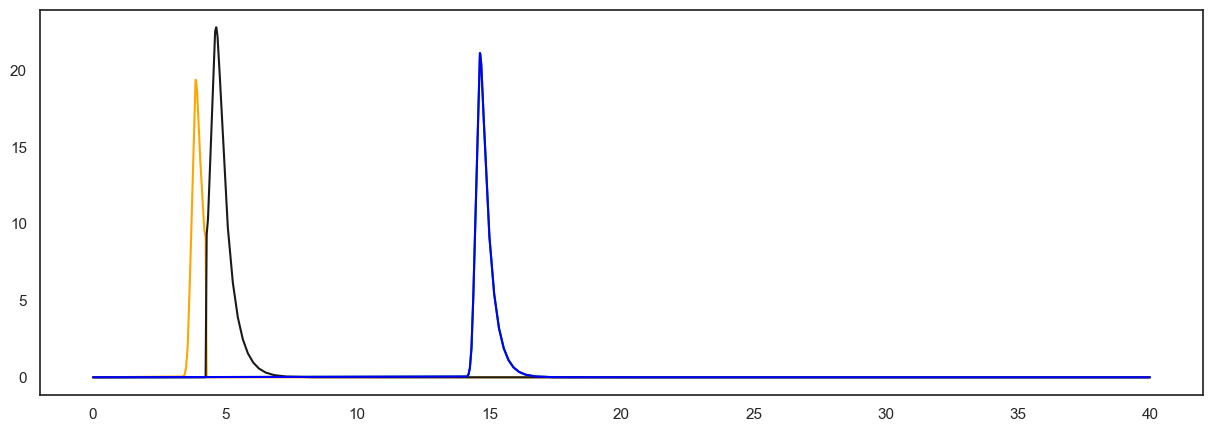

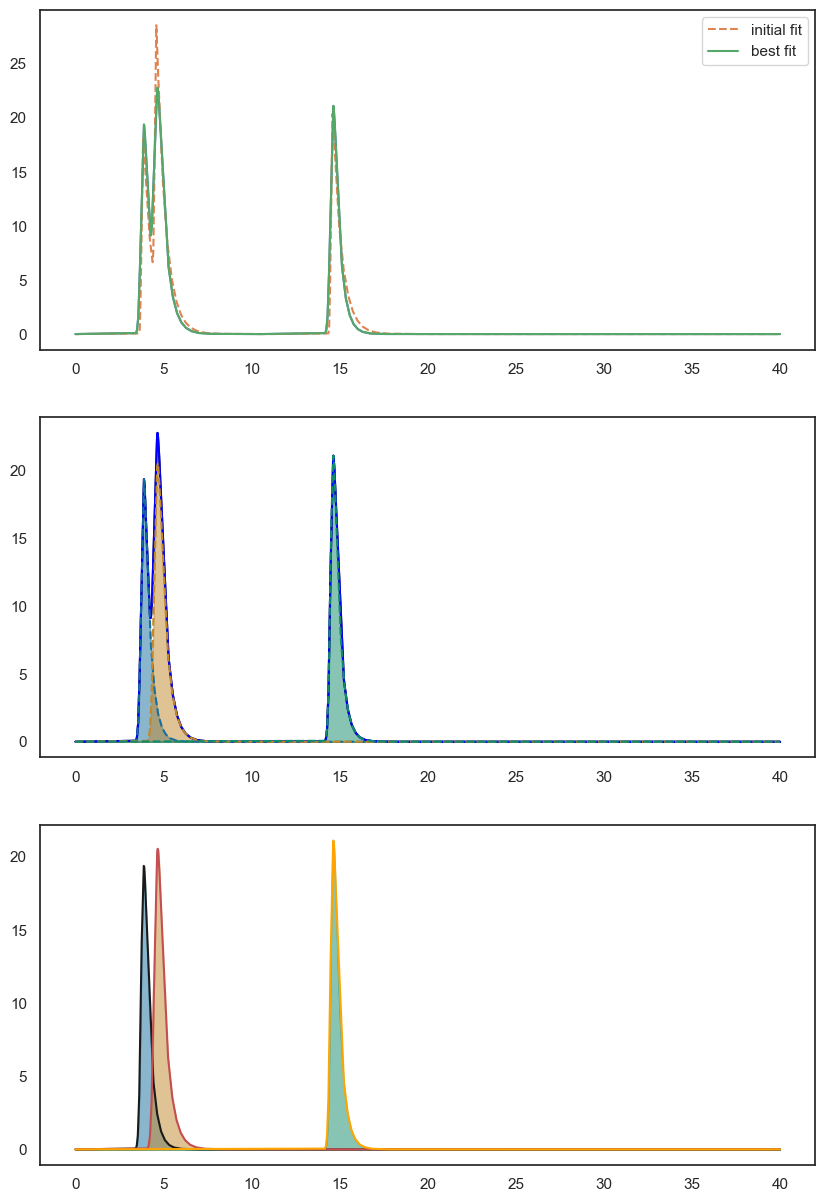

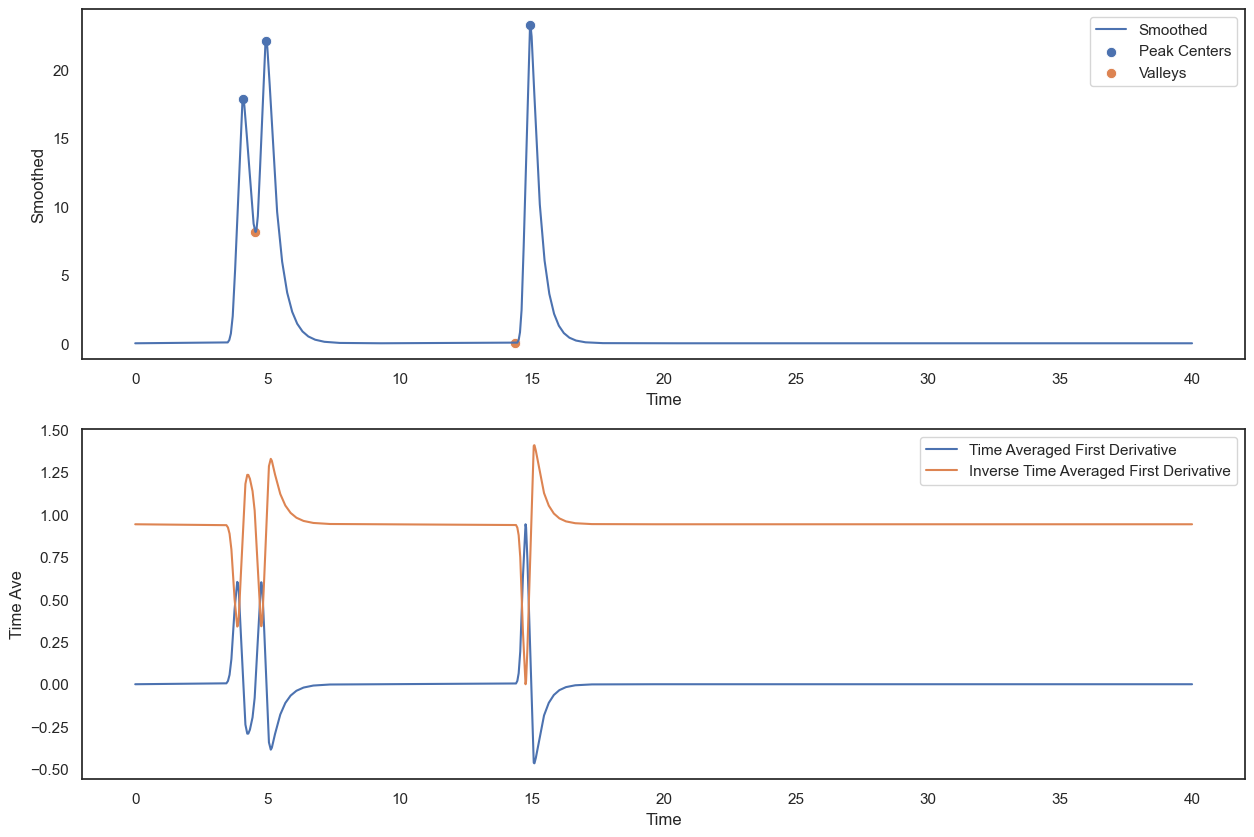

[0, 4.55, 14.370000000000001, 20]
[0, 4.55, 14.370000000000001, 20]
[0, 4.55, 14.370000000000001, 20]
1.577198864907012 0.531939408232227 9.755214108203233e-05
1.6787089203571802e-11
1.8398237806755377e-11
9.999018825916108e-11
[0, 4.58, 14.290000000000001, 20]
[0, 4.58, 14.290000000000001, 20]
[0, 4.58, 14.290000000000001, 20]
1.3177988126387585 0.4459147685959064 3.1450585716629046e-05
3.168157300721663e-11
6.901571270272753e-11
3.2227162770566864e-11
[0, 4.57, 14.450000000000001, 20]
[0, 4.57, 14.450000000000001, 20]
[0, 4.57, 14.450000000000001, 20]
1.2519131967847064 0.4231578115391572 0.00018287480881200383
1.7714218696265346e-11
4.6066626773032374e-11
5.886278190329498e-11
[0, 4.55, 14.21, 20]
[0, 4.55, 14.21, 20]
[0, 4.55, 14.21, 20]
1.0342510284532185 0.34882023013230723 1.0167317053397533e-05
4.2482160253598355e-11
7.153356146521504e-11
2.7073499483255707e-11
[0, 4.54, 14.31, 20]
[0, 4.54, 14.31, 20]
[0, 4.54, 14.31, 20]
1.3789929863754846 0.4645794440409799 4.261178422462035

1.9367407877739868e-12
1.1631800591963771e-11
2.3341082392125336e-11
[0, 4.57, 14.200000000000001, 20]
[0, 4.57, 14.200000000000001, 20]
[0, 4.57, 14.200000000000001, 20]
1.1822584067150672 0.3996138349340201 1.2136266343595396e-05
1.0738993322972569e-11
2.5944040496742678e-11
6.827030359574462e-12
[0, 4.5600000000000005, 14.42, 20]
[0, 4.5600000000000005, 14.42, 20]
[0, 4.5600000000000005, 14.42, 20]
1.4843948046364894 0.5011893885117159 0.00013582754568498124
9.884792977165962e-12
1.3238217354114885e-11
6.757837833939011e-11
[0, 4.58, 14.24, 20]
[0, 4.58, 14.24, 20]
[0, 4.58, 14.24, 20]
1.681085372693511 0.5688431240003563 1.5967347124404522e-05
1.6994480078521806e-13
3.598949392990662e-11
5.405311244761104e-11
[0, 4.59, 14.21, 20]
[0, 4.59, 14.21, 20]
[0, 4.59, 14.21, 20]
1.1194293202022028 0.3792041006958713 1.218747624400209e-05
4.5949451949316685e-12
2.6551545212894615e-12
8.452088298340085e-14
[0, 3.54, 4.55, 14.450000000000001, 20]
[3.54, 4.55, 14.450000000000001, 20]
[3.54, 4.

3.431461841570109e-12
9.428633491118028e-12
1.595659449115107e-10
[0, 4.57, 14.21, 20]
[0, 4.57, 14.21, 20]
[0, 4.57, 14.21, 20]
1.26548304866254 0.42774450256530294 1.1944477147782439e-05
9.80480338055841e-13
1.2668710848331978e-11
3.041369809107009e-11
[0, 4.5600000000000005, 14.450000000000001, 20]
[0, 4.5600000000000005, 14.450000000000001, 20]
[0, 4.5600000000000005, 14.450000000000001, 20]
1.4389828299074479 0.4858565981803527 0.0002707984151071453
1.5258149088293193e-12
5.5196765398384705e-11
1.5142697591159412e-11
[0, 3.54, 4.57, 14.290000000000001, 20]
[3.54, 4.57, 14.290000000000001, 20]
[3.54, 4.57, 14.290000000000001, 20]
2.0149641934872777 0.3233374091553648 4.5908942232723425e-05
4.1482649543630685e-11
3.510538027774268e-11
2.674119985017087e-13
[0, 4.61, 14.27, 20]
[0, 4.61, 14.27, 20]
[0, 4.61, 14.27, 20]
1.876958504791048 0.6371990785243931 3.261596117329826e-05
1.2584211080898458e-12
7.45316962266522e-12
1.152315402481275e-10
[0, 4.55, 14.41, 20]
[0, 4.55, 14.41, 20]


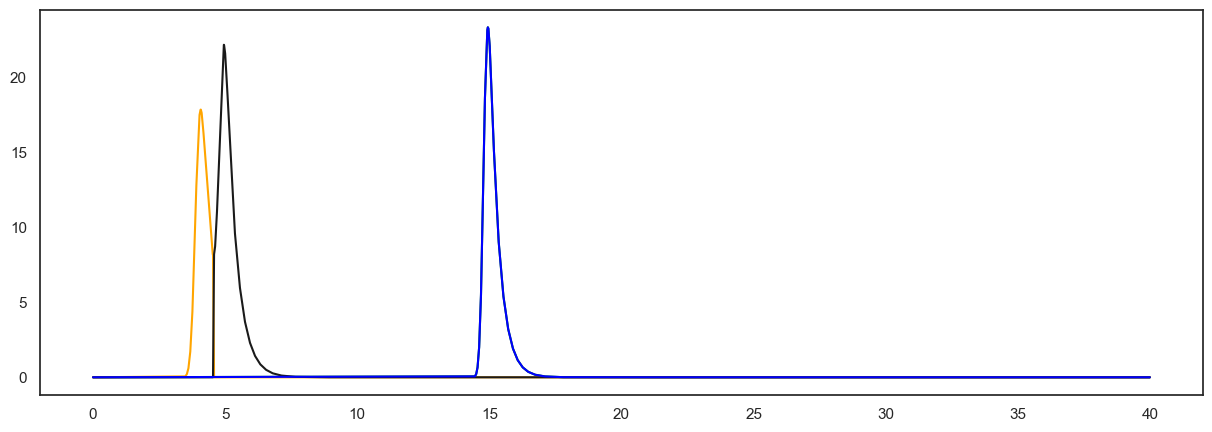

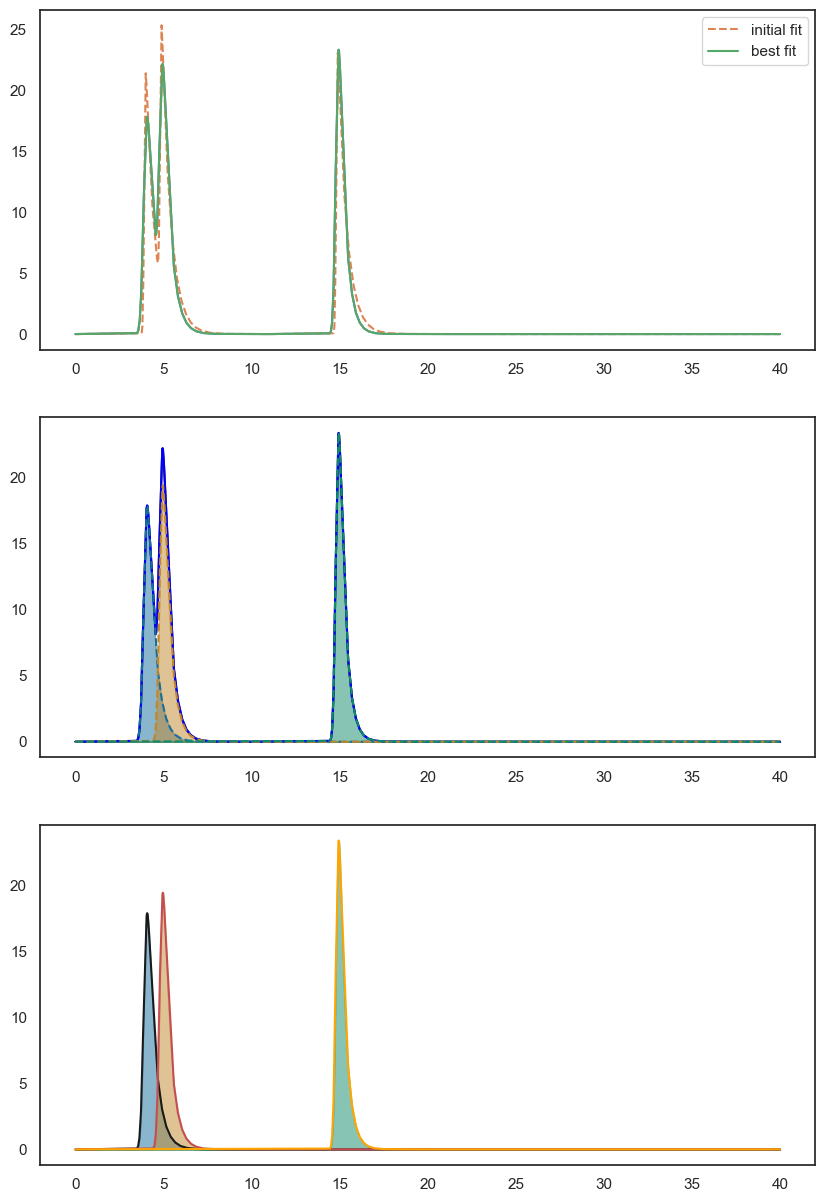

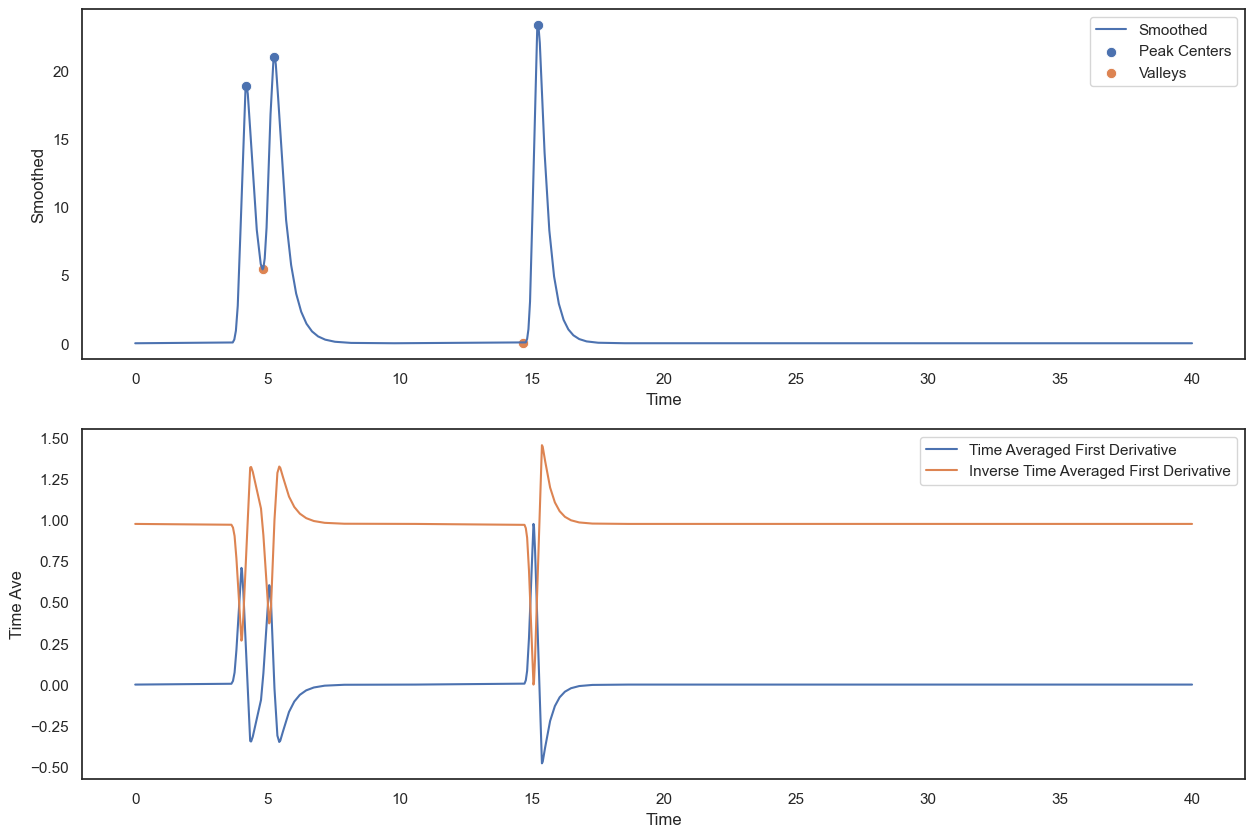

[0, 4.82, 14.69, 20]
[0, 4.82, 14.69, 20]
[0, 4.82, 14.69, 20]
0.9410693437374852 0.3266744559700736 0.0001151598102259897
5.586217225166932e-12
1.5595280554031634e-11
4.284850630767767e-11
[0, 4.8500000000000005, 14.75, 20]
[0, 4.8500000000000005, 14.75, 20]
[0, 4.8500000000000005, 14.75, 20]
0.9883203433431232 0.34414285288705737 0.000282292389458025
1.633771007984595e-11
2.3087336698190777e-11
1.259264461604713e-10
[0, 4.86, 14.56, 20]
[0, 4.86, 14.56, 20]
[0, 4.86, 14.56, 20]
1.5105681086007228 0.5265364622704936 2.824274824273205e-05
5.950152393266494e-11
3.179247821168095e-11
1.0074551426456778e-10
[0, 4.8, 14.61, 20]
[0, 4.8, 14.61, 20]
[0, 4.8, 14.61, 20]
0.7845983737391183 0.27179285158767996 3.471706026228011e-05
1.3666492594646798e-10
9.845362456704825e-11
6.733423001080871e-12
[0, 4.88, 14.57, 20]
[0, 4.88, 14.57, 20]
[0, 4.88, 14.57, 20]
1.391126774550812 0.4858996936200818 2.2576218423383217e-05
4.236388002654221e-11
4.5714868406260066e-11
2.2646855957124045e-11
[0, 4.850

5.507344992130811e-11
4.517376568929835e-11
6.844466417139749e-10
[0, 4.86, 14.5, 20]
[0, 4.86, 14.5, 20]
[0, 4.86, 14.5, 20]
1.2635102984963447 0.44041989104775475 9.49461917894657e-06
5.165514946055666e-11
9.755167681957537e-12
1.0756489021914647e-12
[0, 4.83, 14.74, 20]
[0, 4.83, 14.74, 20]
[0, 4.83, 14.74, 20]
1.34080579715233 0.46591802428554546 0.00025086566388232045
2.520038105153129e-12
7.583458385130605e-12
5.787912883561296e-10
[0, 4.8500000000000005, 14.49, 20]
[0, 4.8500000000000005, 14.49, 20]
[0, 4.8500000000000005, 14.49, 20]
1.5895167647201351 0.553485166880923 9.294092299623202e-06
4.24276902991762e-13
3.111091767946877e-12
1.290133918671233e-10
[0, 4.8500000000000005, 14.56, 20]
[0, 4.8500000000000005, 14.56, 20]
[0, 4.8500000000000005, 14.56, 20]
1.016321774512518 0.3538931080323094 2.354335677157907e-05
2.366572507957276e-12
8.108162832494371e-12
8.589627124817206e-12
[0, 4.8500000000000005, 14.66, 20]
[0, 4.8500000000000005, 14.66, 20]
[0, 4.8500000000000005, 14.66

5.060189359607716e-11
4.320853911585893e-11
1.6029339546742253e-11
[0, 4.82, 14.68, 20]
[0, 4.82, 14.68, 20]
[0, 4.82, 14.68, 20]
1.5411903286691169 0.5349951046090673 0.00011242367582567734
1.2963623280031106e-11
2.009211930801051e-11
8.058038542738082e-12
[0, 4.8500000000000005, 14.75, 20]
[0, 4.8500000000000005, 14.75, 20]
[0, 4.8500000000000005, 14.75, 20]
0.9881152541649749 0.344071416071611 0.0002529851974085945
1.90797986442135e-11
3.114780988773301e-11
2.4695158977693934e-11
[0, 4.8500000000000005, 14.49, 20]
[0, 4.8500000000000005, 14.49, 20]
[0, 4.8500000000000005, 14.49, 20]
1.4179845689346255 0.493755991259778 8.907805518221596e-06
8.720003195570073e-11
5.420156309054617e-11
3.6186470062806607e-11
[0, 4.83, 14.55, 20]
[0, 4.83, 14.55, 20]
[0, 4.83, 14.55, 20]
0.799361402610678 0.2777708992019537 1.471152188272164e-05
3.521288737167068e-11
2.921306051252804e-14
5.4826701313868386e-12
[0, 4.86, 14.67, 20]
[0, 4.86, 14.67, 20]
[0, 4.86, 14.67, 20]
0.6609355320663626 0.23038134

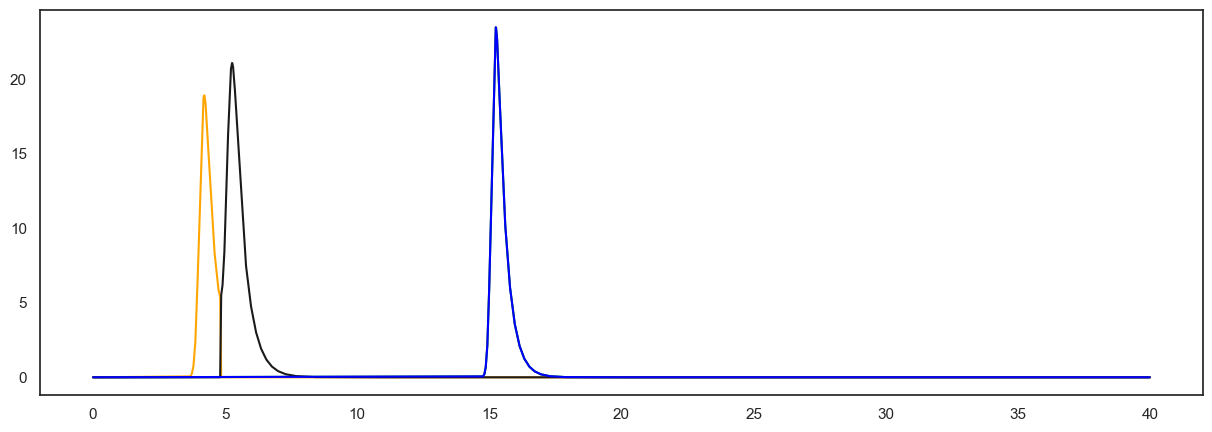

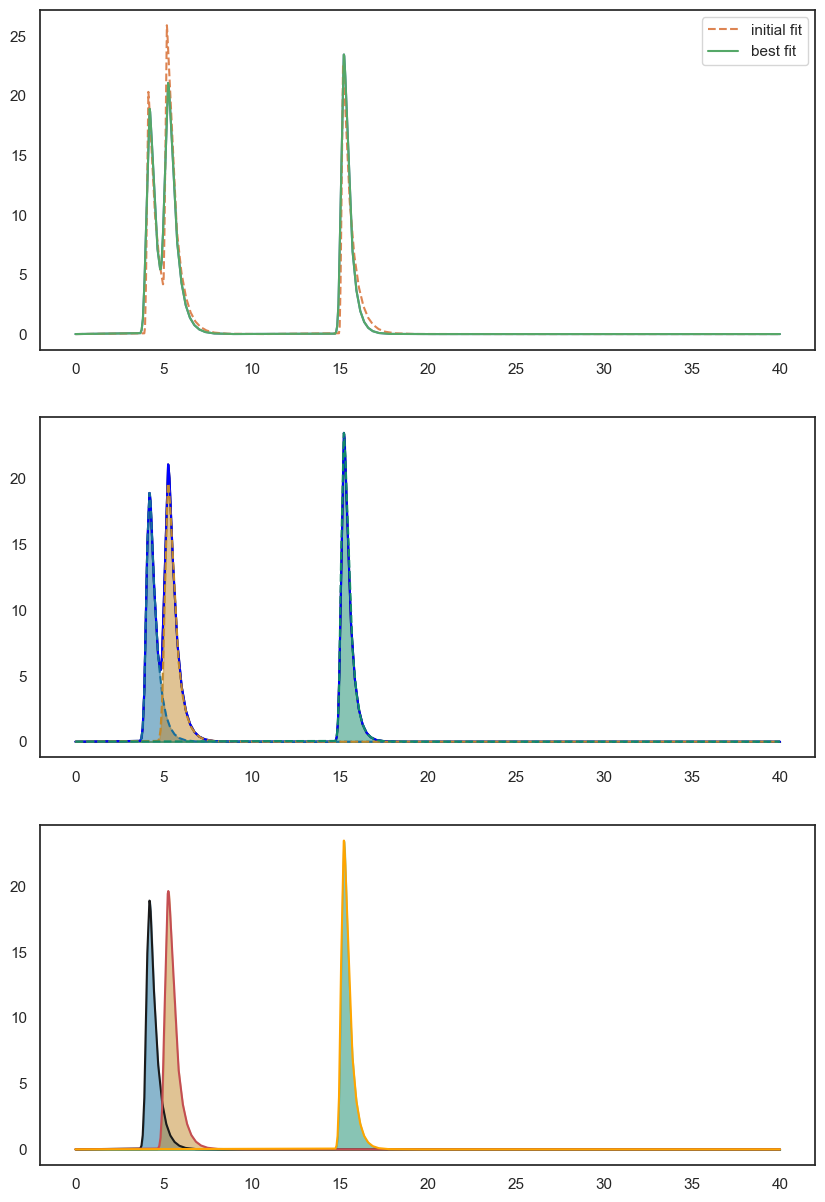

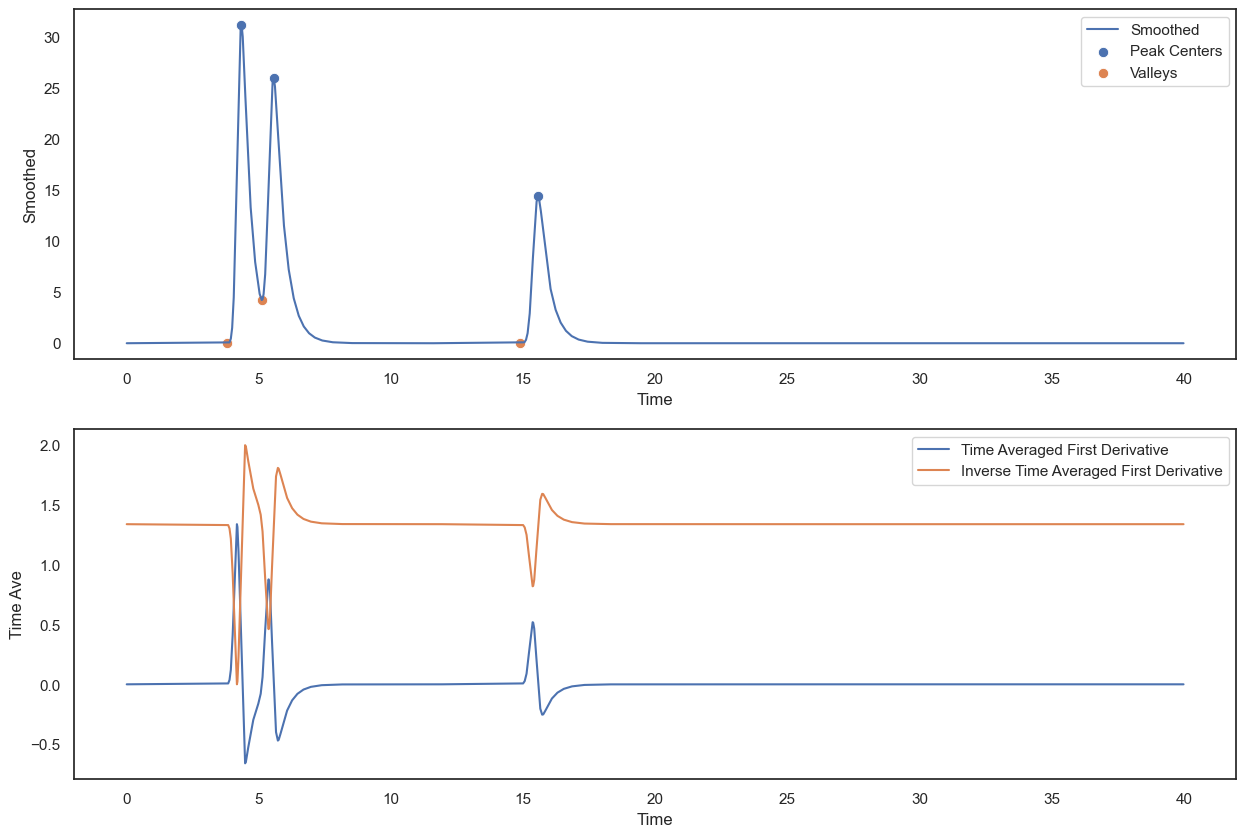

[0, 3.81, 5.11, 14.88, 20]
[3.81, 5.11, 14.88, 20]
[3.81, 5.11, 14.88, 20]
1.3559314457815679 0.24444401864317516 2.1598563670001827e-05
1.5898901198594385e-11
4.2792578441004264e-11
2.8435666574201157e-12
[0, 5.12, 14.9, 20]
[0, 5.12, 14.9, 20]
[0, 5.12, 14.9, 20]
0.5857891617593677 0.20957830424254928 3.2073906397037656e-05
8.317937804778257e-11
1.7571618653153339e-10
6.841482744229248e-14
[0, 3.86, 5.11, 14.780000000000001, 20]
[3.86, 5.11, 14.780000000000001, 20]
[3.86, 5.11, 14.780000000000001, 20]
0.843776127772649 0.14915995564050177 7.775444666853197e-06
1.0905574275310613e-10
2.5502037321643196e-11
4.352161495483263e-11
[0, 5.15, 14.94, 20]
[0, 5.15, 14.94, 20]
[0, 5.15, 14.94, 20]
0.6543073394546179 0.23477693279819392 5.926097927412094e-05
8.87439643764482e-13
4.431394038286677e-12
3.4499223009928817e-12
[0, 5.13, 14.950000000000001, 20]
[0, 5.13, 14.950000000000001, 20]
[0, 5.13, 14.950000000000001, 20]
0.7875141055142397 0.2820246344657151 7.830571487305048e-05
5.117357345

2.8903819559505056e-11
1.875789932979525e-11
3.5934132202029327e-10
[0, 5.08, 14.88, 20]
[0, 5.08, 14.88, 20]
[0, 5.08, 14.88, 20]
0.7689164888499381 0.274019226501919 2.249208357654356e-05
1.9361877835869716e-12
2.5677101420638162e-11
2.4249546864104178e-11
[0, 5.15, 14.94, 20]
[0, 5.15, 14.94, 20]
[0, 5.15, 14.94, 20]
0.8978014495585641 0.3221468770254268 4.5966749692633846e-05
1.5931193263141304e-11
9.963640489408122e-12
1.110772903061372e-12
[0, 3.84, 5.09, 14.83, 20]
[3.84, 5.09, 14.83, 20]
[3.84, 5.09, 14.83, 20]
1.3817257259719777 0.24425690819988766 1.64838916745232e-05
4.415235563978014e-11
2.0393129422792093e-11
1.738749767503304e-11
[0, 5.11, 14.950000000000001, 20]
[0, 5.11, 14.950000000000001, 20]
[0, 5.11, 14.950000000000001, 20]
0.6329628522400503 0.2262344272650405 6.416065462332379e-05
1.2783146058134895e-11
8.900054514913044e-12
9.178072086074051e-11
[0, 5.15, 14.94, 20]
[0, 5.15, 14.94, 20]
[0, 5.15, 14.94, 20]
0.5990366752254387 0.21494485203922514 6.013756270622781

3.0928119169522114e-11
5.51502402864536e-12
1.0742769024834422e-10
[0, 5.11, 14.92, 20]
[0, 5.11, 14.92, 20]
[0, 5.11, 14.92, 20]
0.7547791427288885 0.26977416002449073 3.68140868111505e-05
6.2775506117961145e-12
8.757502873338558e-11
7.961420206360614e-11
[0, 3.84, 5.14, 14.89, 20]
[3.84, 5.14, 14.89, 20]
[3.84, 5.14, 14.89, 20]
0.9237354721062454 0.16652878214685127 2.3546223389753142e-05
1.419065712289139e-10
5.969889599408034e-11
5.040811649236168e-12
[0, 5.12, 14.89, 20]
[0, 5.12, 14.89, 20]
[0, 5.12, 14.89, 20]
0.543373663821863 0.19440327419491982 2.9752313993469137e-05
5.558350107019378e-11
2.053391447520664e-11
9.437846639244745e-12
[0, 5.12, 15.030000000000001, 20]
[0, 5.12, 15.030000000000001, 20]
[0, 5.12, 15.030000000000001, 20]
0.8552739600882326 0.3059921445001307 0.00013603214531070988
1.3126646716087285e-11
1.5990320845131035e-11
8.520728855930366e-11
[0, 3.83, 5.13, 14.780000000000001, 20]
[3.83, 5.13, 14.780000000000001, 20]
[3.83, 5.13, 14.780000000000001, 20]
1.131

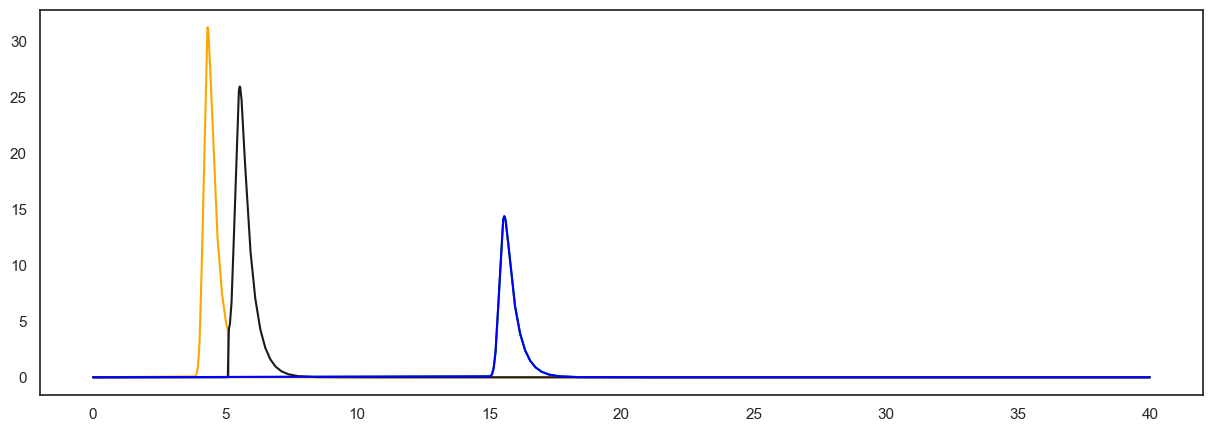

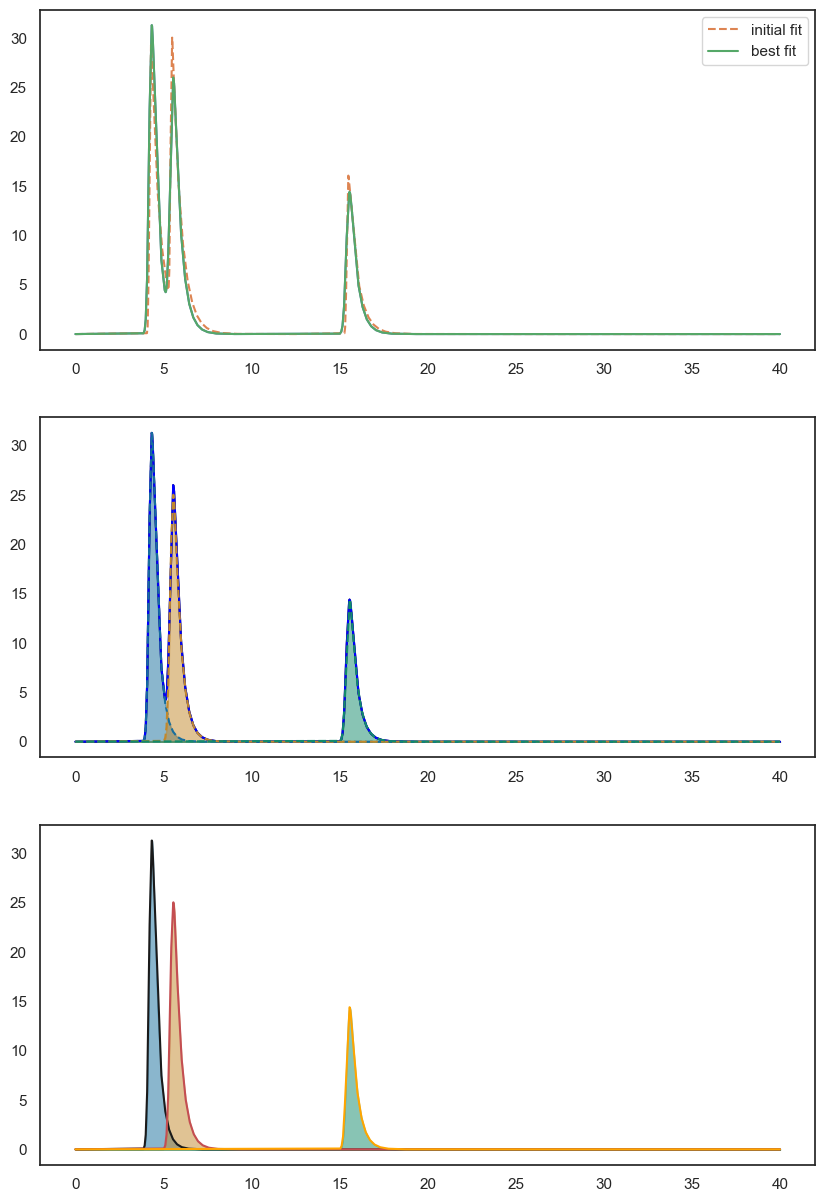

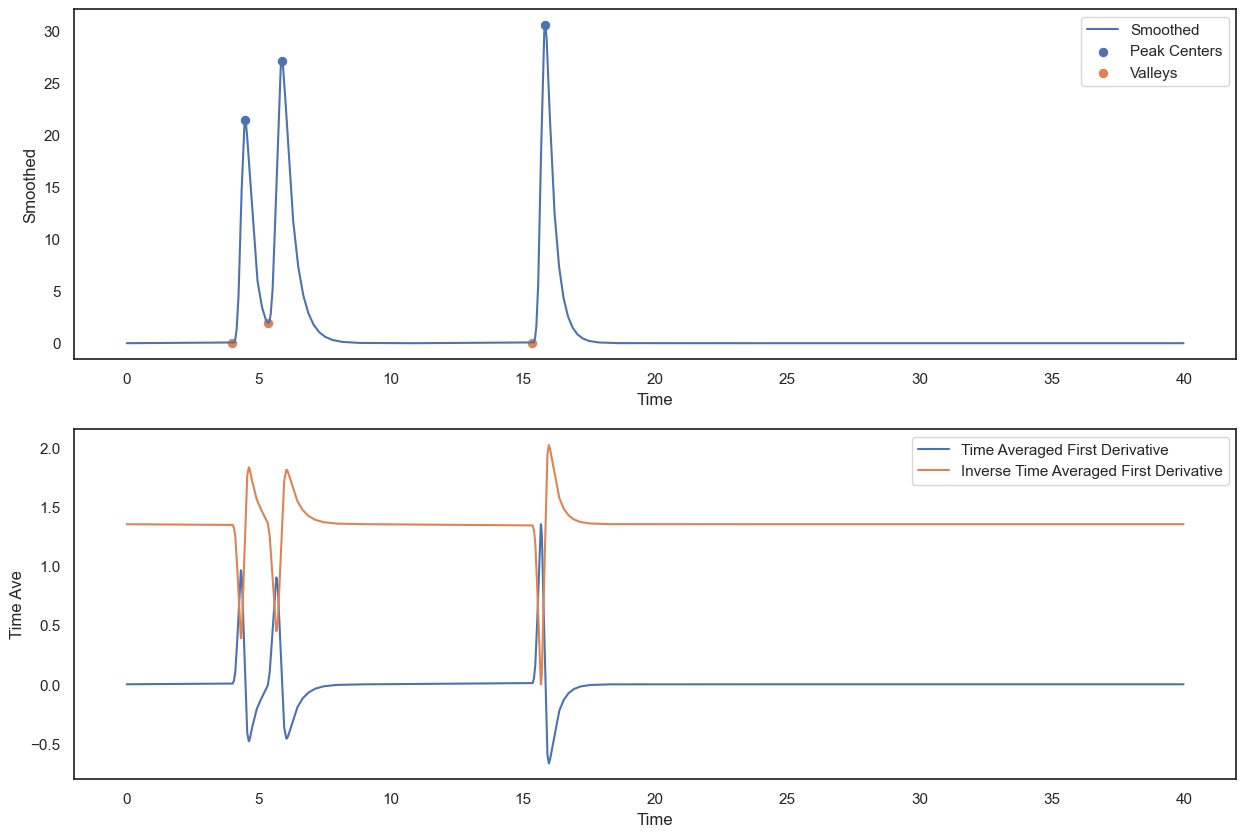

[0, 3.98, 5.3500000000000005, 15.32, 20]
[3.98, 5.3500000000000005, 15.32, 20]
[3.98, 5.3500000000000005, 15.32, 20]
0.569753919279161 0.1054431211521553 0.00018151038489088765
2.7288702731830845e-11
1.4304206376773804e-11
2.021394488683839e-10
[0, 5.42, 15.35, 20]
[0, 5.42, 15.35, 20]
[0, 5.42, 15.35, 20]
0.4915947842013887 0.18095781002654104 0.0002509848268455086
3.5656117142152536e-11
1.645259112063934e-11
9.2906445419037e-11
[0, 5.41, 15.18, 20]
[0, 5.41, 15.18, 20]
[0, 5.41, 15.18, 20]
0.5025571292719991 0.18482217660220412 2.902318529818293e-05
1.4884350426688057e-11
2.6689282873947378e-11
6.867412128138586e-11
[0, 3.98, 5.37, 15.1, 20]
[3.98, 5.37, 15.1, 20]
[3.98, 5.37, 15.1, 20]
0.7974172721282224 0.148649360336067 1.4096079270501684e-05
1.0590131047446342e-10
1.7162363309720522e-11
1.1409803958949605e-10
[0, 5.4, 15.15, 20]
[0, 5.4, 15.15, 20]
[0, 5.4, 15.15, 20]
0.6203975688530273 0.22794862320348983 2.135732686584661e-05
7.758002110144657e-12
7.181173161182981e-11
2.938296

9.769116172776792e-12
6.500695390870153e-11
1.2571276006612023e-11
[0, 5.36, 15.1, 20]
[0, 5.36, 15.1, 20]
[0, 5.36, 15.1, 20]
0.26377787364826283 0.09655855691734677 1.3639026511253107e-05
9.326790072291961e-13
6.430136830921523e-12
1.1753547225681257e-11
[0, 3.99, 5.39, 15.36, 20]
[3.99, 5.39, 15.36, 20]
[3.99, 5.39, 15.36, 20]
0.55619414216782 0.10405491303714748 0.0003280164712644694
1.5602087509642324e-13
1.2626069883536431e-11
1.0908717108264965e-10
[0, 5.42, 15.31, 20]
[0, 5.42, 15.31, 20]
[0, 5.42, 15.31, 20]
0.25315274313696995 0.0931864941443695 0.00016583708995521047
3.146932353857832e-13
3.0904051612278395e-11
6.148795407484345e-13
[0, 3.99, 5.43, 15.33, 20]
[3.99, 5.43, 15.33, 20]
[3.99, 5.43, 15.33, 20]
0.6115346656447045 0.11603066745027531 0.00016878000438653104
1.673181485469113e-10
2.712373172748274e-11
9.556472760661797e-11
[0, 5.41, 15.35, 20]
[0, 5.41, 15.35, 20]
[0, 5.41, 15.35, 20]
0.543132204958075 0.19974431493119313 0.00020801649444362254
5.7132440315332816e-1

1.784636587147214e-10
2.092721018956186e-11
1.6075218237945143e-11
[0, 5.41, 15.18, 20]
[0, 5.41, 15.18, 20]
[0, 5.41, 15.18, 20]
0.4343158929356168 0.15972553902937034 2.094959949523793e-05
1.7582567195530528e-11
1.5386943428268876e-11
2.9117658151798845e-11
[0, 5.39, 15.17, 20]
[0, 5.39, 15.17, 20]
[0, 5.39, 15.17, 20]
0.628209190101392 0.23060497637852517 2.541481332122373e-05
2.924942805163019e-11
4.1821543550977674e-11
3.534861701936339e-11
[0, 4.0, 5.38, 15.290000000000001, 20]
[4.0, 5.38, 15.290000000000001, 20]
[4.0, 5.38, 15.290000000000001, 20]
0.5296451958190296 0.09837733403211596 0.0001438648580612936
3.332955565170373e-11
6.753121033194086e-11
1.3764388989795025e-10
[0, 5.42, 15.3, 20]
[0, 5.42, 15.3, 20]
[0, 5.42, 15.3, 20]
0.3239165090393951 0.11923481574839483 0.00015225742432658856
2.1755669390126894e-11
1.0580874573771077e-10
2.636771725308205e-10
[0, 5.4, 15.200000000000001, 20]
[0, 5.4, 15.200000000000001, 20]
[0, 5.4, 15.200000000000001, 20]
0.261728578394047 0.09

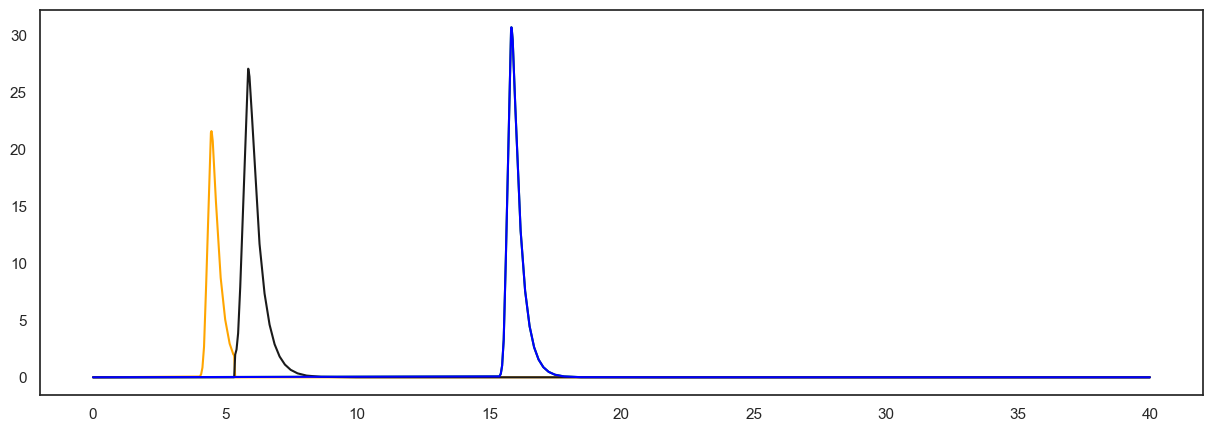

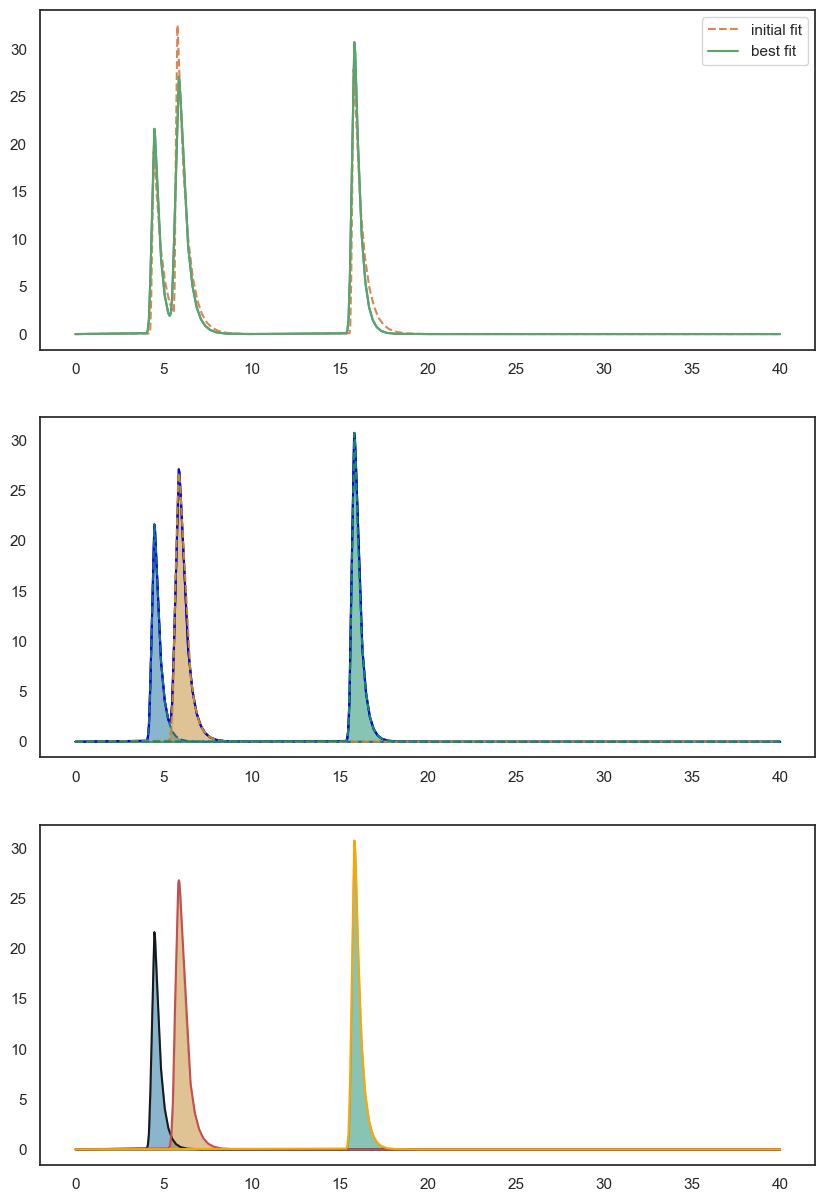

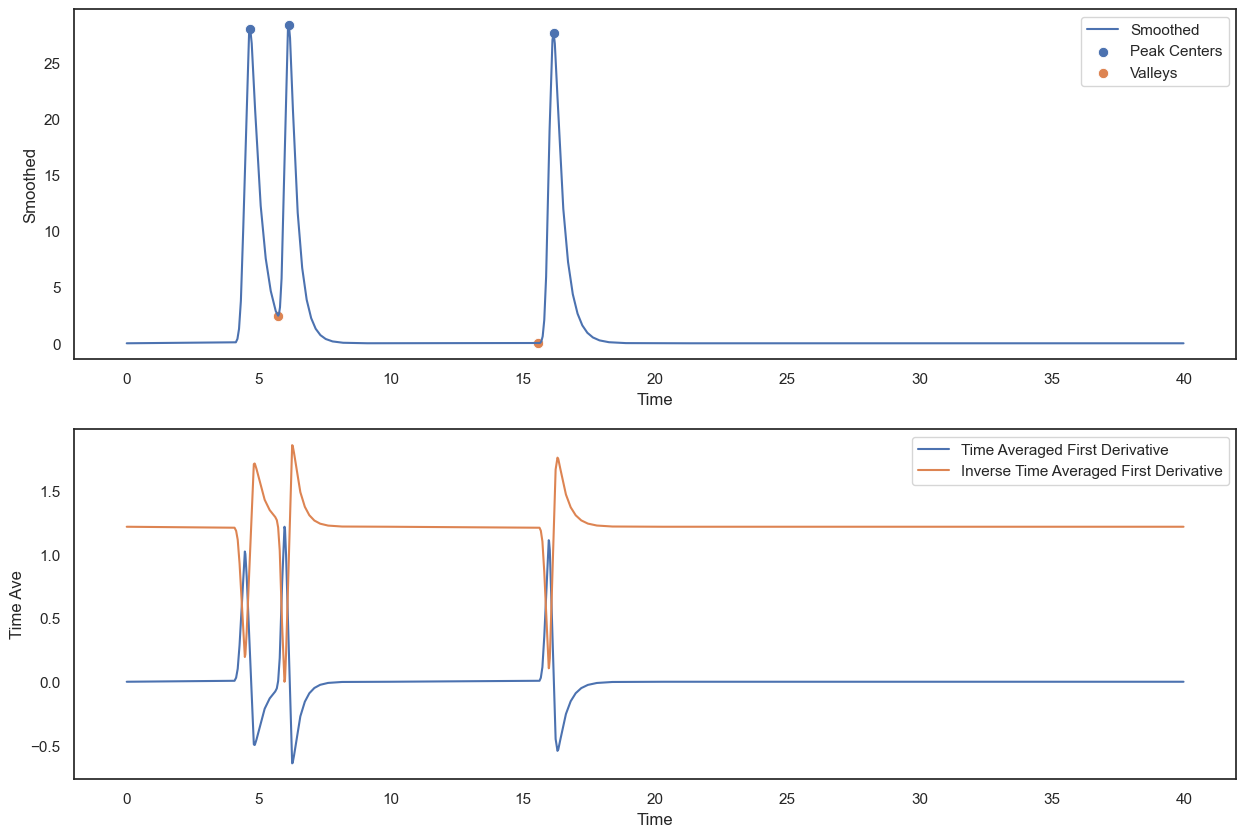

[0, 5.73, 15.57, 20]
[0, 5.73, 15.57, 20]
[0, 5.73, 15.57, 20]
0.4299842401407175 0.1627421211894325 0.00012045547086512484
1.618724703748874e-12
6.29227936971281e-11
1.1707291529888423e-11
[0, 5.65, 15.49, 20]
[0, 5.65, 15.49, 20]
[0, 5.65, 15.49, 20]
0.35589421453183 0.13375658236187193 2.426921358727898e-05
2.907205535490463e-11
8.180062744732126e-11
7.2659844331547615e-12
[0, 5.67, 15.450000000000001, 20]
[0, 5.67, 15.450000000000001, 20]
[0, 5.67, 15.450000000000001, 20]
0.4799129422849961 0.18068579067543736 2.6297063780611275e-05
2.3657354346876226e-14
3.5475252944464845e-13
1.0180601161642742e-13
[0, 5.66, 15.47, 20]
[0, 5.66, 15.47, 20]
[0, 5.66, 15.47, 20]
0.43674847672296313 0.16428943072682506 2.705342699831142e-05
1.3239620643782188e-11
1.0432337090725682e-11
4.5256716632307333e-10
[0, 5.66, 15.5, 20]
[0, 5.66, 15.5, 20]
[0, 5.66, 15.5, 20]
0.502573121471548 0.1890503505741358 3.871655412049153e-05
1.1996457627943944e-11
1.4538368268155602e-11
1.0941907349502939e-10
[0, 5.

1.3069617911572383e-11
3.157579781535011e-11
1.8404315989246588e-10
[0, 5.65, 15.540000000000001, 20]
[0, 5.65, 15.540000000000001, 20]
[0, 5.65, 15.540000000000001, 20]
0.4564930365737654 0.1715648874330276 5.73821368174682e-05
1.7637668596969958e-12
1.3363039805548479e-11
1.9842677241188313e-09
[0, 5.67, 15.610000000000001, 20]
[0, 5.67, 15.610000000000001, 20]
[0, 5.67, 15.610000000000001, 20]
0.3322662838260553 0.12509733670445042 0.00013576889116480832
1.075904494370747e-11
6.252808796092223e-11
1.2246064646740382e-12
[0, 5.67, 15.51, 20]
[0, 5.67, 15.51, 20]
[0, 5.67, 15.51, 20]
0.3554908280246131 0.1338412437925915 4.981148006518655e-05
1.0729581110458324e-10
3.454872348324793e-11
4.1269572861333565e-10
[0, 4.13, 5.65, 15.39, 20]
[4.13, 5.65, 15.39, 20]
[4.13, 5.65, 15.39, 20]
0.5544257167038988 0.10807746921974598 9.482886371105924e-06
2.8701565596190453e-11
9.861541581402537e-11
3.332610647587057e-10
[0, 5.7, 15.63, 20]
[0, 5.7, 15.63, 20]
[0, 5.7, 15.63, 20]
0.375251962382524

3.3736745757719846e-11
9.344643935955485e-12
3.032771962738522e-10
[0, 4.14, 5.67, 15.5, 20]
[4.14, 5.67, 15.5, 20]
[4.14, 5.67, 15.5, 20]
0.3867647405716038 0.07564193626913429 3.35935775535769e-05
1.0192477139089092e-10
1.7565691942421762e-11
9.147106851706881e-11
[0, 5.66, 15.59, 20]
[0, 5.66, 15.59, 20]
[0, 5.66, 15.59, 20]
0.1949340198866124 0.07332737406283384 8.236203877547352e-05
3.051335397321767e-11
1.8660084869294933e-11
1.3654171935071063e-11
[0, 5.69, 15.43, 20]
[0, 5.69, 15.43, 20]
[0, 5.69, 15.43, 20]
0.3552648698597037 0.13399185749921674 2.1277614731426102e-05
2.1211662570327625e-12
2.7770770251904155e-11
1.4395102264587765e-10
[0, 5.72, 15.48, 20]
[0, 5.72, 15.48, 20]
[0, 5.72, 15.48, 20]
0.19646412664118612 0.07429358274474254 2.3450276961770535e-05
1.6554988850401286e-11
4.078631213568345e-13
2.9676583253519865e-10
[0, 5.71, 15.63, 20]
[0, 5.71, 15.63, 20]
[0, 5.71, 15.63, 20]
0.5254057792515309 0.1985104115045842 0.00026454374038282786
1.5248697916933337e-11
2.1156

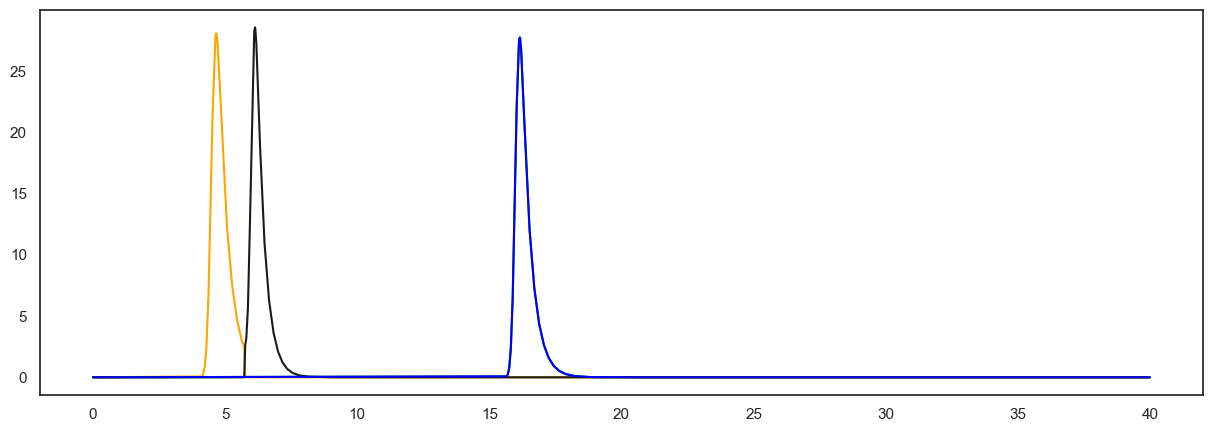

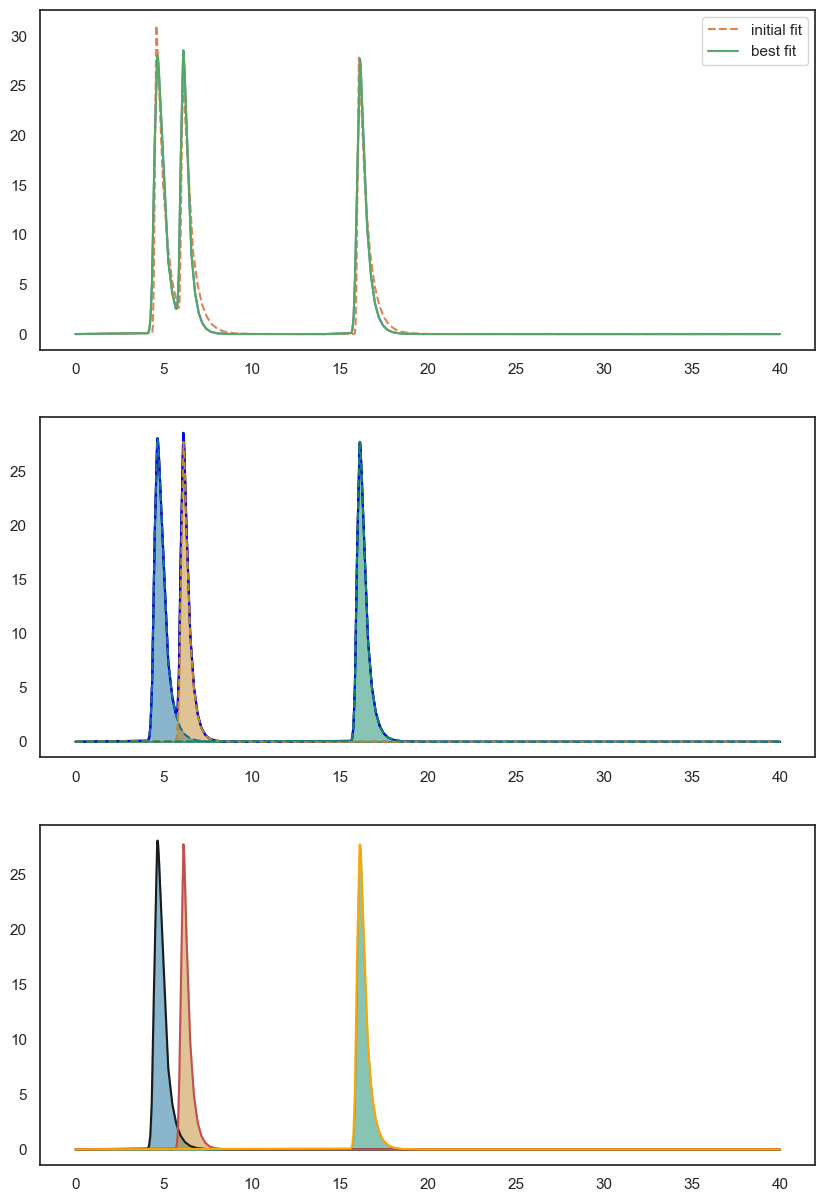

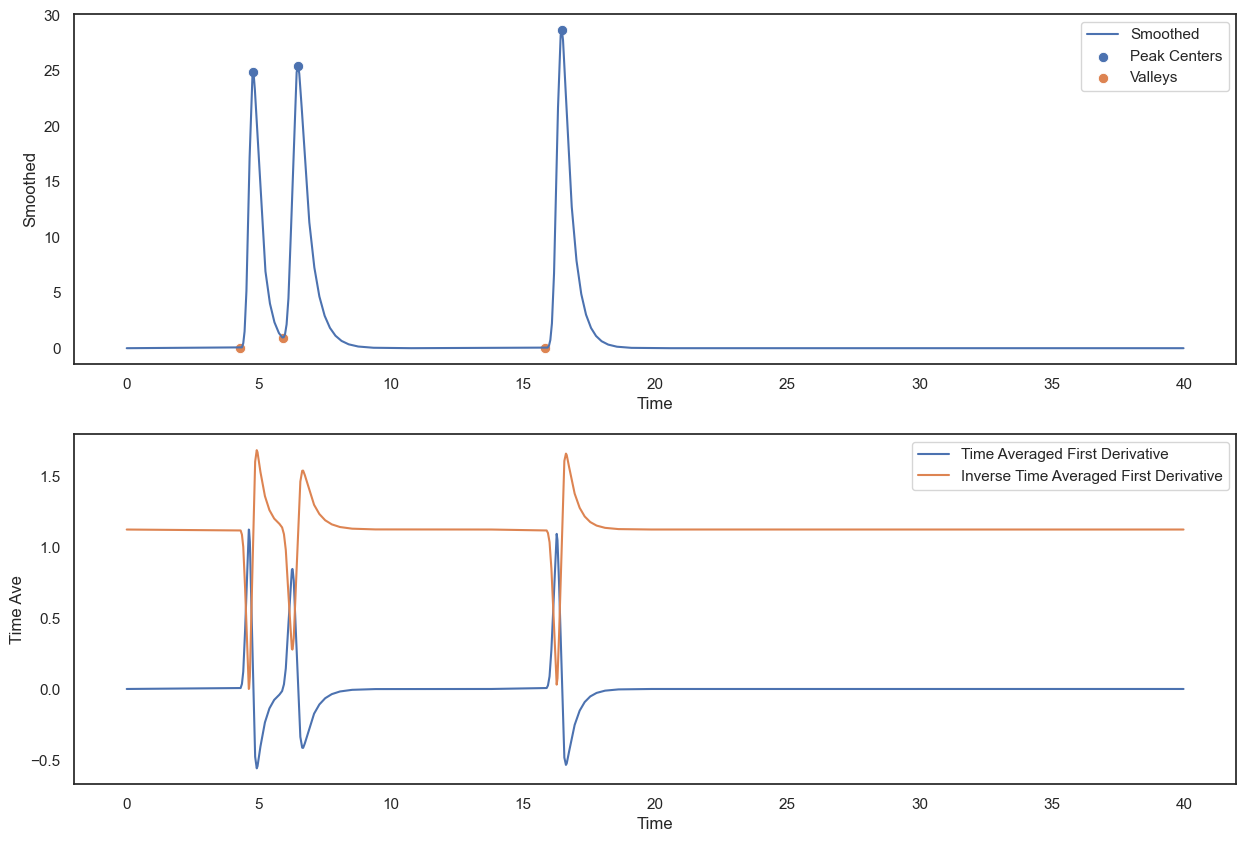

[0, 4.28, 5.91, 15.82, 20]
[4.28, 5.91, 15.82, 20]
[4.28, 5.91, 15.82, 20]
0.26562568164510414 0.05362090841969642 6.291036759932005e-05
1.9613608914239283e-10
2.534258446491609e-11
3.3525784634018987e-09
[0, 5.95, 15.860000000000001, 20]
[0, 5.95, 15.860000000000001, 20]
[0, 5.95, 15.860000000000001, 20]
0.22015753456494208 0.08491067841096542 9.475961938777359e-05
1.1040521535482165e-11
6.369335200808706e-11
5.250538224607719e-10
[0, 4.2700000000000005, 5.94, 15.790000000000001, 20]
[4.2700000000000005, 5.94, 15.790000000000001, 20]
[4.2700000000000005, 5.94, 15.790000000000001, 20]
0.3187431926469507 0.06512822005335973 3.1511349595382716e-05
2.4232441025409638e-11
8.032980298452403e-12
2.23360749175019e-11
[0, 4.29, 5.92, 15.68, 20]
[4.29, 5.92, 15.68, 20]
[4.29, 5.92, 15.68, 20]
0.2699036113977016 0.05448444229949777 1.026071635278945e-05
2.4917434514240416e-10
2.9356464673957744e-11
1.71528665216178e-10
[0, 5.99, 15.84, 20]
[0, 5.99, 15.84, 20]
[0, 5.99, 15.84, 20]
0.277297786728

6.907471062670496e-12
7.310434402519494e-11
1.6048897905556394e-10
[0, 5.96, 15.68, 20]
[0, 5.96, 15.68, 20]
[0, 5.96, 15.68, 20]
0.1304730538967028 0.050363275288762506 6.828983938016775e-06
8.60921736825438e-12
2.2064003680127102e-11
6.763247536717e-11
[0, 4.3, 5.95, 15.72, 20]
[4.3, 5.95, 15.72, 20]
[4.3, 5.95, 15.72, 20]
0.25908047111823207 0.0526194954023388 1.7682177320411787e-05
4.7432414296777866e-11
4.32961985381465e-11
1.1128709768094785e-09
[0, 5.99, 15.93, 20]
[0, 5.99, 15.93, 20]
[0, 5.99, 15.93, 20]
0.2492073250413998 0.09643734371126032 0.00020906135336622308
2.3799637376964227e-12
4.690530392783001e-11
5.354820871863985e-10
[0, 5.94, 15.77, 20]
[0, 5.94, 15.77, 20]
[0, 5.94, 15.77, 20]
0.24181067579060422 0.09318343585022586 2.970347117222039e-05
8.716054834595197e-11
6.590697516163632e-12
1.4141321239964623e-11
[0, 5.95, 15.74, 20]
[0, 5.95, 15.74, 20]
[0, 5.95, 15.74, 20]
0.22860988900644086 0.08817054128485981 1.5793162598406083e-05
4.037578647811503e-11
9.1027259423

7.760668170891638e-11
1.5800103296351724e-11
3.265654863787071e-10
[0, 5.98, 15.73, 20]
[0, 5.98, 15.73, 20]
[0, 5.98, 15.73, 20]
0.16069756406247662 0.062134084146944275 1.421215272107774e-05
4.391683632191464e-12
1.1451880369428399e-10
2.2846851280524457e-10
[0, 6.0, 15.92, 20]
[0, 6.0, 15.92, 20]
[0, 6.0, 15.92, 20]
0.23684848738877623 0.09173129617486077 0.00022316175111867717
1.554978585070958e-11
3.706147727329319e-11
9.180731526926201e-10
[0, 4.2700000000000005, 5.97, 15.96, 20]
[4.2700000000000005, 5.97, 15.96, 20]
[4.2700000000000005, 5.97, 15.96, 20]
0.25217548053780253 0.05198772579523696 0.0002086420875587529
3.4860849618851015e-11
3.3415410858262906e-11
2.055315967170688e-10
[0, 5.96, 15.950000000000001, 20]
[0, 5.96, 15.950000000000001, 20]
[0, 5.96, 15.950000000000001, 20]
0.1880263151551222 0.07257978443887214 0.00030777550553151236
3.522597701472685e-12
3.7063335203327987e-10
1.3412716335990894e-09
[0, 5.95, 15.82, 20]
[0, 5.95, 15.82, 20]
[0, 5.95, 15.82, 20]
0.212588

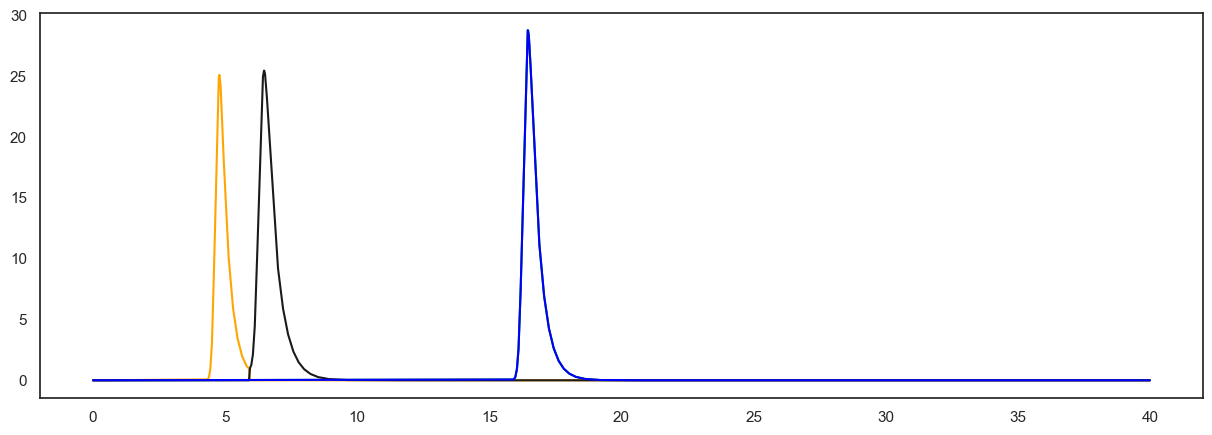

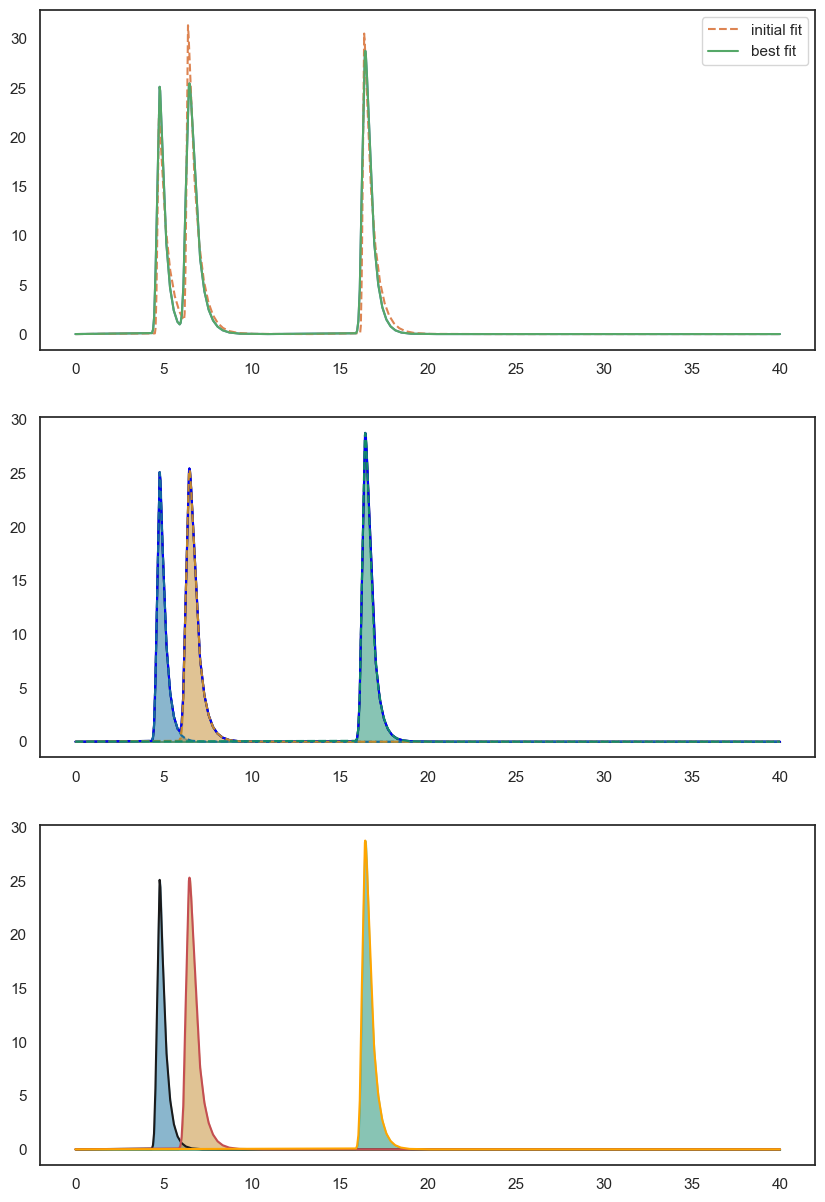

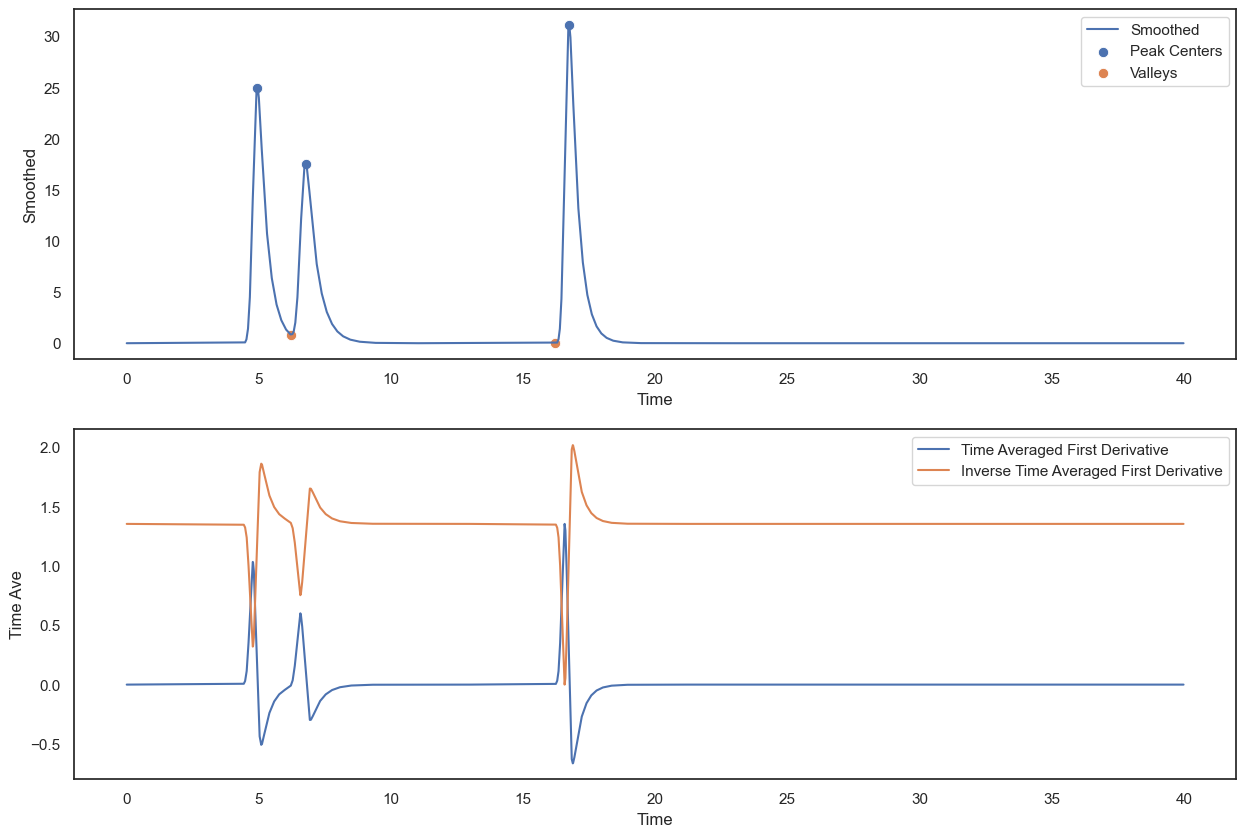

[0, 6.23, 16.22, 20]
[0, 6.23, 16.22, 20]
[0, 6.23, 16.22, 20]
0.12689796566674982 0.05008105743078279 0.00023552306012406067
1.0971514054329066e-11
1.4310794052686847e-11
9.670074868442852e-10
[0, 6.2700000000000005, 15.99, 20]
[0, 6.2700000000000005, 15.99, 20]
[0, 6.2700000000000005, 15.99, 20]
0.20622180618351832 0.08164664872419113 8.424350013596868e-06
4.65674895665549e-12
2.0866520241229536e-13
1.4898077969544505e-10
[0, 6.3, 16.240000000000002, 20]
[0, 6.3, 16.240000000000002, 20]
[0, 6.3, 16.240000000000002, 20]
0.12015627317496451 0.04768626425070046 0.00026234675221055605
6.776402566464254e-12
9.693979187584995e-12
3.85803803459283e-09
[0, 4.45, 6.2700000000000005, 16.02, 20]
[4.45, 6.2700000000000005, 16.02, 20]
[4.45, 6.2700000000000005, 16.02, 20]
0.13116060724545311 0.027977518239665936 1.594426299865782e-05
4.59169837047559e-11
1.3654793273265224e-11
3.6171288924433513e-11
[0, 4.43, 6.26, 16.2, 20]
[4.43, 6.26, 16.2, 20]
[4.43, 6.26, 16.2, 20]
0.14681538698063754 0.0314

2.988973676140101e-11
4.3890807063009256e-13
8.740349183936497e-11
[0, 6.29, 16.06, 20]
[0, 6.29, 16.06, 20]
[0, 6.29, 16.06, 20]
0.13963212313752352 0.05537078666439248 1.8785993541577007e-05
1.1234161391284157e-11
3.1996954267247476e-13
2.684384069738056e-10
[0, 6.29, 16.0, 20]
[0, 6.29, 16.0, 20]
[0, 6.29, 16.0, 20]
0.13250326612466518 0.05254385360074763 1.155602999617955e-05
3.6060588666789514e-12
5.779773495312915e-11
1.0405109295371734e-10
[0, 6.28, 15.99, 20]
[0, 6.28, 15.99, 20]
[0, 6.28, 15.99, 20]
0.1300179663574003 0.05151731323222725 1.119286875777969e-05
7.977584256568548e-12
2.4382390280367787e-11
5.300332691749151e-10
[0, 4.45, 6.23, 16.15, 20]
[4.45, 6.23, 16.15, 20]
[4.45, 6.23, 16.15, 20]
0.16854434064637394 0.03555450352974305 5.05396085112427e-05
1.0577811867113517e-10
2.7093453317019765e-11
1.8797496840872116e-10
[0, 6.32, 16.06, 20]
[0, 6.32, 16.06, 20]
[0, 6.32, 16.06, 20]
0.23425813474721235 0.09311576855978877 1.762474368615432e-05
6.36612231053294e-14
2.06405

8.142934396002167e-11
1.2247874259694367e-11
3.7934019417673117e-10
[0, 4.44, 6.25, 15.99, 20]
[4.44, 6.25, 15.99, 20]
[4.44, 6.25, 15.99, 20]
0.16357743560827778 0.03479627036438743 7.2182677751898655e-06
2.1388407729552675e-12
4.460601436359124e-12
1.0140448683238557e-09
[0, 4.44, 6.2, 16.240000000000002, 20]
[4.44, 6.2, 16.240000000000002, 20]
[4.44, 6.2, 16.240000000000002, 20]
0.11577196867651522 0.024285955353628486 0.00026283695335930596
8.9673263363484e-12
1.2830862851305212e-11
5.529807914077052e-10
[0, 6.25, 16.26, 20]
[0, 6.25, 16.26, 20]
[0, 6.25, 16.26, 20]
0.1922699230543089 0.07600158668605544 0.0001855031150931283
3.696121521390278e-12
2.2031563611723186e-12
2.683303620539882e-09
[0, 6.24, 16.26, 20]
[0, 6.24, 16.26, 20]
[0, 6.24, 16.26, 20]
0.1446258201692331 0.05712325324844426 0.0002685434501993292
1.857534023967214e-11
1.2255395655554684e-11
1.62454617577704e-10
[0, 4.45, 6.2700000000000005, 16.14, 20]
[4.45, 6.2700000000000005, 16.14, 20]
[4.45, 6.2700000000000005,

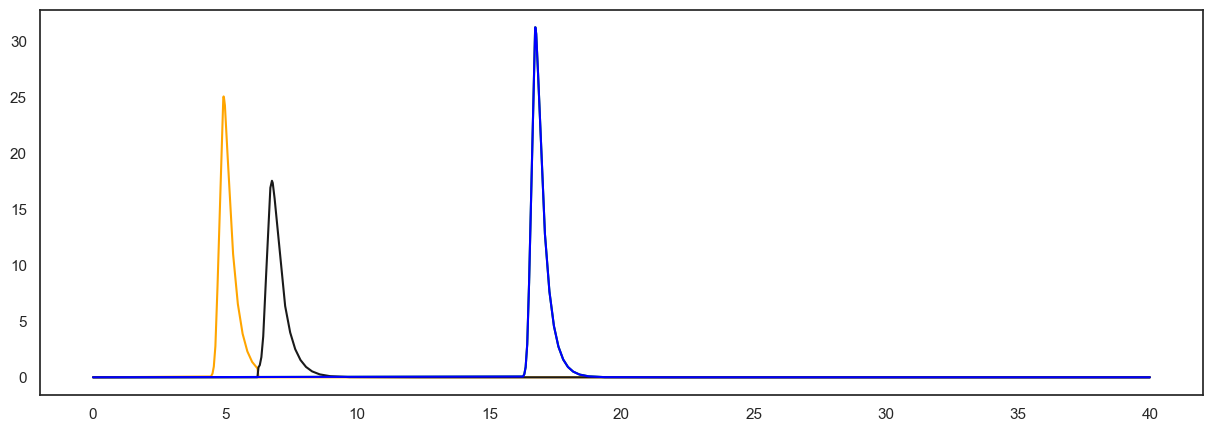

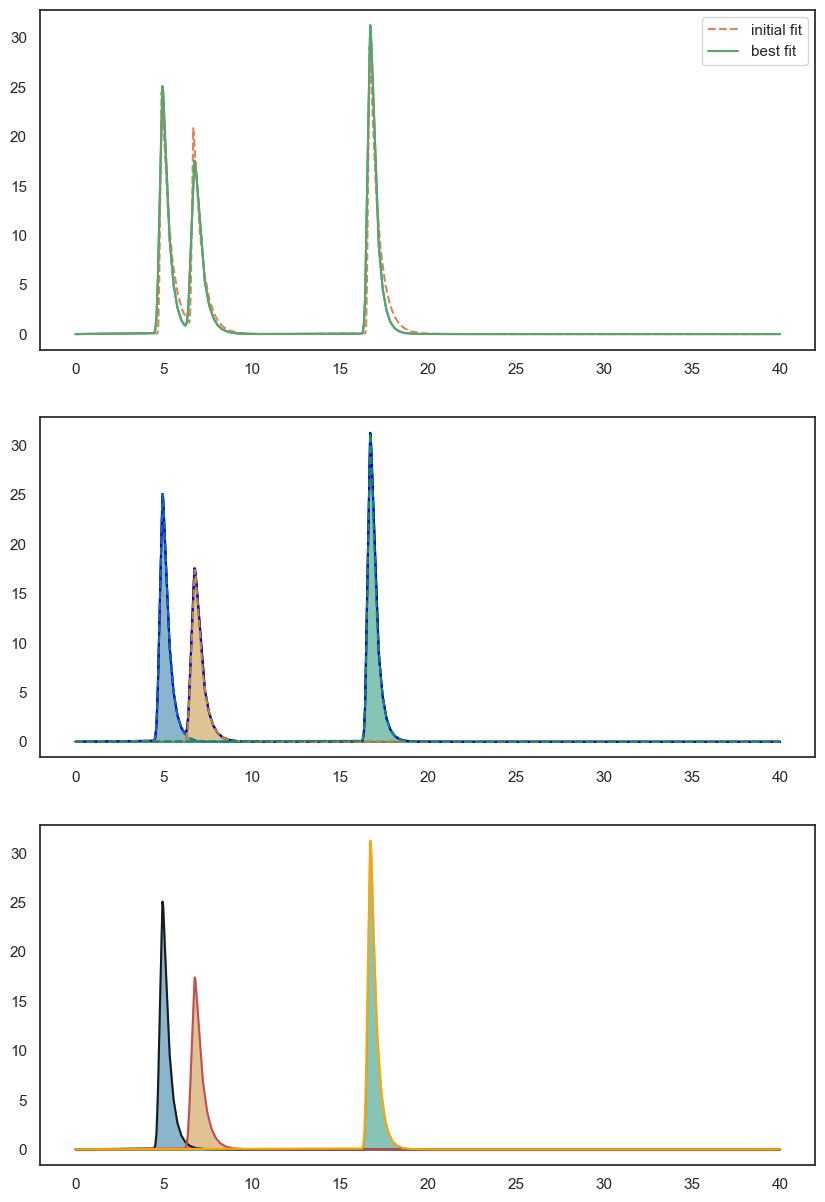

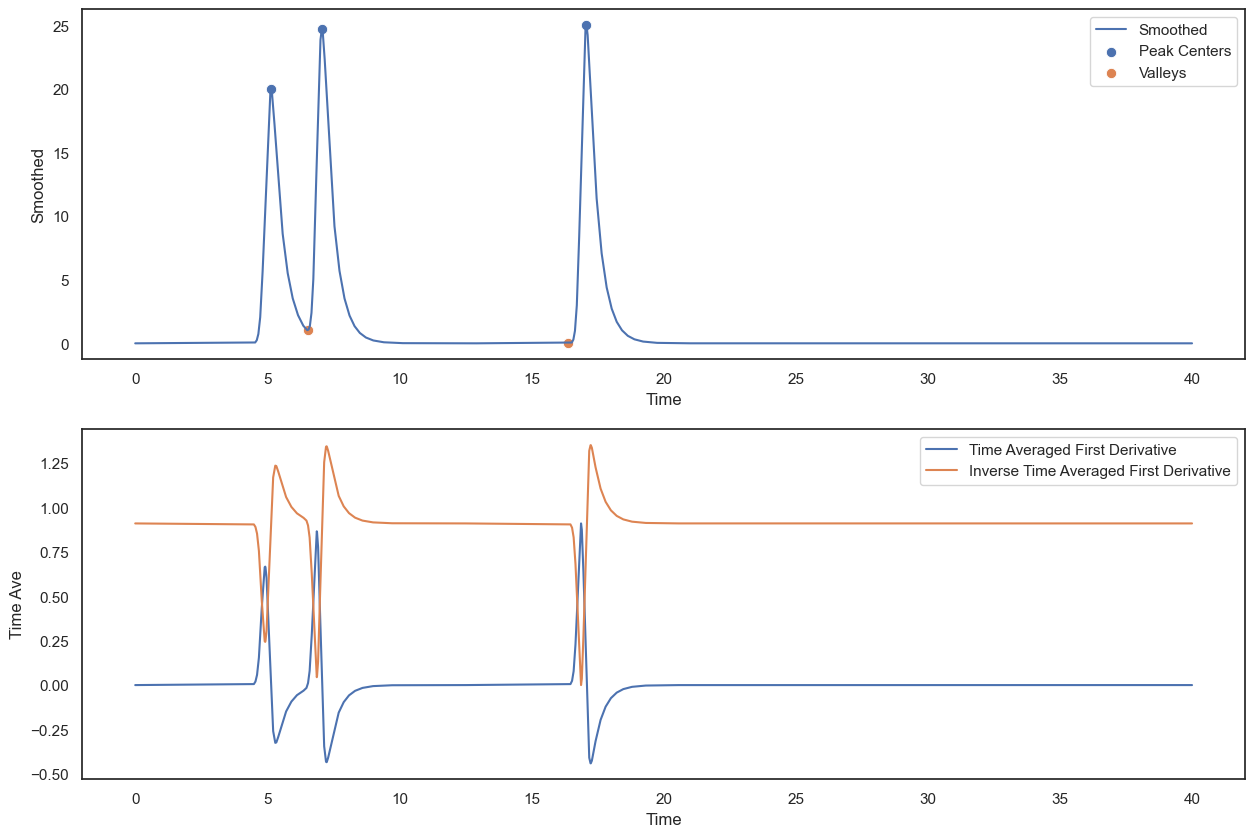

[0, 6.5200000000000005, 16.39, 20]
[0, 6.5200000000000005, 16.39, 20]
[0, 6.5200000000000005, 16.39, 20]
0.17470593078752555 0.07053449070931792 4.3960116160651924e-05
1.636817330774655e-11
1.7243085041087728e-12
6.77323147405768e-10
[0, 6.51, 16.51, 20]
[0, 6.51, 16.51, 20]
[0, 6.51, 16.51, 20]
0.07369469081732233 0.02973060714519963 0.00016974385452208631
4.057482519592354e-11
2.7706890140097682e-11
2.563364094157435e-09
[0, 4.59, 6.59, 16.3, 20]
[4.59, 6.59, 16.3, 20]
[4.59, 6.59, 16.3, 20]
0.0910063048172379 0.02034963283580414 1.3443497929543558e-05
3.0765569216879805e-11
2.64096501010921e-11
2.6806784793742645e-09
[0, 6.58, 16.46, 20]
[0, 6.58, 16.46, 20]
[0, 6.58, 16.46, 20]
0.13885058424795577 0.05631588885073265 6.400258589462318e-05
1.3398965596114007e-10
2.120633883118472e-11
4.693274716921952e-12
[0, 6.46, 16.46, 20]
[0, 6.46, 16.46, 20]
[0, 6.46, 16.46, 20]
0.08742035486842378 0.03513171993741618 5.7592027931424264e-05
3.472302738427057e-11
1.541232271070433e-11
1.45669116

8.512474888155218e-12
1.5356381169012933e-11
2.3451821152521514e-10
[0, 6.5600000000000005, 16.48, 20]
[0, 6.5600000000000005, 16.48, 20]
[0, 6.5600000000000005, 16.48, 20]
0.12215149523794495 0.04946783938145211 0.00015854240694171341
1.1951076608063622e-11
1.7043167759164575e-11
1.9634454294315318e-10
[0, 6.5, 16.32, 20]
[0, 6.5, 16.32, 20]
[0, 6.5, 16.32, 20]
0.12730708238542254 0.051319128756670655 1.808872070203855e-05
1.9814804830976048e-11
5.621252738747946e-12
1.6926095568733418e-10
[0, 6.46, 16.56, 20]
[0, 6.46, 16.56, 20]
[0, 6.46, 16.56, 20]
0.06524716010882284 0.02622182817208147 0.00021858744279817997
4.68237279744609e-12
1.7103562285970224e-11
1.8699612182754905e-10
[0, 6.5200000000000005, 16.51, 20]
[0, 6.5200000000000005, 16.51, 20]
[0, 6.5200000000000005, 16.51, 20]
0.09293155097141786 0.0375199952014462 0.00019368496627221834
5.756457576175673e-11
1.5088684888838018e-11
1.0038066838578933e-10
[0, 4.58, 6.49, 16.45, 20]
[4.58, 6.49, 16.45, 20]
[4.58, 6.49, 16.45, 20]
0

8.00665749658436e-11
2.622852278143968e-13
1.1817365656280003e-09
[0, 4.62, 6.49, 16.490000000000002, 20]
[4.62, 6.49, 16.490000000000002, 20]
[4.62, 6.49, 16.490000000000002, 20]
0.08727147606950186 0.01886982096933541 8.732632578123838e-05
2.6389442051358203e-11
1.6405372338744224e-11
1.311693961380336e-10
[0, 6.51, 16.44, 20]
[0, 6.51, 16.44, 20]
[0, 6.51, 16.44, 20]
0.13893948708699133 0.056051411134802324 7.225465428162251e-05
3.998443542690747e-11
1.3427695997643839e-12
2.634898717639315e-11
[0, 4.61, 6.5200000000000005, 16.39, 20]
[4.61, 6.5200000000000005, 16.39, 20]
[4.61, 6.5200000000000005, 16.39, 20]
0.0967304852950951 0.021137363678579435 3.967715342614337e-05
7.10811836378898e-11
1.3819843036362675e-10
2.2428902616677952e-10
[0, 6.55, 16.32, 20]
[0, 6.55, 16.32, 20]
[0, 6.55, 16.32, 20]
0.08627028245722752 0.03491016815605716 1.9310930214951748e-05
7.818203676927983e-13
5.3225943954973934e-11
2.330867162590858e-10
[0, 4.59, 6.5, 16.29, 20]
[4.59, 6.5, 16.29, 20]
[4.59, 6.

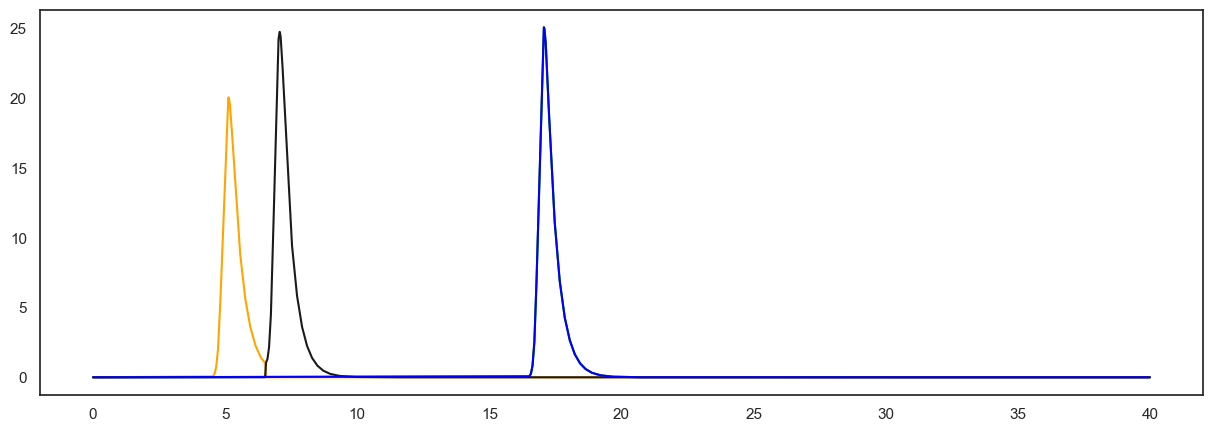

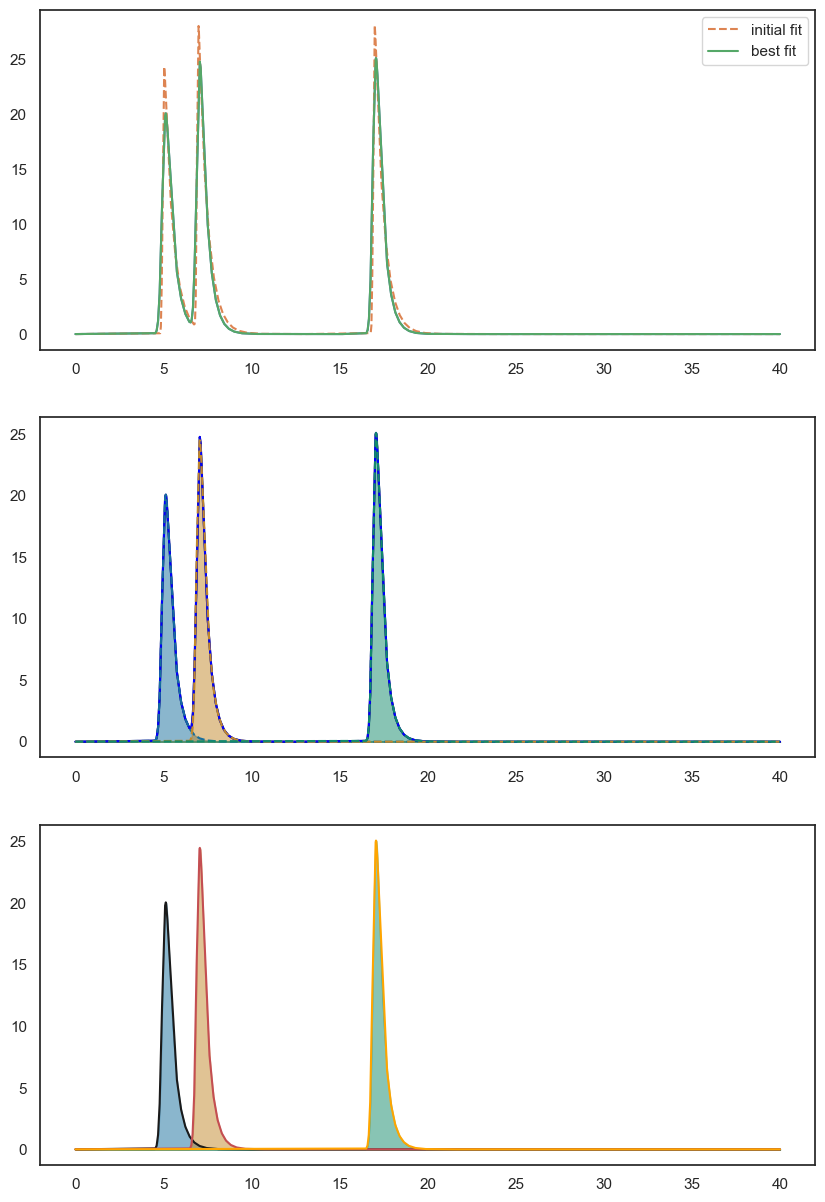

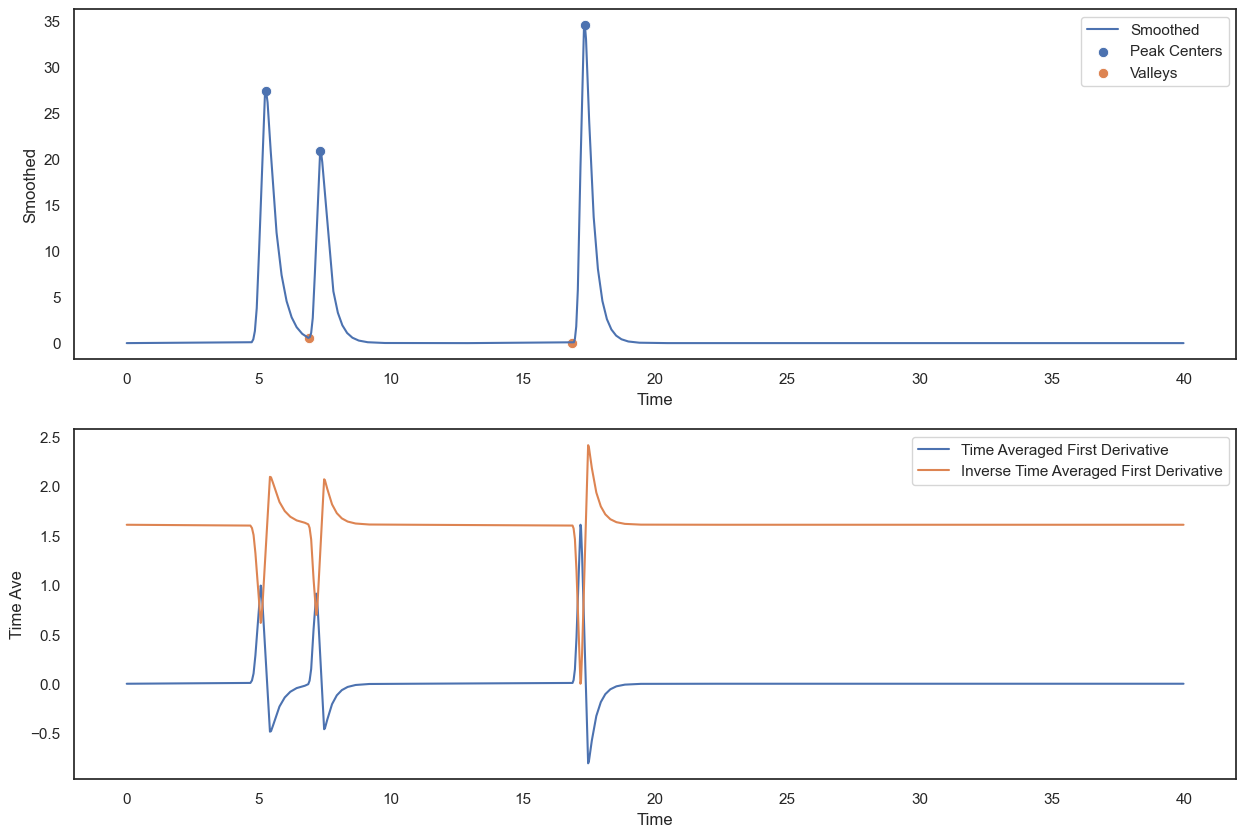

[0, 6.88, 16.85, 20]
[0, 6.88, 16.85, 20]
[0, 6.88, 16.85, 20]
0.0939887723108571 0.0389809358505366 0.0002905110276170963
5.523310272434343e-12
4.127703475819801e-11
5.444572111404634e-13
[0, 4.73, 6.82, 16.78, 20]
[4.73, 6.82, 16.78, 20]
[4.73, 6.82, 16.78, 20]
0.04785252494334807 0.010939256670218996 0.0001481046976718764
1.5203671657053587e-11
8.318648395445912e-12
3.8482470621821783e-10
[0, 6.79, 16.7, 20]
[0, 6.79, 16.7, 20]
[0, 6.79, 16.7, 20]
0.06665015810425237 0.027460395623461212 4.980849451279384e-05
1.5233412246816817e-11
1.502100582556129e-13
1.2299930241819229e-10
[0, 6.890000000000001, 16.68, 20]
[0, 6.890000000000001, 16.68, 20]
[0, 6.890000000000001, 16.68, 20]
0.10248707173270057 0.04253522893676186 2.495378178977477e-05
1.4466593336492024e-13
1.0953569826010097e-11
6.579542694392793e-11
[0, 4.73, 6.8, 16.580000000000002, 20]
[4.73, 6.8, 16.580000000000002, 20]
[4.73, 6.8, 16.580000000000002, 20]
0.08771411395296413 0.019953757321437778 7.196435541348102e-06
4.205785

2.001803043597048e-11
1.928771351580841e-11
2.6286397828627728e-11
[0, 6.8500000000000005, 16.75, 20]
[0, 6.8500000000000005, 16.75, 20]
[0, 6.8500000000000005, 16.75, 20]
0.060635832569655615 0.025092758106361537 0.00010448255596144331
4.9586787008206847e-11
1.3980935760046834e-12
3.735854380825008e-10
[0, 4.72, 6.79, 16.75, 20]
[4.72, 6.79, 16.75, 20]
[4.72, 6.79, 16.75, 20]
0.08693137429017776 0.019775893417564666 8.892103781196475e-05
5.2142270928448986e-11
1.195443870287535e-10
3.5132452526146337e-09
[0, 6.8500000000000005, 16.59, 20]
[0, 6.8500000000000005, 16.59, 20]
[0, 6.8500000000000005, 16.59, 20]
0.09550746460757191 0.03952324764171743 1.1141071320163416e-05
1.5287082314628878e-12
1.0067457272211597e-11
1.701629783943317e-10
[0, 4.74, 6.88, 16.8, 20]
[4.74, 6.88, 16.8, 20]
[4.74, 6.88, 16.8, 20]
0.060616413933603557 0.014021409147960223 0.00014902634803641394
1.0469651844995715e-11
2.1657131536546505e-11
6.77084714159511e-10
[0, 6.8, 16.75, 20]
[0, 6.8, 16.75, 20]
[0, 6.8, 

6.93710318842178e-12
6.595719165685727e-11
4.659223582001361e-12
[0, 6.8100000000000005, 16.78, 20]
[0, 6.8100000000000005, 16.78, 20]
[0, 6.8100000000000005, 16.78, 20]
0.12691857110788266 0.05236845001770537 0.00011157366323486385
1.0273350985191075e-11
8.228470105582207e-11
3.9705290694377576e-12
[0, 6.8100000000000005, 16.85, 20]
[0, 6.8100000000000005, 16.85, 20]
[0, 6.8100000000000005, 16.85, 20]
0.12918959074701747 0.05330630736652649 0.0003136187335361533
7.458666863930454e-12
1.0332902485101894e-13
1.6296746036342305e-09
[0, 6.8, 16.63, 20]
[0, 6.8, 16.63, 20]
[0, 6.8, 16.63, 20]
0.10286156398081882 0.042410912764024304 1.7114291806851983e-05
1.3329630494568474e-11
1.952923730377334e-11
5.357455130229846e-11
[0, 6.87, 16.79, 20]
[0, 6.87, 16.79, 20]
[0, 6.87, 16.79, 20]
0.0658509127722825 0.027290841827520243 0.0001522718185794106
1.2558962239730467e-11
9.210166388964466e-11
2.9646386546978025e-10
[0, 6.86, 16.61, 20]
[0, 6.86, 16.61, 20]
[0, 6.86, 16.61, 20]
0.086774455197088

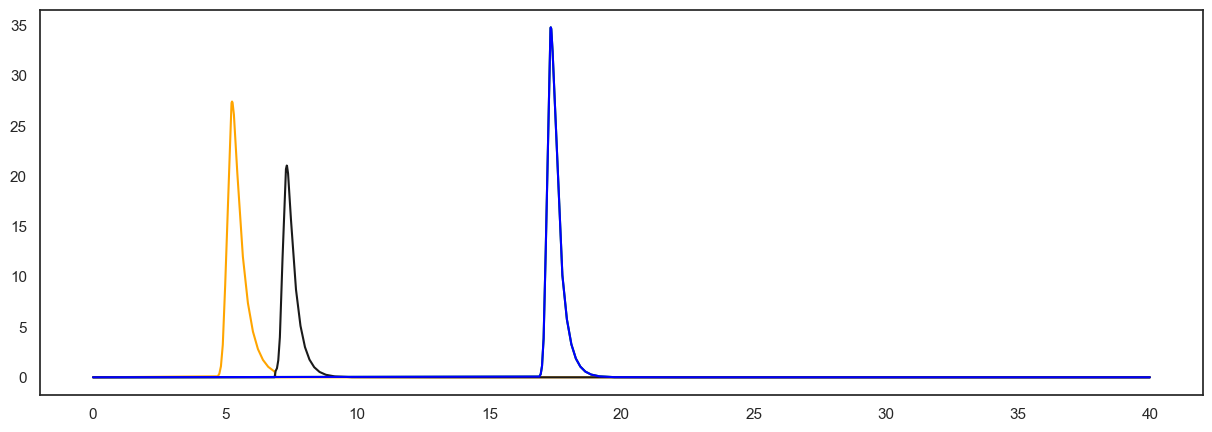

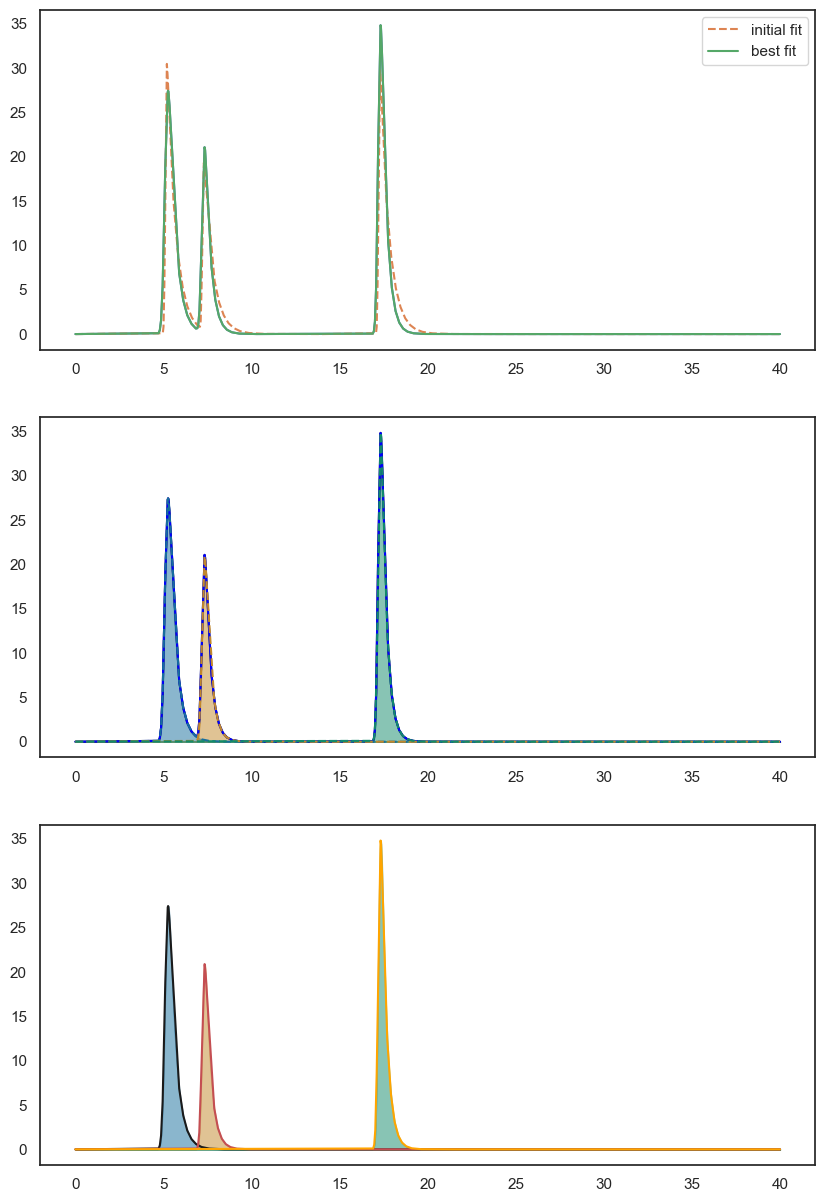

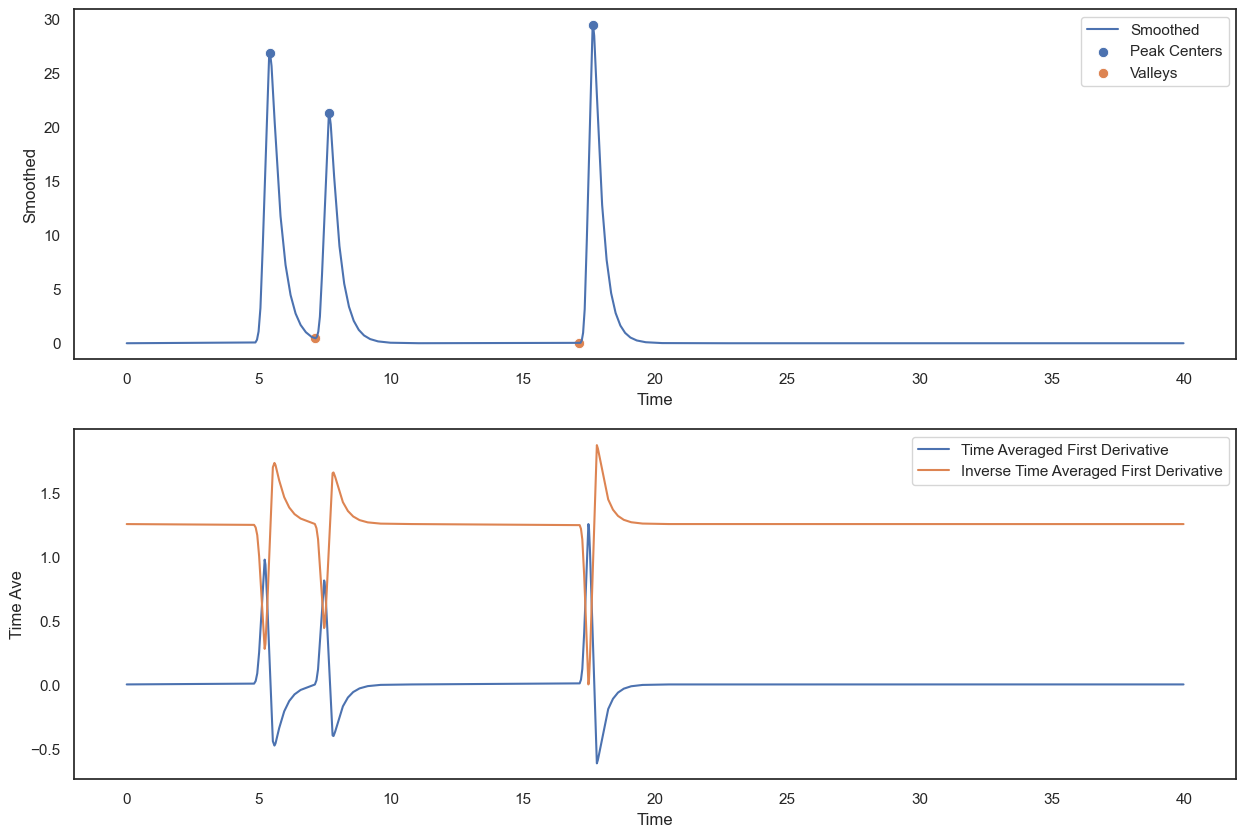

[0, 7.13, 17.1, 20]
[0, 7.13, 17.1, 20]
[0, 7.13, 17.1, 20]
0.07001509856369995 0.029560572835447663 0.0001601282847412268
6.323279213762095e-13
7.251574778685936e-11
8.95118006732209e-12
[0, 7.18, 17.16, 20]
[0, 7.18, 17.16, 20]
[0, 7.18, 17.16, 20]
0.058074154724201674 0.024606186645273094 0.0002852796828057343
3.447623795506806e-12
4.4060209281052765e-11
4.389261537066881e-11
[0, 4.9, 7.05, 16.88, 20]
[4.9, 7.05, 16.88, 20]
[4.9, 7.05, 16.88, 20]
0.032986303521112335 0.007647567553750329 1.0847344212284706e-05
3.440808929057383e-12
5.488662240510971e-11
3.528900374597837e-10
[0, 7.1000000000000005, 17.05, 20]
[0, 7.1000000000000005, 17.05, 20]
[0, 7.1000000000000005, 17.05, 20]
0.017893908627707216 0.007539513604011123 0.00010095258391129244
1.3681440547310324e-13
8.508140497882334e-12
6.283220418807736e-10
[0, 7.16, 16.88, 20]
[0, 7.16, 16.88, 20]
[0, 7.16, 16.88, 20]
0.08516737848133064 0.03603294861645805 6.635123870194654e-06
1.3325673737297045e-11
3.436089282436604e-11
5.840225

7.691240529763907e-12
4.162038838080517e-11
4.286731225408443e-11
[0, 7.12, 17.05, 20]
[0, 7.12, 17.05, 20]
[0, 7.12, 17.05, 20]
0.04174318760770897 0.017611656356979186 8.098742001173552e-05
8.528391245956394e-11
5.82960764289631e-11
1.4340129301141591e-09
[0, 7.13, 17.16, 20]
[0, 7.13, 17.16, 20]
[0, 7.13, 17.16, 20]
0.04580037859945238 0.01933921063694969 0.0003075002056498453
6.094020658112596e-12
2.9004940716330108e-11
5.746804451987811e-09
[0, 7.09, 16.9, 20]
[0, 7.09, 16.9, 20]
[0, 7.09, 16.9, 20]
0.08047973662641529 0.03388283057516891 9.135852122956413e-06
2.3678954266018186e-11
1.4283299130353423e-11
5.524263389664433e-10
[0, 7.17, 17.14, 20]
[0, 7.17, 17.14, 20]
[0, 7.17, 17.14, 20]
0.08890228041185846 0.03763976488587182 0.0001697911155396376
4.249148487251572e-11
4.403757834729383e-11
1.8233513555373306e-09
[0, 7.15, 16.94, 20]
[0, 7.15, 16.94, 20]
[0, 7.15, 16.94, 20]
0.08388919690628564 0.035467378399481345 1.2363829153480753e-05
3.400641353092931e-11
4.483231224374178e-

6.487322520630137e-12
2.1941660104011315e-11
1.8077896697054707e-10
[0, 7.140000000000001, 16.91, 20]
[0, 7.140000000000001, 16.91, 20]
[0, 7.140000000000001, 16.91, 20]
0.06387374682389085 0.02698618871784306 1.2992956290738034e-05
7.269997212293699e-12
2.152540155531575e-11
1.587956749764646e-10
[0, 7.0600000000000005, 17.05, 20]
[0, 7.0600000000000005, 17.05, 20]
[0, 7.0600000000000005, 17.05, 20]
0.03139803774798784 0.013191013147960593 5.135351809628624e-05
1.0939467534372912e-12
5.619851138841581e-11
1.291866623164245e-09
[0, 7.07, 17.11, 20]
[0, 7.07, 17.11, 20]
[0, 7.07, 17.11, 20]
0.02623789617986796 0.011032196569345174 0.0001727838571703589
3.999979014917839e-13
6.699767348262938e-12
7.499892623616631e-10
[0, 4.86, 7.13, 17.01, 20]
[4.86, 7.13, 17.01, 20]
[4.86, 7.13, 17.01, 20]
0.04801813685781412 0.011439182357661058 6.375533537844324e-05
1.605068602517791e-11
1.3832305784383383e-11
2.394252386224717e-09
[0, 4.9, 7.13, 17.14, 20]
[4.9, 7.13, 17.14, 20]
[4.9, 7.13, 17.14, 2

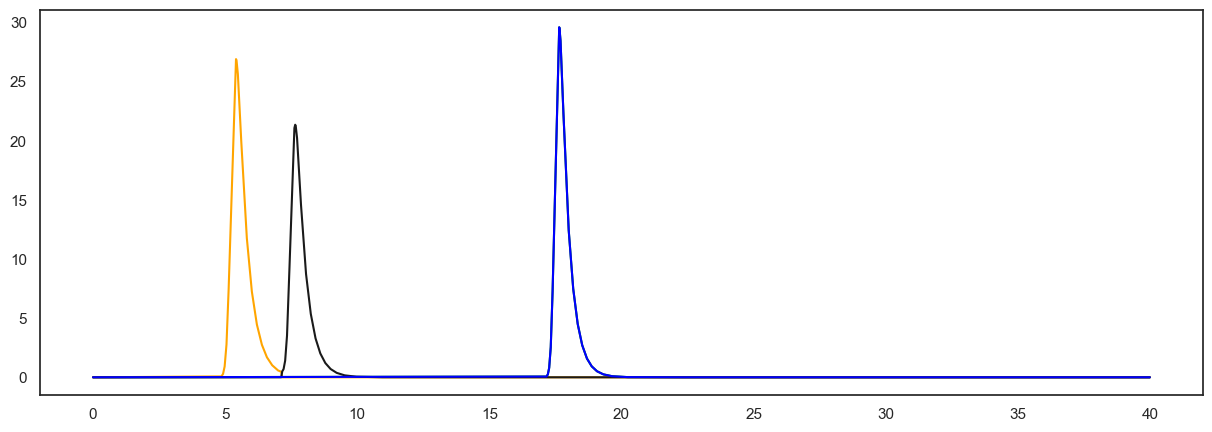

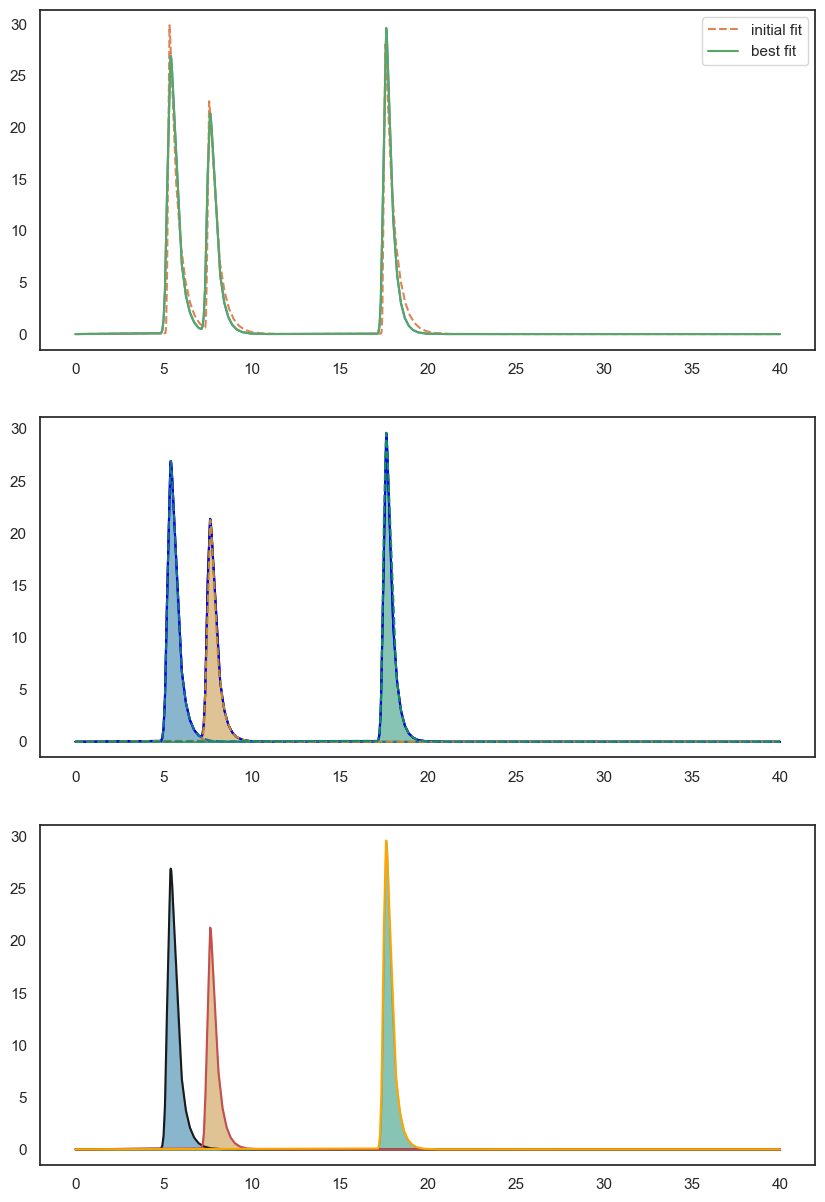

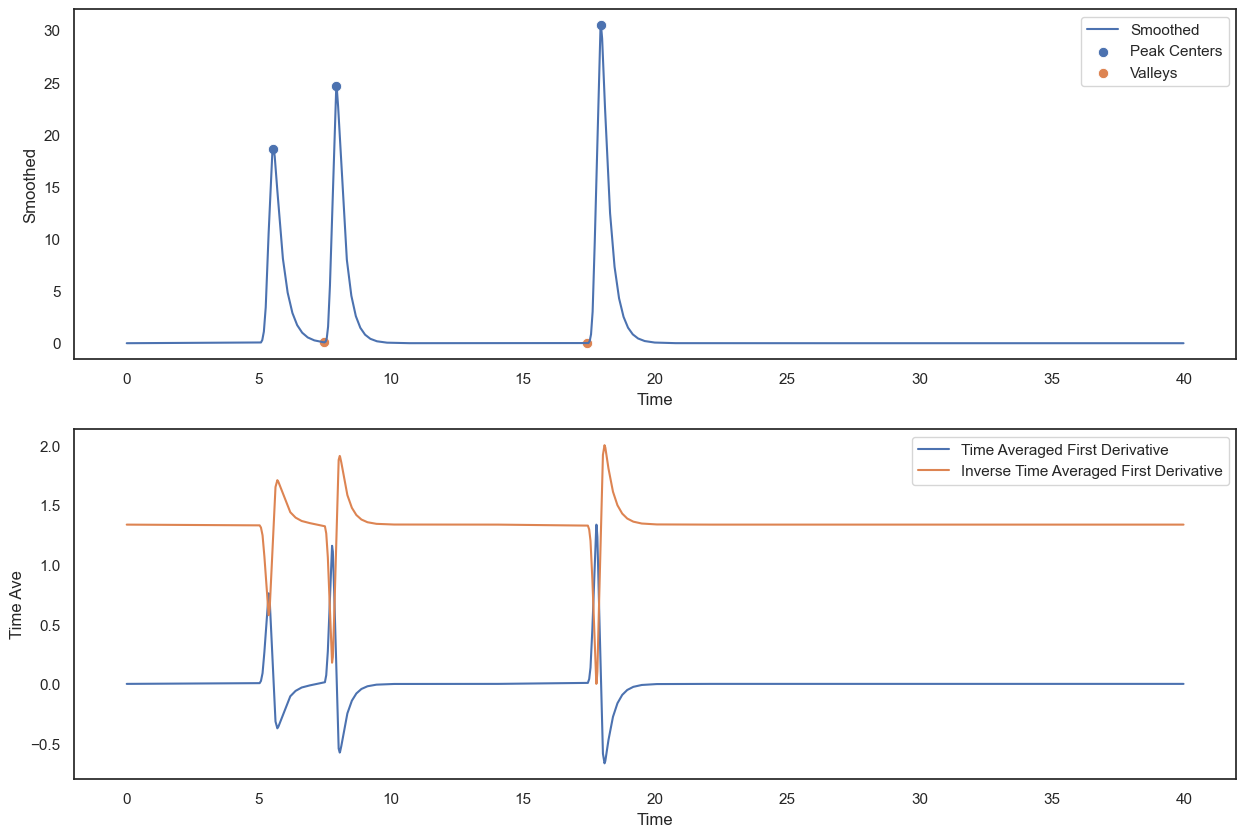

[0, 7.47, 17.42, 20]
[0, 7.47, 17.42, 20]
[0, 7.47, 17.42, 20]
0.014624216922778386 0.006323585533038994 0.00021894558861322276
2.4171686832607166e-11
1.0553957045479869e-10
2.757664048000567e-10
[0, 5.07, 7.42, 17.18, 20]
[5.07, 7.42, 17.18, 20]
[5.07, 7.42, 17.18, 20]
0.01470561027232256 0.003564411581658541 7.087413282910355e-06
2.656449680364331e-11
4.4293919776567047e-10
1.265701537459505e-10
[0, 5.03, 7.3500000000000005, 17.46, 20]
[5.03, 7.3500000000000005, 17.46, 20]
[5.03, 7.3500000000000005, 17.46, 20]
0.021608672624158304 0.005212372025676138 0.0002942917676801654
1.1939638602948577e-11
4.536450351449502e-14
1.9528199957301018e-10
[0, 7.37, 17.18, 20]
[0, 7.37, 17.18, 20]
[0, 7.37, 17.18, 20]
0.041012351193968115 0.017604288123099575 8.613903363196857e-06
1.963625293540974e-11
7.746331248633468e-12
1.9556359947472814e-10
[0, 7.45, 17.29, 20]
[0, 7.45, 17.29, 20]
[0, 7.45, 17.29, 20]
0.02671076043742196 0.01152751110724458 2.660153789652888e-05
2.6077877232740865e-13
5.206497

4.9995635601511947e-11
1.4539829580729177e-10
7.812542098397024e-10
[0, 7.36, 17.44, 20]
[0, 7.36, 17.44, 20]
[0, 7.36, 17.44, 20]
0.038157343157428504 0.01636853013327807 0.00016714289264875543
2.0914007733543934e-11
1.3535406480437648e-10
4.662826480960463e-11
[0, 7.37, 17.43, 20]
[0, 7.37, 17.43, 20]
[0, 7.37, 17.43, 20]
0.024755598079588294 0.010629485489276013 0.0002650637328750983
3.22354371291037e-11
9.33087351222596e-12
3.92796689211521e-09
[0, 7.36, 17.32, 20]
[0, 7.36, 17.32, 20]
[0, 7.36, 17.32, 20]
0.02800872147063912 0.01201447652857962 4.202649806808444e-05
6.036109049180646e-11
2.057325695651318e-11
1.3183195676022057e-10
[0, 7.45, 17.34, 20]
[0, 7.45, 17.34, 20]
[0, 7.45, 17.34, 20]
0.031182125631461645 0.013457512972456407 9.556050122513458e-05
8.708101080068476e-11
3.4104871912451086e-11
4.4047128060144715e-10
[0, 7.44, 17.42, 20]
[0, 7.44, 17.42, 20]
[0, 7.44, 17.42, 20]
0.01984954021922818 0.008562058952670438 0.0001551244109059438
5.609416855886175e-11
2.8269412186

1.03031139413526e-12
3.025620081156917e-12
7.257592462577196e-11
[0, 7.38, 17.43, 20]
[0, 7.38, 17.43, 20]
[0, 7.38, 17.43, 20]
0.04026372630071399 0.017296549818410663 0.0002553490925902744
9.524118434999554e-12
9.305459525251632e-12
6.392186994158522e-10
[0, 7.45, 17.37, 20]
[0, 7.45, 17.37, 20]
[0, 7.45, 17.37, 20]
0.014894112084937895 0.006428973547939556 0.00012252070784145633
2.433879331670445e-11
2.1151544220210422e-11
4.246533300783114e-09
[0, 7.46, 17.25, 20]
[0, 7.46, 17.25, 20]
[0, 7.46, 17.25, 20]
0.025289957001706914 0.010921646853947158 1.8465161708132074e-05
6.336818891122974e-12
6.214063410249659e-11
1.5941353788165929e-10
[0, 7.36, 17.23, 20]
[0, 7.36, 17.23, 20]
[0, 7.36, 17.23, 20]
0.014199663993496089 0.006090997460353668 1.5680460707692552e-05
6.985850024433556e-13
1.6732120964696633e-12
1.5855718296967282e-10
[0, 5.05, 7.4, 17.25, 20]
[5.05, 7.4, 17.25, 20]
[5.05, 7.4, 17.25, 20]
0.014290749831075963 0.0034639514382325673 2.663898998841348e-05
1.8214875267700634e-

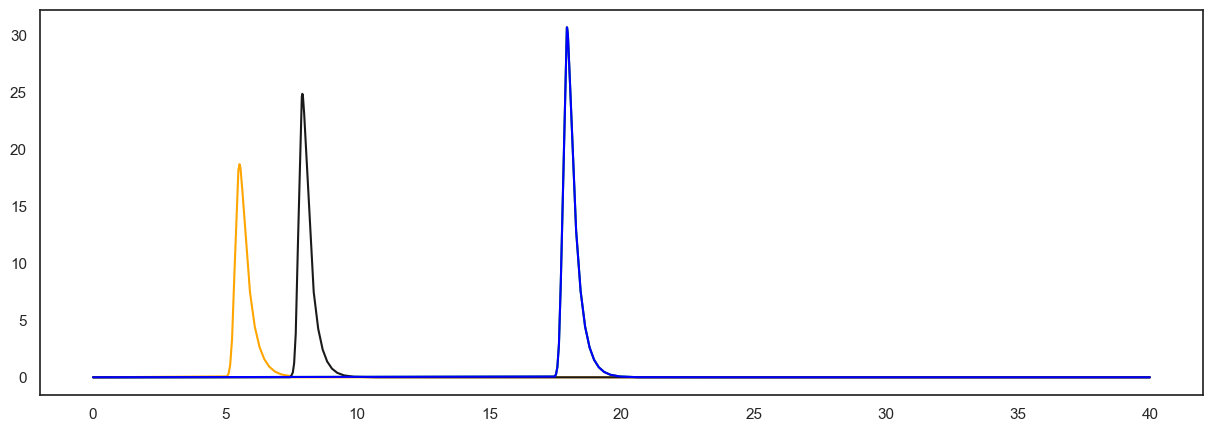

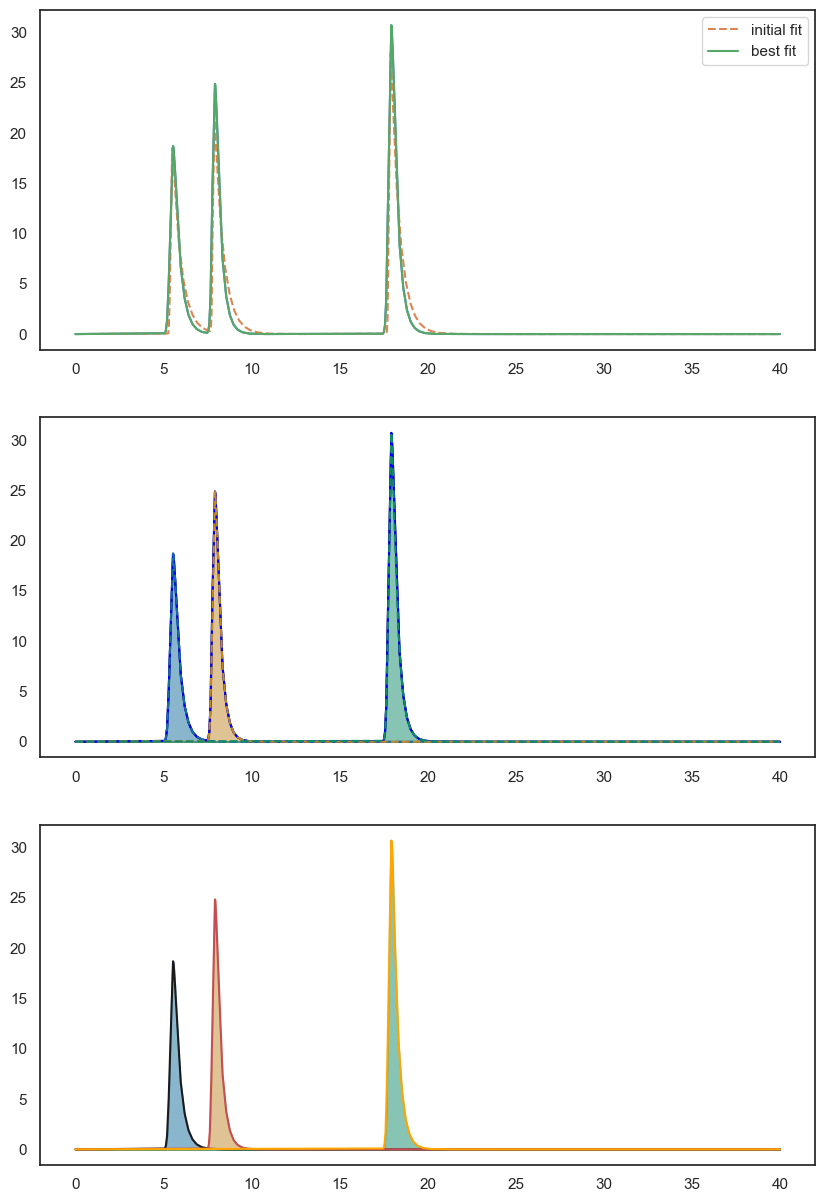

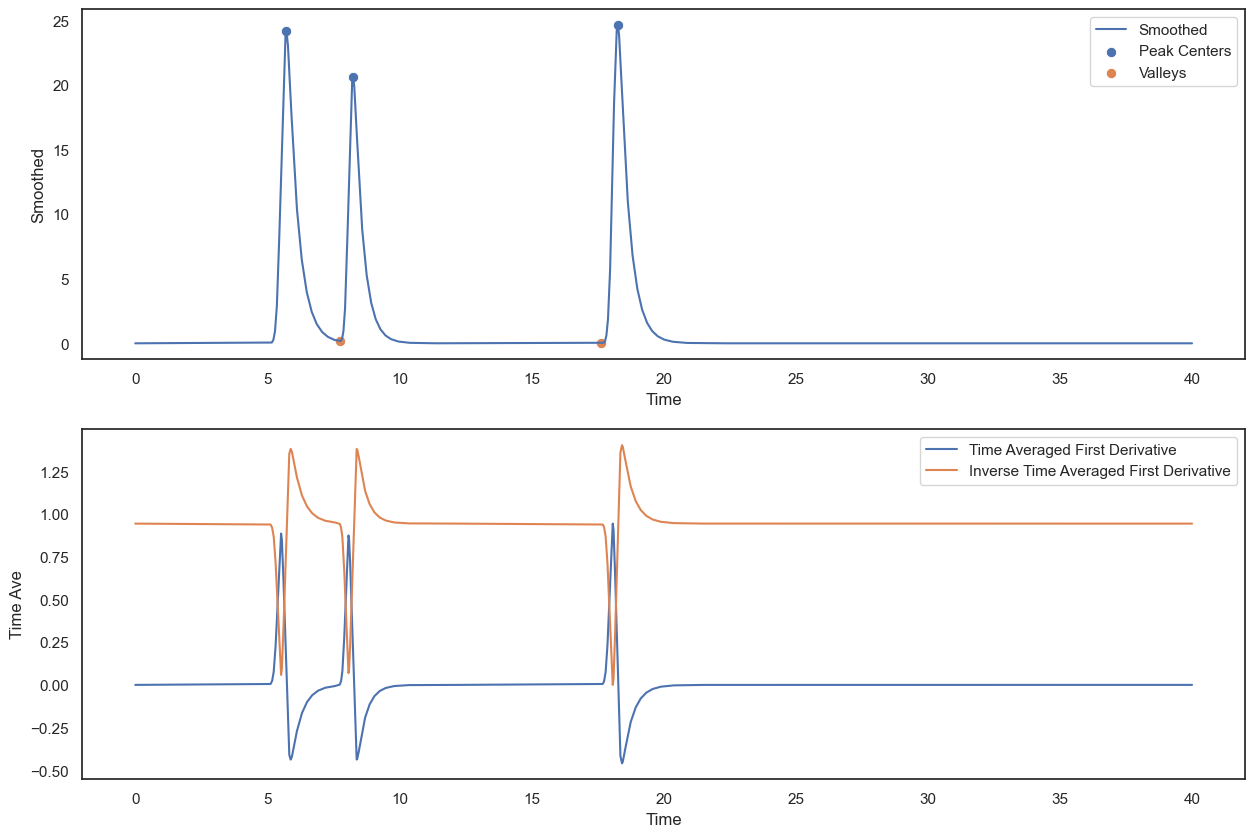

[0, 7.74, 17.63, 20]
[0, 7.74, 17.63, 20]
[0, 7.74, 17.63, 20]
0.02487772982993658 0.010943582541401103 6.76011233849243e-05
2.4593784298612207e-11
5.2767776148651094e-11
4.5181719330591597e-10
[0, 7.66, 17.56, 20]
[0, 7.66, 17.56, 20]
[0, 7.66, 17.56, 20]
0.010376566604048553 0.00454087843929136 1.310518676447205e-05
1.9010649234786396e-11
1.78036752002038e-11
4.1511732509957906e-11
[0, 7.74, 17.740000000000002, 20]
[0, 7.74, 17.740000000000002, 20]
[0, 7.74, 17.740000000000002, 20]
0.03747945228876148 0.016487694148505955 0.00018110852169383605
5.7926577865109495e-11
8.052556938475146e-12
1.3315267842896272e-11
[0, 7.67, 17.54, 20]
[0, 7.67, 17.54, 20]
[0, 7.67, 17.54, 20]
0.011368152564048292 0.004978082161474179 2.261255022206118e-05
4.359129565632591e-12
2.989871025112946e-10
5.475740091531963e-10
[0, 7.7700000000000005, 17.66, 20]
[0, 7.7700000000000005, 17.66, 20]
[0, 7.7700000000000005, 17.66, 20]
0.00831372566216855 0.0036650736935841545 8.1160334898658e-05
3.3102114341681988e

9.963371225702513e-12
6.710153715838571e-10
4.237595850605896e-10
[0, 7.72, 17.71, 20]
[0, 7.72, 17.71, 20]
[0, 7.72, 17.71, 20]
0.011574892983472983 0.0050870414412587895 0.00014215534589212162
1.2227254383256668e-11
7.172722443182653e-11
2.096017178509436e-09
[0, 7.72, 17.5, 20]
[0, 7.72, 17.5, 20]
[0, 7.72, 17.5, 20]
0.033918479379788084 0.014900990551009267 1.0649784063579444e-05
1.9484087405335704e-11
2.0515911279595525e-12
1.779861371677577e-10
[0, 7.71, 17.64, 20]
[0, 7.71, 17.64, 20]
[0, 7.71, 17.64, 20]
0.012099193308021242 0.005312519800055554 7.811437523804373e-05
9.126699303302833e-12
8.896165944432815e-11
3.1132160299486604e-10
[0, 5.21, 7.63, 17.63, 20]
[5.21, 7.63, 17.63, 20]
[5.21, 7.63, 17.63, 20]
0.014795274753421885 0.0036395866662149237 5.596178714318037e-05
3.409227517793506e-11
4.046109206203884e-11
2.9751960213739133e-10
[0, 7.7, 17.61, 20]
[0, 7.7, 17.61, 20]
[0, 7.7, 17.61, 20]
0.012447982785051968 0.00546163323402411 3.3534537921865317e-05
1.7372106670234428e-

5.8083761655718526e-11
1.94859947733998e-11
3.2566050723022464e-10
[0, 7.65, 17.76, 20]
[0, 7.65, 17.76, 20]
[0, 7.65, 17.76, 20]
0.028436298604923017 0.012438412893627807 0.0002548559950971521
2.946613185892235e-11
1.0351163590153615e-11
5.240882342267363e-10
[0, 7.640000000000001, 17.48, 20]
[0, 7.640000000000001, 17.48, 20]
[0, 7.640000000000001, 17.48, 20]
0.010739750955046612 0.004693662210891127 9.751402479404238e-06
8.304080837562475e-11
2.5183337889667424e-11
1.392989127401477e-10
[0, 7.68, 17.73, 20]
[0, 7.68, 17.73, 20]
[0, 7.68, 17.73, 20]
0.045837033093846964 0.020086418730492005 0.0002564481811359509
2.4844448230503965e-13
1.0793532494478266e-10
1.101892561249508e-09
[0, 7.72, 17.71, 20]
[0, 7.72, 17.71, 20]
[0, 7.72, 17.71, 20]
0.05272579932992215 0.02316412209192428 0.00018611474480544085
1.054524316877183e-11
2.2493164232674267e-11
3.085610523614674e-09
[0, 7.62, 17.69, 20]
[0, 7.62, 17.69, 20]
[0, 7.62, 17.69, 20]
0.01622124560615528 0.007080929473265338 0.000116293112

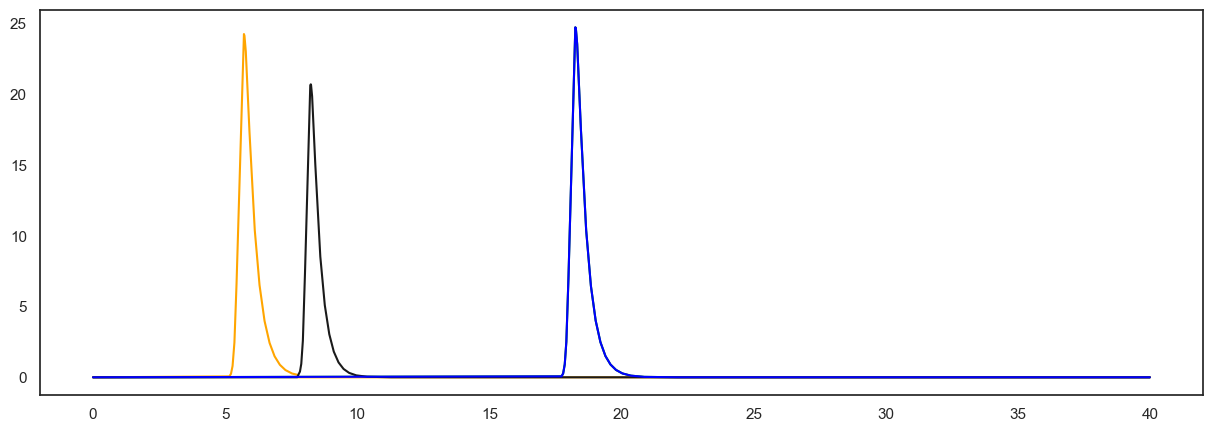

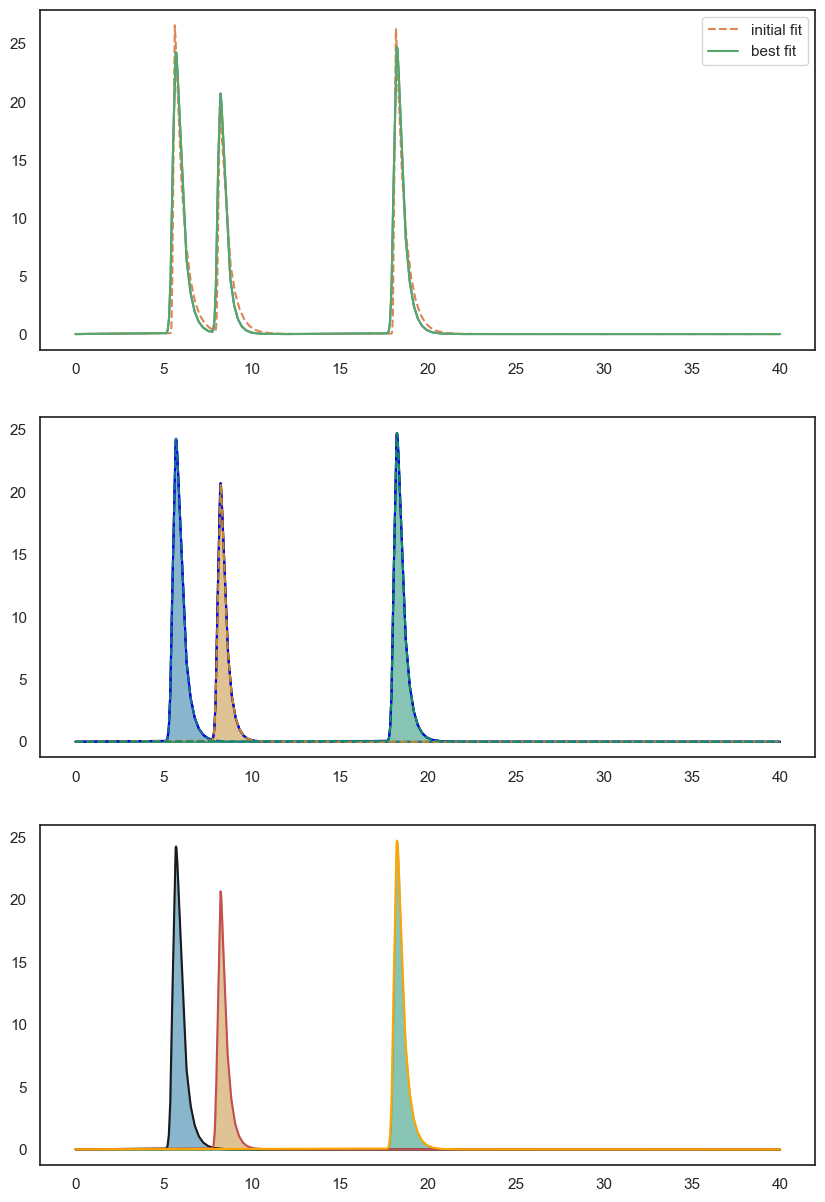

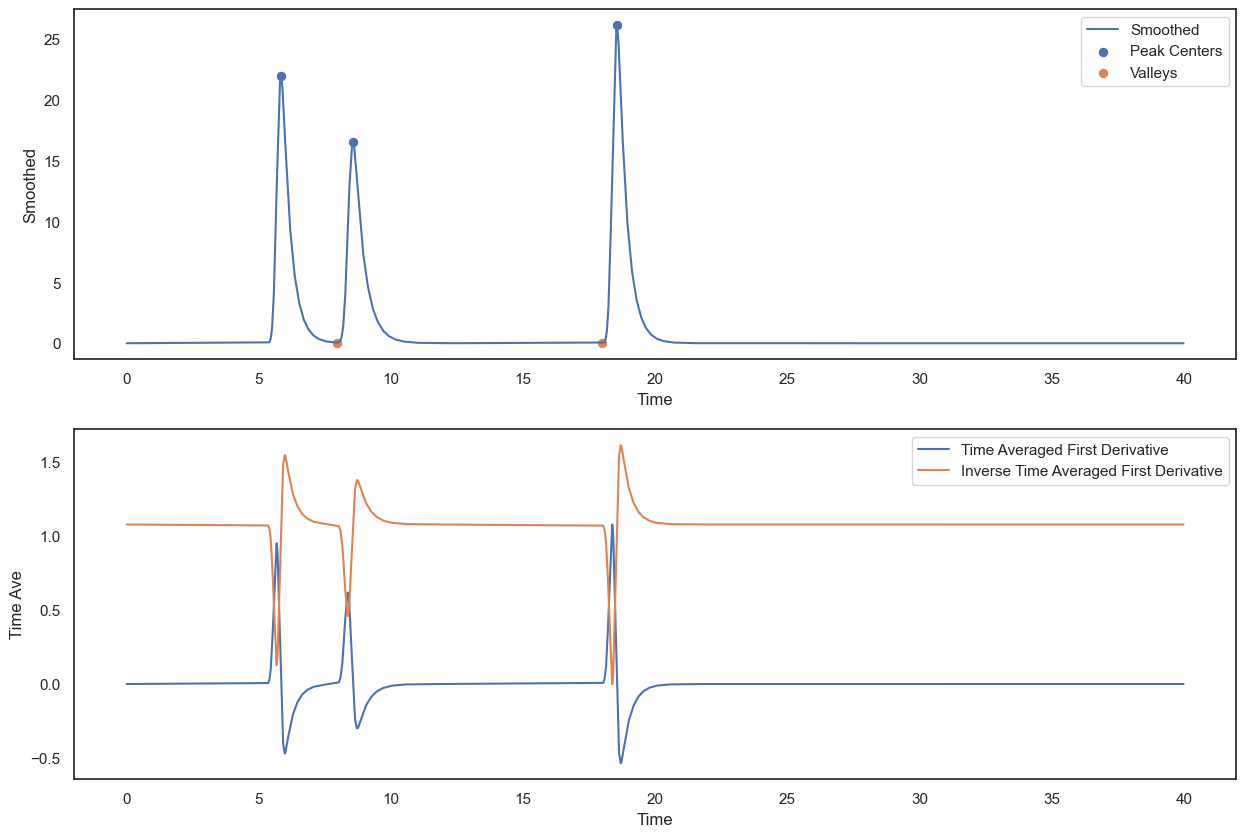

[0, 7.96, 17.98, 20]
[0, 7.96, 17.98, 20]
[0, 7.96, 17.98, 20]
0.006099365544127366 0.002723312260138438 0.00011480382434199892
1.6207356931274045e-11
1.2544905192581613e-10
4.823239493717201e-10
[0, 8.0, 17.79, 20]
[0, 8.0, 17.79, 20]
[0, 8.0, 17.79, 20]
0.013416426286665804 0.006000020568235248 1.216380442648607e-05
1.1745964851273729e-11
3.335004725382597e-11
3.8809802319761354e-10
[0, 5.3500000000000005, 7.99, 17.900000000000002, 20]
[5.3500000000000005, 7.99, 17.900000000000002, 20]
[5.3500000000000005, 7.99, 17.900000000000002, 20]
0.005996961813737401 0.0015410465271478943 3.507182824654628e-05
7.382776059980907e-11
4.0407610150791896e-12
3.5809272292263565e-13
[0, 8.03, 17.93, 20]
[0, 8.03, 17.93, 20]
[0, 8.03, 17.93, 20]
0.01800968945007589 0.008069417173930307 4.948761175637967e-05
4.8646406352261954e-11
5.936550970706951e-11
2.42289163569538e-10
[0, 8.06, 17.98, 20]
[0, 8.06, 17.98, 20]
[0, 8.06, 17.98, 20]
0.02319189412348644 0.010411231334634148 0.00011895951682553625
1.72

1.3560872461342991e-11
1.2570151203092522e-10
9.270160463310485e-10
[0, 5.36, 7.95, 17.84, 20]
[5.36, 7.95, 17.84, 20]
[5.36, 7.95, 17.84, 20]
0.005384550427784296 0.0013702721029086747 1.8001853493743717e-05
2.7930306386019232e-11
7.557394572403175e-11
5.709178172581124e-12
[0, 5.33, 7.98, 17.85, 20]
[5.33, 7.98, 17.85, 20]
[5.33, 7.98, 17.85, 20]
0.011732179248256099 0.0030198918761212617 2.880905609291001e-05
1.899031410701354e-11
1.086893918411181e-10
6.69853823130359e-10
[0, 7.930000000000001, 17.96, 20]
[0, 7.930000000000001, 17.96, 20]
[0, 7.930000000000001, 17.96, 20]
0.005791067140324301 0.0025805696720225925 0.0001036190619795691
6.336839388593647e-11
5.841145986306265e-11
9.701752627107884e-10
[0, 7.98, 18.0, 20]
[0, 7.98, 18.0, 20]
[0, 7.98, 18.0, 20]
0.029257347773068387 0.01306889134311076 0.00015949104817425676
9.451088206672198e-13
2.590598178973985e-10
5.231951717239005e-10
[0, 5.34, 8.02, 17.92, 20]
[5.34, 8.02, 17.92, 20]
[5.34, 8.02, 17.92, 20]
0.008045872490900517 

3.2919030520178167e-11
2.1858614804597115e-11
3.232057092008379e-09
[0, 8.02, 17.85, 20]
[0, 8.02, 17.85, 20]
[0, 8.02, 17.85, 20]
0.020831660847412458 0.009327856354326246 1.75039359978711e-05
2.0202686915069016e-11
3.634580007724441e-11
2.341075942694045e-11
[0, 8.02, 17.92, 20]
[0, 8.02, 17.92, 20]
[0, 8.02, 17.92, 20]
0.017910657825929766 0.008020025589290021 4.5627507709373494e-05
1.1749609824457193e-11
5.855798900818925e-11
1.5161846890934846e-11
[0, 8.03, 17.86, 20]
[0, 8.03, 17.86, 20]
[0, 8.03, 17.86, 20]
0.03235725769478899 0.014497738227671518 2.7285866563624806e-05
1.4233501029082336e-14
1.952466506536357e-12
2.368924044986077e-11
[0, 5.3500000000000005, 8.07, 17.830000000000002, 20]
[5.3500000000000005, 8.07, 17.830000000000002, 20]
[5.3500000000000005, 8.07, 17.830000000000002, 20]
0.004942878364528724 0.0012891641680856801 2.377158960255339e-05
7.877355823381724e-14
1.0176822082708142e-10
1.4141416288675573e-10
[0, 7.930000000000001, 18.04, 20]
[0, 7.930000000000001, 18.

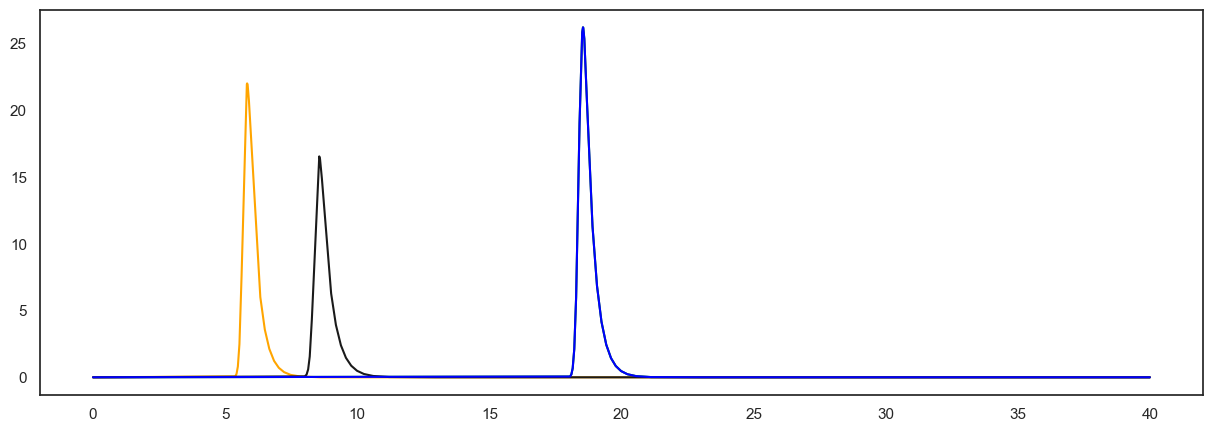

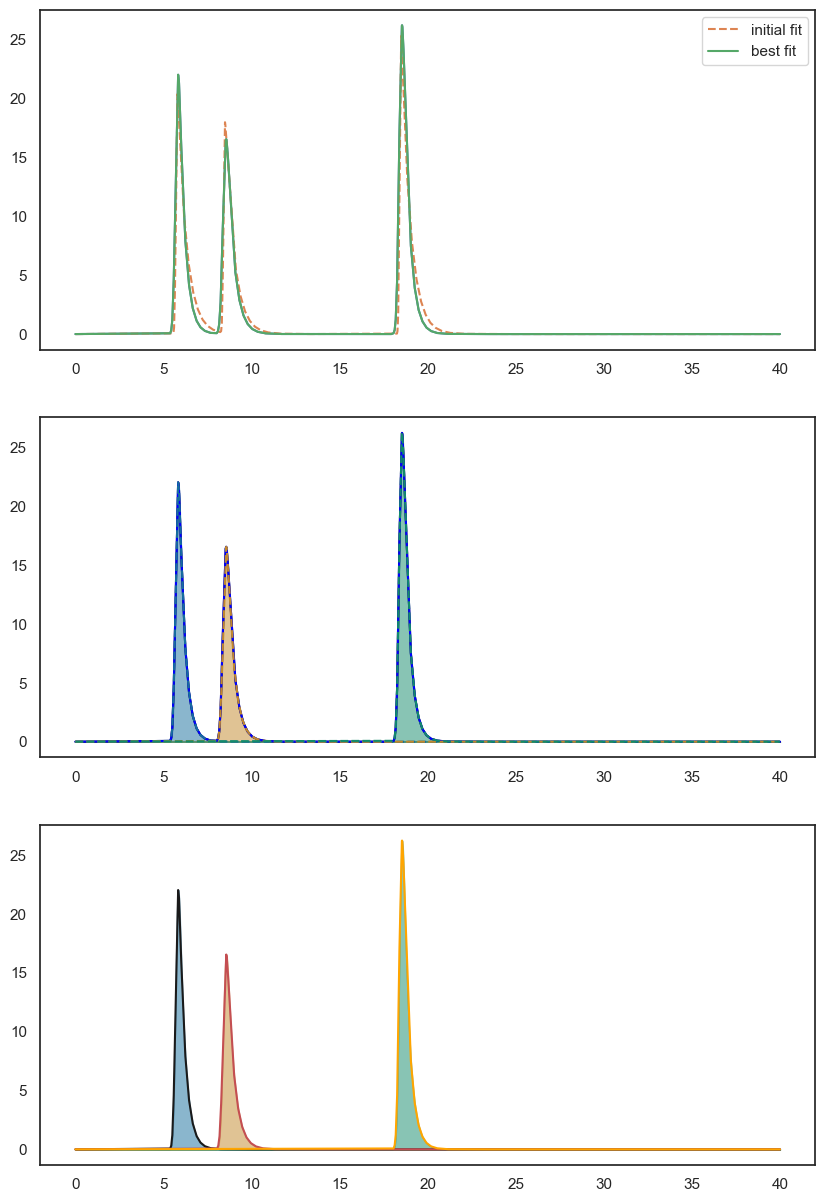

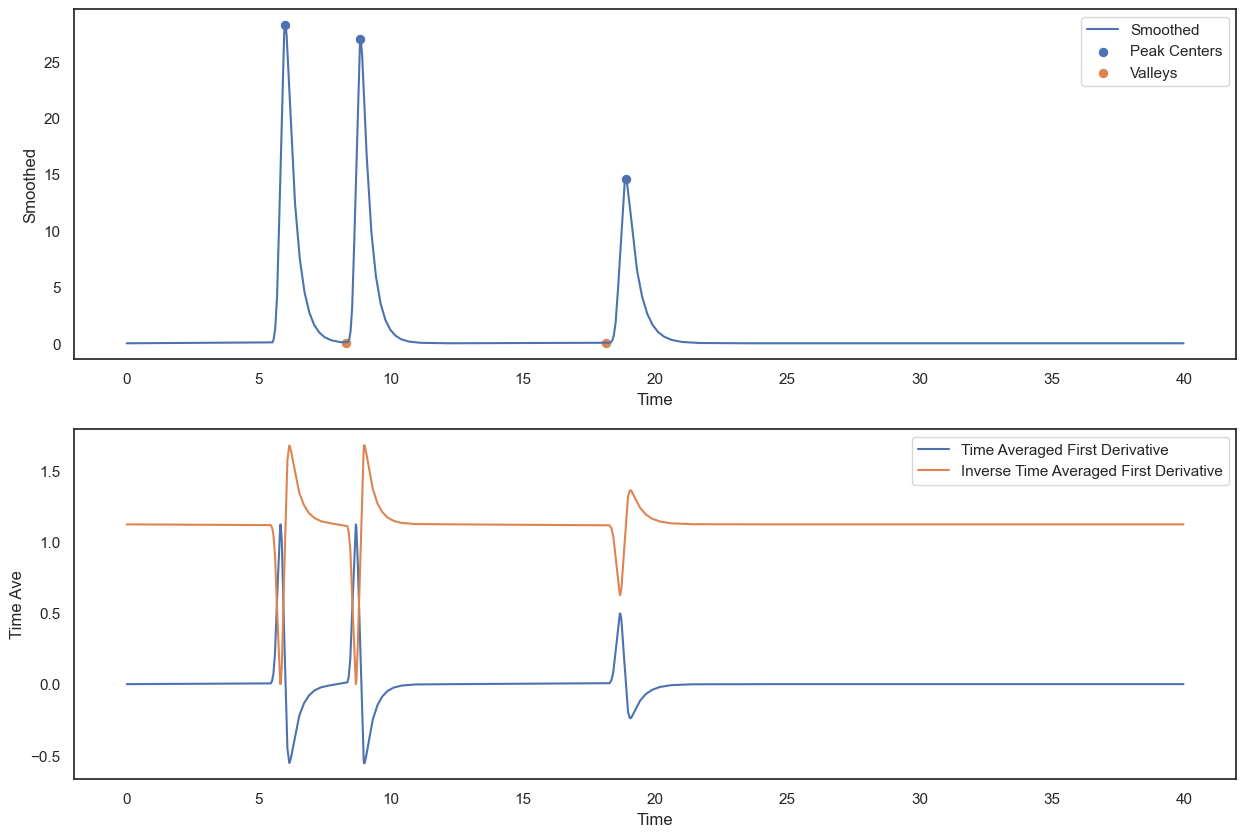

[0, 8.3, 18.12, 20]
[0, 8.3, 18.12, 20]
[0, 8.3, 18.12, 20]
0.008291292967630218 0.003776877558579397 1.0233983716646749e-05
1.04892909997063e-10
3.5758879580678205e-12
1.3557466616755042e-10
[0, 8.22, 18.17, 20]
[0, 8.22, 18.17, 20]
[0, 8.22, 18.17, 20]
0.031836601270877674 0.01443222623469254 2.6220229966645376e-05
1.8599499680819912e-11
6.0194126786917224e-12
1.0158522313510303e-09
[0, 8.27, 18.21, 20]
[0, 8.27, 18.21, 20]
[0, 8.27, 18.21, 20]
0.017911718799059752 0.00814457700022315 5.0991866645332294e-05
4.324306506571158e-12
1.8767201096621555e-11
4.5469822377145667e-10
[0, 8.32, 18.29, 20]
[0, 8.32, 18.29, 20]
[0, 8.32, 18.29, 20]
0.01109098771619953 0.0050593668851651894 0.00010541113012886417
4.4990541311641385e-12
1.3384486290281022e-11
3.612730277589418e-10
[0, 8.22, 18.14, 20]
[0, 8.22, 18.14, 20]
[0, 8.22, 18.14, 20]
0.006606504690060132 0.0029949063776803534 1.5195193459245315e-05
6.624559269951277e-14
5.827163977278084e-13
7.011662707674625e-12
[0, 8.32, 18.14, 20]
[0, 8

3.3078597471748937e-12
2.9557649223240743e-12
4.792270079552395e-10
[0, 8.27, 18.240000000000002, 20]
[0, 8.27, 18.240000000000002, 20]
[0, 8.27, 18.240000000000002, 20]
0.009961289528919504 0.004529998681488082 7.514011716813925e-05
4.807302335713032e-11
7.003968840628167e-11
3.7233093226084514e-12
[0, 8.24, 18.11, 20]
[0, 8.24, 18.11, 20]
[0, 8.24, 18.11, 20]
0.017312686893200018 0.007857767296131577 1.751065316774879e-05
4.662693471641654e-11
2.824792854193475e-12
2.104271869268257e-10
[0, 8.35, 18.2, 20]
[0, 8.35, 18.2, 20]
[0, 8.35, 18.2, 20]
0.01021156754116897 0.004665662882893362 2.7781834189248765e-05
2.791741587609562e-13
1.0086142195840946e-10
7.987689218782762e-11
[0, 5.51, 8.18, 18.26, 20]
[5.51, 8.18, 18.26, 20]
[5.51, 8.18, 18.26, 20]
0.006335154903660513 0.0016394844723650861 9.461664369193217e-05
7.256924231417376e-14
4.5151634012064335e-10
2.045971414838775e-10
[0, 8.32, 18.080000000000002, 20]
[0, 8.32, 18.080000000000002, 20]
[0, 8.32, 18.080000000000002, 20]
0.0077

8.452632566607166e-11
2.0461078607881478e-10
2.1245992902881788e-09
[0, 8.28, 18.23, 20]
[0, 8.28, 18.23, 20]
[0, 8.28, 18.23, 20]
0.01492208398975496 0.006789453171192689 6.539197313525678e-05
5.879286080877753e-14
1.828606692044832e-12
7.949339135808155e-10
[0, 5.47, 8.3, 18.26, 20]
[5.47, 8.3, 18.26, 20]
[5.47, 8.3, 18.26, 20]
0.006701532206675841 0.0017852869383006436 9.91422081208786e-05
3.8991240722134097e-10
2.1309255429909614e-12
3.0778859839336513e-10
[0, 5.49, 8.2, 18.23, 20]
[5.49, 8.2, 18.23, 20]
[5.49, 8.2, 18.23, 20]
0.009054696124186284 0.0023582260435807616 8.108923359981375e-05
3.738047537992967e-11
1.517970641435318e-14
3.1094640801265037e-09
[0, 8.32, 18.330000000000002, 20]
[0, 8.32, 18.330000000000002, 20]
[0, 8.32, 18.330000000000002, 20]
0.003653136529798697 0.001678809074520613 0.000206289494594306
4.905503608941029e-11
2.0291144899728887e-10
1.761851164688871e-12
[0, 8.27, 18.13, 20]
[0, 8.27, 18.13, 20]
[0, 8.27, 18.13, 20]
0.02037572823706486 0.00926480820047

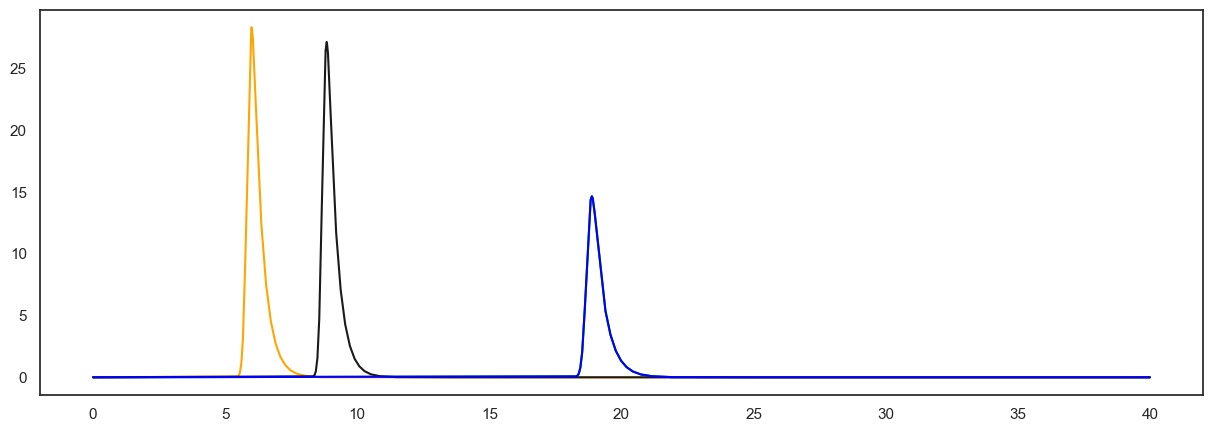

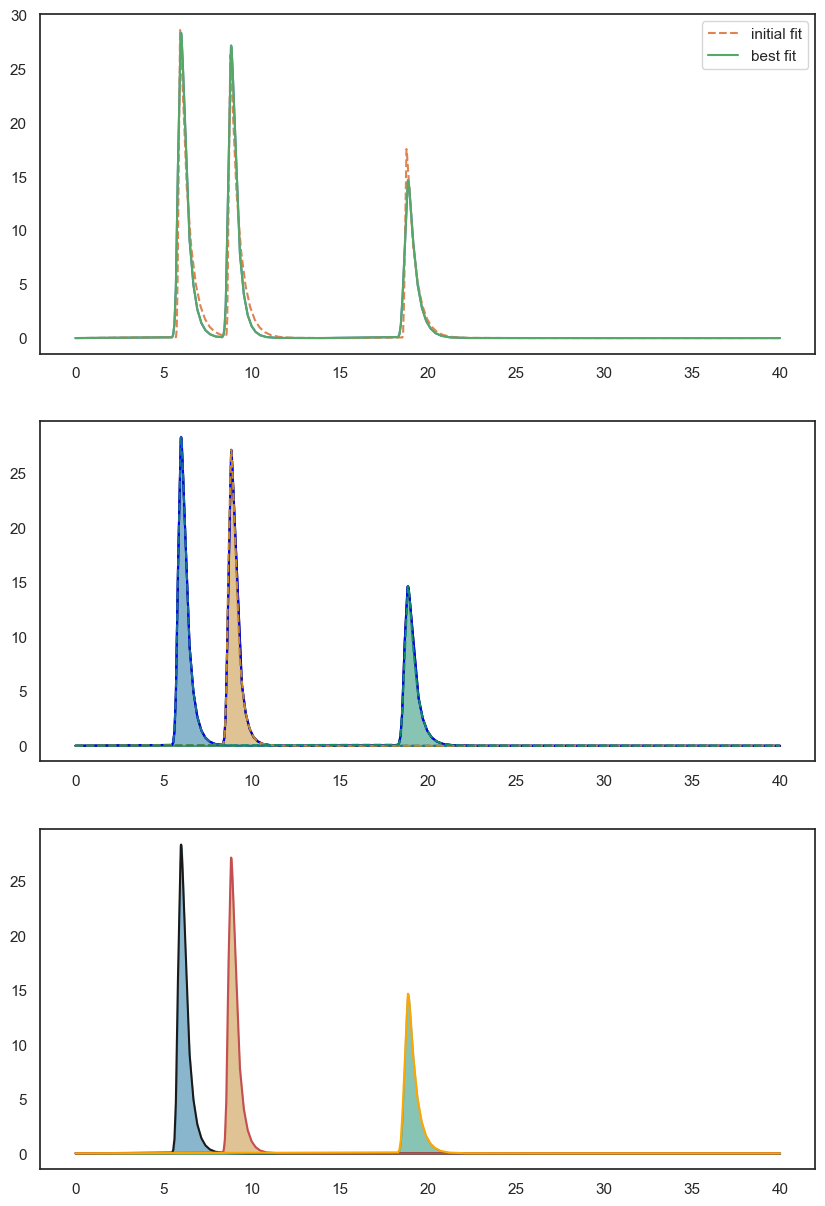

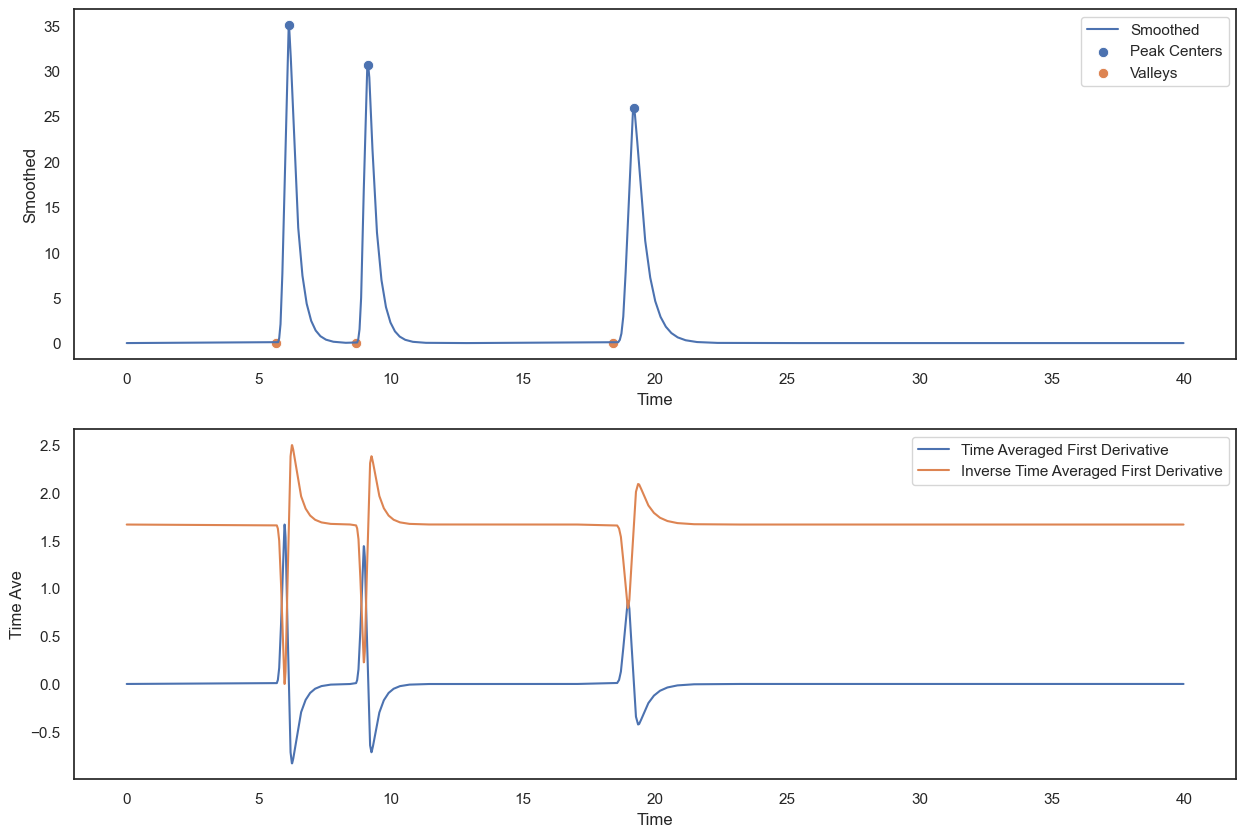

[0, 5.66, 8.66, 18.41, 20]
[5.66, 8.66, 18.41, 20]
[5.66, 8.66, 18.41, 20]
0.0022874407819129436 0.0006266397910611113 1.576476876519378e-05
4.599333199587327e-11
1.5257372482952632e-10
1.7457771195881674e-11
[0, 8.58, 18.62, 20]
[0, 8.58, 18.62, 20]
[0, 8.58, 18.62, 20]
0.0058608696358917346 0.0027216046001957285 0.00019773979147160264
1.670382982960347e-12
1.8128598338040254e-10
1.1999634060295764e-09
[0, 8.6, 18.59, 20]
[0, 8.6, 18.59, 20]
[0, 8.6, 18.59, 20]
0.004112205231939098 0.0019112526527478534 0.00013109862956670206
1.5975584369198284e-10
3.746372043664421e-12
4.880555601850275e-09
[0, 8.66, 18.55, 20]
[0, 8.66, 18.55, 20]
[0, 8.66, 18.55, 20]
0.011242773777463926 0.005231995171399841 9.045250012732692e-05
5.412550056365913e-11
5.925927224669393e-12
5.286886819930628e-10
[0, 5.65, 8.5, 18.56, 20]
[5.65, 8.5, 18.56, 20]
[5.65, 8.5, 18.56, 20]
0.00302222550696175 0.0008095842194327793 6.811760815534309e-05
3.3210689460228886e-11
5.4381020160521433e-11
3.566781668352529e-10
[0,

5.2254747465298895e-12
2.207234256806858e-10
7.556766163712241e-12
[0, 5.65, 8.44, 18.66, 20]
[5.65, 8.44, 18.66, 20]
[5.65, 8.44, 18.66, 20]
0.002454129584627862 0.0006843653525634619 0.000219702031223312
2.0780801023843289e-13
5.844752215313863e-10
5.47514215737007e-10
[0, 8.59, 18.55, 20]
[0, 8.59, 18.55, 20]
[0, 8.59, 18.55, 20]
0.008541509540705953 0.003959033482886822 7.967207554483664e-05
2.538574810617993e-12
4.659076971398817e-11
1.3925553963844645e-09
[0, 8.56, 18.38, 20]
[0, 8.56, 18.38, 20]
[0, 8.56, 18.38, 20]
0.012727309629914781 0.005887678188791298 9.519758379348601e-06
1.2086288808063656e-11
1.2183965310404176e-10
3.2910997077264795e-11
[0, 8.65, 18.57, 20]
[0, 8.65, 18.57, 20]
[0, 8.65, 18.57, 20]
0.00470969804200571 0.0021922296228975634 9.578197050046669e-05
3.829724946089006e-12
4.482554662952069e-10
3.6104373693089274e-10
[0, 8.49, 18.400000000000002, 20]
[0, 8.49, 18.400000000000002, 20]
[0, 8.49, 18.400000000000002, 20]
0.007298910642256175 0.0033626627072033594

1.2317239834066243e-11
3.6840697615106503e-10
5.399696317350554e-10
[0, 8.66, 18.48, 20]
[0, 8.66, 18.48, 20]
[0, 8.66, 18.48, 20]
0.005252236696691601 0.0024442494823501597 4.4594036636444536e-05
4.342203091702861e-14
3.321930320669799e-11
4.721444661984756e-10
[0, 5.66, 8.66, 18.5, 20]
[5.66, 8.66, 18.5, 20]
[5.66, 8.66, 18.5, 20]
0.0020340488492776323 0.000558301310639311 3.739985786060062e-05
1.5145131190653552e-11
1.7557095349917452e-10
2.2489799688043142e-11
[0, 8.620000000000001, 18.42, 20]
[0, 8.620000000000001, 18.42, 20]
[0, 8.620000000000001, 18.42, 20]
0.013209784242226191 0.006132252470825148 1.0734288086607806e-05
1.3816674686967947e-11
1.561826227791375e-12
1.041600578873628e-10
[0, 8.6, 18.490000000000002, 20]
[0, 8.6, 18.490000000000002, 20]
[0, 8.6, 18.490000000000002, 20]
0.005145218354609256 0.002385994793001856 3.489541748080943e-05
4.408420528866118e-11
4.0375443286316614e-11
8.378300663747748e-11
[0, 8.5, 18.44, 20]
[0, 8.5, 18.44, 20]
[0, 8.5, 18.44, 20]
0.00402

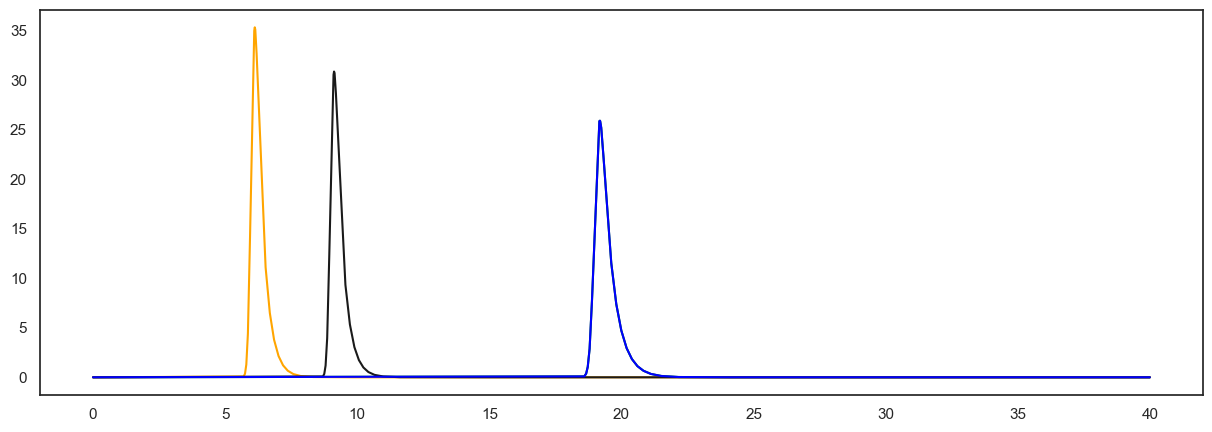

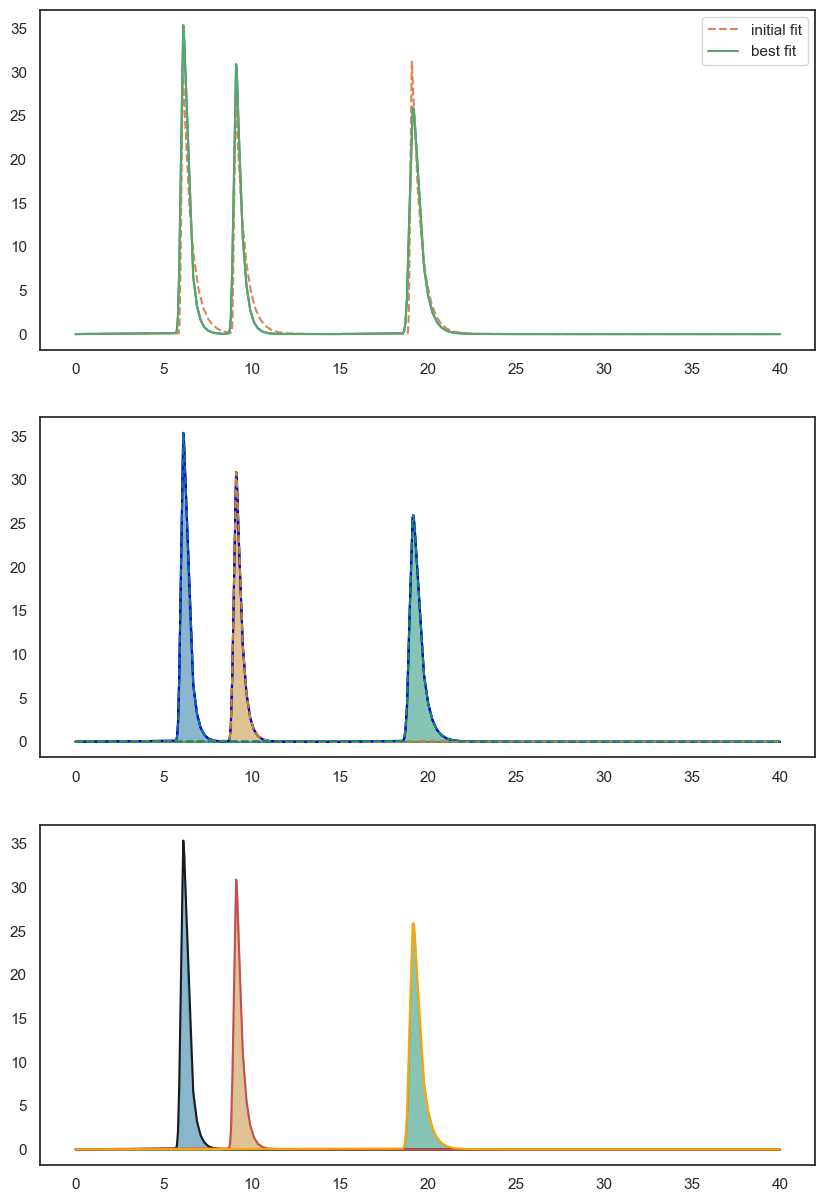

In [18]:
error_list=[]
for j in [0.1,0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    for n in range(100):
        amps=[]
        gammas=[]
        sigmas=[]
        center=[]

        amps.append(random.uniform(10,20))
        gammas.append(random.uniform(2.9,3))
        sigmas.append(random.uniform(0.1,0.15))
        center.append(3+j*0.15)
        
        amps.append(random.uniform(10,20))
        gammas.append(random.uniform(2.9,3))
        sigmas.append(random.uniform(0.1,0.15))
        center.append(max(center)+j*0.15)
        
        amps.append(random.uniform(10,20))
        gammas.append(random.uniform(2.9,3))
        sigmas.append(random.uniform(0.1,0.15))
        center.append(max(center)+10)
        x =np.arange(0,40,0.01)
        areas,y=_ngaussian_exp(x,amps,center,sigmas,gammas,noise='None')
        #k=pybaselines.whittaker.psalsa(y,lam=1e11)[0]
        #y=y-k
        #z=low_pass_filter(y,2000,500)
        #z=np.convolve(z, np.ones(10)/10, mode='same')
        """
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        
        ax.plot(x,z)
        ax.plot(x,y)
        """
        df = pd.DataFrame()
        df["Time"]=x
        df["Value"]=y
        if n<1:
            graph=True
        else:
            graph=False
        centers,heights,valleys=find_locations_peaks(df,0.01,1,graph=graph,shoulder=False, shoulder_cutoffs=None)


        if len(valleys)>4:
            valleys=valleys[1:]
        if len(valleys)<4:
            valleys=[0,(center[0]+center[1])/2,(center[1]+center[2])/2,20]
        print(valleys)
        _,y1=_ngaussian_exp(x,[amps[0]],[center[0]],[sigmas[0]],[gammas[0]],noise='None')
        y_1=y[:int(valleys[1]*100)]
        z1=np.zeros(4000-int(valleys[1]*100))
        y_1=np.concatenate((y_1,z1))

        _,y2=_ngaussian_exp(x,[amps[1]],[center[1]],[sigmas[1]],[gammas[1]],noise='None')
        y_2=y[int(valleys[1]*100):int(valleys[2]*100)]
        z1=np.zeros(int(valleys[1]*100))
        z2=np.zeros(4000-int(valleys[2]*100))
        y_2=np.concatenate((z1,y_2,z2))
        
        _,y3=_ngaussian_exp(x,[amps[2]],[center[2]],[sigmas[2]],[gammas[2]],noise='None')
        y_3=y[int(valleys[2]*100):]
        z3=np.zeros(int(valleys[2]*100))
        y_3=np.concatenate((z3,y_3))
        y1_error=0
        for i in range(len(y)):
            y1_error+=(y_1[i]-y1[i])*(y_1[i]-y1[i])
        y1_error=math.sqrt(y1_error/(valleys[1]*100-valleys[0]*100))
        
        y2_error=0
        for i in range(len(y)):
            y2_error+=(y_2[i]-y2[i])*(y_2[i]-y2[i])
        y2_error=math.sqrt(y2_error/(len(y)))
        
        y3_error=0
        print(valleys)
        for i in range(len(y)):
            #print(i,y3_error)
            y3_error+=(y_3[i]-y3[i])*(y_3[i]-y3[i])
        y3_error=math.sqrt(y3_error/(len(y)))
          
        if graph:
            fig,ax=plt.subplots(1,1,figsize=(15,5))
            ax.plot(x,y3,color="green")
            ax.plot(x,y_1,color='orange')
            ax.plot(x,y_2,color='k')
            ax.plot(x,y_3,color='blue')
        print(y1_error,y2_error,y3_error)
        error_list.append({"Peak Number":1,"RMSE":y1_error,"Algorithm":"Valley-to-Valley","Sigma Between Peaks":j})
        error_list.append({"Peak Number":2,"RMSE":y2_error,"Algorithm":"Valley-to-Valley","Sigma Between Peaks":j})
        error_list.append({"Peak Number":3,"RMSE":y3_error,"Algorithm":"Valley-to-Valley","Sigma Between Peaks":j})
        area=find_peak_areas(df,"sample",0,40,canonical_peaks=[center,amps,valleys],comparisons=True,graph=graph,peak1=y1,peak2=y2,peak3=y3)
        error_list.append({"Peak Number":1,"RMSE":area[0][2],"Algorithm":"PeakClimber","Sigma Between Peaks":j})
        error_list.append({"Peak Number":2,"RMSE":area[1][2],"Algorithm":"PeakClimber","Sigma Between Peaks":j})
        error_list.append({"Peak Number":3,"RMSE":area[2][2],"Algorithm":"PeakClimber","Sigma Between Peaks":j})
        #print(area)

In [19]:
dataframe=pd.DataFrame(error_list)
dataframe.to_csv("movement_error.csv")

In [20]:
dataframe=pd.read_csv("movement_error.csv")
dataframe

Unnamed: 0  Peak Number          RMSE         Algorithm  \
0               0            1  6.483278e+00  Valley-to-Valley   
1               1            2  1.782165e+00  Valley-to-Valley   
2               2            3  2.165834e-05  Valley-to-Valley   
3               3            1  1.131285e-02       PeakClimber   
4               4            2  1.131286e-02       PeakClimber   
...           ...          ...           ...               ...   
13195       13195            2  1.246771e-03  Valley-to-Valley   
13196       13196            3  1.507130e-05  Valley-to-Valley   
13197       13197            1  2.153384e-08       PeakClimber   
13198       13198            2  7.618356e-08       PeakClimber   
13199       13199            3  2.600681e-07       PeakClimber   

       Sigma Between Peaks  
0                      0.1  
1                      0.1  
2                      0.1  
3                      0.1  
4                      0.1  
...                    ...  
13195                 20.0  
13196                 20.0  
13197                 20.0  
13198                 20.0  
13199                 20.0  

[13200 rows x 5 columns]

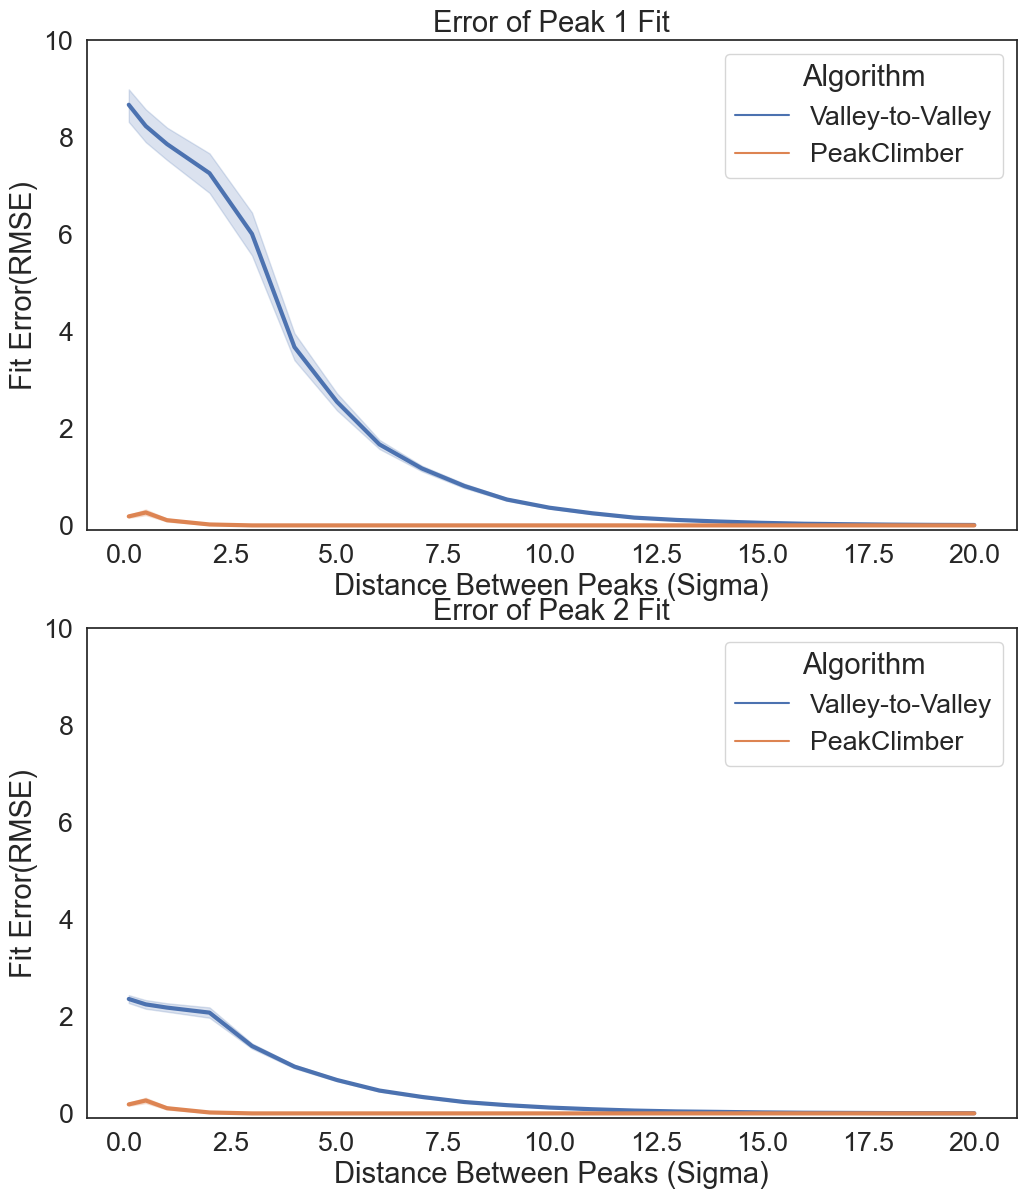

In [33]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=1.75)
sns.set_style("white")
fig,ax=plt.subplots(2, 1, figsize=(12, 14))

sns.lineplot(data=dataframe[dataframe["Peak Number"]==1],x="Sigma Between Peaks",y="RMSE",hue="Algorithm",ax=ax[0],linewidth=3)
ax[0].set_title("Error of Peak 1 Fit")
ax[1].set_title("Error of Peak 2 Fit")
ax[0].set_ylabel("Fit Error(RMSE)")
ax[1].set_ylabel("Fit Error(RMSE)")

ax[0].set_ylim(-0.1,10)
ax[1].set_ylim(-0.1,10)
sns.lineplot(data=dataframe[dataframe["Peak Number"]==2],x="Sigma Between Peaks",y="RMSE",hue="Algorithm",ax=ax[1],linewidth=3)
ax[0].set_xlabel("Distance Between Peaks (Sigma)")
ax[1].set_xlabel("Distance Between Peaks (Sigma)")
plt.show()

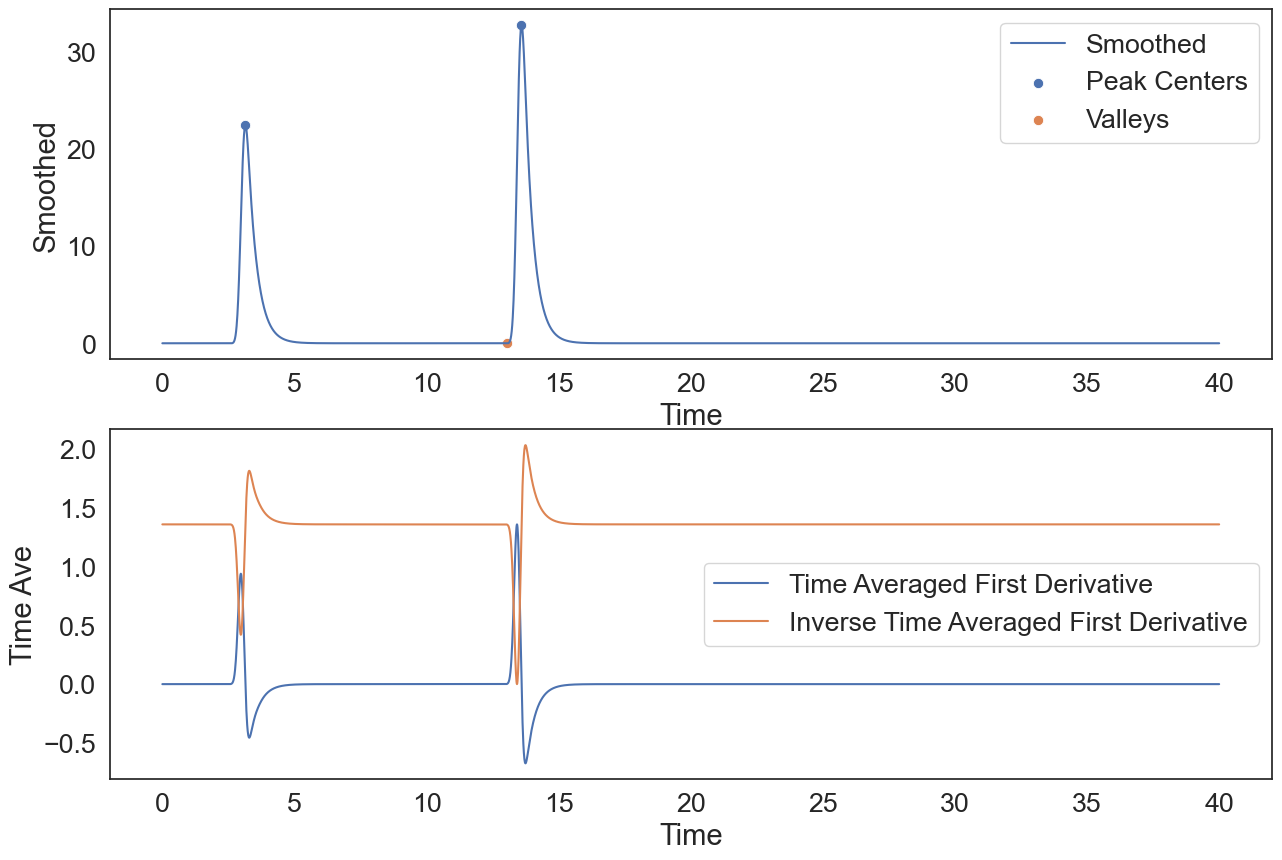

[0, 13.030000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.085481963123136 1.4439992981397909 4.212703252745661e-07
3.3707878274653993e-10
3.368557561607324e-10
4.799465323646532e-12
[0, 13.05, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.618074730124327 1.8791719908793896 9.158218307605762e-06
3.9213047327365635
4.365915526235019
2.9716708703343286e-12
[0, 13.07, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.591108717120201 1.8715151150565648 1.0600579006273469e-05
2.8000599194429787
3.3782340419314094
2.005731411034077e-10
[0, 12.9, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
7.01901205233898 1.9930163061644035 1.6247707761938318e-06
3.073955051560292
3.3498915342486066
5.198999765716649e-08
[0, 12.86, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.72770531010595 1.9103010916443832 1.2059351558722703e-05
2.366187055310643e-10
2.347793335726176e-10
3.4915635980475987e-11
[0, 13.07, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.111413529293052 1.1674170302265479 

1.6828248954303535
1.9701487525690338
2.3379611432867155e-08
[0, 13.030000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.675133054579345 1.8953734406486231 1.14988876310599e-06
7.421288020726483e-10
7.416133140712813e-10
6.067446724066985e-11
[0, 13.02, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.2537216751252105 1.7757156106590104 2.906646747762355e-07
2.70452856441439
2.9255529214191363
3.5847007286461714e-08
[0, 13.09, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.078420134977515 1.1580487071100312 6.056798870808379e-07
1.5948668439452398
1.7195757499793543
6.4258406762187735e-12
[0, 2.63, 13.0, 20]
[0, 2.63, 13.0, 20]
[0, 2.63, 13.0, 20]
10.84803745738979 2.7816280350635383 6.279465021394391e-05
2.2299643787738606e-11
2.1857796438318687e-11
7.399426319281137e-11
[0, 13.08, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.054816703171855 1.4352920381021876 3.5859961270568017e-06
1.765798141407634
2.193927003749236
2.078800782621467e-08
[0, 2.63, 12.97, 20]
[0, 2.63,

4.22745979387563e-11
4.223973365097977e-11
3.356741628512803e-11
[0, 12.84, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.775542566528906 1.9238842614191574 7.815955301497918e-07
1.384237779513429e-10
1.3834045470034676e-10
5.73342727019753e-11
[0, 13.07, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.593224484730014 1.3042250430158713 4.42787099907412e-06
1.3816688966055632
1.6583114188524934
1.8171607528102857e-08
[0, 2.66, 12.91, 20]
[0, 2.66, 12.91, 20]
[0, 2.66, 12.91, 20]
10.699656043665538 2.7591838511025326 2.4025613219209418e-05
2.508153969059209
2.6513292127319423
4.417697523480821e-08
[0, 13.0, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
3.746831839708562 1.0638957302415444 1.718002275818909e-07
1.0383642537090163
1.167095019187567
1.1167286632356234e-08
[0, 12.93, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.734250519078523 1.6282141564849537 9.603595959216566e-07
2.187327465609214
2.445651930899753
3.305514958519606e-08
[0, 13.1, 20]
[0, 3.225, 8.45, 20]
[0, 3.225,

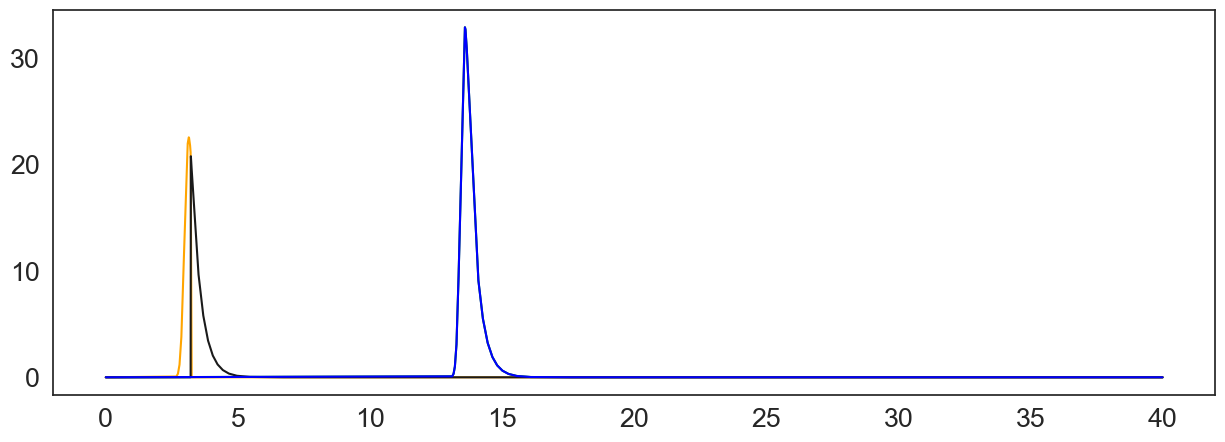

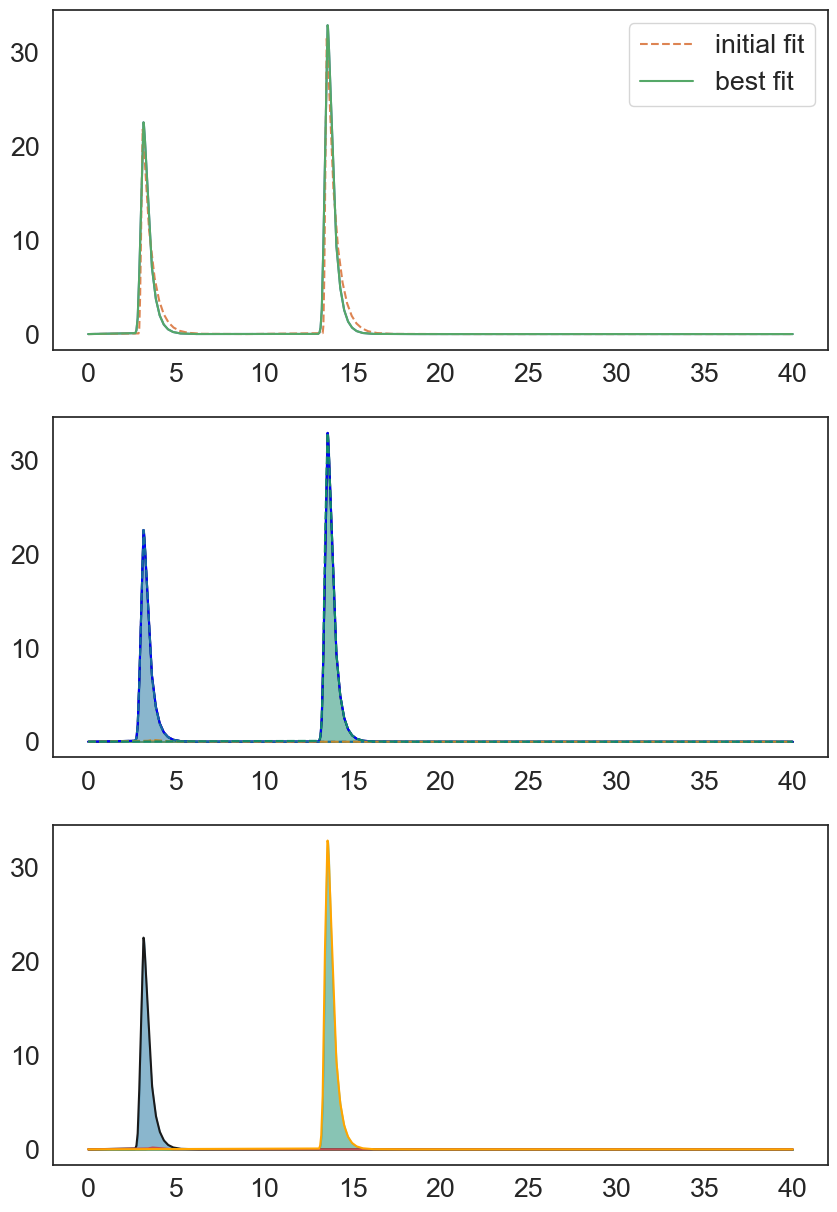

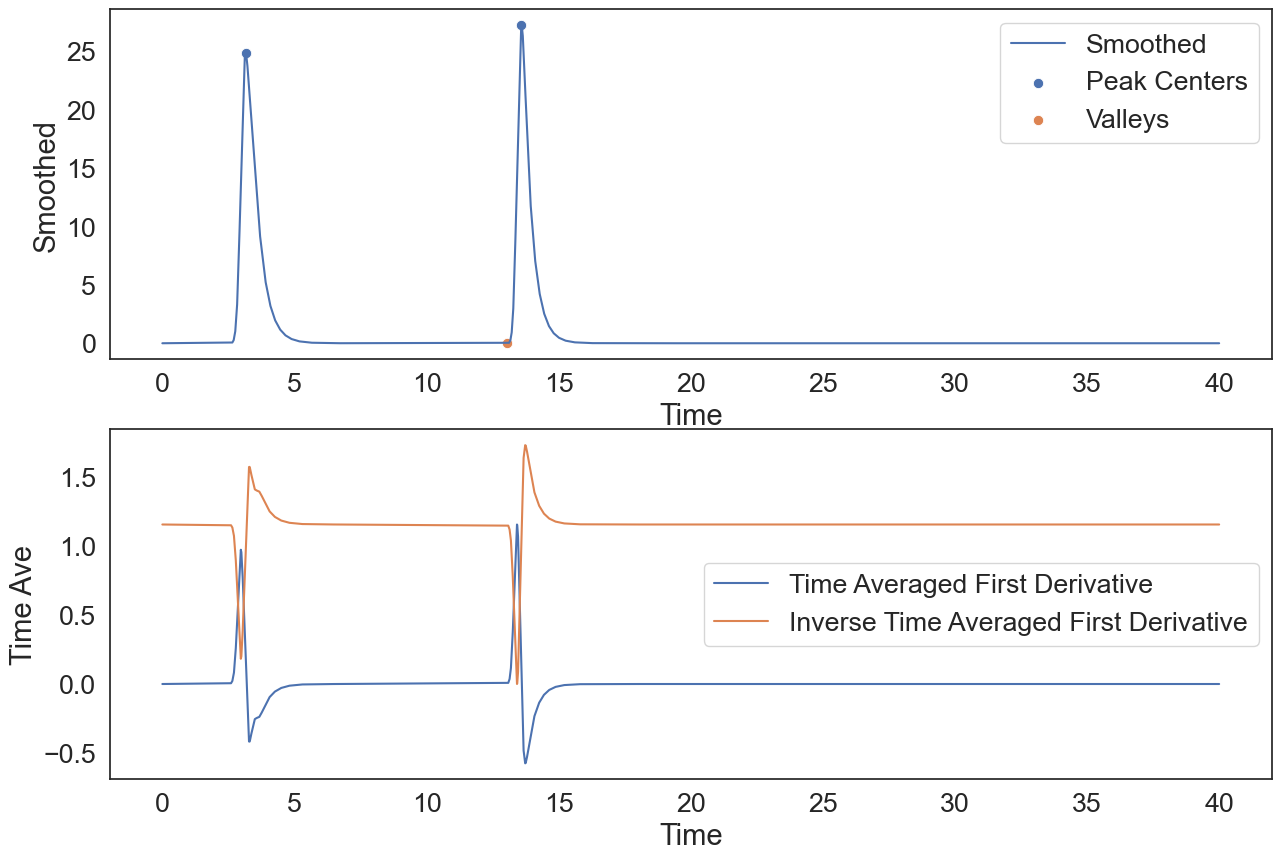

[0, 13.05, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.050164694344822 1.7179165388086974 1.5493136929628893e-06
6.74593667236915e-10
6.948722072855965e-10
1.2342826589461371e-11
[0, 12.93, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.929724085164246 1.399772562462369 1.0044801958549609e-05
6.019781968074491e-10
6.021937605842745e-10
9.584784047720876e-12
[0, 13.01, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.892286396364704 1.389142302318112 7.674310905940248e-07
2.1175759642220225e-12
2.2196437444093566e-12
3.865609188214272e-10
[0, 13.07, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.365635492864643 1.8074930263356357 4.73852648105227e-06
2.6058846717281917e-09
2.6180207602211696e-09
4.6037418170939206e-12
[0, 12.92, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.726389107463283 1.9099273619741253 2.3697684164211185e-06
5.178993291922337e-10
5.460227362577421e-10
5.838923647837692e-11
[0, 2.63, 13.11, 20]
[0, 2.63, 13.11, 20]
[0, 2.63, 13.11, 20]
12.038873252439688 3.0

1.918853083244086e-12
2.166410931890022e-12
2.0099867186774505e-10
[0, 2.64, 12.97, 20]
[0, 2.64, 12.97, 20]
[0, 2.64, 12.97, 20]
7.51319202104863 1.9301739788167507 4.149054674097846e-05
1.6109914132417753e-11
1.6119174748729585e-11
2.3344361912466023e-11
[0, 12.99, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.055018829386126 1.4353494309040846 8.798854354542632e-06
110.46955831063937
153.12266405784388
2.8451472841268255e-06
[0, 13.09, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.880949840146285 1.6698687564238917 2.738956205584084e-06
1.5670815931520249e-09
1.5629399731991434e-09
1.7737605651389111e-09
[0, 12.85, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.577182102395225 1.8675607166290424 1.07689566978839e-05
2.738796561405566e-10
2.7113638382257e-10
3.0948045701225335e-12
[0, 12.94, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.705878795960348 1.3362127184190133 7.156405910372446e-06
1.2794970301799446e-11
1.2587799876725143e-11
3.944936344545328e-10
[0, 12.9, 20]
[0,

7.543484281664718e-10
7.540704292262094e-10
1.7266441170629785e-10
[0, 12.83, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.135405498223317 1.7421202744168822 8.409656806637507e-06
2.0680212078678825e-11
2.0645007828213135e-11
1.5080908118324767e-10
[0, 12.83, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.511280590573068 1.5649028670879168 4.773235371442711e-06
5.523759939619951e-10
5.522228879524816e-10
2.354359549514081e-12
[0, 13.1, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.20389897109968 1.1936778475941414 2.057348923467763e-06
7.478009488923626e-11
7.48275542147465e-11
2.6822914462244947e-11
[0, 12.99, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.8125678985375995 1.6504520174768678 7.713541658055861e-07
5.835910324353771e-11
5.670074938109136e-11
7.52206956608766e-11
[0, 12.85, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.2514401912861395 1.2071769591985173 1.7973852077867278e-06
4.880824623614015e-10
4.879063240441738e-10
2.3687923440232874e-11
[0, 13.030000000000

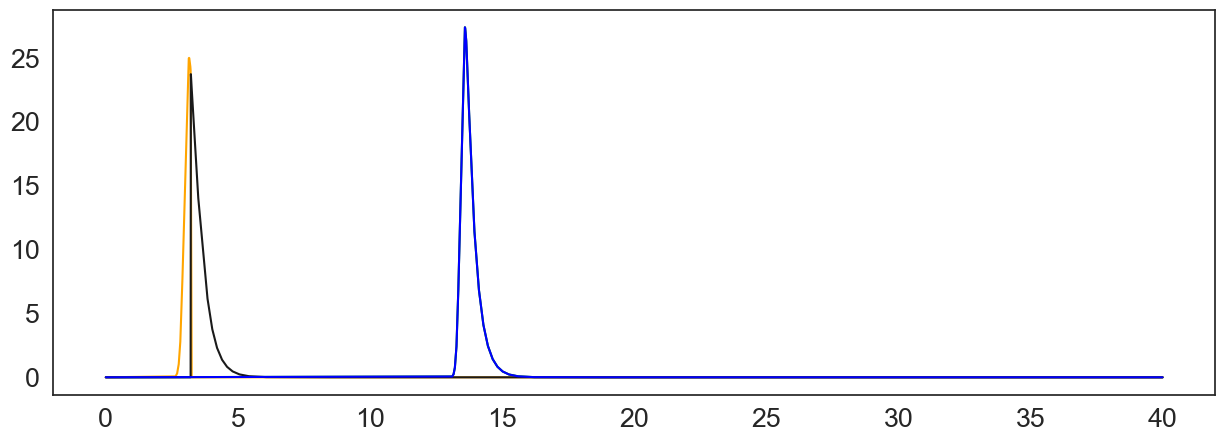

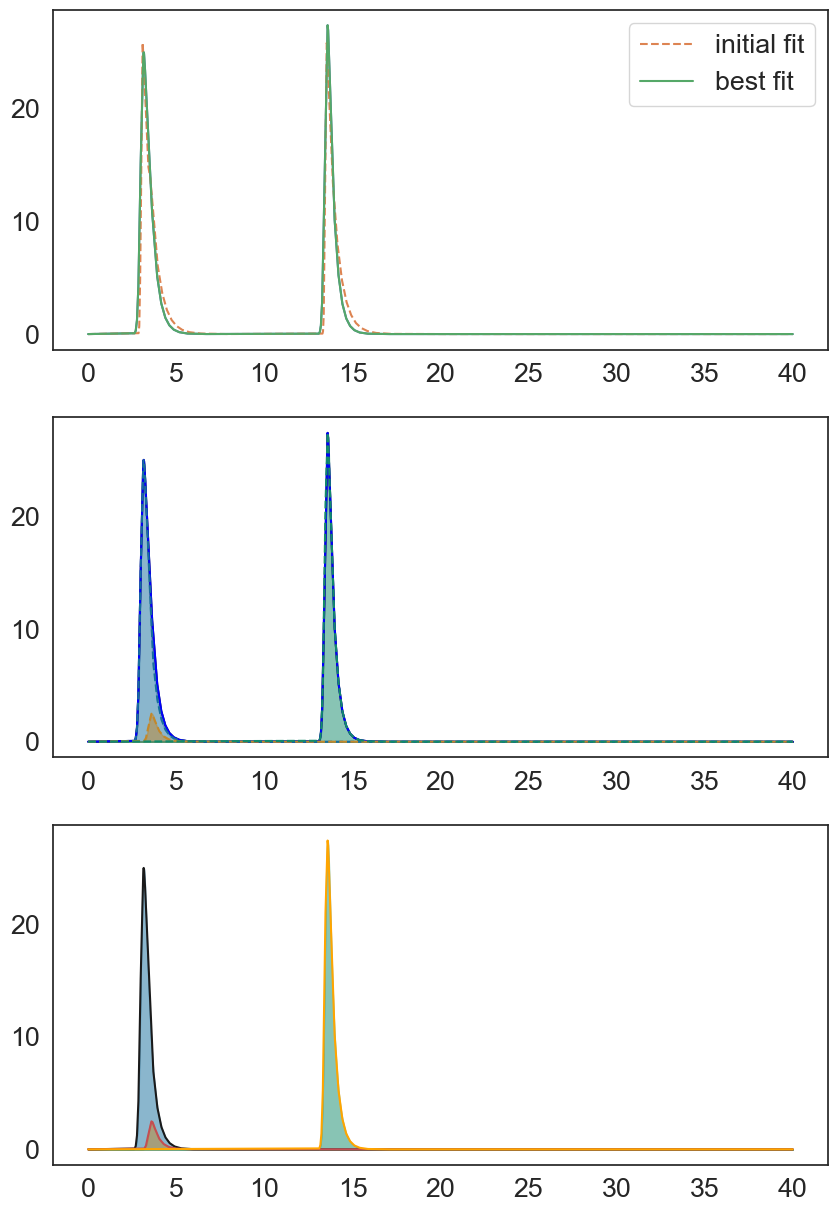

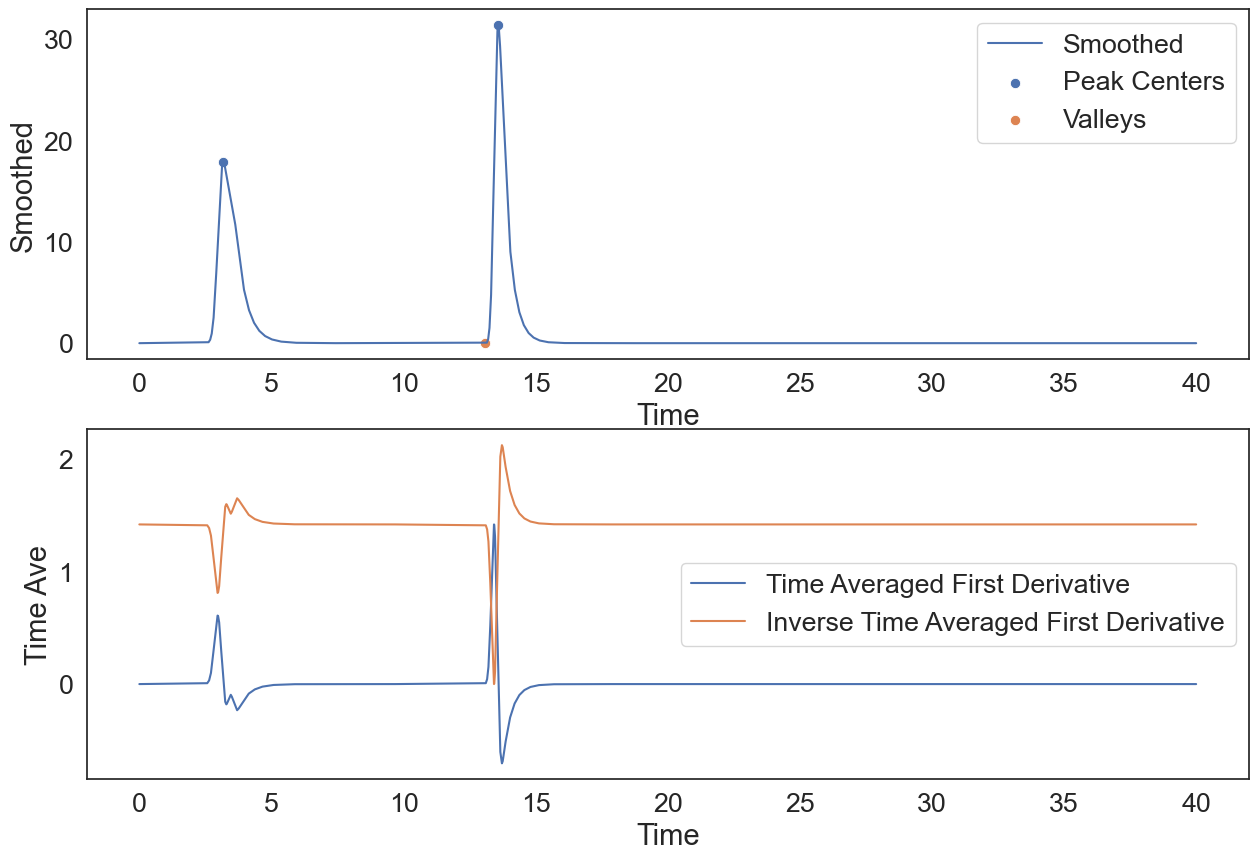

[0, 13.09, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.951363677462852 1.4059170255388052 6.39226811322761e-06
2.34062727566746e-10
2.3411968596727095e-10
7.947834979774146e-11
[0, 12.85, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.978816114345699 1.6976574364664025 9.033542434127502e-06
8.877319641713921e-11
8.798240629445019e-11
1.5965529578153298e-12
[0, 2.65, 12.85, 20]
[0, 2.65, 12.85, 20]
[0, 2.65, 12.85, 20]
13.034349342209689 3.354920998921331 1.3240444284477174e-05
2.2155800561279708e-11
2.1851695595686965e-11
1.199077206488844e-10
[0, 13.02, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.916754677249609 1.680035375816796 7.703691348205615e-06
3.2516983837472203e-12
3.2911339408082493e-12
6.978313639630471e-12
[0, 2.62, 12.870000000000001, 20]
[0, 2.62, 12.870000000000001, 20]
[0, 2.62, 12.870000000000001, 20]
12.572256269978482 3.2176134969433186 1.3488702728655968e-05
4.59377065443797e-11
1.3406108157210213e-11
1.3681961839065451e-11
[0, 12.83, 20]
[0, 3.225, 8.45, 

3.515559220663119e-13
5.143188388157716e-13
3.351683795738463e-11
[0, 12.98, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.144640713748418 1.744742571551986 7.709594075969372e-06
5.295718881848859e-11
5.282742378960857e-11
2.6349902317295223e-10
[0, 12.93, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.928503969570659 1.3994261162566408 2.498693193240847e-06
6.373243320115985e-10
6.370447735135558e-10
8.40746707515309e-11
[0, 2.65, 12.870000000000001, 20]
[0, 2.65, 12.870000000000001, 20]
[0, 2.65, 12.870000000000001, 20]
7.217810799940256 1.8577977606249803 1.0526189112753488e-05
5.5440894869072086e-11
5.409587315864469e-11
4.4763295595768376e-13
[0, 2.62, 13.040000000000001, 20]
[0, 2.62, 13.040000000000001, 20]
[0, 2.62, 13.040000000000001, 20]
11.693025121462565 2.992592154900579 0.00012410423667619453
1.6930192504489553e-10
1.6666231124662782e-10
3.272473392269375e-11
[0, 2.61, 12.86, 20]
[0, 2.61, 12.86, 20]
[0, 2.61, 12.86, 20]
12.836858847603754 3.2790574356512145 1.63252365

1.5698579658011512e-10
1.5513901072308035e-10
1.689168240008284e-11
[0, 12.92, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.549364641423254 1.8596620760931593 1.9514059066086547e-06
1.0216653752964372e-09
1.0212198038538188e-09
4.0408526266706855e-10
[0, 12.99, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.223167181343488 1.19914896758159 5.977759780424972e-06
4.245988287913534e-12
3.920346588189536e-12
3.5088255730876284e-11
[0, 12.93, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.2585682464360115 1.777091772372241 6.303323589462694e-07
1.224304052588016e-10
1.3521581400776345e-10
4.970718960903432e-13
[0, 13.1, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.085794975145824 1.1601427591791014 1.5977275459874846e-06
6.73901898492868e-10
6.79886562070223e-10
2.481034567964438e-10
[0, 13.07, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.998107407070431 1.7031351106506452 3.5341744924859887e-06
2.954892110323475e-09
2.949851343625392e-09
1.7484934186952342e-10
[0, 12.84, 20]
[0,

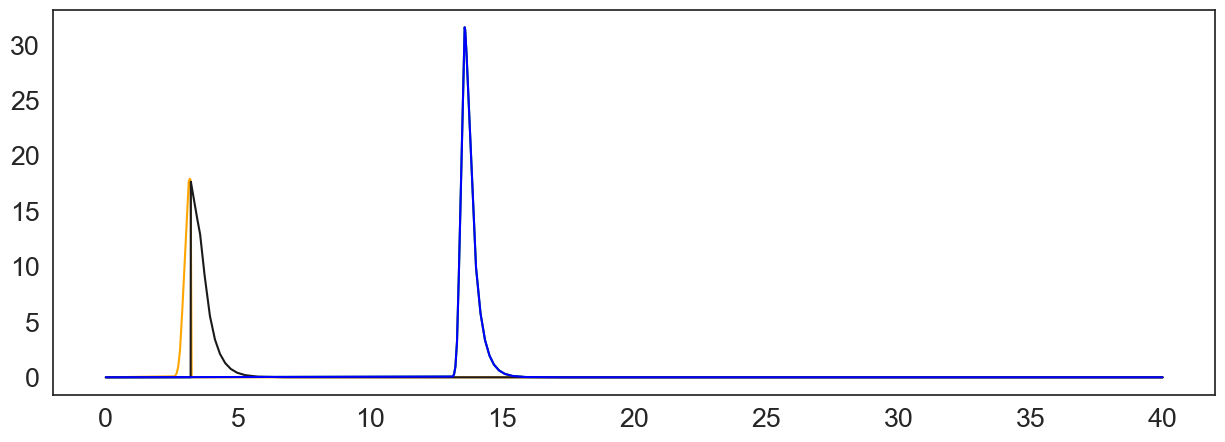

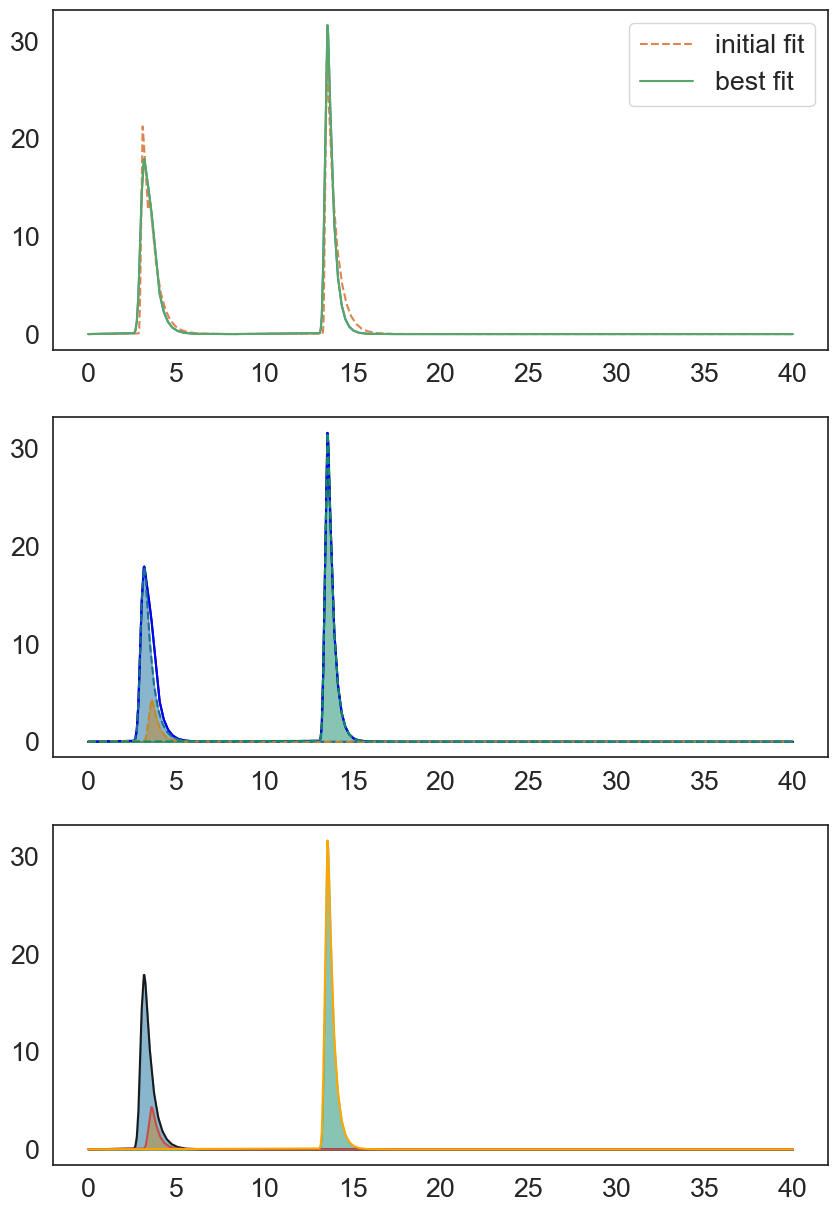

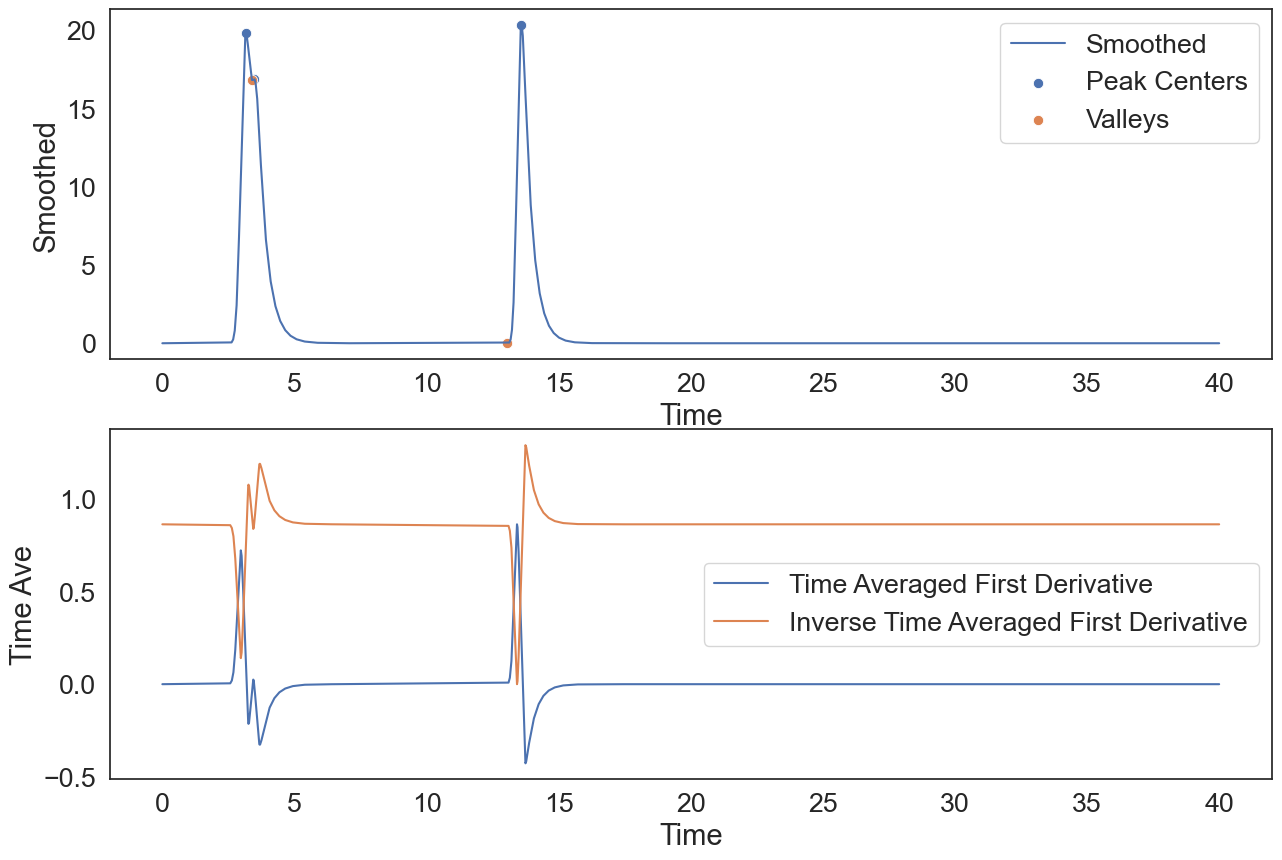

[0, 3.41, 13.05, 20]
[0, 3.41, 13.05, 20]
[0, 3.41, 13.05, 20]
3.171985474916925 0.9261437225508419 0.00011977028534220933
7.089507890147741e-12
6.693920455142464e-12
4.094654157429171e-10
[0, 12.91, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.564579576820251 1.863982287275722 3.2534808781331906e-06
2.011979343404683e-09
2.011304890716347e-09
3.791465024075482e-11
[0, 2.63, 12.91, 20]
[0, 2.63, 12.91, 20]
[0, 2.63, 12.91, 20]
12.546133850027768 3.2170498837687163 2.892031609559759e-05
1.9737819570336444e-12
3.641799951392779e-12
2.7280920362057555e-10
[0, 2.65, 12.88, 20]
[0, 2.65, 12.88, 20]
[0, 2.65, 12.88, 20]
7.590744279912001 1.9537873901299418 2.0758325041327513e-05
4.66582698596689e-11
4.4224649589700224e-11
9.931428134439835e-11
[0, 13.01, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.440926502503317 1.2609807288990411 7.159357783766969e-06
7.876328781864668e-10
7.868929169794098e-10
3.7872593887588506e-11
[0, 12.950000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 

1.7194463518093502e-11
2.0292515146669972e-11
2.821279101493128e-10
[0, 3.4, 12.96, 20]
[0, 3.4, 12.96, 20]
[0, 3.4, 12.96, 20]
3.7709544244422233 1.0994126935664783 5.2166716023203384e-05
4.220066160775028e-10
4.2614740778112307e-10
2.8875860390992103e-11
[0, 3.4, 13.08, 20]
[0, 3.4, 13.08, 20]
[0, 3.4, 13.08, 20]
3.190641816023288 0.930223956866256 0.0001344790715584556
1.0399050676328723e-11
1.0760459388066422e-11
7.984054784267627e-11
[0, 2.64, 13.030000000000001, 20]
[0, 2.64, 13.030000000000001, 20]
[0, 2.64, 13.030000000000001, 20]
8.00137441239912 2.055590308460756 0.00010986215497935125
3.297664803001709e-11
3.1631937039876133e-11
4.6317874260700225e-10
[0, 3.41, 12.97, 20]
[0, 3.41, 12.97, 20]
[0, 3.41, 12.97, 20]
4.345742920591834 1.2688527504866551 4.272337785895228e-05
4.428713395928555e-11
4.546048406352245e-11
5.0461919713533863e-11
[0, 2.63, 13.09, 20]
[0, 2.63, 13.09, 20]
[0, 2.63, 13.09, 20]
11.698587847255995 2.9997241617419323 0.00028814162022468515
9.20296166032443

5.125240305962458e-10
5.101538367835022e-10
2.5999517550826224e-12
[0, 12.85, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.895001049926781 1.9578039503365237 4.795282939708114e-07
1.226328726386884e-10
1.2010232333227295e-10
5.4022110130993506e-11
[0, 2.63, 12.98, 20]
[0, 2.63, 12.98, 20]
[0, 2.63, 12.98, 20]
10.413100771829832 2.670102601749313 6.022325589648221e-05
1.1101805851604565e-09
1.107291109007717e-09
1.2836124250289e-10
[0, 2.6, 12.9, 20]
[0, 2.6, 12.9, 20]
[0, 2.6, 12.9, 20]
12.501200883062591 3.1871933624105164 2.606020704443384e-05
2.0442763129388257e-09
2.0435685299872276e-09
6.961149295237337e-11
[0, 12.89, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.4903861590461025 1.275024571737377 6.151703065270759e-06
2.217880102055088e-10
2.423872620085736e-10
1.7858706991766428e-10
[0, 2.62, 12.98, 20]
[0, 2.62, 12.98, 20]
[0, 2.62, 12.98, 20]
10.642598292489422 2.723756752662186 3.8350856882164816e-05
1.2047564402321772e-10
1.181978994216003e-10
4.2724640081614743e-11
[0,

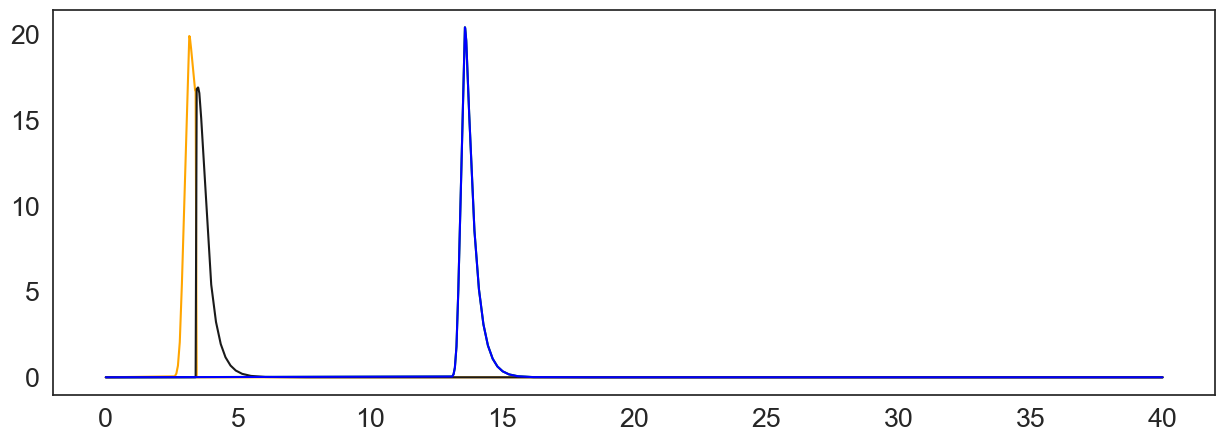

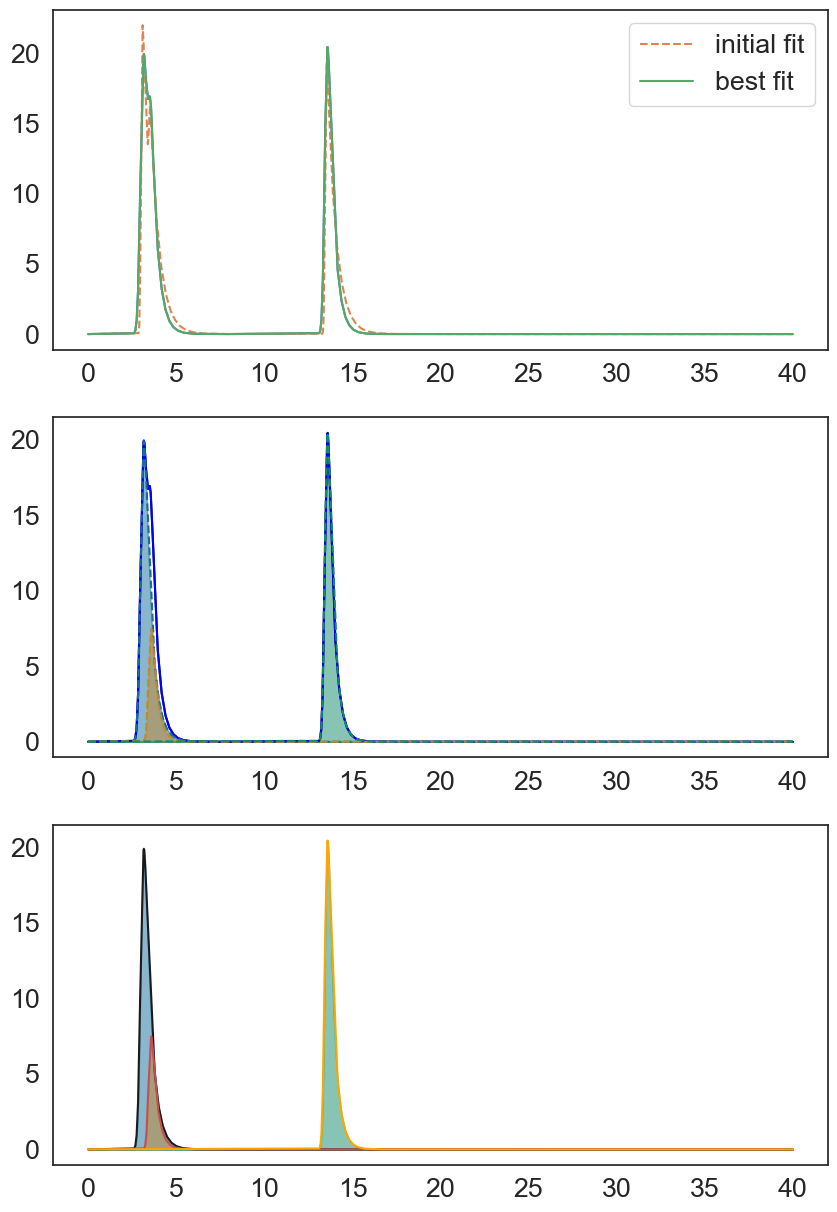

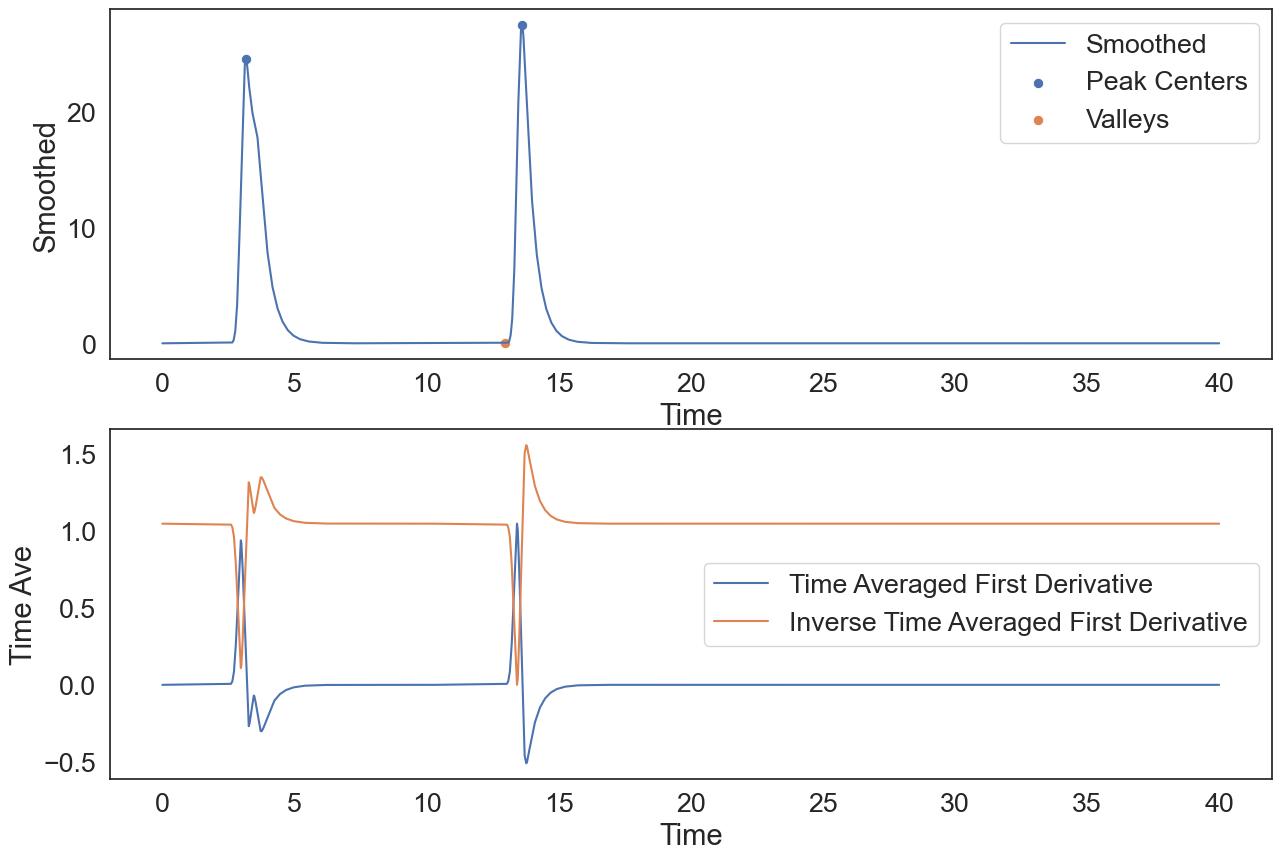

[0, 12.97, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.992277921131614 1.7014798548471453 8.490538219970318e-06
4.1587393221354774e-10
4.160435339094657e-10
3.282150146874151e-11
[0, 12.950000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
7.487453557737583 2.1260281249209863 1.570575650297577e-05
3.53355063902454e-11
3.474699285501523e-11
2.9401261875945243e-11
[0, 13.07, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.323493736882494 1.7955270678451427 2.3577135525660692e-05
1.769696920362957e-10
1.7675288439703692e-10
3.839769678206403e-11
[0, 13.040000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.639177251984623 1.6012185379926 7.020143189862674e-06
1.0347699474904723e-09
1.0488369391315907e-09
1.2778850624072945e-10
[0, 12.84, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.909346701758537 1.393986497888389 1.061149126832147e-05
1.2473024553290526e-09
1.247237880901824e-09
4.3591499518566855e-13
[0, 13.08, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
7.4

1.625279733444089e-10
1.6287280208786525e-10
1.2891845012485535e-09
[0, 3.37, 13.030000000000001, 20]
[0, 3.37, 13.030000000000001, 20]
[0, 3.37, 13.030000000000001, 20]
4.067776412164455 1.1807067058873482 9.584437086885922e-05
2.012475034633291e-10
2.0494901296562195e-10
1.1776024147362368e-10
[0, 3.34, 12.98, 20]
[0, 3.34, 12.98, 20]
[0, 3.34, 12.98, 20]
2.9080985926690097 0.8403348312345051 6.0206640663988846e-05
1.4454465890529774e-11
1.412168458222113e-11
4.337918285780215e-12
[0, 2.62, 12.96, 20]
[0, 2.62, 12.96, 20]
[0, 2.62, 12.96, 20]
12.186413887435549 3.1188649805088424 3.9926843722903775e-05
5.148583085086113e-11
5.0668111808493465e-11
3.551464806266762e-11
[0, 3.36, 12.94, 20]
[0, 3.36, 12.94, 20]
[0, 3.36, 12.94, 20]
5.147627811378611 1.491924279745447 3.7386782543321644e-05
7.758242178795943e-12
7.998217413331423e-12
5.821052156170827e-11
[0, 12.99, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
3.765356385449156 1.069155690126318 8.017843620972604e-06
1.1189793521995752

8.621801381824067e-12
8.622982403887257e-12
1.7775578717487898e-10
[0, 2.66, 13.040000000000001, 20]
[0, 2.66, 13.040000000000001, 20]
[0, 2.66, 13.040000000000001, 20]
7.601982438569678 1.9603683632760858 9.735687766471793e-05
2.5181606322687736e-10
2.3898674729510127e-10
1.5040666721830018e-11
[0, 2.66, 12.88, 20]
[0, 2.66, 12.88, 20]
[0, 2.66, 12.88, 20]
9.215037905081687 2.37633655425445 1.4552525078461111e-05
3.285212752878853e-11
3.837451156831216e-11
3.493988752818409e-11
[0, 12.98, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.667944436564176 1.325441430929946 3.050345663641949e-06
8.509147171193777e-11
8.288257764772999e-11
2.9020511170014482e-12
[0, 3.38, 13.05, 20]
[0, 3.38, 13.05, 20]
[0, 3.38, 13.05, 20]
4.272703161923939 1.2420271199900832 0.00012885285233097538
6.735786894194471e-12
7.122003561823225e-12
1.1555779386828986e-10
[0, 2.63, 3.42, 13.1, 20]
[2.63, 3.42, 13.1, 20]
[2.63, 3.42, 13.1, 20]
5.818746480506308 0.8177357853058526 0.0002348037261147243
4.05759085037

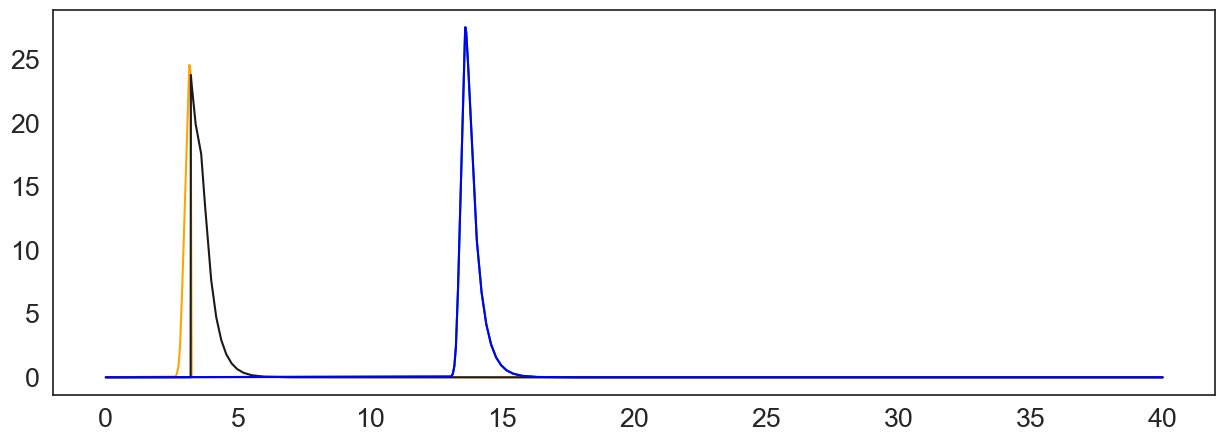

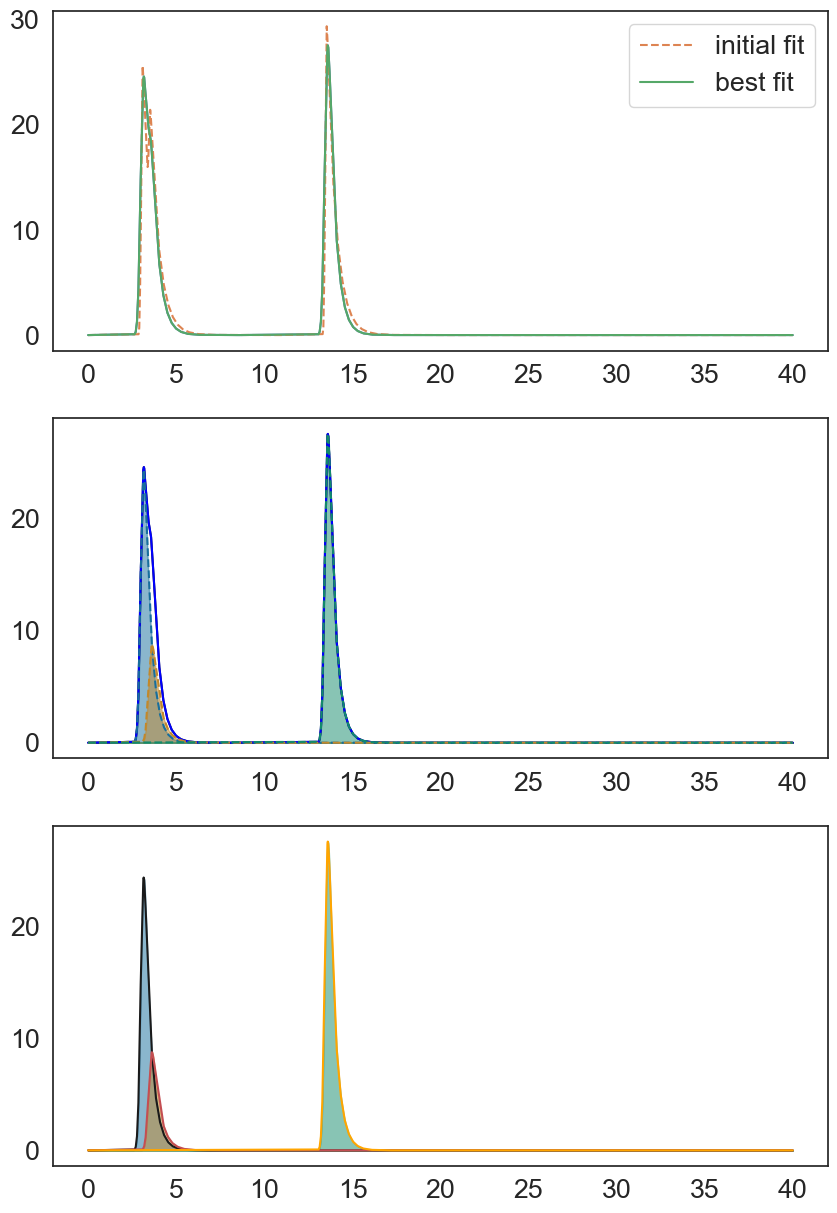

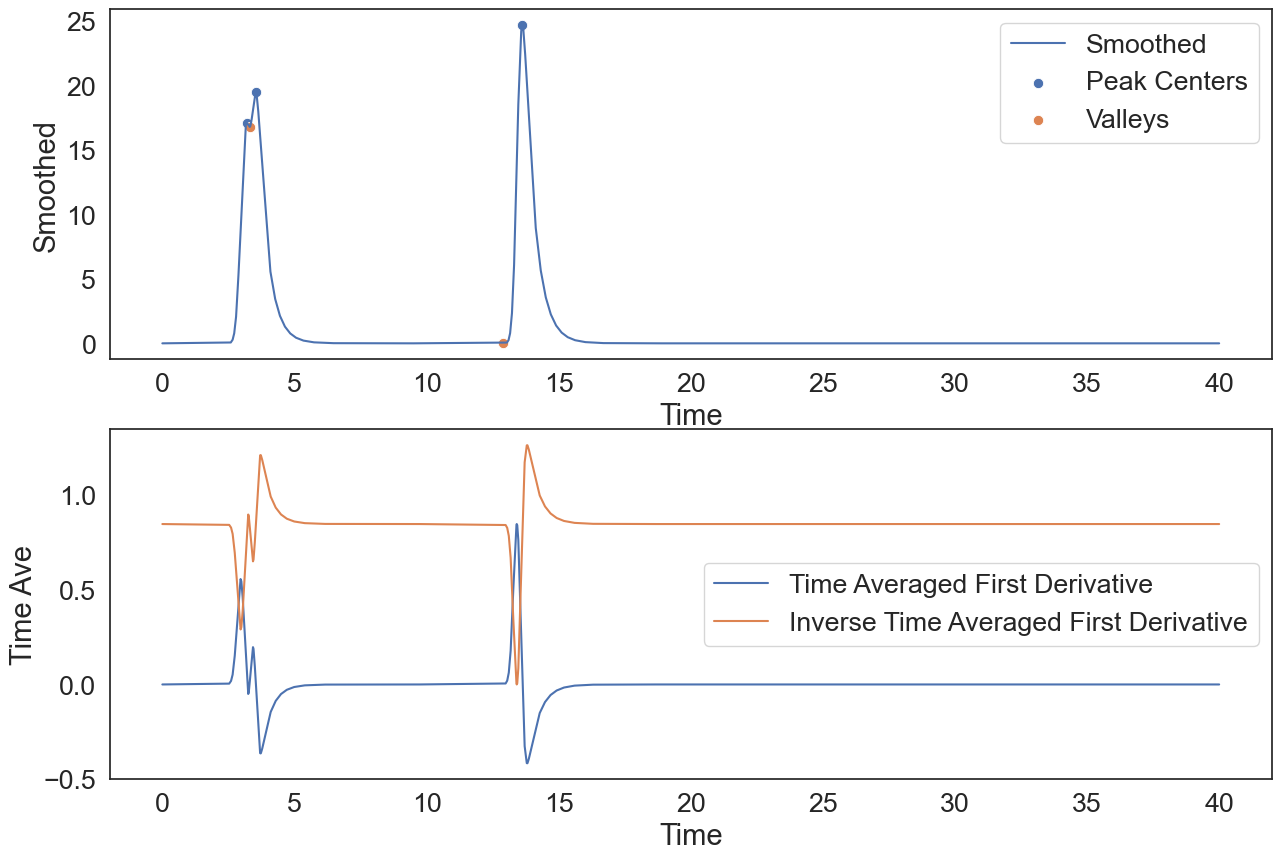

[0, 3.3000000000000003, 12.88, 20]
[0, 3.3000000000000003, 12.88, 20]
[0, 3.3000000000000003, 12.88, 20]
4.055641030786815 1.1648941988476078 2.083690886390407e-05
6.047029077809452e-11
6.044281209069137e-11
2.7320278741882334e-11
[0, 2.66, 3.39, 12.96, 20]
[2.66, 3.39, 12.96, 20]
[2.66, 3.39, 12.96, 20]
6.289196260974078 0.8496236294870574 3.7650923824737954e-05
1.381838497541671e-10
1.3840602829929811e-10
1.6013402363572955e-10
[0, 3.42, 12.92, 20]
[0, 3.42, 12.92, 20]
[0, 3.42, 12.92, 20]
3.2018522209408538 0.9362338540157337 2.792046675547446e-05
2.2699721359617396e-12
2.3288558881534217e-12
1.0100280487012155e-10
[0, 3.33, 12.96, 20]
[0, 3.33, 12.96, 20]
[0, 3.33, 12.96, 20]
3.072336731513516 0.8864636560039497 4.298770442608116e-05
7.354157808778892e-11
7.273870816285533e-11
3.9645359522414895e-11
[0, 2.64, 3.36, 12.99, 20]
[2.64, 3.36, 12.99, 20]
[2.64, 3.36, 12.99, 20]
5.658103245732251 0.7591142142418414 9.030738290474703e-05
3.194499340585821e-12
3.6293764062994004e-12
1.0381

9.195171469067817e-11
9.180110215859792e-11
1.8073700246727553e-09
[0, 3.4, 13.02, 20]
[0, 3.4, 13.02, 20]
[0, 3.4, 13.02, 20]
2.5677280294371596 0.7486149398985777 0.00011584898023068337
4.920135046047327e-10
4.993841731012229e-10
4.8461790704049666e-11
[0, 12.88, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.531098190891411 1.2865845666206013 8.886104871527906e-06
2.395936499773718e-11
2.5386852276553076e-11
5.1901057291440764e-11
[0, 3.3200000000000003, 12.93, 20]
[0, 3.3200000000000003, 12.93, 20]
[0, 3.3200000000000003, 12.93, 20]
5.460494503511176 1.573153209033356 2.4356843116623946e-05
8.564234033282181e-12
8.071020247594843e-12
1.3785880281439002e-11
[0, 2.67, 3.42, 13.06, 20]
[2.67, 3.42, 13.06, 20]
[2.67, 3.42, 13.06, 20]
4.938306117434642 0.676205440767751 0.00018992347313962542
6.498126564510585e-11
6.254506486321356e-11
1.2750308698948581e-10
[0, 3.42, 13.0, 20]
[0, 3.42, 13.0, 20]
[0, 3.42, 13.0, 20]
4.081705651507715 1.193506371418546 0.00010455686425881289
6.40883192

1.3376500182043574e-11
1.317947822960838e-11
1.195679661814183e-10
[0, 3.33, 13.09, 20]
[0, 3.33, 13.09, 20]
[0, 3.33, 13.09, 20]
3.096563198554863 0.8934537802424564 0.0002813883166676701
2.2805312675982558e-11
2.321201992447137e-11
4.455921633329207e-10
[0, 3.36, 13.07, 20]
[0, 3.36, 13.07, 20]
[0, 3.36, 13.07, 20]
4.841078702684182 1.4030779220137737 0.00020681770978225682
1.1574976182262734e-09
1.1565580587332137e-09
1.3242864380429954e-11
[0, 13.09, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.755124279554059 1.3501957478439717 8.01221145356388e-06
1.0943915197543215e-10
1.0858246311323784e-10
7.456238412989063e-12
[0, 3.42, 12.870000000000001, 20]
[0, 3.42, 12.870000000000001, 20]
[0, 3.42, 12.870000000000001, 20]
2.298214552265703 0.672006738118687 1.057818092991383e-05
6.447299554413249e-11
6.363139159156431e-11
3.6809450355912445e-10
[0, 3.34, 12.86, 20]
[0, 3.34, 12.86, 20]
[0, 3.34, 12.86, 20]
4.874898031211862 1.4086684042975264 1.541356979543932e-05
4.983444849219333e-1

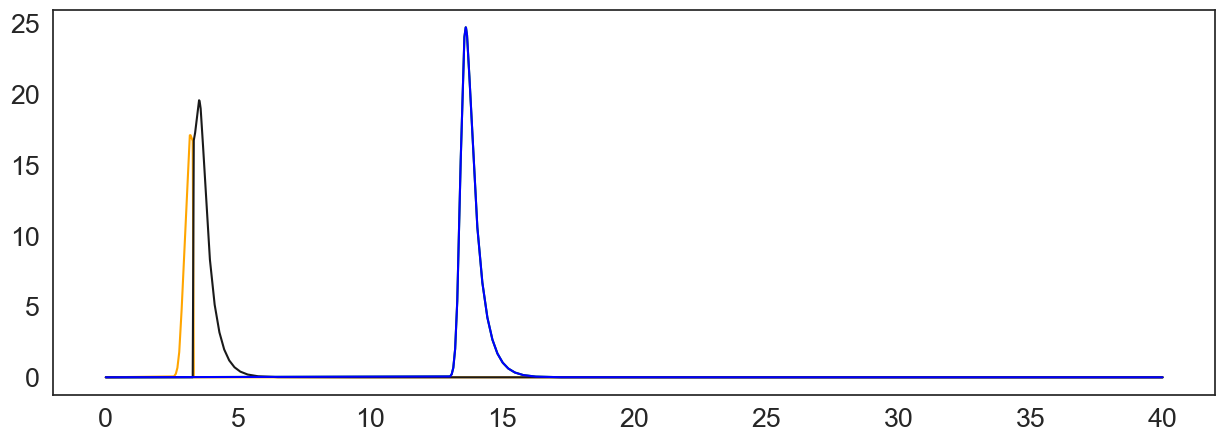

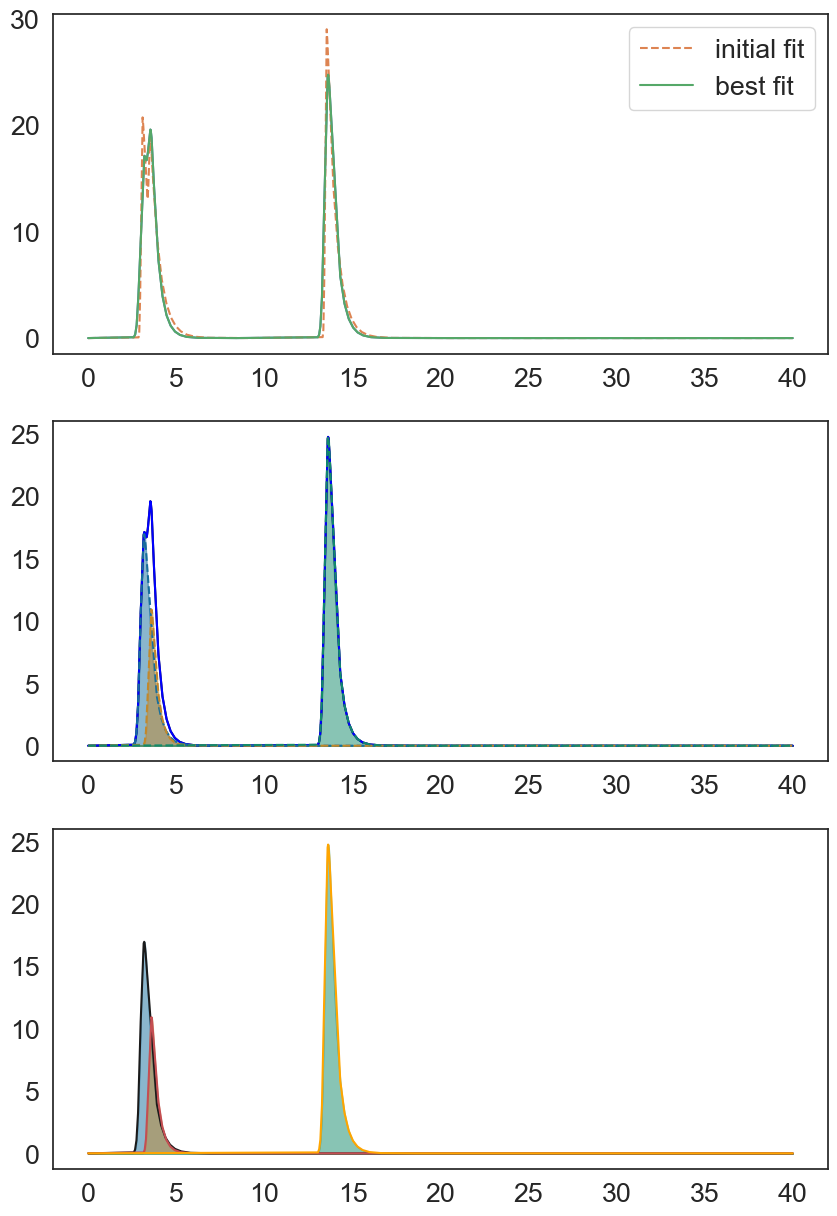

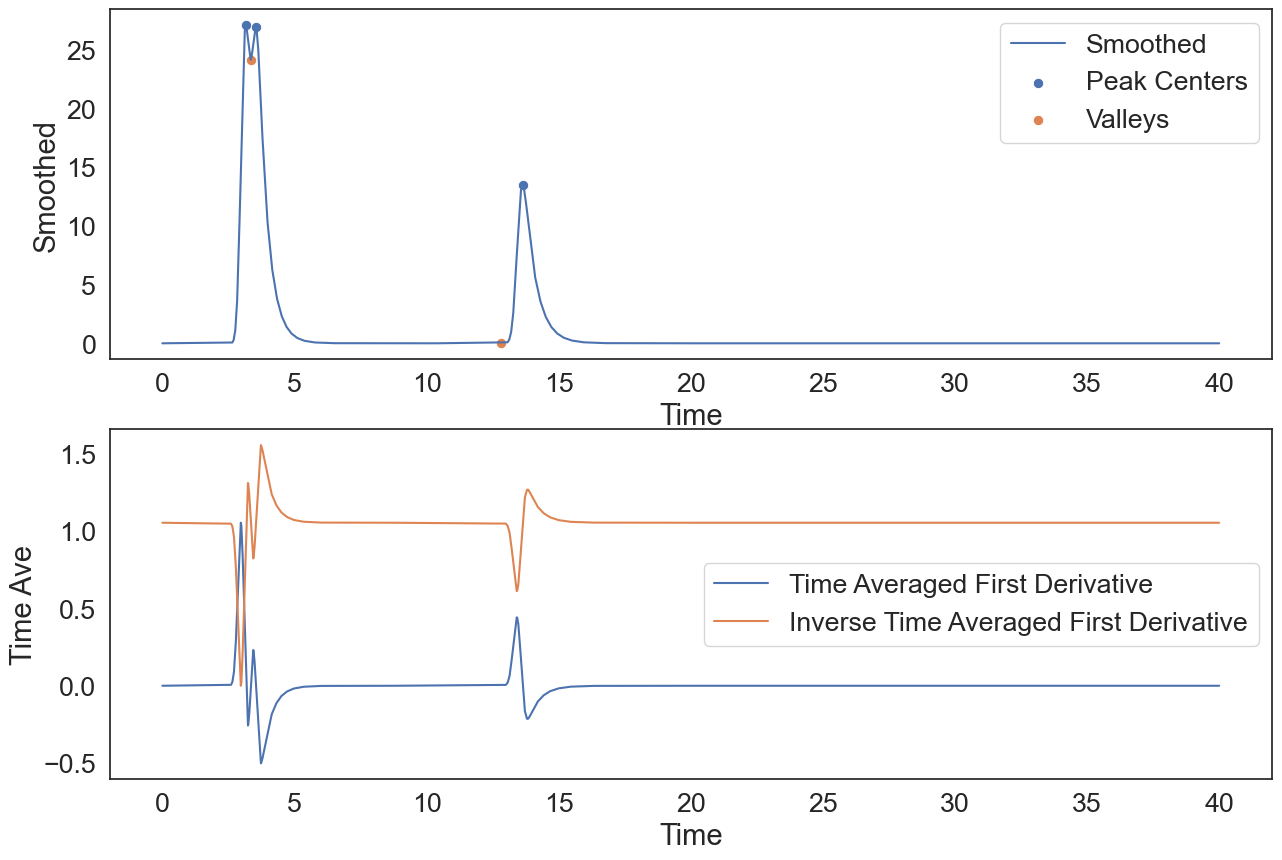

[0, 3.34, 12.83, 20]
[0, 3.34, 12.83, 20]
[0, 3.34, 12.83, 20]
4.671511792698397 1.3498971712255416 5.872268121994707e-06
5.946251361055602e-10
5.948872360412729e-10
1.6179295269863092e-10
[0, 3.3200000000000003, 12.97, 20]
[0, 3.3200000000000003, 12.97, 20]
[0, 3.3200000000000003, 12.97, 20]
5.781550479605495 1.6656485398242016 6.719888774594493e-05
1.642228899852493e-11
1.5862164618836935e-11
1.596306839775607e-10
[0, 3.3000000000000003, 12.9, 20]
[0, 3.3000000000000003, 12.9, 20]
[0, 3.3000000000000003, 12.9, 20]
4.315636961895074 1.2395723445353652 2.0487000167700816e-05
6.527897174364332e-11
6.587143561377278e-11
3.360872912502478e-11
[0, 3.39, 13.08, 20]
[0, 3.39, 13.08, 20]
[0, 3.39, 13.08, 20]
3.925343378431758 1.1427402230105206 0.00020776176077257592
1.245698192227845e-10
1.224347990189668e-10
5.277498359094219e-10
[0, 3.31, 13.05, 20]
[0, 3.31, 13.05, 20]
[0, 3.31, 13.05, 20]
4.119329548617725 1.18497869958772 0.00018777521328964124
9.932091457736186e-09
9.908129292646781e-0

4.865488605554787e-10
4.841394693686064e-10
2.746068913961867e-11
[0, 3.29, 13.0, 20]
[0, 3.29, 13.0, 20]
[0, 3.29, 13.0, 20]
4.605293898289852 1.3207642512648081 9.745439887739766e-05
2.936409502494641e-10
2.97547014890732e-10
8.091645428707815e-11
[0, 3.34, 13.11, 20]
[0, 3.34, 13.11, 20]
[0, 3.34, 13.11, 20]
3.492791650233822 1.0092899082700646 0.0002463504295204805
2.3968423576860257e-10
2.3933271261341507e-10
3.4593067051460653e-12
[0, 3.33, 13.08, 20]
[0, 3.33, 13.08, 20]
[0, 3.33, 13.08, 20]
4.5355640870675415 1.308649768877631 0.00017433033067772234
3.9153879585622177e-10
3.9085240549873455e-10
2.850141661158039e-10
[0, 3.3000000000000003, 13.040000000000001, 20]
[0, 3.3000000000000003, 13.040000000000001, 20]
[0, 3.3000000000000003, 13.040000000000001, 20]
3.678705849357489 1.0566278231958726 0.0001638555236208334
1.4965536976553302e-10
1.5023595000111343e-10
6.721340202151597e-10
[0, 3.27, 12.9, 20]
[0, 3.27, 12.9, 20]
[0, 3.27, 12.9, 20]
3.991306367080963 1.1411925968089704 

2.893446481310285e-11
3.026314932785572e-11
1.3045122576018304e-10
[0, 3.31, 13.02, 20]
[0, 3.31, 13.02, 20]
[0, 3.31, 13.02, 20]
3.8146873257902905 1.0973443965270846 0.00012154640299300425
1.4714498879190523e-11
6.007750604026527e-12
4.384075779283247e-10
[0, 3.34, 12.97, 20]
[0, 3.34, 12.97, 20]
[0, 3.34, 12.97, 20]
4.67571945519423 1.351113033826913 5.29106110077569e-05
1.0935643088707446e-10
1.1213690541411086e-10
1.0161242170961692e-10
[0, 3.3200000000000003, 13.030000000000001, 20]
[0, 3.3200000000000003, 13.030000000000001, 20]
[0, 3.3200000000000003, 13.030000000000001, 20]
4.749807155248431 1.368406175050942 0.00012213705289299361
1.1658566116602472e-10
1.2349345330898693e-10
1.614430070316041e-10
[0, 3.3200000000000003, 13.02, 20]
[0, 3.3200000000000003, 13.02, 20]
[0, 3.3200000000000003, 13.02, 20]
4.346181318545962 1.2521226972035728 9.163559435103041e-05
4.350510137065859e-11
6.200718830731757e-11
1.3260507825405804e-10
[0, 3.3200000000000003, 12.85, 20]
[0, 3.32000000000

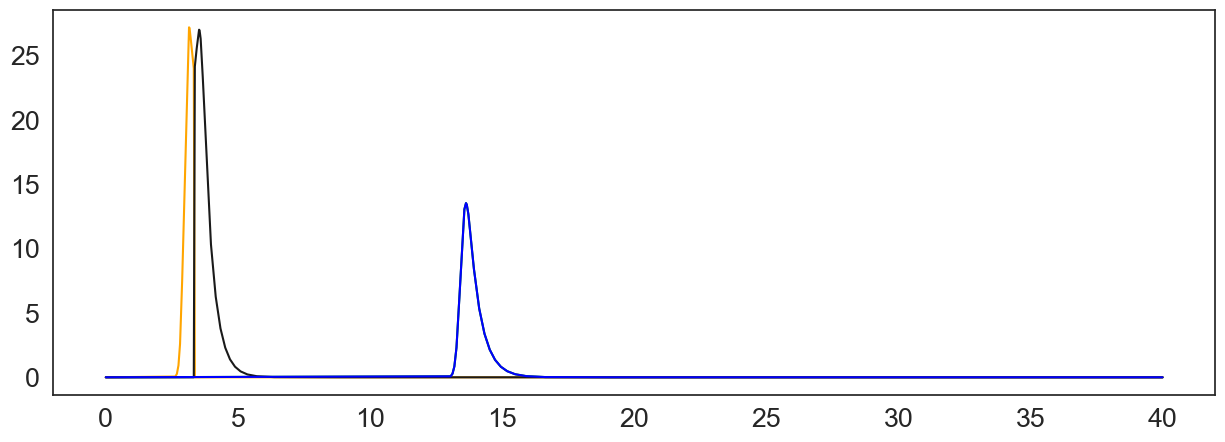

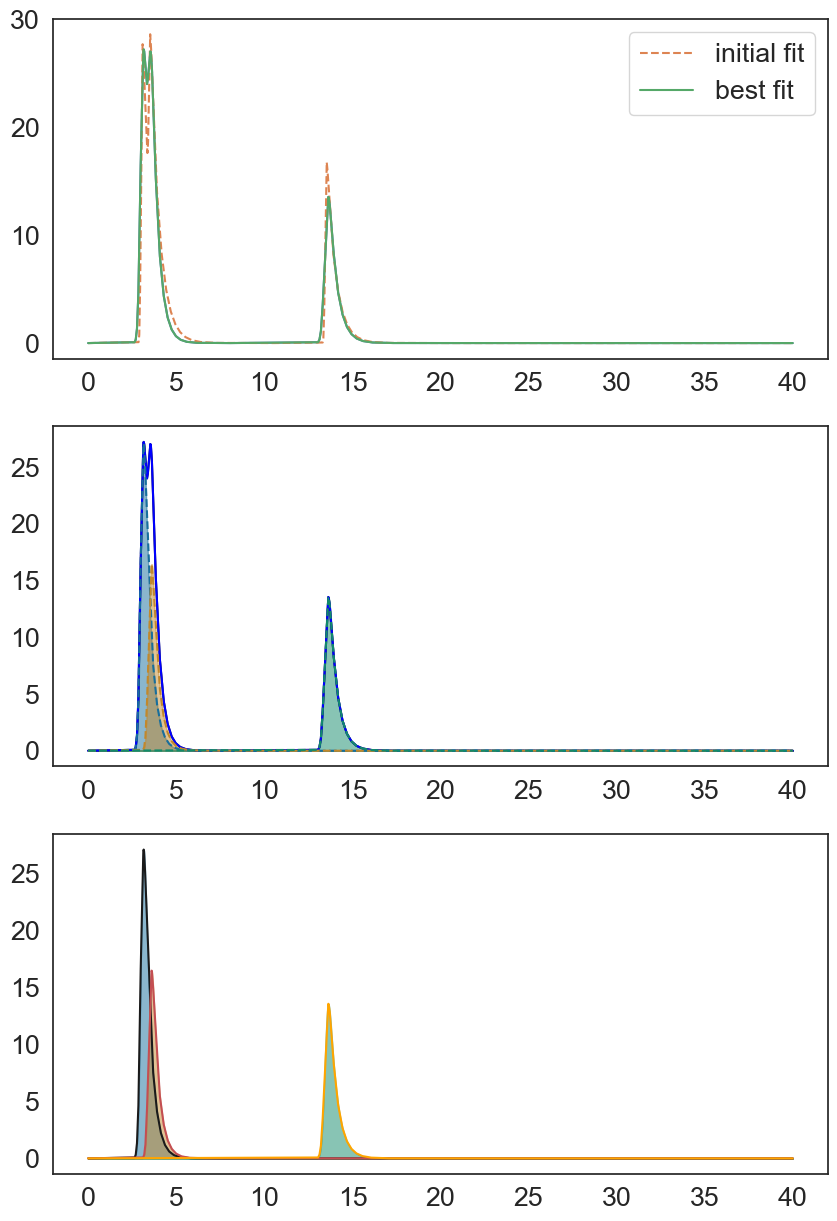

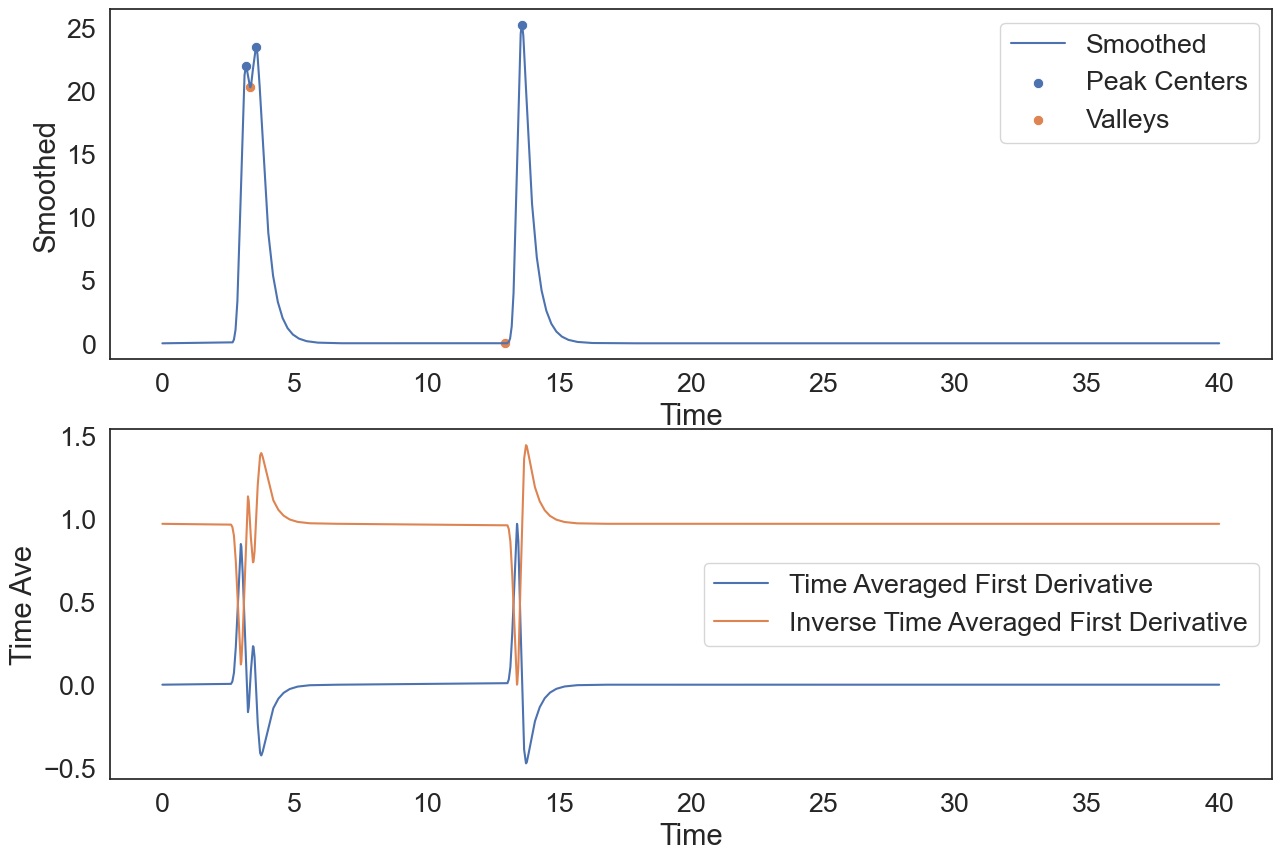

[0, 3.3200000000000003, 12.98, 20]
[0, 3.3200000000000003, 12.98, 20]
[0, 3.3200000000000003, 12.98, 20]
4.028329488417139 1.1605504714556545 6.33569408134657e-05
1.967420320072682e-11
1.9267824765705657e-11
4.0100811347534723e-10
[0, 3.27, 13.1, 20]
[0, 3.27, 13.1, 20]
[0, 3.27, 13.1, 20]
6.5903940969021075 1.884322648257049 0.0001715197493429517
9.97533553486837e-10
1.010955211539818e-09
3.90548371300613e-10
[0, 3.34, 13.0, 20]
[0, 3.34, 13.0, 20]
[0, 3.34, 13.0, 20]
3.5169670321507884 1.0162756876650032 7.107608288740908e-05
1.3347181586823986e-12
1.3516248736657385e-12
4.292325049014001e-10
[0, 13.030000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.236236404075375 1.7707507480646565 2.1708760766689367e-05
8.925135782614647e-10
8.594163789324905e-10
1.3251460698095537e-11
[0, 3.3000000000000003, 12.97, 20]
[0, 3.3000000000000003, 12.97, 20]
[0, 3.3000000000000003, 12.97, 20]
4.036535661490593 1.1594066001162617 4.804280607949485e-05
5.458181860711986e-10
5.4538629769325

5.349302663832612e-12
1.063971085961115e-11
9.211668200168352e-11
[0, 2.64, 3.36, 12.89, 20]
[2.64, 3.36, 12.89, 20]
[2.64, 3.36, 12.89, 20]
6.39045764612255 0.8573698624523658 1.8911321297291594e-05
2.2245916466056758e-10
2.2143188168107792e-10
9.26057511973703e-12
[0, 3.34, 13.09, 20]
[0, 3.34, 13.09, 20]
[0, 3.34, 13.09, 20]
5.421208058595773 1.5665321666583354 0.00021250297797579214
1.0121931760188942e-09
1.0116913366792136e-09
9.145198780961628e-12
[0, 2.65, 3.35, 12.83, 20]
[2.65, 3.35, 12.83, 20]
[2.65, 3.35, 12.83, 20]
7.351287522998051 0.9724839301689668 1.1645191622438699e-05
3.6689894528477585e-11
3.61859902167482e-11
1.0294718080870033e-10
[0, 3.3200000000000003, 13.01, 20]
[0, 3.3200000000000003, 13.01, 20]
[0, 3.3200000000000003, 13.01, 20]
3.502723889260525 1.0091249701254357 9.92258142110228e-05
1.8052466970923387e-12
1.7927176174555087e-12
2.3853421957211444e-10
[0, 3.31, 13.07, 20]
[0, 3.31, 13.07, 20]
[0, 3.31, 13.07, 20]
5.80080282321575 1.668676332785015 0.00014232

1.3150628411192257e-11
1.2624419426973815e-11
3.223545559169816e-10
[0, 2.64, 3.37, 13.09, 20]
[2.64, 3.37, 13.09, 20]
[2.64, 3.37, 13.09, 20]
7.499363855183775 1.0131082990082945 0.0002505543996474023
3.2931694160342843e-10
3.2289390104126655e-10
1.4134273354954725e-11
[0, 3.3200000000000003, 13.0, 20]
[0, 3.3200000000000003, 13.0, 20]
[0, 3.3200000000000003, 13.0, 20]
5.688012535915501 1.638700520485866 8.553304008652273e-05
1.59969144739806e-10
1.6160983579968165e-10
9.39765620033145e-12
[0, 12.97, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.538287567819008 1.2886259572019585 1.2189237547935457e-05
2.8170486952190377e-10
2.8097099965376455e-10
2.0773965175053053e-10
[0, 3.4, 12.94, 20]
[0, 3.4, 12.94, 20]
[0, 3.4, 12.94, 20]
2.636782557975841 0.7687476136202747 3.889716212650901e-05
1.0809103177684394e-11
1.0010671386696977e-11
2.5308863147775316e-11
[0, 12.86, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.295637611007291 1.503672031395866 2.973416556252467e-05
1.1262249698753

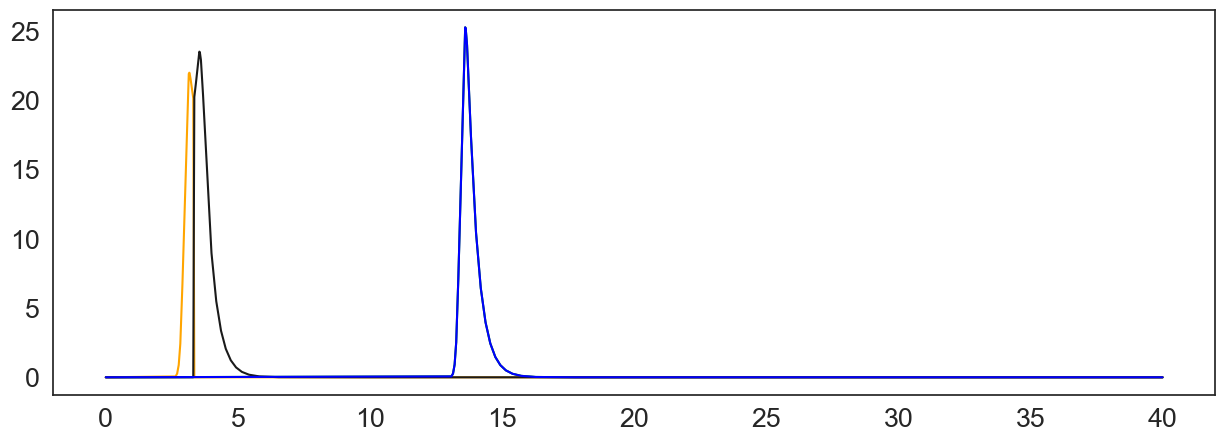

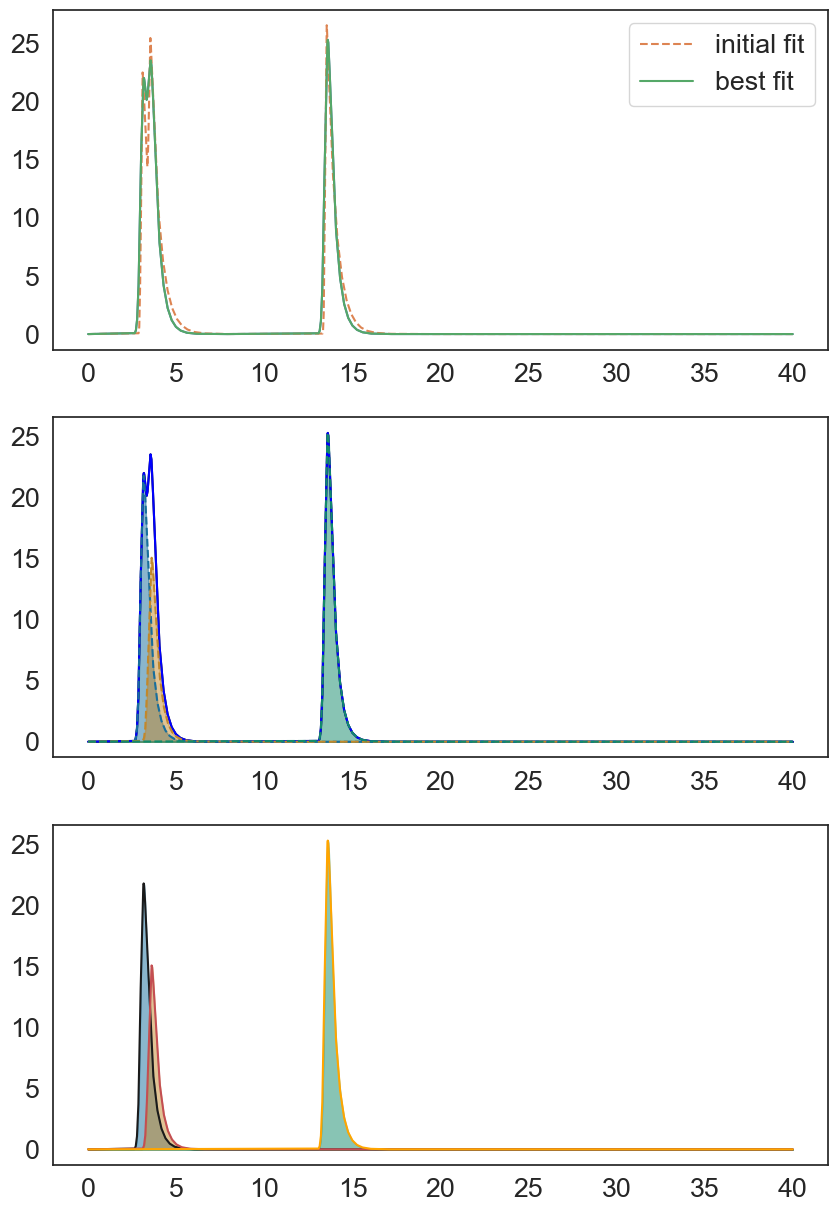

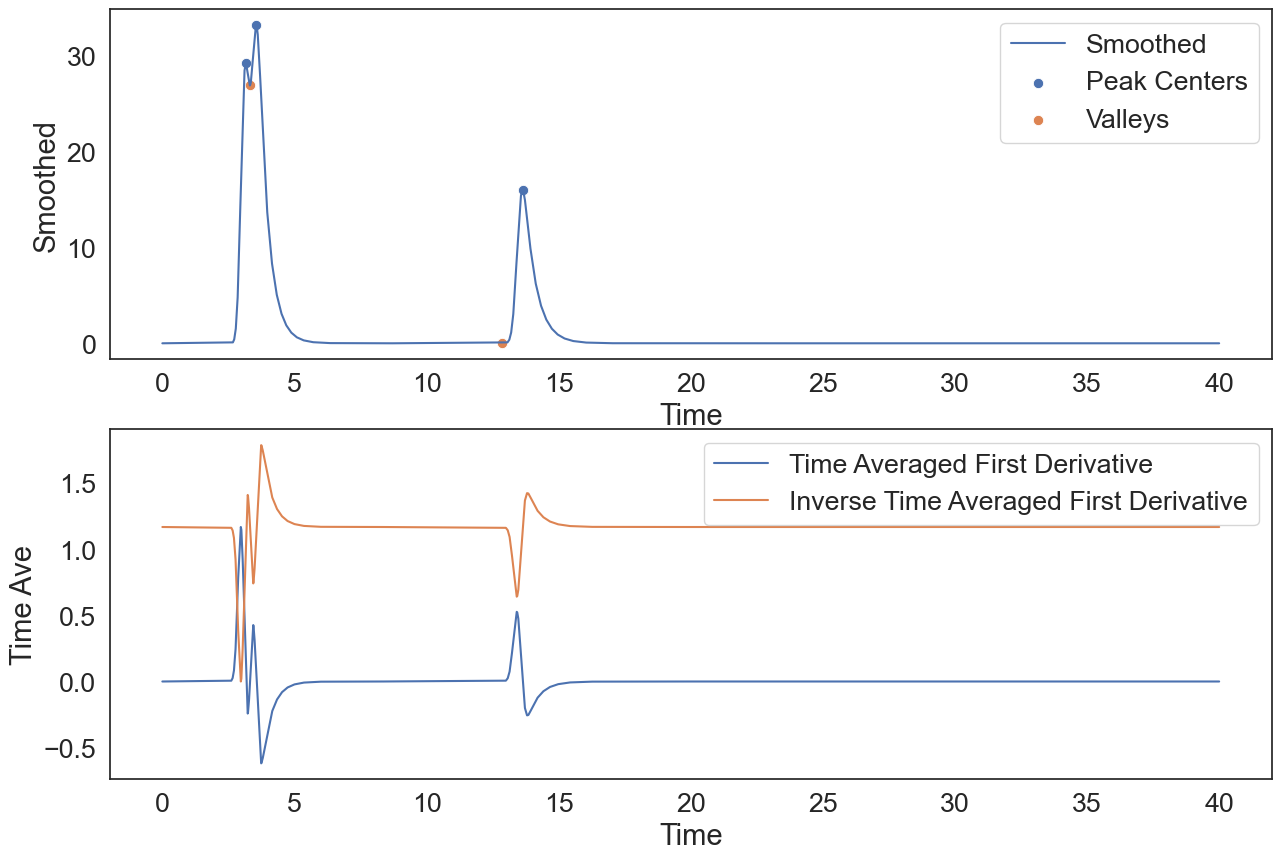

[0, 3.31, 12.84, 20]
[0, 3.31, 12.84, 20]
[0, 3.31, 12.84, 20]
5.319086720453249 1.5301044287825216 8.33901514007764e-06
4.939171861168991e-10
5.219827953271772e-10
9.028773584915676e-11
[0, 3.29, 12.83, 20]
[0, 3.29, 12.83, 20]
[0, 3.29, 12.83, 20]
4.223397294305989 1.211239124694273 1.2592317079558592e-05
6.353640573202827e-12
1.4437180714143192e-11
2.6738043112557716e-12
[0, 13.030000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.079356184980776 1.4422599114832237 1.1662962492405507e-05
3.3805050114198704e-11
3.290638937871887e-11
8.450327638342864e-11
[0, 12.85, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.312242735931829 1.2244415630749343 9.883059413591804e-06
5.108377923237027e-12
5.769432166657073e-12
8.85769862411104e-12
[0, 12.84, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.700998893494615 1.6187725097327739 1.3037641077139036e-05
6.125310954576244e-12
3.5537996333859436e-12
1.3638671797854615e-10
[0, 3.29, 12.83, 20]
[0, 3.29, 12.83, 20]
[0, 3.29, 12.83, 2

1.496894920394792e-11
1.4031818609426552e-11
7.113154429095175e-11
[0, 3.31, 12.93, 20]
[0, 3.31, 12.93, 20]
[0, 3.31, 12.93, 20]
5.898622454447952 1.6968154153589485 3.35414888446172e-05
1.3555671721023972e-10
1.37295694503978e-10
8.632435246142752e-11
[0, 12.88, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.49032146518651 1.842897036891178 2.8797544743306157e-05
1.1122550022443142e-08
1.1111708295901772e-08
2.4683027250267643e-13
[0, 3.33, 13.08, 20]
[0, 3.33, 13.08, 20]
[0, 3.33, 13.08, 20]
3.2280504568677792 0.9313918863779375 0.00024320698167438535
1.4055666807949893e-10
1.4159046440627638e-10
1.3377934591718518e-10
[0, 3.2600000000000002, 12.9, 20]
[0, 3.2600000000000002, 12.9, 20]
[0, 3.2600000000000002, 12.9, 20]
3.6428115779414507 1.0399573115947318 1.6125212017281805e-05
1.8537951144884602e-11
1.0118022200490522e-11
9.247427401758454e-16
[0, 3.3200000000000003, 13.120000000000001, 20]
[0, 3.3200000000000003, 13.120000000000001, 20]
[0, 3.3200000000000003, 13.120000000000001

2.1950578405373965e-10
1.647726918673578e-10
3.8386165203074114e-10
[0, 12.9, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.994446155997286 1.986040932447486 1.6409964089857648e-05
6.439449711265962e-10
6.487314284501377e-10
7.87366568098852e-11
[0, 12.89, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.284991098787746 1.7845944203848079 3.79748118161149e-05
2.2816151044311436e-09
2.2808836654583467e-09
1.9230661600715652e-11
[0, 2.65, 3.35, 12.86, 20]
[2.65, 3.35, 12.86, 20]
[2.65, 3.35, 12.86, 20]
8.832275770481862 1.1684002600639145 1.4669902211709518e-05
1.4007892304838363e-10
1.3694928802507984e-10
5.35388965044144e-10
[0, 3.36, 12.83, 20]
[0, 3.36, 12.83, 20]
[0, 3.36, 12.83, 20]
3.554521639015839 1.0301982444899571 6.535639708915581e-06
5.852500007201791e-10
6.028416064132882e-10
1.1567152517885798e-10
[0, 3.2800000000000002, 13.1, 20]
[0, 3.2800000000000002, 13.1, 20]
[0, 3.2800000000000002, 13.1, 20]
5.9353738077203095 1.699632420040552 0.00024451661205153783
6.3480333701001

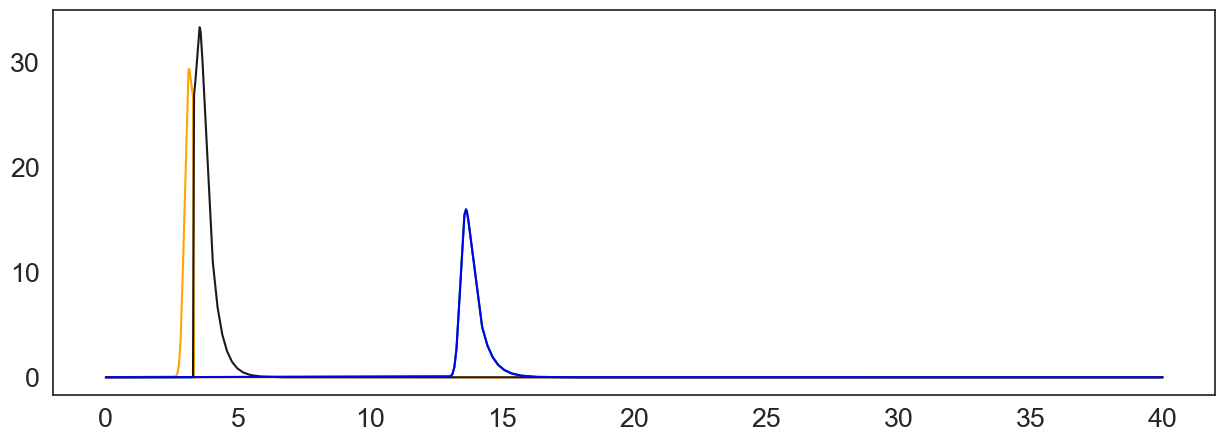

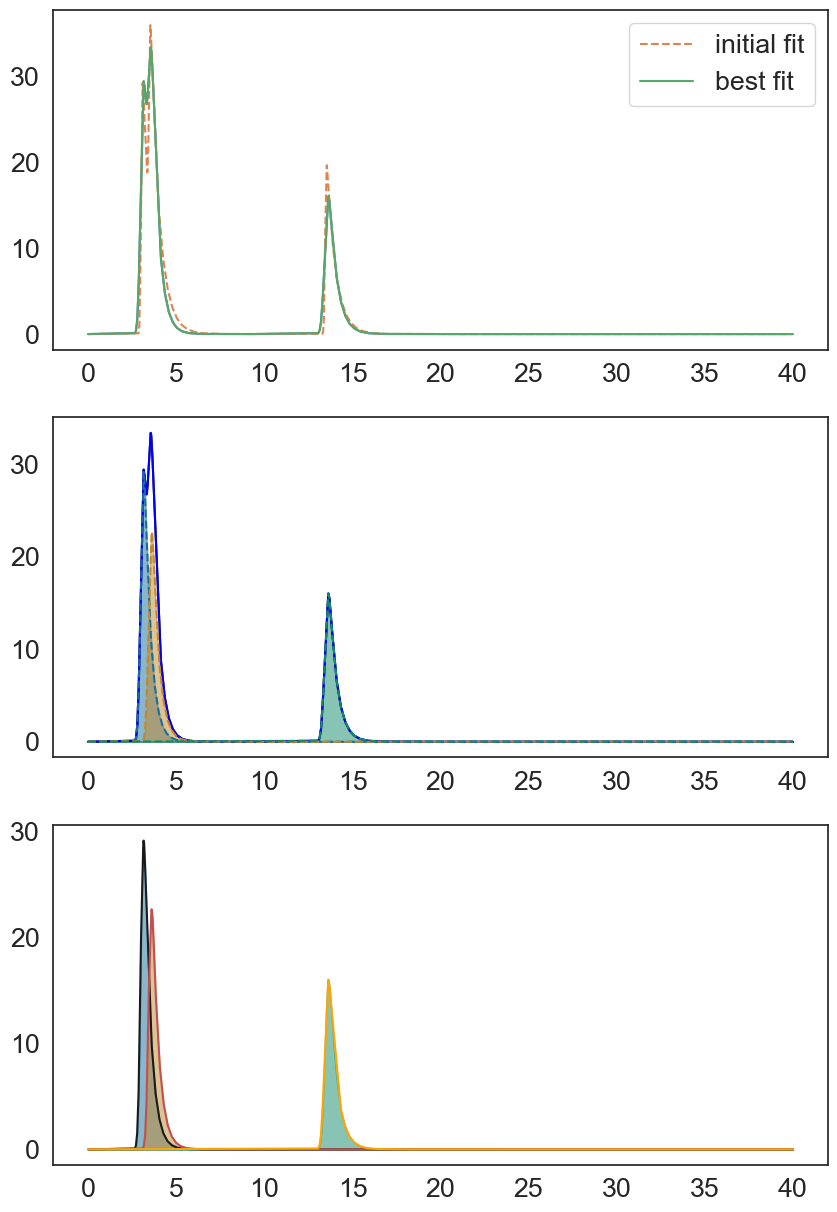

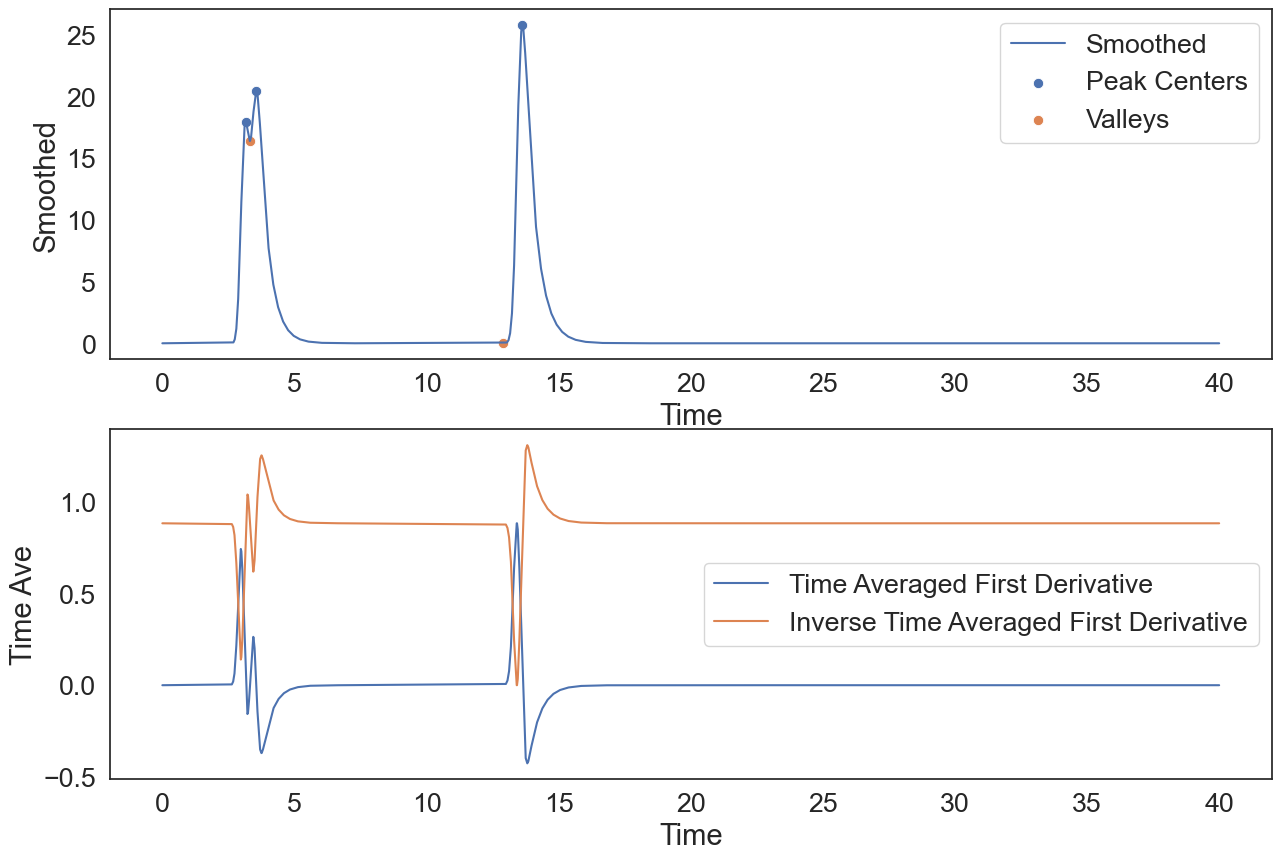

[0, 3.31, 12.88, 20]
[0, 3.31, 12.88, 20]
[0, 3.31, 12.88, 20]
3.106959375206211 0.8937572465322741 2.1369624930808228e-05
3.161114128189348e-10
3.238273676387377e-10
3.7224645960191083e-10
[0, 3.34, 12.92, 20]
[0, 3.34, 12.92, 20]
[0, 3.34, 12.92, 20]
3.958932502558519 1.1439876476864665 1.7740467740135608e-05
1.1366480882907983e-10
1.1437510715633998e-10
5.5426895350846815e-11
[0, 2.62, 3.31, 13.01, 20]
[2.62, 3.31, 13.01, 20]
[2.62, 3.31, 13.01, 20]
10.535794077608253 1.3837633499680009 5.590363283938115e-05
4.025670090342313e-10
4.2748275038726916e-10
1.2583723971677382e-12
[0, 2.63, 3.33, 13.05, 20]
[2.63, 3.33, 13.05, 20]
[2.63, 3.33, 13.05, 20]
8.124996573832124 1.0748360238243084 0.0001221750121522837
1.0944751721768703e-11
1.099095078788033e-11
1.540905832933746e-11
[0, 12.97, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.2029485426090885 1.7612988123532072 7.370077529993343e-06
3.293122271155929e-10
3.3205731655150723e-10
5.322470649126063e-11
[0, 2.64, 3.31, 12.96, 20]
[2.

3.136024998597177e-10
3.1457279600572245e-10
5.596943132483166e-10
[0, 3.34, 12.97, 20]
[0, 3.34, 12.97, 20]
[0, 3.34, 12.97, 20]
4.499592879663365 1.3002188525127374 3.902113731452507e-05
2.663051398915282e-10
2.6165708494504573e-10
1.2409038890572596e-10
[0, 13.08, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.328354853011743 1.229016524894803 8.598398532039963e-06
4.0028537279839365e-10
4.055479488585086e-10
9.491715911817738e-11
[0, 3.25, 12.94, 20]
[0, 3.25, 12.94, 20]
[0, 3.25, 12.94, 20]
6.016309814843499 1.71491215035497 2.540277791404374e-05
3.3067078882858803e-09
3.3109799612483466e-09
8.997864733757993e-11
[0, 2.67, 3.34, 13.05, 20]
[2.67, 3.34, 13.05, 20]
[2.67, 3.34, 13.05, 20]
8.682557273659729 1.1237121188240513 0.00011143674906050244
1.4409198306185895e-10
1.488427300128572e-10
5.37465137187786e-11
[0, 2.64, 3.31, 12.97, 20]
[2.64, 3.31, 12.97, 20]
[2.64, 3.31, 12.97, 20]
11.308274839600871 1.4635371849367314 6.511042219159954e-05
3.233521720875638e-10
3.2079251110269

3.1724913180521965e-10
3.293322082114389e-10
8.403980887659243e-11
[0, 3.3000000000000003, 12.85, 20]
[0, 3.3000000000000003, 12.85, 20]
[0, 3.3000000000000003, 12.85, 20]
3.683637370630955 1.058044282228625 1.4007110147754062e-05
5.536192656022853e-10
5.541600315342722e-10
5.1942360450866137e-11
[0, 13.08, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
4.551483558652046 1.2923728983453744 7.480473614417954e-06
6.64594163028101e-10
6.649674578183346e-10
9.115286241819362e-11
[0, 2.62, 3.33, 12.89, 20]
[2.62, 3.33, 12.89, 20]
[2.62, 3.33, 12.89, 20]
8.3063986162442 1.1066542274798454 1.4036222309503094e-05
1.0450549981230068e-10
1.1092962439953772e-10
1.9005932201941142e-10
[0, 13.05, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.537096133144512 1.8561784893658129 1.0195682428307045e-05
1.1188236242291865e-10
1.1268916921186667e-10
1.733869967934709e-10
[0, 3.29, 12.88, 20]
[0, 3.29, 12.88, 20]
[0, 3.29, 12.88, 20]
6.235762004058745 1.7883704480567608 1.7215699056410232e-05
1.180410847

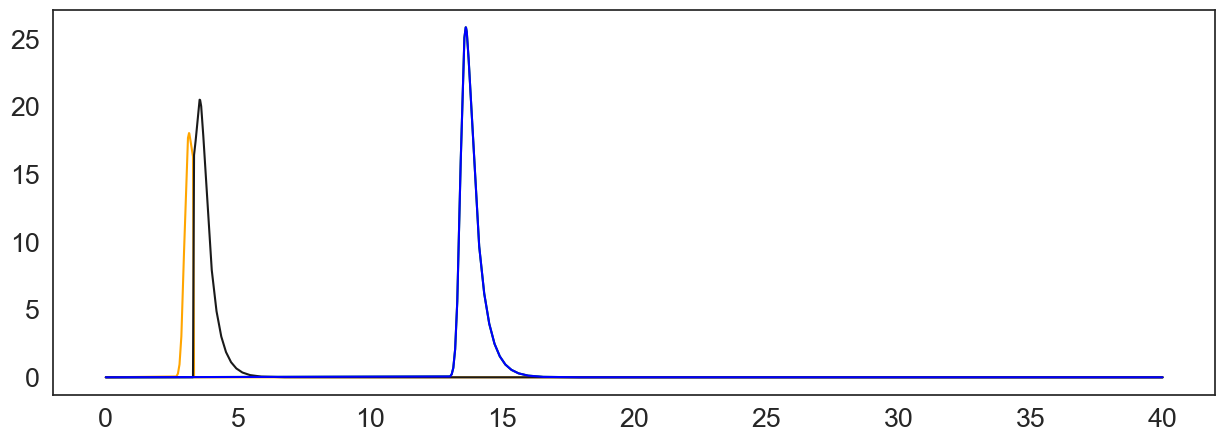

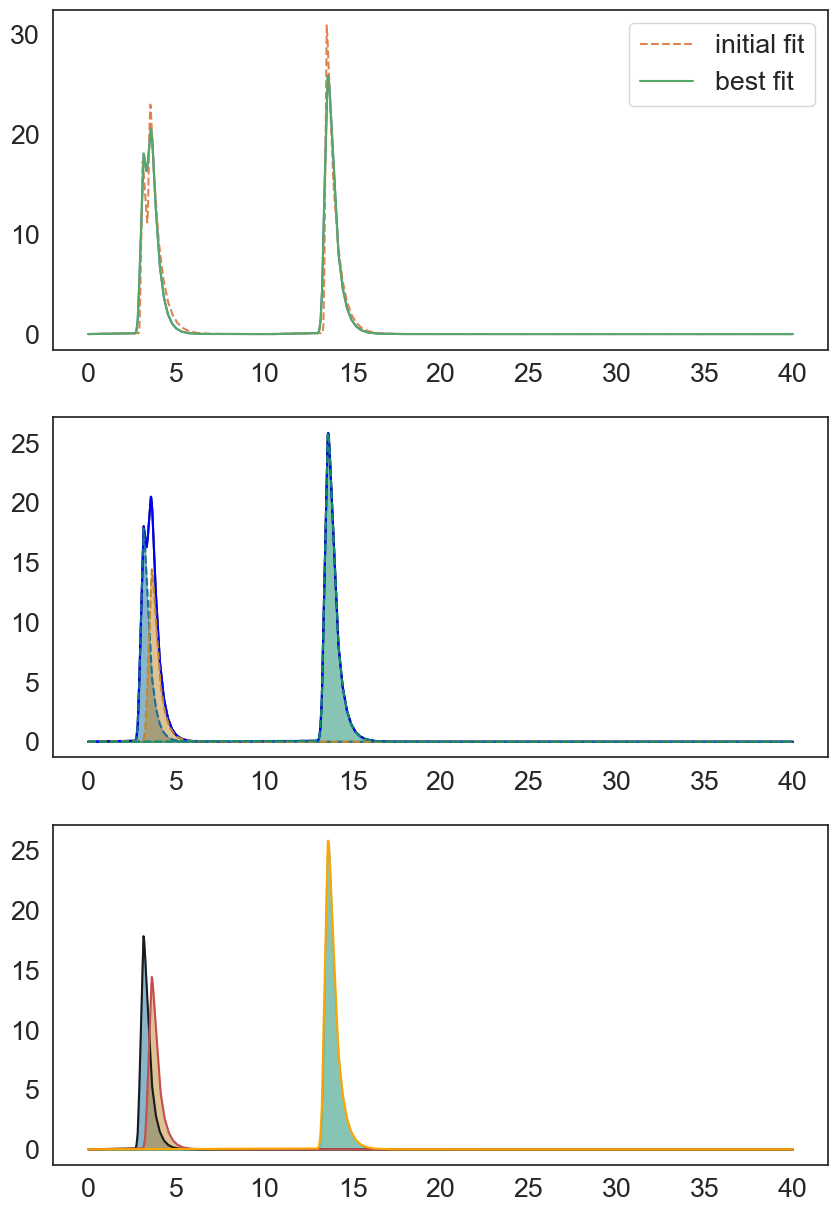

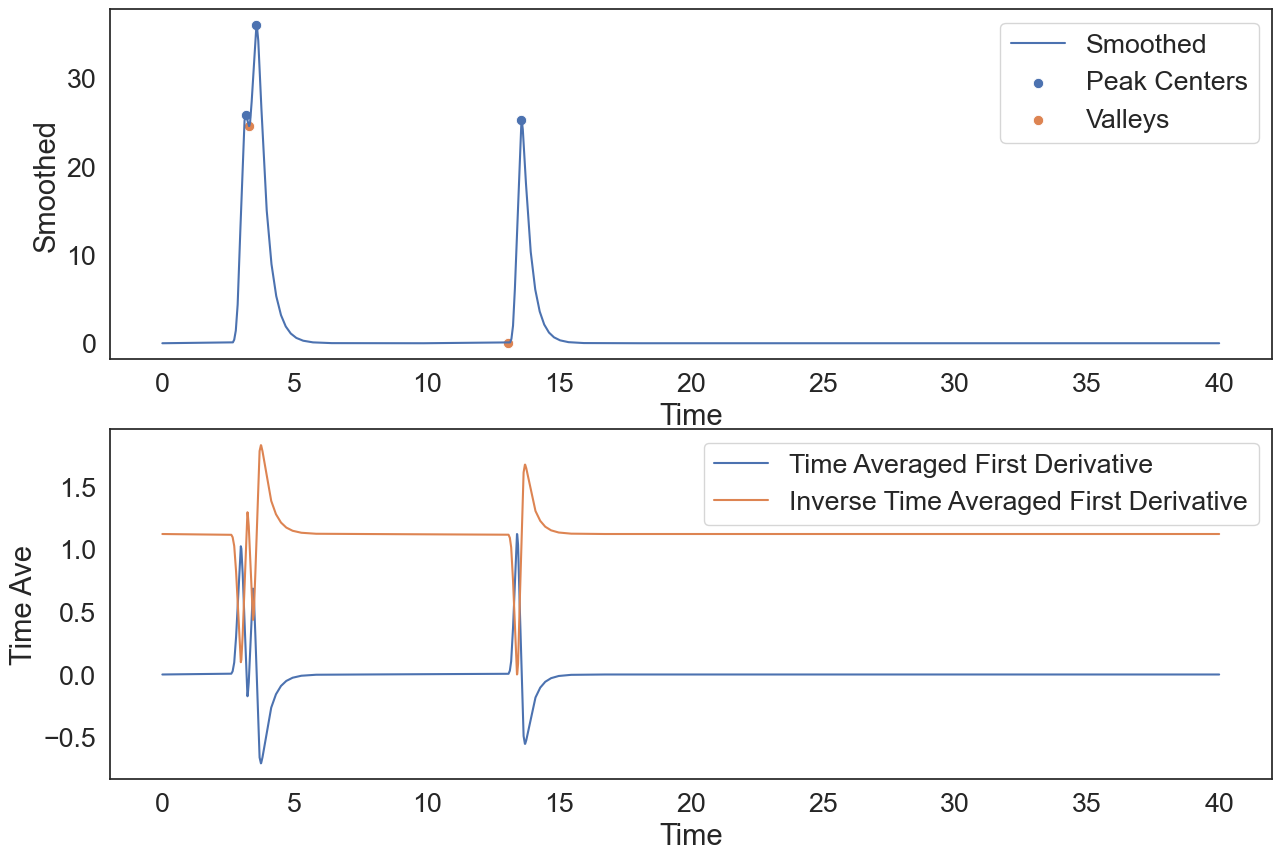

[0, 3.2800000000000002, 13.08, 20]
[0, 3.2800000000000002, 13.08, 20]
[0, 3.2800000000000002, 13.08, 20]
5.15927724732764 1.4773921840376119 0.00021176030219669079
6.788154678269747e-12
6.799269768096814e-12
2.856111846429824e-10
[0, 13.120000000000001, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.225654048801886 1.4838005196233317 2.379200781696275e-05
1.7452551158002028e-11
3.0665510422963964e-11
1.7972698843688986e-12
[0, 3.25, 12.86, 20]
[0, 3.25, 12.86, 20]
[0, 3.25, 12.86, 20]
6.012859448675888 1.71392864451638 9.714266175430118e-06
3.4402234051980743e-10
3.2607263222753543e-10
1.1811572296373797e-11
[0, 2.62, 3.31, 12.91, 20]
[2.62, 3.31, 12.91, 20]
[2.62, 3.31, 12.91, 20]
9.636772067317308 1.2656864675737745 1.771330879306399e-05
1.088136336830161e-11
1.1028214701226305e-11
1.9115415691146055e-10
[0, 12.97, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.467058978854523 1.8362917603796427 8.54630788991358e-06
1.530056333848037e-10
1.552965534763805e-10
2.919246005344766e-11


1.135118157192231e-09
1.1272972219058842e-09
3.323288581889986e-11
[0, 3.2800000000000002, 12.88, 20]
[0, 3.2800000000000002, 12.88, 20]
[0, 3.2800000000000002, 12.88, 20]
4.808832451681949 1.3770400514433676 1.773412945739233e-05
2.3175496110111678e-09
2.3252573119603698e-09
8.081125943389534e-11
[0, 12.93, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
6.7218013462782125 1.9086246884419191 3.319134289441815e-05
6.786849276035233e-12
6.737137496272002e-12
9.39037970575075e-12
[0, 3.29, 13.030000000000001, 20]
[0, 3.29, 13.030000000000001, 20]
[0, 3.29, 13.030000000000001, 20]
4.68909519658694 1.3447978434097418 8.752794991250525e-05
1.0042080262765352e-10
1.0096248301556251e-10
5.497211449708728e-10
[0, 3.3200000000000003, 12.86, 20]
[0, 3.3200000000000003, 12.86, 20]
[0, 3.3200000000000003, 12.86, 20]
3.080537183107448 0.887494155030889 1.68482498856047e-05
5.249417466400722e-10
5.392819722608742e-10
3.4896842398518187e-11
[0, 3.27, 13.0, 20]
[0, 3.27, 13.0, 20]
[0, 3.27, 13.0, 20]
5.

2.8007347417237934e-10
2.7773804152348856e-10
6.442554468993533e-10
[0, 2.67, 3.3000000000000003, 12.96, 20]
[2.67, 3.3000000000000003, 12.96, 20]
[2.67, 3.3000000000000003, 12.96, 20]
11.402218344157427 1.4309670463974151 5.4606416364032104e-05
1.7944051222601357e-10
1.9738338056751144e-10
2.6940645267601142e-11
[0, 13.01, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.43946150209245 1.544510166023289 1.4062485544243124e-05
6.81514904921255e-10
6.81316915985692e-10
3.86382404551867e-10
[0, 3.27, 12.94, 20]
[0, 3.27, 12.94, 20]
[0, 3.27, 12.94, 20]
6.318972272584455 1.8067178296528537 3.053303020158279e-05
1.4831589178371173e-09
1.4908870018594961e-09
2.137570223799841e-11
[0, 2.65, 3.33, 13.11, 20]
[2.65, 3.33, 13.11, 20]
[2.65, 3.33, 13.11, 20]
7.497824919380605 0.9775968080115978 0.0002901134673111643
6.27515597496742e-10
6.27245359365021e-10
5.5901462982804027e-11
[0, 12.86, 20]
[0, 3.225, 8.45, 20]
[0, 3.225, 8.45, 20]
5.203100477815908 1.4773965364979733 2.1851056658707316e-05
1

In [34]:
error_list=[]
for j in [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    for n in range(100):
        amps=[]
        gammas=[]
        sigmas=[]
        center=[]
        amp1=random.uniform(10,20)
        amps.append(amp1)
        gammas.append(random.uniform(2.9,3))
        sigmas.append(random.uniform(0.1,0.15))
        center.append(3)
        
        amps.append(amp1*j)
        gammas.append(random.uniform(2.9,3))
        sigmas.append(random.uniform(0.1,0.15))
        center.append(max(center)+3*0.15)
        
        amps.append(random.uniform(10,20))
        gammas.append(random.uniform(2.9,3))
        sigmas.append(random.uniform(0.1,0.15))
        center.append(max(center)+10)
        x =np.arange(0,40,0.01)
        areas,y=_ngaussian_exp(x,amps,center,sigmas,gammas,noise='None')
        #k=pybaselines.whittaker.psalsa(y,lam=1e11)[0]
        #y=y-k
        #z=low_pass_filter(y,2000,500)
        #z=np.convolve(z, np.ones(10)/10, mode='same')
        """
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.plot(x,z)
        ax.plot(x,y)
        """
        df = pd.DataFrame()
        df["Time"]=x
        df["Value"]=y
        if n<1:
            graph=True
        else:
            graph=False
        centers,heights,valleys=find_locations_peaks(df,0.01,1,graph=graph,shoulder=False, shoulder_cutoffs=None)


        if len(valleys)>4:
            valleys=valleys[1:]
        if len(valleys)<4:
            valleys=[0,(center[0]+center[1])/2,(center[1]+center[2])/2,20]
        print(valleys)
        _,y1=_ngaussian_exp(x,[amps[0]],[center[0]],[sigmas[0]],[gammas[0]],noise='None')
        y_1=y[:int(valleys[1]*100)]
        z1=np.zeros(4000-int(valleys[1]*100))
        y_1=np.concatenate((y_1,z1))

        _,y2=_ngaussian_exp(x,[amps[1]],[center[1]],[sigmas[1]],[gammas[1]],noise='None')
        y_2=y[int(valleys[1]*100):int(valleys[2]*100)]
        z1=np.zeros(int(valleys[1]*100))
        z2=np.zeros(4000-int(valleys[2]*100))
        y_2=np.concatenate((z1,y_2,z2))
        
        _,y3=_ngaussian_exp(x,[amps[2]],[center[2]],[sigmas[2]],[gammas[2]],noise='None')
        y_3=y[int(valleys[2]*100):]
        z3=np.zeros(int(valleys[2]*100))
        y_3=np.concatenate((z3,y_3))
        y1_error=0
        for i in range(len(y)):
            y1_error+=(y_1[i]-y1[i])*(y_1[i]-y1[i])
        y1_error=math.sqrt(y1_error/(valleys[1]*100-valleys[0]*100))
        
        y2_error=0
        for i in range(len(y)):
            y2_error+=(y_2[i]-y2[i])*(y_2[i]-y2[i])
        y2_error=math.sqrt(y2_error/(len(y)))
        
        y3_error=0
        print(valleys)
        for i in range(len(y)):
            #print(i,y3_error)
            y3_error+=(y_3[i]-y3[i])*(y_3[i]-y3[i])
        y3_error=math.sqrt(y3_error/(len(y)))
          
        if graph:
            fig,ax=plt.subplots(1,1,figsize=(15,5))
            ax.plot(x,y3,color="green")
            ax.plot(x,y_1,color='orange')
            ax.plot(x,y_2,color='k')
            ax.plot(x,y_3,color='blue')
        print(y1_error,y2_error,y3_error)
        error_list.append({"Peak Number":1,"RMSE":y1_error,"Algorithm":"Valley-to-Valley","Peak Ratio":j})
        error_list.append({"Peak Number":2,"RMSE":y2_error,"Algorithm":"Valley-to-Valley","Peak Ratio":j})
        error_list.append({"Peak Number":3,"RMSE":y3_error,"Algorithm":"Valley-to-Valley","Peak Ratio":j})
        area=find_peak_areas(df,"sample",0,40,canonical_peaks=[center,amps,valleys],comparisons=True,graph=graph,peak1=y1,peak2=y2,peak3=y3)
        error_list.append({"Peak Number":1,"RMSE":area[0][2],"Algorithm":"PeakClimber","Peak Ratio":j})
        error_list.append({"Peak Number":2,"RMSE":area[1][2],"Algorithm":"PeakClimber","Peak Ratio":j})
        error_list.append({"Peak Number":3,"RMSE":area[2][2],"Algorithm":"PeakClimber","Peak Ratio":j})
        #print(area)

In [35]:
dataframe2=pd.DataFrame(error_list)
#dataframe.to_csv("movement_error.csv")

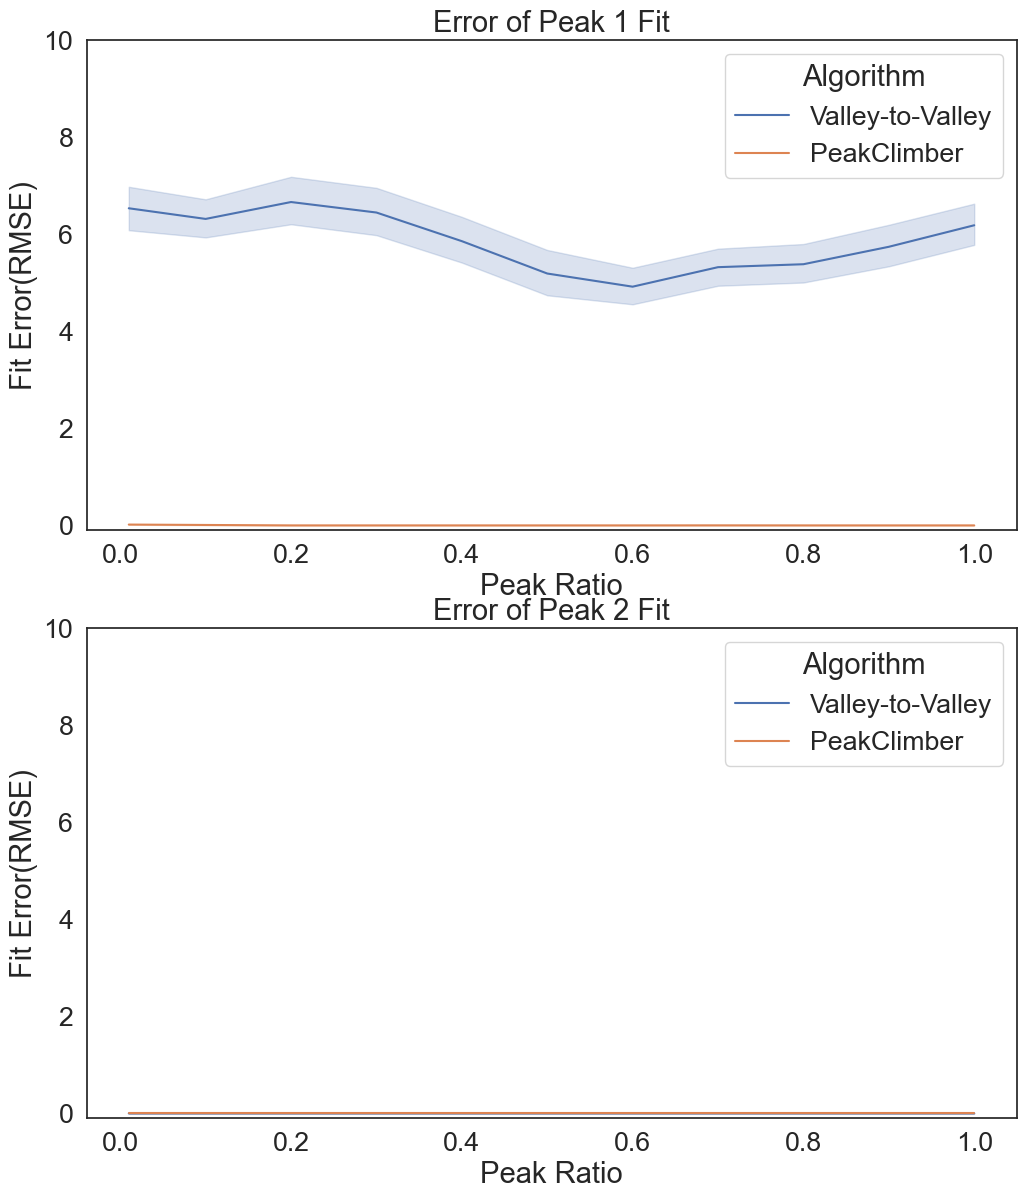

In [40]:
fig,ax=plt.subplots(2, 1, figsize=(12, 14))
sns.lineplot(data=dataframe2[dataframe2["Peak Number"]==1],x="Peak Ratio",y="RMSE",hue="Algorithm",ax=ax[0])
ax[0].set_title("Error of Peak 1 Fit")
ax[1].set_title("Error of Peak 2 Fit")
ax[0].set_ylim(-0.1,10)
ax[1].set_ylim(-0.1,10)
ax[0].set_ylabel("Fit Error(RMSE)")
ax[1].set_ylabel("Fit Error(RMSE)")
sns.lineplot(data=dataframe2[dataframe2["Peak Number"]==3],x="Peak Ratio",y="RMSE",hue="Algorithm",ax=ax[1])
plt.show()